This EDA nb is using occurrence tables e-mailed from Tiago on 9/27 (duplicated, with rotated lat and long columns)

## Imports + Loading In Data

In [549]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler


In [550]:
# %pip install openpyxl

In [551]:
# Loading in data w/ rotated coordinates
rep = pd.read_excel('reptilia_occ_genus.xlsm', engine='openpyxl')
syn = pd.read_excel('synapsida_occ_genus.xlsm', engine='openpyxl')
tem = pd.read_excel('temnospondyli_occ_genus.xlsm', engine='openpyxl')

In [552]:
rep['county'].isna().sum()

1495

In [553]:
rep['county'].value_counts()

county
Apache                    234
Comanche                  152
Rio Arriba                 88
Franklin                   78
Gloucestershire            67
                         ... 
Malmyzh                     1
Anson                       1
Sa√É¬¥ne-et-Loire           1
Huesca                      1
Aliwal North Commonage      1
Name: count, Length: 355, dtype: int64

## Note on the Time_bins_ByStages.txt 

This is the -fixShift input file

This file is already in descending order (oldest age to most recent). If you go into PyRate.py and find the "if args.fixShift" line, you'll see that the code wants this format. So no further processing of this file is needed

## Saving Nulls as CSV's

In [554]:
# Seeing how many nulls are in each column will help us decide which columns to drop
nulls_rep = rep.isna().sum()
nulls_syn = syn.isna().sum()
nulls_tem = tem.isna().sum()

# Concatenating the nulls into a single dataframe based on a shared index
# This will allow us to compare the nulls across the three datasets
nulls = pd.concat([nulls_rep, nulls_syn, nulls_tem], axis=1)
nulls.columns = ['Reptilia', 'Synapsida', 'Temnospondyli']

nulls.to_csv('nulls.csv')

In [555]:
# len of nulls df is diff from len of columns in rep
# which means there are columns that are not shared
len(nulls.index), len(rep.columns)

(119, 94)

In [556]:
# Finding which columns rep, syn, and tem do not share
# Crude code, just to see if there are any differences, not finding all differences
# Because any not-shared columns wouldn't be included in the analysis anyway

if rep.columns.all() == syn.columns.all() == tem.columns.all():
    print('All columns are the same')
else:
    diff = rep.columns.difference(syn.columns).difference(tem.columns)
    print(diff)

Index(['abund_in_sediment', 'artifacts', 'component_comments', 'concentration',
       'fossilsfrom1', 'fossilsfrom2', 'lagerstatten', 'lithadj2', 'localbed',
       'localsection', 'minor_lithology2', 'orientation', 'reference_no.x',
       'temporal_resolution'],
      dtype='object')


## Confirming that these are Datasets w/ duplicated rows (eda_duplicates)

In [557]:
# Loading in datasets that I had previously duplicated (i.e., the output of eda_duplicates.ipynb)
rep_old = pd.read_csv('occurrence_tables_1/reptilia_dup.csv')
syn_old = pd.read_csv('occurrence_tables_1/synapsida_dup.csv')
tem_old = pd.read_csv('occurrence_tables_1/temnospondyli_dup.csv')

In [558]:
# Checking that the lengths of the original and new datasets are the same
len(rep_old), len(rep), len(syn_old), len(syn), len(tem_old), len(tem)

(4411, 4411, 3422, 3422, 2247, 2247)

In [559]:
# One last double-check to make sure that the datasets are the same
# All 'abund_values' for "individuals" should be 1
individuals = rep[rep['abund_unit'] == 'individuals']
individuals['abund_value'].value_counts()

abund_value
1.0    2032
Name: count, dtype: int64

## Fixing Strings in "genus"

In [560]:
rep[rep['genus'].str.contains('[^a-zA-Z_]', regex=True)]['genus']

4370    Stenoscelida¬ò
Name: genus, dtype: object

In [561]:
rep.loc[rep['genus'] == 'Stenoscelida¬ò', 'genus'] = 'Stenoscelida'

In [562]:
rep[rep['genus'].str.contains('[^a-zA-Z_]', regex=True)]['genus']

Series([], Name: genus, dtype: object)

In [563]:
syn[~syn['genus'].str.isalpha()]['genus']

3168    Bonacynodon 
3169    Bonacynodon 
Name: genus, dtype: object

In [564]:
has_space = ' ' in syn.at[3168, 'genus']
has_space

True

In [565]:
syn.loc[syn['genus'] == 'Bonacynodon ', 'genus'] = 'Bonacynodon'

In [566]:
syn[~syn['genus'].str.isalpha()]['genus']

Series([], Name: genus, dtype: object)

In [567]:
tem[~tem['genus'].str.isalpha()]['genus']

Series([], Name: genus, dtype: object)

## Filtering to BDNN columns

In [568]:
rep.columns

Index(['id', 'Rotated Lat', 'Rotated Lon', 'occurrence_no', 'pres_mode',
       'preservation_quality', 'common_body_parts', 'abund_value',
       'abund_unit', 'class', 'family', 'genus', 'taxon_environment',
       'life_habit', 'diet', 'early_interval', 'late_interval', 'time_bins',
       'museum', 'collection_no', 'age_max', 'age_min', 'age_median',
       'age_uncer_range', 'lng', 'lat', 'environment', 'occurrence_comments',
       'cc', 'state', 'county', 'formation', 'stratgroup', 'member', 'zone',
       'accepted_rank', 'ref_author', 'ref_pubyr', 'reference_no.x',
       'collection_name', 'collection_subset', 'collection_aka',
       'latlng_basis', 'latlng_precision', 'geogscale', 'geogcomments',
       'paleomodel', 'geoplate', 'paleoage', 'paleolng', 'paleolat',
       'paleomodel2', 'geoplate2', 'paleoage2', 'paleolng2', 'paleolat2',
       'paleomodel3', 'geoplate3', 'paleoage3', 'paleolng3', 'paleolat3',
       'protected', 'stratscale', 'localsection', 'localbed', 'st

In [569]:
print(f"Total length of 'id' column:", len(rep[['id']])), 
print(f"Number of unique 'id' values", len(rep[['id']].value_counts())), 
print("Total length (rows) of rep df", len(rep)), 
print("Total length of 'occurrence_no' column", len(rep[['occurrence_no']])), 
print("Number of unique 'occurrence_no' values", len(rep[['occurrence_no']].value_counts()))


Total length of 'id' column: 4411
Number of unique 'id' values 4411
Total length (rows) of rep df 4411
Total length of 'occurrence_no' column 4411
Number of unique 'occurrence_no' values 3145


In [570]:
print(f"Total length of 'id' column:", len(syn[['id']])), 
print(f"Number of unique 'id' values", len(syn[['id']].value_counts())), 
print("Total length (rows) of syn df", len(syn)), 
print("Total length of 'occurrence_no' column", len(syn[['occurrence_no']])), 
print("Number of unique 'occurrence_no' values", len(syn[['occurrence_no']].value_counts()))

Total length of 'id' column: 3422
Number of unique 'id' values 3422
Total length (rows) of syn df 3422
Total length of 'occurrence_no' column 3422
Number of unique 'occurrence_no' values 2789


In [571]:
print(f"Total length of 'id' column:", len(tem[['id']])), 
print(f"Number of unique 'id' values", len(tem[['id']].value_counts())), 
print("Total length (rows) of tem df", len(tem)), 
print("Total length of 'occurrence_no' column", len(tem[['occurrence_no']])), 
print("Number of unique 'occurrence_no' values", len(tem[['occurrence_no']].value_counts()))

Total length of 'id' column: 2247
Number of unique 'id' values 2247
Total length (rows) of tem df 2247
Total length of 'occurrence_no' column 2247
Number of unique 'occurrence_no' values 1369


In [572]:
rep[['occurrence_no']].isna().sum(), syn[['occurrence_no']].isna().sum(), tem[['occurrence_no']].isna().sum()

(occurrence_no    0
 dtype: int64,
 occurrence_no    0
 dtype: int64,
 occurrence_no    0
 dtype: int64)

'occurrence_no' seems to have repeats, so 'id' should be used to identify each unique occurrence in the future

In [573]:
# Still waiting on 'niche' info from Arielli
syn_filtered = syn[['id', 'Rotated Lat', 'Rotated Lon', 'genus', 'taxon_environment', 
                    'age_max', 'age_min']]
syn_filtered.isna().sum()

id                     0
Rotated Lat            0
Rotated Lon            0
genus                  0
taxon_environment    310
age_max                0
age_min                0
dtype: int64

In [574]:
syn_filtered.shape, syn_filtered['id'].nunique()

((3422, 7), 3422)

In [575]:
syn_filtered.head()

id  Rotated Lat  Rotated Lon           genus taxon_environment  age_max  \
0  3422      -0.4818     -24.8936    Edaphosaurus       terrestrial    303.7   
1  3421      -2.9808     -38.7628      Ophiacodon       terrestrial    290.1   
2  3420     -49.4771     -10.0175  Therioherpeton       terrestrial    237.0   
3  3419       5.8574     -44.6091      Ophiacodon       terrestrial    298.9   
4  3418      -1.4701     -41.4649   Adelobasileus       terrestrial    227.0   

   age_min  
0    298.9  
1    283.5  
2    208.5  
3    290.1  
4    208.5

In [576]:
# Still waiting on 'niche' info from Arielli
tem_filtered = tem[['id', 'Rotated Lat', 'Rotated Lon', 'genus', 'taxon_environment', 
                    'age_max', 'age_min']]
tem_filtered.isna().sum()

id                    0
Rotated Lat           0
Rotated Lon           0
genus                 0
taxon_environment    14
age_max               0
age_min               0
dtype: int64

In [577]:
# Still waiting on 'niche' info from Arielli
rep_filtered = rep[['id', 'Rotated Lat', 'Rotated Lon', 'genus', 'taxon_environment', 
                    'age_max', 'age_min']]
rep_filtered.isna().sum()

id                   0
Rotated Lat          0
Rotated Lon          0
genus                0
taxon_environment    0
age_max              0
age_min              0
dtype: int64

In [578]:
rep_filtered[rep_filtered['genus'].str.contains('[^a-zA-Z_]', regex=True)]['genus']

Series([], Name: genus, dtype: object)

In [579]:
rep_filtered['taxon_environment'].head(20)

0     terrestrial
1     terrestrial
2     terrestrial
3     terrestrial
4     terrestrial
5     terrestrial
6     terrestrial
7     terrestrial
8     terrestrial
9     terrestrial
10    terrestrial
11    terrestrial
12    terrestrial
13    terrestrial
14    terrestrial
15    terrestrial
16    terrestrial
17    terrestrial
18    terrestrial
19    terrestrial
Name: taxon_environment, dtype: object

In [580]:
rep['environment'].head(20)

0     lacustrine - large
1     lacustrine - large
2           fissure fill
3           fissure fill
4         fluvial indet.
5     terrestrial indet.
6     terrestrial indet.
7           fissure fill
8           fissure fill
9           fissure fill
10          fissure fill
11          fissure fill
12          fissure fill
13          fissure fill
14          fissure fill
15          fissure fill
16          fissure fill
17          fissure fill
18          fissure fill
19          fissure fill
Name: environment, dtype: object

## Prepping DeepDive columns

In [581]:
rep_deepdive = rep[['id', 'genus', 'county', 'state', 'occurrence_no', 'age_max', 'age_min', 'cc', 'Rotated Lat', 'Rotated Lon']]
rep_deepdive.head()

id          genus      county         state occurrence_no  age_max  \
0  4411    Icarosaurus      Hudson    New Jersey        146084  227.000   
1  4410       Rutiodon      Hudson    New Jersey        146085  227.000   
2  4409  Kuehneosuchus    Somerset       England        146086  208.500   
3  4408  Kuehneosaurus    Somerset       England        146087  208.500   
4  4407    Procolophon  Chris Hani  Eastern Cape        147521  251.902   

   age_min  cc  Rotated Lat  Rotated Lon  
0    208.5  US       6.7390     -20.6269  
1    208.5  US       6.7390     -20.6269  
2    201.4  UK      35.9688       2.1884  
3    201.4  UK      35.9688       2.1884  
4    247.2  ZA     -62.6208     -11.8191

In [582]:
syn_deepdive = syn[['id', 'genus', 'county', 'state', 'occurrence_no','age_max', 'age_min', 'cc', 'Rotated Lat', 'Rotated Lon']]
tem_deepdive = tem[['id', 'genus', 'county', 'state', 'occurrence_no', 'age_max', 'age_min', 'cc', 'Rotated Lat', 'Rotated Lon']]

In [583]:
rep_deepdive[rep_deepdive['genus'].str.contains('[^a-zA-Z_]', regex=True)]['genus']

Series([], Name: genus, dtype: object)

### 'County' and 'State' Cols EDA

#### Are 'County' Null Counts Reasonable?

In [584]:
rep_deepdive.isna().sum()

# 'county' has a lot of nulls, so I'm going to look back at the older datasets and see if that seems correct or
# if an error occurred when I was duplicating the rows

id                  0
genus               0
county           1495
state             212
occurrence_no       0
age_max             0
age_min             0
cc                  8
Rotated Lat         0
Rotated Lon         0
dtype: int64

In [585]:
# Making sure occurrence no has >1 values, since there are duplicate rows (duplicated in eda_duplicates.ipynb)
rep['occurrence_no'].value_counts()

occurrence_no
1285964    300
629477      91
1586159     37
902070      33
486411      25
          ... 
830763       1
830777       1
830855       1
830859       1
N84          1
Name: count, Length: 3145, dtype: int64

In [586]:
# Loading in my original duplication output
rep_original = pd.read_csv('occurrence_tables_1/reptilia_dup.csv')
rep_original_filtered = rep_original[['genus', 'county', 'state']]
rep_original_filtered.isna().sum()

genus        0
county    1495
state      212
dtype: int64

In [587]:
# Loading in the very first dataset (raw, no rotated lat and long)
rep_old = pd.read_csv('occurrence_tables_1/reptilia_genus_occ_all.csv', encoding = 'latin1')
rep_old_filtered = rep_old[['genus', 'county', 'state']]
rep_old_filtered.isna().sum()

genus       0
county    920
state     197
dtype: int64

#### Saving Just Duplicated Rows

In [588]:
# Saving off just the parts in the deepdive dataset that were duplicated occurrences (i.e., the rows that were duplicated in eda_duplicates.ipynb)
# Trying to see if there's a pattern in the 'county' nulls that I can fix
rep_deepdive_dups = rep_deepdive[rep_deepdive.duplicated(subset=['occurrence_no'], keep=False)]
rep_deepdive_dups.to_csv('reptilia_processed_data/reptilia_deepdive_dups.csv')

syn_deepdive_dups = syn_deepdive[syn_deepdive.duplicated(subset=['occurrence_no'], keep=False)]
syn_deepdive_dups.to_csv('synapsida_processed_data/synapsida_deepdive_dups.csv')

tem_deepdive_dups = tem_deepdive[tem_deepdive.duplicated(subset=['occurrence_no'], keep=False)]
tem_deepdive_dups.to_csv('temnospondyli_processed_data/temnospondyli_deepdive_dups.csv')

#### Fixing Nonsensical Strings in 'County' and 'State'

In [589]:
# Return rows in 'county' and 'state' columns that contain any non-letter characters
import re

# Function for outputting a CSV of unique values in a column that contain special characters
def find_special_chars(df, col, clade):
    df2 = df.copy()
    df2[col] = df2[col].fillna('') # Have to fill empty values with something to use regex
    non_letter = df2[df2[col].str.contains(r'[^a-zA-Z\s\-/\'\,\(\)]', na=False)] # Regex for non-letter characters, excluding hyphens and forward slashes
    unique = non_letter[col].unique()
    # Saving unique values to a CSV named after the clade and column
    unique_df = pd.DataFrame(unique)
    # unique_df.to_csv(f'{clade}_processed_data/{clade}_{col}_special_chars.csv') # Used this already during first run, so commenting out
    # ^ Commenting out so I don't overwrite the files I've already saved. This is just for the first run.
    return unique

In [590]:
rep_deepdive

id             genus      county         state occurrence_no  age_max  \
0     4411       Icarosaurus      Hudson    New Jersey        146084  227.000   
1     4410          Rutiodon      Hudson    New Jersey        146085  227.000   
2     4409     Kuehneosuchus    Somerset       England        146086  208.500   
3     4408     Kuehneosaurus    Somerset       England        146087  208.500   
4     4407       Procolophon  Chris Hani  Eastern Cape        147521  251.902   
...    ...               ...         ...           ...           ...      ...   
4406     5       Eohyosaurus           -        FSTATE           N80  247.200   
4407     4        Mesosuchus           -         ECAPE           N81  247.200   
4408     3        Mesosuchus           -         ECAPE           N82  247.200   
4409     2        Mesosuchus           -         ECAPE           N83  247.200   
4410     1  Stenaulorhynchus           -    Tanganyika           N84  247.200   

      age_min  cc  Rotated Lat  Rotated Lon  
0       208.5  US       6.7390     -20.6269  
1       208.5  US       6.7390     -20.6269  
2       201.4  UK      35.9688       2.1884  
3       201.4  UK      35.9688       2.1884  
4       247.2  ZA     -62.6208     -11.8191  
...       ...  ..          ...          ...  
4406    242.0  ZA     -47.4217     -18.3424  
4407    242.0  ZA     -47.4217     -18.3424  
4408    242.0  ZA     -47.4217     -18.3424  
4409    242.0  ZA     -47.4217     -18.3424  
4410    242.0  TZ     -47.4217     -18.3424  

[4411 rows x 10 columns]

In [591]:
# Reptilia
find_special_chars(rep_deepdive, 'county', 'reptilia'), find_special_chars(rep_deepdive, 'state', 'reptilia')

(array(['Valle Fert√É¬≠l', 'Valle F√É¬©rtil', 'Vend√É¬©e',
        'Wei√É¬üenburg-Gunzenhausen', 'S√É¬£o Gabriel', 'L√É¬∂rrach',
        'Portel√É¬¢ndia', 'Perol√É¬¢ndia', 'S√É¬£o Mateus do Sul',
        'Tatu√É¬≠', 'Rebou√É¬ßas', 'Candel√É¬°ria', 'N√É¬ºrnberger Land',
        'Schw√É¬§bisch Hall', 'S√É¬£o Pedro do Sul', 'G√É¬∂ttingen',
        'Sa√É¬¥ne-et-Loire', 'Baden-W√É¬ºrttemberg', 'Th√É¬ºringen',
        'T√É¬ºbingen', 'S√É¬¢one-et-Loire', 'H√É¬©rault',
        'S√É¬£o Jo√É¬£o do Pol√É¬™sine', 'Yuan√¢¬Ä¬ôan',
        'Tarnowskie G√É¬≥ry', 'Arroio do S¬õ', 'Linha S?o Luiz',
        'Toroqu√ø', 'Ribeir?o', 'Rinc?o dos Weiss', 'Acegu√ø',
        'Sesmaria do Pinhal 1',
        'cff Rafael prov√øvel material do MNRJ se sao os mesmo do livro tombo, Alemoa',
        'Cerrito?', 'Sesmaria do Pinhal 2', 'V√ørzea do Agudo',
        '?gua Negra', 'BR 158 federal road', 'Porto Mariante 2',
        'Sao Jose?', 'Sao Jose? (embaixo do cemit?rio coletado por Price)'],
       dtype=object),
 

In [592]:
# Temnospondyli
find_special_chars(tem_deepdive, 'county', 'temnospondyli'), find_special_chars(tem_deepdive, 'state', 'temnospondyli')

(array(['Wei√É¬üeritzkreis', 'Schw√É¬§bisch Hall', 'T√É¬ºbingen',
        'Sa√É¬¥ne-et-Loire', 'S√É¬£o Jo√É¬£o do Pol√É¬™sine',
        'S√É¬£o Gabriel', 'Valle F√É¬©rtil', 'S?o Jer¬ìnimo da Serra',
        'Toroqu¬†'], dtype=object),
 array(['Baden-W√É¬ºrttemberg', 'Sk√É¬•ne', 'Th√É¬ºringen',
        'Azad Jammu & Kashmir', 'Rakovn√É¬≠k', 'Th√É¬ºringer Wald',
        'Th√É¬ºringia', 'Paran√É¬°', 'Baden-W√É¬ºrtteberg'], dtype=object))

In [593]:
# Synapsida
find_special_chars(syn_deepdive, 'county', 'synapsida'), find_special_chars(syn_deepdive, 'state', 'synapsida')

(array(['Valle Fert√É¬≠l', 'Sa√É¬¥ne-et-Loire', 'Wei√É¬üeritzkreis',
        'Schw√É¬§bisch Hall', 'S√É¬£o Gabriel', 'Candel√É¬°ria',
        'Kotel√¢¬Ä¬ônichskii', 'T√É¬ºbingen', '√É¬úr√É¬ºmqi', 'H√É¬©rault',
        'Valle F√É¬©rtil', 'Vila Est¬Éncia Nova', 'Linha S?o Luiz',
        'Linha S?o Luiz ', 'Sesmaria do Pinhal 1', 'V¬†rzea do Agudo',
        'Botucara¬°', 'Rinc?o do Pinhal', 'Linha V¬†rzea 2',
        'Linha V¬†rzea 1', 'Rinc?o do Semi?o ', 'Porto Mariante 2',
        'Rinc?o da Porta', 'Catu¬áaba', 'BR 158 federal road',
        'Linha Fac?o', 'Chiniqu¬†'], dtype=object),
 array(['Franch-Comt√É¬©', 'R√É¬≠o Negro', 'Baden-W√É¬ºrttemberg',
        'Rakovn√É¬≠k', 'Paran√É¬°', 'H√É¬©rault'], dtype=object))

In [594]:
# Special Characters Dictionary for Reptilia
# To map special characters to their correct values

rep_state_dict = {
    "Baden-W√É¬ºrttemberg": "Baden-Wurttemberg",
    "Nieder√É¬∂sterreich": "Niederosterreich",
    "T√É¬°chira": "Tachira",
    "Sa√É¬Øda": "Saida",
    "Sk√É¬•ne": "Skane",
    "Goi√É¬°s": "Goias",
    "Paran√É¬°": "Parana",
    "S√É¬£o Paulo": "Sao Paulo",
    "Cear√É¬°": "Ceara",
    "Guair√É¬°": "Guaira",
    "Bourgogne-Franche-Comt√É¬©": "Bourgogne-Franche-Comte",
    "Baden-W√É¬ºrttenburg": "Baden-Wurttemberg",
    "Nieder√É¬∂stereich": "Niederosterreich",
    "Bayern (Bavaria)": "Bayern",
    "Baden-W√É¬ºrtteberg": "Baden-Wurttemberg",
    "Baden-W√É¬ºrttemburg": "Baden-Wurttemberg",
    "Bansk√É¬° Bystrica": "Banska Bystrica",
    "Graub√É¬ºnden": "Graubunden"
}

rep_county_dict = {
    "Valle Fert√É¬≠l": "Valle Fertil",
    "Valle F√É¬©rtil": "Valle Fertil",
    "Vend√É¬©e": "Vendee",
    "Wei√É¬üenburg-Gunzenhausen": "Weissenburg-Gunzenhausen",
    "S√É¬£o Gabriel": "Sao Gabriel",
    "L√É¬∂rrach": "Lorrach",
    "Portel√É¬¢ndia": "Portelandia",
    "Perol√É¬¢ndia": "Perolandia",
    "S√É¬£o Mateus do Sul": "Sao Mateus do Sul",
    "Tatu√É¬≠": "Tatui",
    "Rebou√É¬ßas": "Reboucas",
    "Candel√É¬°ria": "Candelaria",
    "N√É¬ºrnberger Land": "Nurnberger Land",
    "Schw√É¬§bisch Hall": "Schwabisch Hall",
    "S√É¬£o Pedro do Sul": "Sao Pedro do Sul",
    "G√É¬∂ttingen": "Gottingen",
    "Sa√É¬¥ne-et-Loire": "Saone-et-Loire",
    "Baden-W√É¬ºrttemberg": "Baden-Wurttemberg",
    "Th√É¬ºringen": "Thuringen",
    "T√É¬ºbingen": "Tubingen",
    "S√É¬¢one-et-Loire": "Saone-et-Loire",
    "H√É¬©rault": "Herault",
    "S√É¬£o Jo√É¬£o do Pol√É¬™sine": "Sao Joao do Polesine",
    "Yuan√¢¬Ä¬ôan": "Yuan'an",
    "Tarnowskie G√É¬≥ry": "Tarnowskie Gory",
    "Arroio do S¬õ": "Arroio do So",
    "Linha S?o Luiz": "Linha Sao Luiz",
    "Toroqu√ø": "Toroqua",
    "Ribeir?o": "Ribeirao",
    "Rinc?o dos Weiss": "Rincao dos Weiss",
    "Acegu√ø": "Acegua",
    "Sesmaria do Pinhal 1": "Sesmaria do Pinhal 1",
    "cff Rafael prov√øvel material do MNRJ se sao os mesmo do livro tombo, Alemoa": "cff Rafael provavel material do MNRJ se sao os mesmo do livro tombo, Alemoa",
    "Cerrito?": "Cerrito",
    "Sesmaria do Pinhal 2": "Sesmaria do Pinhal 2",
    "V√ørzea do Agudo": "Varzea do Agudo",
    "?gua Negra": "Agua Negra",
    "BR 158 federal road": "BR 158 federal road",
    "Porto Mariante 2": "Porto Mariante 2",
    "Sao Jose?": "Sao Jose",
    "Sao Jose? (embaixo do cemit?rio coletado por Price)": "Sao Jose"
}




In [595]:
# Cleaning special characters in 'state' and 'county' columns for Reptilia
rep_deepdive_cleaned = rep_deepdive.copy()
rep_deepdive_cleaned['state'] = rep_deepdive_cleaned['state'].replace(rep_state_dict)
rep_deepdive_cleaned['county'] = rep_deepdive_cleaned['county'].replace(rep_county_dict)

# Checking to see if the cleaning worked
print(find_special_chars(rep_deepdive_cleaned, 'county', 'reptilia'))
print(find_special_chars(rep_deepdive_cleaned, 'state', 'reptilia'))

['Sesmaria do Pinhal 1' 'Sesmaria do Pinhal 2' 'BR 158 federal road'
 'Porto Mariante 2']
[]


In [596]:
# Special Characters Dictionary for Synapsida

syn_state_dict = {
    "Franch-Comt√É¬©": "Franche-Comte",
    "R√É¬≠o Negro": "Rio Negro",
    "Baden-W√É¬ºrttemberg": "Baden-Wurttemberg",
    "Rakovn√É¬≠k": "Rakovnik",
    "Paran√É¬°": "Parana",
    "H√É¬©rault": "Herault"
}
syn_county_dict = {
    "Valle Fert√É¬≠l": "Valle Fertil",
    "Sa√É¬¥ne-et-Loire": "Saone-et-Loire",
    "Wei√É¬üeritzkreis": "Weisseritzkreis",
    "Schw√É¬§bisch Hall": "Schwabisch Hall",
    "S√É¬£o Gabriel": "Sao Gabriel",
    "Candel√É¬°ria": "Candelaria",
    "Kotel√¢¬Ä¬ônichskii": "Kotelnichskii",
    "T√É¬ºbingen": "Tubingen",
    "√É¬úr√É¬ºmqi": "Urumqi",
    "H√É¬©rault": "Herault",
    "Valle F√É¬©rtil": "Valle Fertil",
    "Vila Est¬Éncia Nova": "Vila Estancia Nova",
    "Linha S?o Luiz": "Linha Sao Luiz",
    "Linha S?o Luiz ": "Linha Sao Luiz",
    "V¬†rzea do Agudo": "Varzea do Agudo",
    "Botucara¬°": "Botucara",
    "Rinc?o do Pinhal": "Rincao do Pinhal",
    "Linha V¬†rzea 2": "Linha Varzea 2",
    "Linha V¬†rzea 1": "Linha Varzea 1",
    "Rinc?o do Semi?o ": "Rincao do Semiao",
    "Rinc?o da Porta": "Rincao da Porta",
    "Catu¬áaba": "Catuaba",
    "Linha Fac?o": "Linha Facao",
    "Chiniqu¬†": "Chinique"
}

In [597]:
# Cleaning special characters in 'state' and 'county' columns for Reptilia
syn_deepdive_cleaned = syn_deepdive.copy()
syn_deepdive_cleaned['state'] = syn_deepdive_cleaned['state'].replace(syn_state_dict)
syn_deepdive_cleaned['county'] = syn_deepdive_cleaned['county'].replace(syn_county_dict)

# Checking to see if the cleaning worked
print(find_special_chars(syn_deepdive_cleaned, 'county', 'synapsida'))
print(find_special_chars(syn_deepdive_cleaned, 'state', 'synapsida'))

['Sesmaria do Pinhal 1' 'Linha Varzea 2' 'Linha Varzea 1'
 'Porto Mariante 2' 'BR 158 federal road']
[]


In [598]:
# Special Characters Dictionary for Temnospondyli

tem_state_dict = {
    "Baden-W√É¬ºrttemberg": "Baden-Wurttemberg",
    "Sk√É¬•ne": "Skane",
    "Th√É¬ºringen": "Thuringen",
    "Rakovn√É¬≠k": "Rakovnik",
    "Th√É¬ºringer Wald": "Thuringer Wald",
    "Th√É¬ºringia": "Thuringia",
    "Paran√É¬°": "Parana",
    "Baden-W√É¬ºrtteberg": "Baden-Wurttemberg"
}

tem_county_dict = euro_southam_location_dict = {
    "Wei√É¬üeritzkreis": "Weisseritzkreis",
    "Schw√É¬§bisch Hall": "Schwabisch Hall",
    "T√É¬ºbingen": "Tubingen",
    "Sa√É¬¥ne-et-Loire": "Saone-et-Loire",
    "S√É¬£o Jo√É¬£o do Pol√É¬™sine": "Sao Joao do Polesine",
    "S√É¬£o Gabriel": "Sao Gabriel",
    "Valle F√É¬©rtil": "Valle Fertil",
    "S?o Jer¬ìnimo da Serra": "Sao Jeronimo da Serra",
    "Toroqu¬†": "Toroqua"
}

In [599]:
# Cleaning special characters in 'state' and 'county' columns for Reptilia
tem_deepdive_cleaned = tem_deepdive.copy()
tem_deepdive_cleaned['state'] = tem_deepdive_cleaned['state'].replace(tem_state_dict)
tem_deepdive_cleaned['county'] = tem_deepdive_cleaned['county'].replace(tem_county_dict)

# Checking to see if the cleaning worked
print(find_special_chars(tem_deepdive_cleaned, 'county', 'temnospondyli'))
print(find_special_chars(tem_deepdive_cleaned, 'state', 'temnospondyli'))

[]
['Azad Jammu & Kashmir']


In [600]:
# Note that some data will be lost, since some special character entries map to the same corrected value
rep_deepdive['county'].nunique(), rep_deepdive_cleaned['county'].nunique(), rep_deepdive['state'].nunique(), rep_deepdive_cleaned['state'].nunique()

(355, 349, 209, 202)

In [601]:
syn_deepdive['county'].nunique(), syn_deepdive_cleaned['county'].nunique(), syn_deepdive['state'].nunique(), syn_deepdive_cleaned['state'].nunique()

(255, 252, 118, 118)

In [602]:
tem_deepdive['county'].nunique(), tem_deepdive_cleaned['county'].nunique(), tem_deepdive['state'].nunique(), tem_deepdive_cleaned['state'].nunique()

(222, 222, 142, 139)

In [603]:
# Checking that overall shape of the datasets hasn't changed
len(rep_deepdive), len(rep_deepdive_cleaned), len(syn_deepdive), len(syn_deepdive_cleaned), len(tem_deepdive), len(tem_deepdive_cleaned)

(4411, 4411, 3422, 3422, 2247, 2247)

#### Imputing 'County' Nulls w/ 'State

In [604]:
# First saving off a copy of the original 'county' column before we impute nulls
rep_deepdive_cleaned['county_original'] = rep_deepdive_cleaned['county']   
syn_deepdive_cleaned['county_original'] = syn_deepdive_cleaned['county']
tem_deepdive_cleaned['county_original'] = tem_deepdive_cleaned['county']

In [605]:
rep_deepdive_cleaned.head()

id          genus      county         state occurrence_no  age_max  \
0  4411    Icarosaurus      Hudson    New Jersey        146084  227.000   
1  4410       Rutiodon      Hudson    New Jersey        146085  227.000   
2  4409  Kuehneosuchus    Somerset       England        146086  208.500   
3  4408  Kuehneosaurus    Somerset       England        146087  208.500   
4  4407    Procolophon  Chris Hani  Eastern Cape        147521  251.902   

   age_min  cc  Rotated Lat  Rotated Lon county_original  
0    208.5  US       6.7390     -20.6269          Hudson  
1    208.5  US       6.7390     -20.6269          Hudson  
2    201.4  UK      35.9688       2.1884        Somerset  
3    201.4  UK      35.9688       2.1884        Somerset  
4    247.2  ZA     -62.6208     -11.8191      Chris Hani

In [606]:
def impute_county_nulls(df):
    df_imputed = df.copy()
    df_imputed.loc[df_imputed['county'] == '-', 'county'] = df_imputed['state']
    df_imputed.loc[df_imputed['county'].isna(), 'county'] = df_imputed['state']
    print('County hyphens count:', len(df_imputed.loc[df_imputed['county'] == '-', 'county']))
    print('County nulls count:', len(df_imputed.loc[df_imputed['county'].isna(), 'county']))
    print (df_imputed.loc[df_imputed['county'].isna()])
    return df_imputed

In [607]:
rep_deepdive_cleaned_imputed = impute_county_nulls(rep_deepdive_cleaned)
rep_deepdive_cleaned_imputed

County hyphens count: 0
County nulls count: 198
        id            genus county state occurrence_no  age_max  age_min  cc  \
56    4355   Neusticosaurus    NaN   NaN        150315    247.2   237.00  CH   
57    4354       Mixosaurus    NaN   NaN        150316    247.2   237.00  CH   
58    4353    Rhipaeosaurus    NaN   NaN        219963    266.9   264.28  RU   
94    4317    Proganochelys    NaN   NaN        283825    216.7   213.20  GL   
95    4315       Aetosaurus    NaN   NaN        283826    227.0   208.50  GL   
...    ...              ...    ...   ...           ...      ...      ...  ..   
4178   233      Macrocnemus    NaN   NaN       1600125    243.8   239.70  CH   
4179   232      Lariosaurus    NaN   NaN       1600126    243.8   239.70  CH   
4180   231    Askeptosaurus    NaN   NaN       1600127    243.8   239.70  CH   
4181   230  Helveticosaurus    NaN   NaN       1600128    243.8   239.70  CH   
4235   176   Prosantosaurus    NaN   NaN       1648022    242.0   239.70

id             genus      county         state occurrence_no  age_max  \
0     4411       Icarosaurus      Hudson    New Jersey        146084  227.000   
1     4410          Rutiodon      Hudson    New Jersey        146085  227.000   
2     4409     Kuehneosuchus    Somerset       England        146086  208.500   
3     4408     Kuehneosaurus    Somerset       England        146087  208.500   
4     4407       Procolophon  Chris Hani  Eastern Cape        147521  251.902   
...    ...               ...         ...           ...           ...      ...   
4406     5       Eohyosaurus      FSTATE        FSTATE           N80  247.200   
4407     4        Mesosuchus       ECAPE         ECAPE           N81  247.200   
4408     3        Mesosuchus       ECAPE         ECAPE           N82  247.200   
4409     2        Mesosuchus       ECAPE         ECAPE           N83  247.200   
4410     1  Stenaulorhynchus  Tanganyika    Tanganyika           N84  247.200   

      age_min  cc  Rotated Lat  Rotated Lon county_original  
0       208.5  US       6.7390     -20.6269          Hudson  
1       208.5  US       6.7390     -20.6269          Hudson  
2       201.4  UK      35.9688       2.1884        Somerset  
3       201.4  UK      35.9688       2.1884        Somerset  
4       247.2  ZA     -62.6208     -11.8191      Chris Hani  
...       ...  ..          ...          ...             ...  
4406    242.0  ZA     -47.4217     -18.3424               -  
4407    242.0  ZA     -47.4217     -18.3424               -  
4408    242.0  ZA     -47.4217     -18.3424               -  
4409    242.0  ZA     -47.4217     -18.3424               -  
4410    242.0  TZ     -47.4217     -18.3424               -  

[4411 rows x 11 columns]

In [608]:
syn_deepdive_cleaned_imputed = impute_county_nulls(syn_deepdive_cleaned)
syn_deepdive_cleaned_imputed

County hyphens count: 0
County nulls count: 180
        id            genus county state occurrence_no  age_max  age_min  cc  \
22    3400        Diictodon    NaN   NaN        229268  264.280  254.140  ZA   
31    3391   Kuehneotherium    NaN   NaN        283943  208.500  201.400  GL   
32    3390  Brachyzostrodon    NaN   NaN        283944  208.500  201.400  GL   
33    3389     Lystrosaurus    NaN   NaN        286245  251.902  247.200  AA   
34    3388     Lystrosaurus    NaN   NaN        286246  251.902  247.200  AA   
...    ...              ...    ...   ...           ...      ...      ...  ..   
3062   360     Lystrosaurus    NaN   NaN       1587697  251.902  247.200  AA   
3072   350      Notictoides    NaN   NaN       1607015  251.902  247.200  AA   
3073   349        Dicynodon    NaN   NaN       1607103  298.900  251.902  ZM   
3074   348        Dicynodon    NaN   NaN       1607105  298.900  251.902  MZ   
3101   321    Aelurognathus    NaN   NaN       1651601  259.510  254.140

id            genus            county              state  \
0     3422     Edaphosaurus              Ohio      West Virginia   
1     3421       Ophiacodon            Archer              Texas   
2     3420   Therioherpeton       Santa Maria  Rio Grande do Sul   
3     3419       Ophiacodon          San Juan               Utah   
4     3418    Adelobasileus            Crosby              Texas   
...    ...              ...               ...                ...   
3417     5    Santacruzodon       Schoenstatt                 RS   
3418     4    Santacruzodon       Schoenstatt                 RS   
3419     3  Dinodontosaurus          Pinheiro                 RS   
3420     2  Dinodontosaurus  Porto Mariante 2                 RS   
3421     1   Massetognathus  Rincao do Semiao                 RS   

     occurrence_no  age_max  age_min  cc  Rotated Lat  Rotated Lon  \
0           147591    303.7    298.9  US      -0.4818     -24.8936   
1           148250    290.1    283.5  US      -2.9808     -38.7628   
2           149619    237.0    208.5  BR     -49.4771     -10.0175   
3           149745    298.9    290.1  US       5.8574     -44.6091   
4           149837    227.0    208.5  US      -1.4701     -41.4649   
...            ...      ...      ...  ..          ...          ...   
3417          N506    237.0    227.0  BR     -49.4771     -10.0175   
3418          N507    237.0    227.0  BR     -49.4771     -10.0175   
3419          N508    242.0    237.0  BR     -61.9144       0.8613   
3420          N509    242.0    237.0  BR     -61.9144       0.8613   
3421          N510    242.0    237.0  BR     -64.1172      -1.7463   

       county_original  
0                 Ohio  
1               Archer  
2          Santa Maria  
3             San Juan  
4               Crosby  
...                ...  
3417       Schoenstatt  
3418       Schoenstatt  
3419          Pinheiro  
3420  Porto Mariante 2  
3421  Rincao do Semiao  

[3422 rows x 11 columns]

In [609]:
tem_deepdive_cleaned_imputed = impute_county_nulls(tem_deepdive_cleaned)
tem_deepdive_cleaned_imputed

County hyphens count: 0
County nulls count: 53
        id            genus county state occurrence_no  age_max  age_min  cc  \
13    2234   Platyoposaurus    NaN   NaN        219959  266.900   264.28  RU   
14    2233   Platyoposaurus    NaN   NaN        219960  266.900   264.28  RU   
15    2232       Melosaurus    NaN   NaN        219961  266.900   264.28  RU   
16    2231      Dvinosaurus    NaN   NaN        219962  266.900   264.28  RU   
768   1479   Mastodonsaurus    NaN   NaN        929804  242.000   237.00  DE   
844   1403     Parotosuchus    NaN   NaN       1081097  247.200   242.00  AA   
845   1402        Kryostega    NaN   NaN       1081098  247.200   242.00  AA   
967   1280      Aphaneramma    NaN   NaN       1131219  251.200   248.90  SJ   
968   1279      Aphaneramma    NaN   NaN       1131223  251.200   248.90  SJ   
970   1277  Lyrocephaliscus    NaN   NaN       1131869  251.200   248.90  SJ   
971   1276  Lyrocephaliscus    NaN   NaN       1131895  251.200   248.90 

id         genus           county       state occurrence_no  age_max  \
0     2247    Anconastes       Rio Arriba  New Mexico        146665    305.9   
1     2246   Broiliellus           Baylor       Texas        147563    283.5   
2     2245   Broiliellus             Clay       Texas        147564    298.9   
3     2244        Eryops           Archer       Texas        148243    290.1   
4     2243  Aspidosaurus           Archer       Texas        148244    290.1   
...    ...           ...              ...         ...           ...      ...   
2242     5   Rastosuchus  Morro do Mulato          PR            N5    266.9   
2243     4   Rastosuchus  Morro do Mulato          PR            N6    266.9   
2244     3   Rastosuchus  Morro do Mulato          PR            N7    266.9   
2245     2  Compsocerops           Buriol          RS            N8    227.0   
2246     1  Compsocerops           Buriol          RS            N9    227.0   

      age_min  cc  Rotated Lat  Rotated Lon  county_original  
0      298.90  US       4.6147     -41.8361       Rio Arriba  
1      273.01  US       1.0593     -36.5887           Baylor  
2      286.10  US      -0.5219     -37.7808             Clay  
3      283.50  US      -2.9808     -38.7628           Archer  
4      283.50  US      -2.9808     -38.7628           Archer  
...       ...  ..          ...          ...              ...  
2242   264.30  BR     -46.3881     -25.2811  Morro do Mulato  
2243   264.30  BR     -46.3881     -25.2811  Morro do Mulato  
2244   264.30  BR     -46.3881     -25.2811  Morro do Mulato  
2245   208.50  BR     -46.1164      -4.6554           Buriol  
2246   208.50  BR     -46.1164      -4.6554           Buriol  

[2247 rows x 11 columns]

#### Saving a CSV for Locality Imputation Double Check

In [610]:
# Saving a copy of the dataframe for checking that no data was lost from null imputation
rep_deepdive_cleaned_imputed.head()

id          genus      county         state occurrence_no  age_max  \
0  4411    Icarosaurus      Hudson    New Jersey        146084  227.000   
1  4410       Rutiodon      Hudson    New Jersey        146085  227.000   
2  4409  Kuehneosuchus    Somerset       England        146086  208.500   
3  4408  Kuehneosaurus    Somerset       England        146087  208.500   
4  4407    Procolophon  Chris Hani  Eastern Cape        147521  251.902   

   age_min  cc  Rotated Lat  Rotated Lon county_original  
0    208.5  US       6.7390     -20.6269          Hudson  
1    208.5  US       6.7390     -20.6269          Hudson  
2    201.4  UK      35.9688       2.1884        Somerset  
3    201.4  UK      35.9688       2.1884        Somerset  
4    247.2  ZA     -62.6208     -11.8191      Chris Hani

In [611]:
rep_test = rep_deepdive_cleaned_imputed.drop(columns=['age_max', 'age_min'])
rep_test.rename(columns={'county':"Locality"}, inplace=True)

syn_test = syn_deepdive_cleaned_imputed.drop(columns=['age_max', 'age_min'])
syn_test.rename(columns={'county':"Locality"}, inplace=True)

tem_test = tem_deepdive_cleaned_imputed.drop(columns=['age_max', 'age_min'])
tem_test.rename(columns={'county':"Locality"}, inplace=True)

rep_test.head()

id          genus    Locality         state occurrence_no  cc  \
0  4411    Icarosaurus      Hudson    New Jersey        146084  US   
1  4410       Rutiodon      Hudson    New Jersey        146085  US   
2  4409  Kuehneosuchus    Somerset       England        146086  UK   
3  4408  Kuehneosaurus    Somerset       England        146087  UK   
4  4407    Procolophon  Chris Hani  Eastern Cape        147521  ZA   

   Rotated Lat  Rotated Lon county_original  
0       6.7390     -20.6269          Hudson  
1       6.7390     -20.6269          Hudson  
2      35.9688       2.1884        Somerset  
3      35.9688       2.1884        Somerset  
4     -62.6208     -11.8191      Chris Hani

In [612]:
# Reordering the columns
# Leaving out age cols
cols_ordered = ['id', 'occurrence_no', 'genus', 'Locality', 'county_original', 'state', 'cc']
rep_test = rep_test[cols_ordered]
syn_test = syn_test[cols_ordered]
tem_test = tem_test[cols_ordered]
rep_test

id occurrence_no             genus    Locality county_original  \
0     4411        146084       Icarosaurus      Hudson          Hudson   
1     4410        146085          Rutiodon      Hudson          Hudson   
2     4409        146086     Kuehneosuchus    Somerset        Somerset   
3     4408        146087     Kuehneosaurus    Somerset        Somerset   
4     4407        147521       Procolophon  Chris Hani      Chris Hani   
...    ...           ...               ...         ...             ...   
4406     5           N80       Eohyosaurus      FSTATE               -   
4407     4           N81        Mesosuchus       ECAPE               -   
4408     3           N82        Mesosuchus       ECAPE               -   
4409     2           N83        Mesosuchus       ECAPE               -   
4410     1           N84  Stenaulorhynchus  Tanganyika               -   

             state  cc  
0       New Jersey  US  
1       New Jersey  US  
2          England  UK  
3          England  UK  
4     Eastern Cape  ZA  
...            ...  ..  
4406        FSTATE  ZA  
4407         ECAPE  ZA  
4408         ECAPE  ZA  
4409         ECAPE  ZA  
4410    Tanganyika  TZ  

[4411 rows x 7 columns]

In [613]:
rep_deepdive_cleaned_imputed.isna().sum()

id                    0
genus                 0
county              198
state               212
occurrence_no         0
age_max               0
age_min               0
cc                    8
Rotated Lat           0
Rotated Lon           0
county_original    1495
dtype: int64

In [614]:
rep_deepdive_cleaned_imputed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4411 entries, 0 to 4410
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               4411 non-null   int64  
 1   genus            4411 non-null   object 
 2   county           4213 non-null   object 
 3   state            4199 non-null   object 
 4   occurrence_no    4411 non-null   object 
 5   age_max          4411 non-null   float64
 6   age_min          4411 non-null   float64
 7   cc               4403 non-null   object 
 8   Rotated Lat      4411 non-null   float64
 9   Rotated Lon      4411 non-null   float64
 10  county_original  2916 non-null   object 
dtypes: float64(4), int64(1), object(6)
memory usage: 379.2+ KB


In [615]:
rep_test.isna().sum(), syn_test.isna().sum(), tem_test.isna().sum()

(id                    0
 occurrence_no         0
 genus                 0
 Locality            198
 county_original    1495
 state               212
 cc                    8
 dtype: int64,
 id                    0
 occurrence_no         0
 genus                 0
 Locality            180
 county_original    1115
 state               180
 cc                   27
 dtype: int64,
 id                   0
 occurrence_no        0
 genus                0
 Locality            53
 county_original    510
 state               55
 cc                   0
 dtype: int64)

In [616]:
# These CSVs have the following: nulls in 'Localtiy' are NOT dropped, 
# 'Locality' is the imputed 'county' column
# 'county_original' is the original 'county' column before imputation 
# Special characters have been replaced from 'Locality', 'state', and 'county_original' columns
rep_test.to_csv('reptilia_processed_data/reptilia_locality_check.csv')
syn_test.to_csv('synapsida_processed_data/synapsida_locality_check.csv')
tem_test.to_csv('temnospondyli_processed_data/temnospondyli_locality_check.csv')

In [617]:
rep_test[rep_test['genus'].str.contains('[^a-zA-Z_]', regex=True)]['genus'], rep_deepdive_cleaned_imputed[rep_deepdive_cleaned_imputed['genus'].str.contains('[^a-zA-Z_]', regex=True)]['genus']

(Series([], Name: genus, dtype: object),
 Series([], Name: genus, dtype: object))

### Locality Changes from Tiago
Sent the above *_locality_check.csv's to him, he sent them back with some changes made by hand to the 'locality' column, and some notes on further changes I should make. 
I'll load in his edits below, then make the changes he'd like

#### Merging genus and ages cols

In [618]:
# I need the 'genus', 'age_max', 'age_min' columns back for deepdive, so I'm going to add them back in
# Also need 'Rotated Lat' and "Rotated Lon" for hespdiv (which is pre-processing for DeepDive, so I need to add those back in too)
# I'm also going to add back in the 'occurrence_no' column, so that I can check to see if the merge worked correctly
rep_selected_cols = rep_deepdive_cleaned_imputed[['id', 'genus', 'age_max', 'age_min', 'occurrence_no', 'Rotated Lat', 'Rotated Lon']] 
syn_selected_cols = syn_deepdive_cleaned_imputed[['id', 'genus', 'age_max', 'age_min', 'occurrence_no', 'Rotated Lat', 'Rotated Lon']]
tem_selected_cols = tem_deepdive_cleaned_imputed[['id', 'genus', 'age_max', 'age_min', 'occurrence_no', 'Rotated Lat', 'Rotated Lon']]

##### Rep

In [619]:
rep_tiago = pd.read_csv('locality_checks_from_tiago/reptilia_locality_check_TRS.csv', index_col=0)
rep_tiago.head(), rep_tiago.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4411 entries, 0 to 4410
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   occurrence_no    4411 non-null   object
 1   locality         4268 non-null   object
 2   county_original  2918 non-null   object
 3   state            4213 non-null   object
 4   cc               4410 non-null   object
 5   notes            149 non-null    object
dtypes: object(6)
memory usage: 241.2+ KB


(  occurrence_no      locality county_original         state  cc notes
 0        146084    New Jersey          Hudson    New Jersey  US   NaN
 1        146085    New Jersey          Hudson    New Jersey  US   NaN
 2        146086       England        Somerset       England  UK   NaN
 3        146087       England        Somerset       England  UK   NaN
 4        147521  Eastern Cape      Chris Hani  Eastern Cape  ZA   NaN,
 None)

In [620]:
rep_merged = pd.merge(rep_tiago, rep_selected_cols, left_index=True, right_index=True, how='outer')
rep_merged.info(), rep_selected_cols.info(), rep_tiago.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4411 entries, 0 to 4410
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   occurrence_no_x  4411 non-null   object 
 1   locality         4268 non-null   object 
 2   county_original  2918 non-null   object 
 3   state            4213 non-null   object 
 4   cc               4410 non-null   object 
 5   notes            149 non-null    object 
 6   id               4411 non-null   int64  
 7   genus            4411 non-null   object 
 8   age_max          4411 non-null   float64
 9   age_min          4411 non-null   float64
 10  occurrence_no_y  4411 non-null   object 
 11  Rotated Lat      4411 non-null   float64
 12  Rotated Lon      4411 non-null   float64
dtypes: float64(4), int64(1), object(8)
memory usage: 482.5+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4411 entries, 0 to 4410
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dt

(None, None, None)

In [621]:
rep_merged[rep_merged['genus'].str.contains('[^a-zA-Z_]', regex=True)]['genus']

Series([], Name: genus, dtype: object)

In [622]:
# Check that occurrence no's from the original and the returned locality check from Tiago are the same
rep_merged[rep_merged['occurrence_no_x'] != rep_merged['occurrence_no_y']]


occurrence_no_x           locality county_original              state  \
0             146084         New Jersey          Hudson         New Jersey   
1             146085         New Jersey          Hudson         New Jersey   
2             146086            England        Somerset            England   
3             146087            England        Somerset            England   
4             147521       Eastern Cape      Chris Hani       Eastern Cape   
...              ...                ...             ...                ...   
4240         1658055             Yunnan            Luxy             Yunnan   
4241         1658965             Nevada        Pershing             Nevada   
4242         1659629         New Mexico      San Miguel         New Mexico   
4243         1659690  Baden-Wurttemberg            Calw  Baden-Wurttemberg   
4244         1660033              Texas           Garza              Texas   

      cc notes    id                   genus  age_max  age_min  \
0     US   NaN  4411             Icarosaurus  227.000    208.5   
1     US   NaN  4410                Rutiodon  227.000    208.5   
2     UK   NaN  4409           Kuehneosuchus  208.500    201.4   
3     UK   NaN  4408           Kuehneosaurus  208.500    201.4   
4     ZA   NaN  4407             Procolophon  251.902    247.2   
...   ..   ...   ...                     ...      ...      ...   
4240  CN   NaN   171              Mixosaurus  247.200    242.0   
4241  US   NaN   170  Benggwigwishingasuchus  247.200    242.0   
4242  US   NaN   169             Unguinychus  227.000    208.5   
4243  DE   NaN   168          Marcianosuchus  247.200    244.7   
4244  US   NaN   167              Garzapelta  227.000    208.5   

     occurrence_no_y  Rotated Lat  Rotated Lon  
0             146084       6.7390     -20.6269  
1             146085       6.7390     -20.6269  
2             146086      35.9688       2.1884  
3             146087      35.9688       2.1884  
4             147521     -62.6208     -11.8191  
...              ...          ...          ...  
4240         1658055      12.5798     120.0412  
4241         1658965      16.0387     -47.1461  
4242         1659629       1.3572     -44.2890  
4243         1659690      22.9805      20.4578  
4244         1660033      -1.4701     -41.4649  

[4245 rows x 13 columns]

##### Syn

In [623]:
syn_tiago = pd.read_csv('locality_checks_from_tiago/synapsida_locality_check_TRS.csv', index_col=0, encoding='latin1')
syn_tiago.head(), syn_tiago.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3422 entries, 0 to 3421
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   occurrence_no    3422 non-null   object
 1   locality         3354 non-null   object
 2   county_original  2307 non-null   object
 3   state            3242 non-null   object
 4   cc               3396 non-null   object
 5   notes            51 non-null     object
dtypes: object(6)
memory usage: 187.1+ KB


(  occurrence_no           locality county_original              state  cc  \
 0        147591      West Virginia            Ohio      West Virginia  US   
 1        148250              Texas          Archer              Texas  US   
 2        149619  Rio Grande do Sul     Santa Maria  Rio Grande do Sul  BR   
 3        149745               Utah        San Juan               Utah  US   
 4        149837              Texas          Crosby              Texas  US   
 
   notes  
 0   NaN  
 1   NaN  
 2   NaN  
 3   NaN  
 4   NaN  ,
 None)

In [624]:
syn_merged = pd.merge(syn_tiago, syn_selected_cols, left_index=True, right_index=True, how='outer')
syn_merged.info(), syn_selected_cols.info(), syn_tiago.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3422 entries, 0 to 3421
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   occurrence_no_x  3422 non-null   object 
 1   locality         3354 non-null   object 
 2   county_original  2307 non-null   object 
 3   state            3242 non-null   object 
 4   cc               3396 non-null   object 
 5   notes            51 non-null     object 
 6   id               3422 non-null   int64  
 7   genus            3422 non-null   object 
 8   age_max          3422 non-null   float64
 9   age_min          3422 non-null   float64
 10  occurrence_no_y  3422 non-null   object 
 11  Rotated Lat      3422 non-null   float64
 12  Rotated Lon      3422 non-null   float64
dtypes: float64(4), int64(1), object(8)
memory usage: 374.3+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3422 entries, 0 to 3421
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dt

(None, None, None)

In [625]:
syn_merged[syn_merged['occurrence_no_x'] != syn_merged['occurrence_no_y']]

# Odd issue here where the 'occurrence_no' columns are not the same, even though they are

occurrence_no_x           locality county_original              state  \
0             147591      West Virginia            Ohio      West Virginia   
1             148250              Texas          Archer              Texas   
2             149619  Rio Grande do Sul     Santa Maria  Rio Grande do Sul   
3             149745               Utah        San Juan               Utah   
4             149837              Texas          Crosby              Texas   
...              ...                ...             ...                ...   
3107         1651624             Zambia          Gwembe           Southern   
3108         1651627             Zambia          Gwembe           Southern   
3109         1651628             Zambia          Gwembe           Southern   
3110         1651629             Zambia             NaN           Muchinga   
3111         1657017               Ohio       Jefferson               Ohio   

      cc notes    id           genus  age_max  age_min occurrence_no_y  \
0     US   NaN  3422    Edaphosaurus   303.70  298.900          147591   
1     US   NaN  3421      Ophiacodon   290.10  283.500          148250   
2     BR   NaN  3420  Therioherpeton   237.00  208.500          149619   
3     US   NaN  3419      Ophiacodon   298.90  290.100          149745   
4     US   NaN  3418   Adelobasileus   227.00  208.500          149837   
...   ..   ...   ...             ...      ...      ...             ...   
3107  ZM   NaN   315     Endothiodon   259.51  251.902         1651624   
3108  ZM   NaN   314     Endothiodon   259.51  251.902         1651627   
3109  ZM   NaN   313     Endothiodon   259.51  251.902         1651628   
3110  ZM   NaN   312   Aelurognathus   259.51  251.902         1651629   
3111  US   NaN   311  Melanedaphodon   309.80  307.400         1657017   

      Rotated Lat  Rotated Lon  
0         -0.4818     -24.8936  
1         -2.9808     -38.7628  
2        -49.4771     -10.0175  
3          5.8574     -44.6091  
4         -1.4701     -41.4649  
...           ...          ...  
3107     -19.6615      20.2989  
3108     -19.6615      20.2989  
3109     -19.6615      20.2989  
3110     -29.1349      25.1550  
3111      -0.4818     -24.8936  

[3112 rows x 13 columns]

In [626]:
print(syn_merged['occurrence_no_x'].dtype)
print(syn_merged['occurrence_no_y'].dtype)

object
object


In [627]:
exact_mismatch = syn_merged[syn_merged['occurrence_no_x'].astype(str) != syn_merged['occurrence_no_y'].astype(str)]
print(exact_mismatch[['occurrence_no_x', 'occurrence_no_y']])

Empty DataFrame
Columns: [occurrence_no_x, occurrence_no_y]
Index: []


In [628]:
syn_merged['occurrence_no_x'][0], syn_merged['occurrence_no_y'][0]

('147591', 147591)

In [629]:
syn_merged['occurrence_no_y'] = syn_merged['occurrence_no_y'].astype(str)
syn_merged[syn_merged['occurrence_no_x'] != syn_merged['occurrence_no_y']]

# Fixed 


Empty DataFrame
Columns: [occurrence_no_x, locality, county_original, state, cc, notes, id, genus, age_max, age_min, occurrence_no_y, Rotated Lat, Rotated Lon]
Index: []

In [630]:
syn_merged[syn_merged['genus'].str.contains('[^a-zA-Z_]', regex=True)]['genus']

Series([], Name: genus, dtype: object)

##### Tem

In [631]:
tem_tiago = pd.read_csv('locality_checks_from_tiago/temnospondyli_locality_check_TRS.csv', index_col=0)
tem_tiago.head(), tem_tiago.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2247 entries, 0 to 2246
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   occurrence_no    2247 non-null   object
 1   locality         2203 non-null   object
 2   county_original  1737 non-null   object
 3   state            2194 non-null   object
 4   cc               2247 non-null   object
 5   notes            44 non-null     object
dtypes: object(6)
memory usage: 122.9+ KB


(  occurrence_no    locality county_original       state  cc notes
 0        146665  New Mexico      Rio Arriba  New Mexico  US   NaN
 1        147563       Texas          Baylor       Texas  US   NaN
 2        147564       Texas            Clay       Texas  US   NaN
 3        148243       Texas          Archer       Texas  US   NaN
 4        148244       Texas          Archer       Texas  US   NaN,
 None)

In [632]:
tem_merged = pd.merge(tem_tiago, tem_selected_cols, left_index=True, right_index=True, how='outer')
tem_merged.info(), tem_selected_cols.info(), tem_tiago.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2247 entries, 0 to 2246
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   occurrence_no_x  2247 non-null   object 
 1   locality         2203 non-null   object 
 2   county_original  1737 non-null   object 
 3   state            2194 non-null   object 
 4   cc               2247 non-null   object 
 5   notes            44 non-null     object 
 6   id               2247 non-null   int64  
 7   genus            2247 non-null   object 
 8   age_max          2247 non-null   float64
 9   age_min          2247 non-null   float64
 10  occurrence_no_y  2247 non-null   object 
 11  Rotated Lat      2247 non-null   float64
 12  Rotated Lon      2247 non-null   float64
dtypes: float64(4), int64(1), object(8)
memory usage: 245.8+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2247 entries, 0 to 2246
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dt

(None, None, None)

In [633]:
tem_merged[tem_merged['occurrence_no_x'] != tem_merged['occurrence_no_y']]

occurrence_no_x    locality county_original       state  cc notes    id  \
0             146665  New Mexico      Rio Arriba  New Mexico  US   NaN  2247   
1             147563       Texas          Baylor       Texas  US   NaN  2246   
2             147564       Texas            Clay       Texas  US   NaN  2245   
3             148243       Texas          Archer       Texas  US   NaN  2244   
4             148244       Texas          Archer       Texas  US   NaN  2243   
...              ...         ...             ...         ...  ..   ...   ...   
2228         1643411     Czechia             NaN     Liberec  CZ   NaN    19   
2229         1646160   Volgograd             NaN   Volgograd  RU   NaN    18   
2230         1646173   Volgograd             NaN   Volgograd  RU   NaN    17   
2231         1646274   Volgograd             NaN   Volgograd  RU   NaN    16   
2232         1646560   Yaroslavl         Rybinsk   Yaroslavl  RU   NaN    15   

              genus  age_max  age_min occurrence_no_y  Rotated Lat  \
0        Anconastes   305.90   298.90          146665       4.6147   
1       Broiliellus   283.50   273.01          147563       1.0593   
2       Broiliellus   298.90   286.10          147564      -0.5219   
3            Eryops   290.10   283.50          148243      -2.9808   
4      Aspidosaurus   290.10   283.50          148244      -2.9808   
...             ...      ...      ...             ...          ...   
2228   Melanerpeton   298.90   293.52         1643411      16.0936   
2229    Dvinosaurus   264.28   259.51         1646160      40.9999   
2230    Dvinosaurus   264.28   259.51         1646173      40.9999   
2231    Dvinosaurus   259.51   254.14         1646274      46.0942   
2232  Wetlugasaurus   251.20   247.20         1646560      42.3944   

      Rotated Lon  
0        -41.8361  
1        -36.5887  
2        -37.7808  
3        -38.7628  
4        -38.7628  
...           ...  
2228      19.7625  
2229      27.4499  
2230      27.4499  
2231      30.2026  
2232      29.4489  

[2233 rows x 13 columns]

In [634]:
tem_merged['occurrence_no_x'][0], tem_merged['occurrence_no_y'][0]

('146665', 146665)

In [635]:
tem_merged['occurrence_no_y'] = tem_merged['occurrence_no_y'].astype(str)
tem_merged[tem_merged['occurrence_no_x'] != tem_merged['occurrence_no_y']]

Empty DataFrame
Columns: [occurrence_no_x, locality, county_original, state, cc, notes, id, genus, age_max, age_min, occurrence_no_y, Rotated Lat, Rotated Lon]
Index: []

#### Making 'notes' changes

In [636]:
rep_merged[rep_merged['notes'].notna()]

occurrence_no_x locality county_original state  cc       notes    id  \
58            219963      NaN             NaN   NaN  RU      delete  4353   
94            283825      NaN             NaN   NaN  GL      delete  4317   
95            283826      NaN             NaN   NaN  GL      delete  4315   
96            283826      NaN             NaN   NaN  GL      delete  4316   
97            283828      NaN             NaN   NaN  GL      delete  4314   
...              ...      ...             ...   ...  ..         ...   ...   
4027         1529048      NaN             NaN   NaN  SJ  what is SJ   384   
4070         1549937      NaN             NaN   NaN  IN      delete   341   
4081         1561501      NaN             NaN   NaN  IT      delete   330   
4092         1574347      NaN             NaN   NaN  PL      delete   319   
4165         1587698      NaN             NaN   NaN  AA      delete   246   

              genus  age_max  age_min occurrence_no_y  Rotated Lat  \
58    Rhipaeosaurus  266.900   264.28          219963      41.9725   
94    Proganochelys  216.700   213.20          283825      40.0893   
95       Aetosaurus  227.000   208.50          283826      40.0893   
96       Aetosaurus  227.000   208.50          283826      40.0893   
97     Plateosaurus  227.000   208.50          283828      40.0893   
...             ...      ...      ...             ...          ...   
4027  Omphalosaurus  248.900   247.20         1529048      47.8035   
4070     Kranosaura  227.000   208.50         1549937     -25.4827   
4081     Raibliania  237.000   227.00         1561501      29.8178   
4092     Cladeiodon  247.200   242.00         1574347      29.5613   
4165    Procolophon  251.902   247.20         1587698     -75.8250   

      Rotated Lon  
58        35.9164  
94        -9.3354  
95        -9.3354  
96        -9.3354  
97        -9.3354  
...           ...  
4027      -0.1441  
4070      56.8524  
4081      18.0172  
4092      25.1704  
4165      67.0970  

[149 rows x 13 columns]

In [637]:
syn_merged[syn_merged['notes'].notna()]

occurrence_no_x locality county_original            state       cc  \
31            283943      NaN             NaN              NaN       GL   
32            283944      NaN             NaN              NaN       GL   
33            286245      NaN             NaN              NaN       AA   
34            286246      NaN             NaN              NaN       AA   
640           807186      NaN             NaN              NaN       AA   
641           807229      NaN             NaN              NaN       AA   
801           896180      NaN             NaN              NaN       AA   
802           896181      NaN             NaN              NaN       AA   
812           896297      NaN             NaN              NaN      NaN   
813           896299      NaN             NaN              NaN      NaN   
814           896302      NaN             NaN              NaN      NaN   
815           896303      NaN             NaN              NaN      NaN   
816           896304      NaN             NaN              NaN      NaN   
817           896305      NaN             NaN              NaN      NaN   
818           896306      NaN             NaN              NaN      NaN   
819           896313      NaN             NaN              NaN      NaN   
820           896364      NaN             NaN              NaN      NaN   
821           896364      NaN             NaN              NaN      NaN   
822           896364      NaN             NaN              NaN      NaN   
823           896364      NaN             NaN              NaN      NaN   
824           896364      NaN             NaN              NaN      NaN   
825           896364      NaN             NaN              NaN      NaN   
826           896364      NaN             NaN              NaN      NaN   
827           896671      NaN             NaN              NaN      NaN   
828           896672      NaN             NaN              NaN      NaN   
829           896673      NaN             NaN              NaN      NaN   
830           896674      NaN             NaN              NaN      NaN   
833           897136      NaN             NaN              NaN      NaN   
834           897136      NaN             NaN              NaN      NaN   
835           897136      NaN             NaN              NaN      NaN   
836           897137      NaN             NaN              NaN      NaN   
837           897143      NaN             NaN              NaN      NaN   
838           897149      NaN             NaN              NaN      NaN   
839           897150      NaN             NaN              NaN      NaN   
907           921155      NaN             NaN              NaN       AA   
908           921157      NaN             NaN              NaN       AA   
926           922660      NaN             NaN              NaN       AA   
927           922660      NaN             NaN              NaN       AA   
1193         1167760      NaN             NaN              NaN       AA   
1219         1286785      NaN             NaN              NaN       AA   
2702         1406787      NaN             NaN              NaN       DE   
2703         1406787      NaN             NaN              NaN       DE   
2704         1406787      NaN             NaN              NaN       DE   
2705         1406787      NaN             NaN              NaN       DE   
2706         1406787      NaN             NaN              NaN       DE   
2775         1418585      NaN             NaN              NaN       AA   
2993         1442948      NaN             NaN              NaN       LA   
2994         1442949      NaN             NaN              NaN       LA   
3024         1528466  Namibia             NaN  Omingonde Basin  Namibia   
3062         1587697      NaN             NaN              NaN       AA   
3072         1607015      NaN             NaN              NaN       AA   

            notes    id            genus  age_max  age_min occurrence_no_y  \
31         delete  3391   

In [638]:
tem_merged[tem_merged['notes'].notna()]

occurrence_no_x locality county_original state  cc        notes    id  \
13            219959      NaN             NaN   NaN  RU       delete  2234   
14            219960      NaN             NaN   NaN  RU       delete  2233   
15            219961      NaN             NaN   NaN  RU       delete  2232   
16            219962      NaN             NaN   NaN  RU       delete  2231   
768           929804      NaN             NaN   NaN  DE       delete  1479   
844          1081097      NaN             NaN   NaN  AA       delete  1403   
845          1081098      NaN             NaN   NaN  AA       delete  1402   
967          1131219      NaN             NaN   NaN  SJ  what is SJ?  1280   
968          1131223      NaN             NaN   NaN  SJ  what is SJ?  1279   
970          1131869      NaN             NaN   NaN  SJ  what is SJ?  1277   
971          1131895      NaN             NaN   NaN  SJ  what is SJ?  1276   
972          1131896      NaN             NaN   NaN  SJ  what is SJ?  1275   
973          1131898      NaN             NaN   NaN  SJ  what is SJ?  1274   
974          1131899      NaN             NaN   NaN  SJ  what is SJ?  1273   
975          1131900      NaN             NaN   NaN  SJ  what is SJ?  1272   
976          1131901      NaN             NaN   NaN  SJ  what is SJ?  1271   
977          1131902      NaN             NaN   NaN  SJ  what is SJ?  1270   
978          1131903      NaN             NaN   NaN  SJ  what is SJ?  1269   
979          1131904      NaN             NaN   NaN  SJ  what is SJ?  1268   
980          1131905      NaN             NaN   NaN  SJ  what is SJ?  1267   
981          1131906      NaN             NaN   NaN  SJ  what is SJ?  1266   
982          1131965      NaN             NaN   NaN  SJ  what is SJ?  1265   
983          1131966      NaN             NaN   NaN  SJ  what is SJ?  1264   
984          1131970      NaN             NaN   NaN  SJ  what is SJ?  1263   
985          1131971      NaN             NaN   NaN  SJ  what is SJ?  1262   
986          1131972      NaN             NaN   NaN  SJ  what is SJ?  1261   
987          1131973      NaN             NaN   NaN  SJ  what is SJ?  1260   
988          1131982      NaN             NaN   NaN  SJ  what is SJ?  1259   
989          1131983      NaN             NaN   NaN  SJ  what is SJ?  1258   
1061         1286789      NaN             NaN   NaN  AA       delete  1186   
1089         1315482      NaN             NaN   NaN  DE       delete  1158   
1193         1338223      NaN             NaN   NaN  PL       delete  1054   
1251         1338763      NaN             NaN   NaN  IN       delete   996   
1900         1383184      NaN             NaN   NaN  KZ  what is KZ?   347   
1901         1383185      NaN             NaN   NaN  KZ  what is KZ?   346   
1902         1383186      NaN             NaN   NaN  RU       delete   345   
1929         1412897      NaN             NaN   NaN  PL       delete   318   
2073         1418699      NaN             NaN   NaN  MG       delete   174   
2079         1419112      NaN             NaN   NaN  KZ  what is KZ?   168   
2116         1423053      NaN             NaN   NaN  RU       delete   131   
2153         1475019      NaN             NaN   NaN  MA       delete    94   
2162         1517672      NaN             NaN   NaN  SJ  what is SJ?    85   
2192         1561169      NaN             NaN   NaN  AA       delete    55   
2209         1598132      NaN             NaN   NaN  DE       delete    38   

                genus  age_max  age_min occurrence_no_y  Rotated Lat  \
13     Platyoposaurus  266.900   264.28          219959      41.9725   
14     Platyoposaurus  266.900   264.28          219960      41.9725   
15         Melosaurus  266.900   264.28          219961      41.9725   
16        Dvinosaurus  266.900   264.28          219962      41.9725   
768    Mastodonsaurus  242.000   237.00          929804      27.7242   
844      Parotosuchus  247.200   242.00         1081097     -7

In [639]:
# Common cleaning needed for all 3

# Dropping rows where 'notes' == 'delete'
rep_cleaned = rep_merged[rep_merged['notes'] != 'delete']
tem_cleaned = tem_merged[tem_merged['notes'] != 'delete']
syn_cleaned = syn_merged[syn_merged['notes'] != 'delete']

In [640]:
# Location-specific cleaning
rep_cleaned.loc[rep_cleaned['cc'] == 'SJ', 'locality'] = 'Svalbard'
rep_cleaned.loc[rep_cleaned['cc'] == 'SI', 'locality'] = 'Slovenia'
rep_cleaned.loc[rep_cleaned['cc'] == 'BG', 'locality'] = 'Bulgaria'
tem_cleaned.loc[tem_cleaned['cc'] == 'SJ', 'locality'] = 'Svalbard'
tem_cleaned.loc[tem_cleaned['cc'] == 'KZ', 'locality'] = 'Kazakhstan'
syn_cleaned.loc[syn_cleaned['cc'] == 'LA', 'locality'] = 'Laos'

rep_cleaned[rep_cleaned['notes'].notna()], tem_cleaned[tem_cleaned['notes'].notna()], syn_cleaned[syn_cleaned['notes'].notna()]

(     occurrence_no_x  locality county_original state  cc        notes    id  \
 691           621595  Slovenia             NaN   NaN  SI   what is SI  3720   
 2835         1094847  Bulgaria             NaN   NaN  BG  find out BG  1576   
 3474         1310774  Svalbard             NaN   NaN  SJ   what is SJ   937   
 3875         1419116  Svalbard             NaN   NaN  SJ   what is SJ   536   
 3907         1419483  Svalbard             NaN   NaN  SJ   what is SJ   504   
 3923         1420109  Svalbard             NaN   NaN  SJ   what is SJ   488   
 3925         1420150  Svalbard             NaN   NaN  SJ   what is SJ   486   
 3926         1420151  Svalbard             NaN   NaN  SJ   what is SJ   485   
 3927         1420184  Svalbard             NaN   NaN  SJ   what is SJ   484   
 4027         1529048  Svalbard             NaN   NaN  SJ   what is SJ   384   
 
                    genus  age_max  age_min occurrence_no_y  Rotated Lat  \
 691            Mehliella    237.0    227.

In [641]:
rep_cleaned.info(), tem_cleaned.info(), syn_cleaned.info()  

<class 'pandas.core.frame.DataFrame'>
Index: 4272 entries, 0 to 4410
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   occurrence_no_x  4272 non-null   object 
 1   locality         4272 non-null   object 
 2   county_original  2918 non-null   object 
 3   state            4209 non-null   object 
 4   cc               4272 non-null   object 
 5   notes            10 non-null     object 
 6   id               4272 non-null   int64  
 7   genus            4272 non-null   object 
 8   age_max          4272 non-null   float64
 9   age_min          4272 non-null   float64
 10  occurrence_no_y  4272 non-null   object 
 11  Rotated Lat      4272 non-null   float64
 12  Rotated Lon      4272 non-null   float64
dtypes: float64(4), int64(1), object(8)
memory usage: 467.2+ KB
<class 'pandas.core.frame.DataFrame'>
Index: 2229 entries, 0 to 2246
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtyp

(None, None, None)

In [642]:
syn_cleaned[syn_cleaned['locality'].isna()]

occurrence_no_x locality county_original state  cc notes    id  \
22            229268      NaN             NaN   NaN  ZA   NaN  3400   
2556         1382956      NaN             NaN   NaN  ZA   NaN   866   
2557         1382957      NaN             NaN   NaN  ZA   NaN   865   
2558         1382958      NaN             NaN   NaN  ZA   NaN   864   
2561         1384159      NaN             NaN   NaN  ZA   NaN   861   
2562         1384160      NaN             NaN   NaN  ZA   NaN   860   
2563         1384161      NaN             NaN   NaN  ZA   NaN   859   
2569         1384904      NaN             NaN   NaN  ZA   NaN   853   
2573         1385026      NaN             NaN   NaN  ZA   NaN   849   
2574         1385141      NaN             NaN   NaN  ZA   NaN   848   
2575         1385142      NaN             NaN   NaN  ZA   NaN   847   
2576         1385143      NaN             NaN   NaN  ZA   NaN   846   
2577         1385144      NaN             NaN   NaN  ZA   NaN   845   
2578         1385153      NaN             NaN   NaN  ZA   NaN   844   
2579         1385154      NaN             NaN   NaN  ZA   NaN   843   
2580         1385156      NaN             NaN   NaN  ZA   NaN   842   
2801         1418815      NaN             NaN   NaN  ZA   NaN   621   
3054         1567517      NaN             NaN   NaN  ZA   NaN   368   

                genus  age_max  age_min occurrence_no_y  Rotated Lat  \
22          Diictodon  264.280  254.140          229268     -62.7516   
2556    Cistecephalus  298.900  251.902         1382956     -68.1131   
2557        Dicynodon  298.900  251.902         1382957     -68.1131   
2558  Dicynodontoides  298.900  251.902         1382958     -69.8339   
2561    Cistecephalus  259.510  254.140         1384159     -63.1595   
2562        Dicynodon  259.510  254.140         1384160     -63.1595   
2563    Cistecephalus  259.510  254.140         1384161     -61.3650   
2569    Anomocephalus  273.010  259.510         1384904     -66.2903   
2573        Diictodon  298.900  251.902         1385026     -68.1131   
2574     Kannemeyeria  247.200  242.000         1385141     -61.3754   
2575     Lystrosaurus  251.902  247.200         1385142     -60.8084   
2576      Thrinaxodon  251.902  247.200         1385143     -60.8807   
2577  Homodontosaurus  298.900  251.902         1385144     -71.0034   
2578     Lemurosaurus  298.900  251.902         1385153     -68.1131   
2579    Procynosuchus  259.510  251.902         1385154     -63.1595   
2580   Olivierosuchus  251.902  247.200         1385156     -62.6491   
2801     Moschorhinus  259.510  251.902         1418815     -63.1595   
3054          Galepus  264.280  259.510         1567517     -62.7516   

      Rotated Lon  
22       -22.8072  
2556     -38.5491  
2557     -38.5491  
2558     -28.2648  
2561     -14.7250  
2562     -14.7250  
2563     -10.9827  
2569     -29.7941  
2573     -38.5491  
2574      -6.6214  
2575      -9.6701  
2576      -1.1886  
2577     -34.8638  
2578     -38.5491  
2579     -14.7250  
2580     -13.2440  
2801     -14.7250  
3054     -22.8072

In [643]:
syn_tiago[syn_tiago['locality'].isna()]

occurrence_no locality county_original state  cc        notes
22          229268      NaN             NaN   NaN  ZA          NaN
31          283943      NaN             NaN   NaN  GL       delete
32          283944      NaN             NaN   NaN  GL       delete
33          286245      NaN             NaN   NaN  AA       delete
34          286246      NaN             NaN   NaN  AA       delete
...            ...      ...             ...   ...  ..          ...
2993       1442948      NaN             NaN   NaN  LA  what is LA?
2994       1442949      NaN             NaN   NaN  LA  what is LA?
3054       1567517      NaN             NaN   NaN  ZA          NaN
3062       1587697      NaN             NaN   NaN  AA       delete
3072       1607015      NaN             NaN   NaN  AA       delete

[68 rows x 6 columns]

In [644]:
syn_cleaned[syn_cleaned['cc'] == 'ZA']

occurrence_no_x       locality county_original          state  cc notes  \
10            229267   Western Cape   Beaufort West   Western Cape  ZA   NaN   
11            229267   Western Cape   Beaufort West   Western Cape  ZA   NaN   
12            229267   Western Cape   Beaufort West   Western Cape  ZA   NaN   
13            229267   Western Cape   Beaufort West   Western Cape  ZA   NaN   
14            229267   Western Cape   Beaufort West   Western Cape  ZA   NaN   
...              ...            ...             ...            ...  ..   ...   
3299            N388  Northern Cape               -  Northern Cape  ZA   NaN   
3300            N389     Free State               -     Free State  ZA   NaN   
3301            N390     Free State               -     Free State  ZA   NaN   
3302            N391   Eastern Cape               -   Eastern Cape  ZA   NaN   
3303            N392   Western Cape               -   Western Cape  ZA   NaN   

        id         genus  age_max  age_min occurrence_no_y  Rotated Lat  \
10    3401     Diictodon   259.51   254.14          229267     -60.8508   
11    3402     Diictodon   259.51   254.14          229267     -60.8508   
12    3403     Diictodon   259.51   254.14          229267     -60.8508   
13    3404     Diictodon   259.51   254.14          229267     -60.8508   
14    3405     Diictodon   259.51   254.14          229267     -60.8508   
...    ...           ...      ...      ...             ...          ...   
3299   123   Endothiodon   259.50   254.10            N388     -46.9166   
3300   122  Lystrosaurus   251.90   251.20            N389     -46.4894   
3301   121  Lystrosaurus   251.90   251.20            N390     -46.4894   
3302   120      Robertia   264.30   259.50            N391     -48.7970   
3303   119      Robertia   264.30   259.50            N392     -48.7970   

      Rotated Lon  
10       -19.3342  
11       -19.3342  
12       -19.3342  
13       -19.3342  
14       -19.3342  
...           ...  
3299     -20.6415  
3300     -19.7677  
3301     -19.7677  
3302     -22.9278  
3303     -22.9278  

[1587 rows x 13 columns]

In [645]:
# Saving off the cleaned data for Tiago to check again
rep_cleaned_filtered = rep_cleaned.drop(columns=['occurrence_no_y'])
syn_cleaned_filtered = syn_cleaned.drop(columns=['occurrence_no_y'])
tem_cleaned_filtered = tem_cleaned.drop(columns=['occurrence_no_y'])

rep_cleaned_filtered.to_csv('reptilia_processed_data/reptilia_locality_check_TRS_CLEANED.csv')
syn_cleaned_filtered.to_csv('synapsida_processed_data/synapsida_locality_check_TRS_CLEANED.csv')
tem_cleaned_filtered.to_csv('temnospondyli_processed_data/temnospondyli_locality_check_TRS_CLEANED.csv')

In [646]:
rep_cleaned_filtered[rep_cleaned_filtered['genus'].str.contains('[^a-zA-Z_]', regex=True)]['genus']

Series([], Name: genus, dtype: object)

### Locality Changes from Tiago Pt. 2
Tiago sent these *_locality_check_final.csv's back after receiving all the *_locality_check_TRS_CLEANED.csv's, but had deleted the index column, so I couldn't see which rows he had deleted. 

Decided instead to just make the changes he could remember inb this section: dropping nulls in synapsida, and the 'ceara' column from reptilia. This does not result in the same number of rows dropped as were dropped by him in the *_locality_check_final.csv's (as you can see in the length comparisons), but he is fine with that

In [647]:
rep_tiago_2 = pd.read_csv('locality_checks_from_tiago/reptilia_locality_check_final.csv')
syn_tiago_2 = pd.read_csv('locality_checks_from_tiago/synapsida_locality_check_final.csv')
tem_tiago_2 = pd.read_csv('locality_checks_from_tiago/temnospondyli_locality_check_final.csv')

In [648]:
len(rep_cleaned_filtered) - len(rep_tiago_2)

6

In [649]:
len(syn_cleaned_filtered) - len(syn_tiago_2)

18

In [650]:
len(tem_cleaned_filtered) - len(tem_tiago_2)

0

In [651]:
rep_cleaned_filtered[rep_cleaned_filtered['locality'].isna()]

Empty DataFrame
Columns: [occurrence_no_x, locality, county_original, state, cc, notes, id, genus, age_max, age_min, Rotated Lat, Rotated Lon]
Index: []

In [652]:
syn_cleaned_filtered[syn_cleaned_filtered['locality'].isna()]

occurrence_no_x locality county_original state  cc notes    id  \
22            229268      NaN             NaN   NaN  ZA   NaN  3400   
2556         1382956      NaN             NaN   NaN  ZA   NaN   866   
2557         1382957      NaN             NaN   NaN  ZA   NaN   865   
2558         1382958      NaN             NaN   NaN  ZA   NaN   864   
2561         1384159      NaN             NaN   NaN  ZA   NaN   861   
2562         1384160      NaN             NaN   NaN  ZA   NaN   860   
2563         1384161      NaN             NaN   NaN  ZA   NaN   859   
2569         1384904      NaN             NaN   NaN  ZA   NaN   853   
2573         1385026      NaN             NaN   NaN  ZA   NaN   849   
2574         1385141      NaN             NaN   NaN  ZA   NaN   848   
2575         1385142      NaN             NaN   NaN  ZA   NaN   847   
2576         1385143      NaN             NaN   NaN  ZA   NaN   846   
2577         1385144      NaN             NaN   NaN  ZA   NaN   845   
2578         1385153      NaN             NaN   NaN  ZA   NaN   844   
2579         1385154      NaN             NaN   NaN  ZA   NaN   843   
2580         1385156      NaN             NaN   NaN  ZA   NaN   842   
2801         1418815      NaN             NaN   NaN  ZA   NaN   621   
3054         1567517      NaN             NaN   NaN  ZA   NaN   368   

                genus  age_max  age_min  Rotated Lat  Rotated Lon  
22          Diictodon  264.280  254.140     -62.7516     -22.8072  
2556    Cistecephalus  298.900  251.902     -68.1131     -38.5491  
2557        Dicynodon  298.900  251.902     -68.1131     -38.5491  
2558  Dicynodontoides  298.900  251.902     -69.8339     -28.2648  
2561    Cistecephalus  259.510  254.140     -63.1595     -14.7250  
2562        Dicynodon  259.510  254.140     -63.1595     -14.7250  
2563    Cistecephalus  259.510  254.140     -61.3650     -10.9827  
2569    Anomocephalus  273.010  259.510     -66.2903     -29.7941  
2573        Diictodon  298.900  251.902     -68.1131     -38.5491  
2574     Kannemeyeria  247.200  242.000     -61.3754      -6.6214  
2575     Lystrosaurus  251.902  247.200     -60.8084      -9.6701  
2576      Thrinaxodon  251.902  247.200     -60.8807      -1.1886  
2577  Homodontosaurus  298.900  251.902     -71.0034     -34.8638  
2578     Lemurosaurus  298.900  251.902     -68.1131     -38.5491  
2579    Procynosuchus  259.510  251.902     -63.1595     -14.7250  
2580   Olivierosuchus  251.902  247.200     -62.6491     -13.2440  
2801     Moschorhinus  259.510  251.902     -63.1595     -14.7250  
3054          Galepus  264.280  259.510     -62.7516     -22.8072

In [653]:
# Finding where rep locality = 'Ceara'
rep_cleaned_filtered[rep_cleaned_filtered['locality'] == 'Ceara']

occurrence_no_x locality county_original  state  cc notes    id  \
1558          820481    Ceara             NaN  Ceara  BR   NaN  2853   

              genus  age_max  age_min  Rotated Lat  Rotated Lon  
1558  Stereosternum    290.1    283.5     -36.7411      -9.4732

In [654]:
# Dropping 'ceara' from rep
rep_final = rep_cleaned_filtered[rep_cleaned_filtered['locality'] != 'Ceara']

# Making sure it was dropped
len(rep_final), len(rep_cleaned_filtered)

(4271, 4272)

In [655]:
rep_final[rep_final['genus'].str.contains('[^a-zA-Z_]', regex=True)]['genus']

Series([], Name: genus, dtype: object)

In [656]:
# Checking to see whether syn or tem have Ceara
syn_cleaned_filtered[syn_cleaned_filtered['locality'] == 'Ceara'], tem_cleaned_filtered[tem_cleaned_filtered['locality'] == 'Ceara']

(Empty DataFrame
 Columns: [occurrence_no_x, locality, county_original, state, cc, notes, id, genus, age_max, age_min, Rotated Lat, Rotated Lon]
 Index: [],
 Empty DataFrame
 Columns: [occurrence_no_x, locality, county_original, state, cc, notes, id, genus, age_max, age_min, Rotated Lat, Rotated Lon]
 Index: [])

In [657]:
# Finding nulls in all 3
syn_cleaned_filtered[syn_cleaned_filtered['locality'].isna()], rep_cleaned_filtered[rep_cleaned_filtered['locality'].isna()], tem_cleaned_filtered[tem_cleaned_filtered['locality'].isna()]

(     occurrence_no_x locality county_original state  cc notes    id  \
 22            229268      NaN             NaN   NaN  ZA   NaN  3400   
 2556         1382956      NaN             NaN   NaN  ZA   NaN   866   
 2557         1382957      NaN             NaN   NaN  ZA   NaN   865   
 2558         1382958      NaN             NaN   NaN  ZA   NaN   864   
 2561         1384159      NaN             NaN   NaN  ZA   NaN   861   
 2562         1384160      NaN             NaN   NaN  ZA   NaN   860   
 2563         1384161      NaN             NaN   NaN  ZA   NaN   859   
 2569         1384904      NaN             NaN   NaN  ZA   NaN   853   
 2573         1385026      NaN             NaN   NaN  ZA   NaN   849   
 2574         1385141      NaN             NaN   NaN  ZA   NaN   848   
 2575         1385142      NaN             NaN   NaN  ZA   NaN   847   
 2576         1385143      NaN             NaN   NaN  ZA   NaN   846   
 2577         1385144      NaN             NaN   NaN  ZA   NaN  

In [658]:
# Dropping nulls in syn
syn_final = syn_cleaned_filtered[syn_cleaned_filtered['locality'].notna()]

# Checking that they were dropped
len(syn_final), len(syn_cleaned_filtered[syn_cleaned_filtered['locality'].isna()]), len(syn_cleaned_filtered)

(3355, 18, 3373)

In [659]:
# Checking whether index of all are continuous. 
def index_continuous_check(df):
    is_continuous = df.index.is_monotonic_increasing and df.index.max() - df.index.min() + 1 == len(df.index)
    return is_continuous

In [660]:
# This should ONLY be false for these datasets, because these are the datasets that have had rows dropped
index_continuous_check(rep_final), index_continuous_check(syn_final), index_continuous_check(tem_cleaned_filtered), index_continuous_check(rep_cleaned_filtered), index_continuous_check(syn_cleaned_filtered)


(False, False, False, False, False)

In [661]:
index_continuous_check(rep_tiago_2), index_continuous_check(syn_tiago_2), index_continuous_check(tem_tiago_2)

(True, True, True)

In [662]:
index_continuous_check(rep_tiago), index_continuous_check(syn_tiago), index_continuous_check(tem_tiago)

(True, True, True)

In [663]:
index_continuous_check(rep_merged), index_continuous_check(syn_merged), index_continuous_check(tem_merged)

(True, True, True)

In [664]:
# Saving these off as the true final locality checks
rep_final.to_csv('reptilia_processed_data/reptilia_locality_check_FINAL.csv')
syn_final.to_csv('synapsida_processed_data/synapsida_locality_check_FINAL.csv')
tem_cleaned_filtered.to_csv('temnospondyli_processed_data/temnospondyli_locality_check_FINAL.csv')

### Dropping -9999's
See BDNN/Normalizing Latitude and Longitude/Dropping -9999's section

In [665]:
rep_bdnn_dropped_ids = pd.read_csv('reptilia_processed_data/reptilia_bdnn_dropped_ids.csv', index_col=0)
syn_bdnn_dropped_ids = pd.read_csv('synapsida_processed_data/synapsida_bdnn_dropped_ids.csv', index_col=0)
tem_bdnn_dropped_ids = pd.read_csv('temnospondyli_processed_data/temnospondyli_bdnn_dropped_ids.csv', index_col=0)
rep_bdnn_dropped_ids

id
155   4256
156   4255
157   4254
158   4253
159   4252
160   4251
1382  3029
2959  1452
2997  1414
3051  1360
3052  1359
3053  1358
3054  1357
3649   762
3650   761
3651   760
3652   759
3653   758
3654   757
3900   511
3901   510
3904   507
4030   381
4182   229

In [666]:
# Dropping rows with ids that are in rep_bdnn_dropped_ids
rep_final = rep_final[~rep_final['id'].isin(rep_bdnn_dropped_ids['id'])]
syn_final = syn_final[~syn_final['id'].isin(syn_bdnn_dropped_ids['id'])]
tem_final = tem_cleaned_filtered[~tem_cleaned_filtered['id'].isin(tem_bdnn_dropped_ids['id'])]

rep_final.describe()

id      age_max      age_min  Rotated Lat  Rotated Lon
count  4247.000000  4247.000000  4247.000000  4247.000000  4247.000000
mean   2228.908641   241.247062   231.992255    -1.649635     1.843582
std    1276.333894    23.353718    25.480204    34.773192    44.310370
min       1.000000   201.400000   199.500000   -70.846200   -85.215200
25%    1106.500000   227.000000   208.500000   -46.116400   -36.588700
50%    2263.000000   239.700000   237.000000     3.836600    -4.655400
75%    3332.500000   254.140000   251.902000    26.462600    20.989100
max    4411.000000   298.900000   293.520000    61.323500   152.608500

### Filtering to DeepDive Cols

In [667]:
rep_final.isna().sum(), syn_final.isna().sum(), tem_final.isna().sum()

(occurrence_no_x       0
 locality              0
 county_original    1350
 state                63
 cc                    0
 notes              4237
 id                    0
 genus                 0
 age_max               0
 age_min               0
 Rotated Lat           0
 Rotated Lon           0
 dtype: int64,
 occurrence_no_x       0
 locality              0
 county_original    1048
 state               114
 cc                    0
 notes              3351
 id                    0
 genus                 0
 age_max               0
 age_min               0
 Rotated Lat           0
 Rotated Lon           0
 dtype: int64,
 occurrence_no_x       0
 locality              0
 county_original     485
 state                35
 cc                    0
 notes              2196
 id                    0
 genus                 0
 age_max               0
 age_min               0
 Rotated Lat           0
 Rotated Lon           0
 dtype: int64)

In [668]:
# Dropping 'state', 'occurrence_no', 'county_original' columns
# Keeping 'cc' column because we're going to use the country to assign the 'Area' designation required by DeepDive 
# We will assign each country to an 'Area' such as "Godwana" = Area 1, or something like that
# I need to save off that unique list of countries so that Tiago can map each one to its corresponding Area

rep_deepdive_final = rep_final.drop(columns=['state', 'occurrence_no_x', 'county_original','notes'])
syn_deepdive_final = syn_final.drop(columns=['state', 'occurrence_no_x', 'county_original', 'notes'])
tem_deepdive_final = tem_final.drop(columns=['state', 'occurrence_no_x', 'county_original', 'notes'])

# Creating a new 'Area' column filled with 1's
rep_deepdive_final['Area'] = 1
syn_deepdive_final['Area'] = 1
tem_deepdive_final['Area'] = 1

# Renaming columns
rep_deepdive_final.rename(columns={'genus': 'Taxon', 'locality': 'Locality', 'age_max': 'MaxAge', 'age_min':'MinAge'}, inplace=True)
syn_deepdive_final.rename(columns={'genus': 'Taxon', 'locality': 'Locality', 'age_max': 'MaxAge', 'age_min':'MinAge'}, inplace=True)
tem_deepdive_final.rename(columns={'genus': 'Taxon', 'locality': 'Locality', 'age_max': 'MaxAge', 'age_min':'MinAge'}, inplace=True)


rep_deepdive_final.isna().sum(), syn_deepdive_final.isna().sum(), tem_deepdive_final.isna().sum()

# Syn still has 18 locality nulls, waiting on Tiago's instructions regarding those

(Locality       0
 cc             0
 id             0
 Taxon          0
 MaxAge         0
 MinAge         0
 Rotated Lat    0
 Rotated Lon    0
 Area           0
 dtype: int64,
 Locality       0
 cc             0
 id             0
 Taxon          0
 MaxAge         0
 MinAge         0
 Rotated Lat    0
 Rotated Lon    0
 Area           0
 dtype: int64,
 Locality       0
 cc             0
 id             0
 Taxon          0
 MaxAge         0
 MinAge         0
 Rotated Lat    0
 Rotated Lon    0
 Area           0
 dtype: int64)

In [669]:
print(rep_deepdive_final.head()), print(syn_deepdive_final.head()), print(tem_deepdive_final.head())

       Locality  cc    id          Taxon   MaxAge  MinAge  Rotated Lat  \
0    New Jersey  US  4411    Icarosaurus  227.000   208.5       6.7390   
1    New Jersey  US  4410       Rutiodon  227.000   208.5       6.7390   
2       England  UK  4409  Kuehneosuchus  208.500   201.4      35.9688   
3       England  UK  4408  Kuehneosaurus  208.500   201.4      35.9688   
4  Eastern Cape  ZA  4407    Procolophon  251.902   247.2     -62.6208   

   Rotated Lon  Area  
0     -20.6269     1  
1     -20.6269     1  
2       2.1884     1  
3       2.1884     1  
4     -11.8191     1  
            Locality  cc    id           Taxon  MaxAge  MinAge  Rotated Lat  \
0      West Virginia  US  3422    Edaphosaurus   303.7   298.9      -0.4818   
1              Texas  US  3421      Ophiacodon   290.1   283.5      -2.9808   
2  Rio Grande do Sul  BR  3420  Therioherpeton   237.0   208.5     -49.4771   
3               Utah  US  3419      Ophiacodon   298.9   290.1       5.8574   
4              Texas  

(None, None, None)

In [670]:
rep_deepdive_final.info(), syn_deepdive_final.info(), tem_deepdive_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4247 entries, 0 to 4410
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Locality     4247 non-null   object 
 1   cc           4247 non-null   object 
 2   id           4247 non-null   int64  
 3   Taxon        4247 non-null   object 
 4   MaxAge       4247 non-null   float64
 5   MinAge       4247 non-null   float64
 6   Rotated Lat  4247 non-null   float64
 7   Rotated Lon  4247 non-null   float64
 8   Area         4247 non-null   int64  
dtypes: float64(4), int64(2), object(3)
memory usage: 331.8+ KB
<class 'pandas.core.frame.DataFrame'>
Index: 3353 entries, 0 to 3421
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Locality     3353 non-null   object 
 1   cc           3353 non-null   object 
 2   id           3353 non-null   int64  
 3   Taxon        3353 non-null   object 
 4   MaxAge       33

(None, None, None)

In [671]:
rep_deepdive_final.describe(), syn_deepdive_final.describe(), tem_deepdive_final.describe()

(                id       MaxAge       MinAge  Rotated Lat  Rotated Lon    Area
 count  4247.000000  4247.000000  4247.000000  4247.000000  4247.000000  4247.0
 mean   2228.908641   241.247062   231.992255    -1.649635     1.843582     1.0
 std    1276.333894    23.353718    25.480204    34.773192    44.310370     0.0
 min       1.000000   201.400000   199.500000   -70.846200   -85.215200     1.0
 25%    1106.500000   227.000000   208.500000   -46.116400   -36.588700     1.0
 50%    2263.000000   239.700000   237.000000     3.836600    -4.655400     1.0
 75%    3332.500000   254.140000   251.902000    26.462600    20.989100     1.0
 max    4411.000000   298.900000   293.520000    61.323500   152.608500     1.0,
                 id       MaxAge       MinAge  Rotated Lat  Rotated Lon    Area
 count  3353.000000  3353.000000  3353.000000  3353.000000  3353.000000  3353.0
 mean   1707.298240   258.600563   251.137068   -34.660461    -5.783020     1.0
 std     988.034017    18.188373    19.

In [672]:
rep_deepdive_final[rep_deepdive_final['Taxon'].str.contains('[^a-zA-Z_]', regex=True)]['Taxon']

Series([], Name: Taxon, dtype: object)

In [673]:
def descriptions(df):
    print("Total number of occurrences: " + str(len(df)))
    print("Unique taxa count: " + str(len(df['Taxon'].value_counts())))
    print("Unique localities count: " + str(len(df['Locality'].value_counts())))

In [674]:
descriptions(rep_deepdive_final)

Total number of occurrences: 4247
Unique taxa count: 686
Unique localities count: 149


In [675]:
descriptions(syn_deepdive_final)

Total number of occurrences: 3353
Unique taxa count: 508
Unique localities count: 90


In [676]:
descriptions(tem_deepdive_final)

Total number of occurrences: 2222
Unique taxa count: 259
Unique localities count: 105


### Saving 'cc' list for 'Area' designations

Keeping 'cc' column because we're going to use the country to assign the 'Area' designation required by DeepDive. We will assign each country to an 'Area' such as "Godwana" = Area 1, or something like that. I need to save off that unique list of countries so that Tiago can map each one to its corresponding Area

In [677]:
# concatenate all the deepdive_final dataframes' 'cc' columns
# rep_deepdive_final = pd.read_csv('reptilia_processed_data/reptilia_deepdive_final.csv')
# syn_deepdive_final = pd.read_csv('synapsida_processed_data/synapsida_deepdive_final.csv')
# tem_deepdive_final = pd.read_csv('temnospondyli_processed_data/temnospondyli_deepdive_final.csv')

ccs = pd.concat([rep_deepdive_final['cc'], syn_deepdive_final['cc'], tem_deepdive_final['cc']])
ccs_unique = ccs.unique()
ccs_unique_df = pd.DataFrame(ccs_unique, columns=['cc'])

In [678]:
ccs_df = pd.DataFrame(ccs, columns=['cc'])
len(ccs_df)

9822

In [679]:
len(rep_deepdive_final['cc']) + len(syn_deepdive_final['cc']) + len(tem_deepdive_final['cc'])

9822

In [680]:
len(ccs_unique), len(ccs_df['cc'].unique())

(56, 56)

In [681]:
ccs_unique_df.to_csv('country_codes_unique.csv', index=False)

### Mapping 'cc' to 'Area' (Pangaea)

Sent the above 'country_codes_unique.csv' to Tiago, he mapped each country to an 'Area' based on a portion of Pangaea during the time period of our study

In [682]:
ccs_area_map = pd.read_csv('country_codes_unique_mapped.csv')
print(ccs_area_map.head())

   cc cont  area
0  DZ   AF     1
1  EG   AF     1
2  KE   AF     1
3  KG   AF     1
4  LS   AF     1


In [683]:
# Creating a dictionary to map country codes to areas
ccs_area_dict = dict(zip(ccs_area_map['cc'], ccs_area_map['area']))
ccs_area_dict

{'DZ': 1,
 'EG': 1,
 'KE': 1,
 'KG': 1,
 'LS': 1,
 'MA': 1,
 'MG': 1,
 'MW': 1,
 'MZ': 1,
 'Namibia': 1,
 'NE': 1,
 'TZ': 1,
 'ZA': 1,
 'ZM': 1,
 'ZW': 1,
 'BA': 1,
 'IL': 1,
 'JO': 1,
 'CN': 2,
 'JP': 2,
 'LA': 2,
 'TH': 2,
 'KZ': 3,
 'PK': 3,
 'RU': 3,
 'AT': 3,
 'BE': 3,
 'BG': 3,
 'CH': 3,
 'CZ': 3,
 'DE': 3,
 'ES': 3,
 'FR': 3,
 'HU': 3,
 'IT': 3,
 'LU': 3,
 'NL': 3,
 'NO': 3,
 'PL': 3,
 'PT': 3,
 'RO': 3,
 'SE': 3,
 'SI': 3,
 'SJ': 3,
 'SK': 3,
 'UK': 3,
 'IN': 4,
 'CA': 4,
 'GL': 4,
 'MX': 4,
 'US': 4,
 'AU': 4,
 'AR': 4,
 'BR': 4,
 'PY': 4,
 'UY': 4,
 'VE': 4}

In [684]:
rep_deepdive_final['Area'] = rep_deepdive_final['cc'].map(ccs_area_dict)
syn_deepdive_final['Area'] = syn_deepdive_final['cc'].map(ccs_area_dict)
tem_deepdive_final['Area'] = tem_deepdive_final['cc'].map(ccs_area_dict)

In [685]:
rep_deepdive_final

Locality  cc    id             Taxon   MaxAge  MinAge  Rotated Lat  \
0       New Jersey  US  4411       Icarosaurus  227.000   208.5       6.7390   
1       New Jersey  US  4410          Rutiodon  227.000   208.5       6.7390   
2          England  UK  4409     Kuehneosuchus  208.500   201.4      35.9688   
3          England  UK  4408     Kuehneosaurus  208.500   201.4      35.9688   
4     Eastern Cape  ZA  4407       Procolophon  251.902   247.2     -62.6208   
...            ...  ..   ...               ...      ...     ...          ...   
4406    Free State  ZA     5       Eohyosaurus  247.200   242.0     -47.4217   
4407  Eastern Cape  ZA     4        Mesosuchus  247.200   242.0     -47.4217   
4408  Eastern Cape  ZA     3        Mesosuchus  247.200   242.0     -47.4217   
4409  Eastern Cape  ZA     2        Mesosuchus  247.200   242.0     -47.4217   
4410    Tanganyika  TZ     1  Stenaulorhynchus  247.200   242.0     -47.4217   

      Rotated Lon  Area  
0        -20.6269     4  
1        -20.6269     4  
2          2.1884     3  
3          2.1884     3  
4        -11.8191     1  
...           ...   ...  
4406     -18.3424     1  
4407     -18.3424     1  
4408     -18.3424     1  
4409     -18.3424     1  
4410     -18.3424     1  

[4247 rows x 9 columns]

In [686]:
rep_deepdive_final.isna().sum(), syn_deepdive_final.isna().sum(), tem_deepdive_final.isna().sum()

(Locality       0
 cc             0
 id             0
 Taxon          0
 MaxAge         0
 MinAge         0
 Rotated Lat    0
 Rotated Lon    0
 Area           0
 dtype: int64,
 Locality       0
 cc             0
 id             0
 Taxon          0
 MaxAge         0
 MinAge         0
 Rotated Lat    0
 Rotated Lon    0
 Area           0
 dtype: int64,
 Locality       0
 cc             0
 id             0
 Taxon          0
 MaxAge         0
 MinAge         0
 Rotated Lat    0
 Rotated Lon    0
 Area           0
 dtype: int64)

In [687]:
rep_deepdive_final['Area'].value_counts(normalize=True), syn_deepdive_final['Area'].value_counts(normalize=True), tem_deepdive_final['Area'].value_counts(normalize=True)

(Area
 4    0.463386
 3    0.291735
 1    0.171415
 2    0.073464
 Name: proportion, dtype: float64,
 Area
 1    0.551148
 4    0.297942
 3    0.125261
 2    0.025649
 Name: proportion, dtype: float64,
 Area
 3    0.627813
 4    0.315032
 1    0.055356
 2    0.001800
 Name: proportion, dtype: float64)

In [688]:
rep_deepdive_final.describe()

id       MaxAge       MinAge  Rotated Lat  Rotated Lon  \
count  4247.000000  4247.000000  4247.000000  4247.000000  4247.000000   
mean   2228.908641   241.247062   231.992255    -1.649635     1.843582   
std    1276.333894    23.353718    25.480204    34.773192    44.310370   
min       1.000000   201.400000   199.500000   -70.846200   -85.215200   
25%    1106.500000   227.000000   208.500000   -46.116400   -36.588700   
50%    2263.000000   239.700000   237.000000     3.836600    -4.655400   
75%    3332.500000   254.140000   251.902000    26.462600    20.989100   
max    4411.000000   298.900000   293.520000    61.323500   152.608500   

              Area  
count  4247.000000  
mean      3.047092  
std       1.104799  
min       1.000000  
25%       3.000000  
50%       3.000000  
75%       4.000000  
max       4.000000

In [689]:
# Saving final deepdive input datasets
rep_deepdive_final.to_csv('reptilia_processed_data/reptilia_deepdive_final.csv', index=False)
syn_deepdive_final.to_csv('synapsida_processed_data/synapsida_deepdive_final.csv', index=False)
tem_deepdive_final.to_csv('temnospondyli_processed_data/temnospondyli_deepdive_final.csv', index=False)

# BDNN 

## Merging in ALL Columns, for reference

rep_final, syn_final, tem_cleaned_filtered = the final datasets that were cleaned, had nulls imputed, had rows dropped

rep, syn, tem = the original, raw occurrence datasets

In [690]:
cols_all = rep.columns
cols_all

Index(['id', 'Rotated Lat', 'Rotated Lon', 'occurrence_no', 'pres_mode',
       'preservation_quality', 'common_body_parts', 'abund_value',
       'abund_unit', 'class', 'family', 'genus', 'taxon_environment',
       'life_habit', 'diet', 'early_interval', 'late_interval', 'time_bins',
       'museum', 'collection_no', 'age_max', 'age_min', 'age_median',
       'age_uncer_range', 'lng', 'lat', 'environment', 'occurrence_comments',
       'cc', 'state', 'county', 'formation', 'stratgroup', 'member', 'zone',
       'accepted_rank', 'ref_author', 'ref_pubyr', 'reference_no.x',
       'collection_name', 'collection_subset', 'collection_aka',
       'latlng_basis', 'latlng_precision', 'geogscale', 'geogcomments',
       'paleomodel', 'geoplate', 'paleoage', 'paleolng', 'paleolat',
       'paleomodel2', 'geoplate2', 'paleoage2', 'paleolng2', 'paleolat2',
       'paleomodel3', 'geoplate3', 'paleoage3', 'paleolng3', 'paleolat3',
       'protected', 'stratscale', 'localsection', 'localbed', 'st

In [691]:
cols_to_delete = ['museum', 'collection_no', 'occurrence_comments', 'lng', 'lat', 'cc', 
                  'state', 'county', 'ref_author', 'ref_pubyr', 'reference_no.x', 'collection_name', 
                  'collection_subset', 'collection_aka', 'latlng_basis', 'formation', 
                  'member', 'stratgroup', 'zone', 'ref_author', 'ref_pubyr', 'reference_no.x',
                    'collection_name', 'collection_subset', 'collection_aka','geoplate3', 'paleoage3', 
                    'paleolng3', 'paleolat3', 'protected', 'localsection', 'localbed', 'stratcomments', 'lithdescript',
                    'lithadj1', 'minor_lithology1', 'fossilsfrom1', 'lithification2', 'minor_lithology2', 'fossilsfrom2',
       'tectonic_setting', 'geology_comments', 'assembl_comps',
       'articulated_parts', 'associated_parts', 'rare_body_parts',
       'feed_pred_traces', 'artifacts', 'component_comments',
       'spatial_resolution', 'temporal_resolution', 'lagerstatten',
       'concentration', 'orientation', 'abund_in_sediment',
       'collection_comments', 'taxonomy_comments', 'taxon_environment']

cols_to_keep = [col for col in cols_all if col not in cols_to_delete]

In [692]:
cols_to_keep

['id',
 'Rotated Lat',
 'Rotated Lon',
 'occurrence_no',
 'pres_mode',
 'preservation_quality',
 'common_body_parts',
 'abund_value',
 'abund_unit',
 'class',
 'family',
 'genus',
 'life_habit',
 'diet',
 'early_interval',
 'late_interval',
 'time_bins',
 'age_max',
 'age_min',
 'age_median',
 'age_uncer_range',
 'environment',
 'accepted_rank',
 'latlng_precision',
 'geogscale',
 'geogcomments',
 'paleomodel',
 'geoplate',
 'paleoage',
 'paleolng',
 'paleolat',
 'paleomodel2',
 'geoplate2',
 'paleoage2',
 'paleolng2',
 'paleolat2',
 'paleomodel3',
 'stratscale',
 'lithology1',
 'lithification1',
 'lithology2',
 'lithadj2']

In [693]:
rep_all = rep[cols_to_keep]
rep_all = rep_all[rep_all['id'].isin(rep_final['id'].unique())]
rep_all

id  Rotated Lat  Rotated Lon occurrence_no pres_mode  \
0     4411       6.7390     -20.6269        146084      body   
1     4410       6.7390     -20.6269        146085      body   
2     4409      35.9688       2.1884        146086      body   
3     4408      35.9688       2.1884        146087      body   
4     4407     -62.6208     -11.8191        147521      body   
...    ...          ...          ...           ...       ...   
4406     5     -47.4217     -18.3424           N80       NaN   
4407     4     -47.4217     -18.3424           N81       NaN   
4408     3     -47.4217     -18.3424           N82       NaN   
4409     2     -47.4217     -18.3424           N83       NaN   
4410     1     -47.4217     -18.3424           N84       NaN   

     preservation_quality                                  common_body_parts  \
0                    good                                                NaN   
1                    good                                                NaN   
2                     NaN                                                NaN   
3                     NaN                                                NaN   
4                     NaN                                                NaN   
...                   ...                                                ...   
4406                  NaN                                      partial skull   
4407                  NaN                                            maxilla   
4408                  NaN                                               foot   
4409                  NaN                              lower jaw and humerus   
4410                  NaN  an individual seprated from the 11753 b and c ...   

      abund_value   abund_unit     class  ... geoplate2 paleoage2 paleolng2  \
0             1.0  individuals  Reptilia  ...       101       mid    -19.51   
1             1.0    specimens  Reptilia  ...       101       mid    -19.51   
2             NaN          NaN  Reptilia  ...       315       mid     -1.63   
3             3.0    specimens  Reptilia  ...       315       mid     -1.44   
4            10.0    specimens  Reptilia  ...       701       mid    -21.79   
...           ...          ...       ...  ...       ...       ...       ...   
4406          NaN          NaN  Reptilia  ...       NaN       NaN       NaN   
4407          NaN          NaN  Reptilia  ...       NaN       NaN       NaN   
4408          NaN          NaN  Reptilia  ...       NaN       NaN       NaN   
4409          NaN          NaN  Reptilia  ...       NaN       NaN       NaN   
4410          NaN          NaN  Reptilia  ...       NaN       NaN       NaN   

     paleolat2 paleomodel3     stratscale    lithology1  lithification1  \
0        15.43       seton  group of beds     siltstone             NaN   
1        15.43       seton  group of beds     siltstone             NaN   
2        36.66       seton            bed  not reported             NaN   
3        36.68       seton            bed  conglomerate             NaN   
4       -65.50       seton            bed      mudstone             NaN   
...        ...         ...            ...           ...             ...   
4406       NaN         NaN            NaN           NaN             NaN   
4407       NaN         NaN            NaN           NaN             NaN   
4408       NaN         NaN            NaN           NaN             NaN   
4409       NaN         NaN            NaN           NaN             NaN   
4410       NaN         NaN            NaN           NaN             NaN   

      lithology2  lithadj2  
0            NaN       NaN  
1            NaN       NaN  
2            NaN       NaN  
3           marl       NaN  
4            NaN       NaN  
...          ...       ...  
4406         NaN       NaN  
4407         NaN       NaN  
4408         NaN       NaN  
4409         NaN       NaN  
4410         NaN       NaN  

[4247 rows x 42 columns]

In [694]:
rep_all = rep[rep['id'].isin(rep_final['id'].unique())] 
syn_all = syn[syn['id'].isin(syn_final['id'].unique())]
tem_all = tem[tem['id'].isin(tem_cleaned_filtered['id'].unique())]


In [695]:
rep_all[rep_all['genus'].str.contains('[^a-zA-Z_]', regex=True)]['genus']

Series([], Name: genus, dtype: object)

## Dropping Rows by 'id' in DeepDive Datasets

In [696]:
# These are the columns I need for BDNN
rep_filtered.head()

id  Rotated Lat  Rotated Lon          genus taxon_environment  age_max  \
0  4411       6.7390     -20.6269    Icarosaurus       terrestrial  227.000   
1  4410       6.7390     -20.6269       Rutiodon       terrestrial  227.000   
2  4409      35.9688       2.1884  Kuehneosuchus       terrestrial  208.500   
3  4408      35.9688       2.1884  Kuehneosaurus       terrestrial  208.500   
4  4407     -62.6208     -11.8191    Procolophon       terrestrial  251.902   

   age_min  
0    208.5  
1    208.5  
2    201.4  
3    201.4  
4    247.2

In [697]:
rep_final.columns, syn_final.columns, tem_cleaned_filtered.columns

(Index(['occurrence_no_x', 'locality', 'county_original', 'state', 'cc',
        'notes', 'id', 'genus', 'age_max', 'age_min', 'Rotated Lat',
        'Rotated Lon'],
       dtype='object'),
 Index(['occurrence_no_x', 'locality', 'county_original', 'state', 'cc',
        'notes', 'id', 'genus', 'age_max', 'age_min', 'Rotated Lat',
        'Rotated Lon'],
       dtype='object'),
 Index(['occurrence_no_x', 'locality', 'county_original', 'state', 'cc',
        'notes', 'id', 'genus', 'age_max', 'age_min', 'Rotated Lat',
        'Rotated Lon'],
       dtype='object'))

I want to drop any rows from the filtered datasets (rep_filtered, syn_filtered, tem_filtered, which contain just the cols needed for BDNN) that have an 'id' value that does not show up in the datasets that have all necessary 'locality' cleaning (from rep_final, syn_final, tem_deepdive_final). These last three datasets have rows dropped, and I want those same rows to be dropped from the BDNN dataset, so that both datasets contain the same occurrences -- i.e., that our results from both models are comparable.


In [698]:
# Checking that the 'id' values in the 'locality' cleaned datasets don't have repeats
rep_final['id'].nunique(), len(rep_final), syn_final['id'].nunique(), len(syn_final), tem_cleaned_filtered['id'].nunique(), len(tem_cleaned_filtered)

(4247, 4247, 3353, 3353, 2229, 2229)

In [699]:
# Checking that the 'id' values in the bdnn filtered datasets from section 4 don't have repeats
rep_filtered['id'].nunique(), len(rep_filtered), syn_filtered['id'].nunique(), len(syn_filtered), tem_filtered['id'].nunique(), len(tem_filtered)

(4411, 4411, 3422, 3422, 2247, 2247)

In [700]:
rep_filtered[rep_filtered['genus'].str.contains('[^a-zA-Z_]', regex=True)]['genus']

Series([], Name: genus, dtype: object)

In [701]:
# Getting the list of 'id' values from rep_final (which was all 'locality' cleaning finished + 'id' col still there)
rep_final_ids = rep_final['id'].unique()

# Filtering the bdnn dataset to only include the 'id' values that are in rep_final
rep_bdnn = rep_filtered[rep_filtered['id'].isin(rep_final_ids)]

# Checking that the bdnn dataset (rep_filtered) has been reduced in size (rep_bdnn), to the same shape as the 'locality' cleaned dataset (rep_final)
rep_filtered.shape, rep_final.shape, rep_bdnn.shape

((4411, 7), (4247, 12), (4247, 7))

In [702]:
rep_bdnn[rep_bdnn['genus'].str.contains('[^a-zA-Z_]', regex=True)]['genus']

Series([], Name: genus, dtype: object)

In [703]:
# Doing the same as above to syn and tem

tem_deepdive_final_ids = tem_cleaned_filtered['id'].unique()
tem_bdnn = tem_filtered[tem_filtered['id'].isin(tem_deepdive_final_ids)]
len(tem_filtered), len(tem_deepdive_final), len(tem_bdnn)

(2247, 2222, 2229)

In [704]:
syn_final_ids = syn_final['id'].unique()
syn_bdnn = syn_filtered[syn_filtered['id'].isin(syn_final_ids)]
len(syn_filtered), len(syn_final), len(syn_bdnn)

(3422, 3353, 3353)

In [705]:
tem_bdnn.columns, syn_bdnn.columns, rep_bdnn.columns

(Index(['id', 'Rotated Lat', 'Rotated Lon', 'genus', 'taxon_environment',
        'age_max', 'age_min'],
       dtype='object'),
 Index(['id', 'Rotated Lat', 'Rotated Lon', 'genus', 'taxon_environment',
        'age_max', 'age_min'],
       dtype='object'),
 Index(['id', 'Rotated Lat', 'Rotated Lon', 'genus', 'taxon_environment',
        'age_max', 'age_min'],
       dtype='object'))

## Taxon vs. Marine

In [706]:
rep_bdnn['taxon_environment'].value_counts(), rep_bdnn.isna().sum(), rep_bdnn['taxon_environment'].value_counts().sum(), len(rep_bdnn)

(taxon_environment
 terrestrial               3484
 marine                     736
 freshwater                  25
 freshwater,terrestrial       2
 Name: count, dtype: int64,
 id                   0
 Rotated Lat          0
 Rotated Lon          0
 genus                0
 taxon_environment    0
 age_max              0
 age_min              0
 dtype: int64,
 4247,
 4247)

In [707]:
syn_bdnn['taxon_environment'].value_counts(), syn_bdnn.isna().sum(), syn_bdnn['taxon_environment'].value_counts().sum(), len(syn_bdnn)

(taxon_environment
 terrestrial    3043
 Name: count, dtype: int64,
 id                     0
 Rotated Lat            0
 Rotated Lon            0
 genus                  0
 taxon_environment    310
 age_max                0
 age_min                0
 dtype: int64,
 3043,
 3353)

In [708]:
tem_bdnn['taxon_environment'].value_counts(), tem_bdnn.isna().sum(), tem_bdnn['taxon_environment'].value_counts().sum(), len(tem_bdnn)

(taxon_environment
 brackish,freshwater,terrestrial    2215
 Name: count, dtype: int64,
 id                    0
 Rotated Lat           0
 Rotated Lon           0
 genus                 0
 taxon_environment    14
 age_max               0
 age_min               0
 dtype: int64,
 2215,
 2229)

The above breakdowns of the 'taxon_environment' are not ideal. Looking at the 'environment' column instead, below. 
If I can just map each value to 'terrestrial' or 'aquatic', I should get a more accurate and even breakdown for a binary predictor column

In [709]:
rep_environment = rep[['id', 'environment']]
rep_environment_dropped = rep_environment[rep_environment['id'].isin(rep_final_ids)]
rep_environment_dropped_df = rep_environment_dropped['environment'].value_counts()

syn_environment = syn[['id', 'environment']]
syn_environment_dropped = syn_environment[syn_environment['id'].isin(syn_final['id'].unique())]
syn_environment_dropped_df = syn_environment_dropped['environment'].value_counts()

tem_environment = tem[['id', 'environment']]
tem_environment_dropped = tem_environment[tem_environment['id'].isin(tem_cleaned_filtered['id'].unique())]
tem_environment_dropped_df = tem_environment_dropped['environment'].value_counts()

environments = pd.concat([rep_environment_dropped_df, syn_environment_dropped_df, tem_environment_dropped_df], axis=1)
environments.columns = ['Reptilia', 'Synapsida', 'Temnospondyli']
environments.to_csv('environments.csv')
environments

Reptilia  Synapsida  Temnospondyli
environment                                                             
terrestrial indet.                      1578.0     2188.0         1177.0
marine indet.                            409.0       15.0           42.0
fluvial-lacustrine indet.                292.0       71.0           64.0
fissure fill                             265.0       16.0           23.0
"floodplain"                             223.0      130.0           31.0
fluvial indet.                           148.0      174.0          329.0
lagoonal/restricted shallow subtidal      89.0        2.0            1.0
offshore                                  89.0        NaN            NaN
carbonate indet.                          86.0        1.0            1.0
lacustrine indet.                         84.0       28.0           58.0
lacustrine - large                        84.0        1.0           18.0
"channel"                                 83.0       10.0          175.0
fine channel fill                         73.0       26.0           19.0
crevasse splay                            66.0      142.0           23.0
dry floodplain                            59.0       25.0            7.0
shallow subtidal indet.                   56.0        4.0            3.0
paralic indet.                            47.0        NaN            1.0
wet floodplain                            41.0       57.0            7.0
lacustrine - small                        40.0        6.0           16.0
coastal indet.                            39.0       16.0           19.0
basinal (carbonate)                       34.0        NaN            NaN
peritidal                                 31.0        NaN            1.0
coarse channel fill                       29.0       12.0            5.0
deltaic indet.                            27.0       43.0           68.0
estuary/bay                               26.0        2.0           39.0
marginal marine indet.                    22.0        9.0            1.0
delta plain                               19.0       39.0           24.0
fluvial-deltaic indet.                    18.0       13.0           15.0
open shallow subtidal                     16.0        NaN            NaN
karst indet.                              15.0        NaN            NaN
alluvial fan                              13.0        3.0            2.0
pond                                      13.0        1.0           13.0
offshore indet.                           12.0        1.0            2.0
deep-water indet.                         12.0        NaN            NaN
channel lag                               12.0        1.0            2.0
lacustrine delta plain                     9.0        1.0            2.0
deep subtidal shelf                        9.0        NaN            NaN
reef, buildup or bioherm                   4.0        NaN            NaN
lacustrine deltaic indet.                  3.0        1.0            1.0
transition zone/lower shoreface            3.0        NaN            NaN
basinal (siliciclastic)                    3.0        NaN            NaN
interdune                                  2.0        NaN            NaN
lagoonal                                   2.0        NaN            4.0
foreshore                                  1.0        NaN            NaN
eolian indet.                              1.0        NaN            NaN
deep subtidal ramp                         1.0        NaN            NaN
perireef or subreef                        1.0        NaN            NaN
mire/swamp                                 NaN        5.0           17.0
prodelta                                   NaN        NaN            4.0
offshore ramp                              NaN        NaN            1.0

Tiago said we'll be dropping this col, since it refers to the environment where the occ was found, not the environment of the living species

## Normalizing Latitude and Longitude

#### Dropping -9999's 
##### (Then GO BACK TO DEEPDIVE) 
##### Do this to hespdiv too!

Dropping some rows with -9999.0000 lat and long values, then need to go back and drop those same rows from the DeepDive dataset, then re-save.

In [710]:
rep_bdnn['Rotated Lat'].mean(), rep_bdnn['Rotated Lat'].std()

(-1.649635389686837, 34.77319225347639)

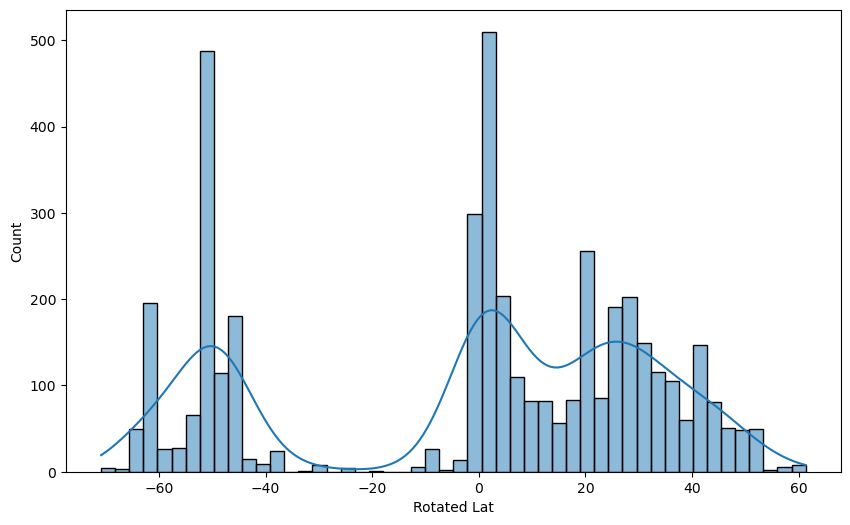

In [711]:
# That seems like a very large std relative to the mean, so let's graph the distribution of 'paleolat'
# Histogram, y axis = count, x axis = paleolat
import matplotlib.pyplot as plt
import seaborn as sns
fix, ax = plt.subplots(figsize=(10, 6))
sns.histplot(rep_bdnn['Rotated Lat'], bins=50, kde=True)
plt.show()

In [712]:
rep_bdnn['Rotated Lat'].describe()

count    4247.000000
mean       -1.649635
std        34.773192
min       -70.846200
25%       -46.116400
50%         3.836600
75%        26.462600
max        61.323500
Name: Rotated Lat, dtype: float64

In [713]:
rep_bdnn[rep_bdnn['Rotated Lat'] < -70]

id  Rotated Lat  Rotated Lon           genus taxon_environment  \
2169  2242     -70.3503     -22.9388      Mesosaurus            marine   
2665  1746     -70.8462     123.5821  Tasmaniosaurus       terrestrial   

      age_max  age_min  
2169  290.100    283.5  
2665  251.902    251.2

In [714]:
syn_bdnn['Rotated Lat'].describe()

count    3353.000000
mean      -34.660461
std        37.792281
min       -67.429000
25%       -60.880700
50%       -49.477100
75%        -1.185500
max        62.825200
Name: Rotated Lat, dtype: float64

In [715]:
tem_bdnn['Rotated Lat'].describe()

count    2229.000000
mean      -18.511736
std       561.065379
min     -9999.000000
25%         1.353100
50%        14.567700
75%        39.721600
max        74.642100
Name: Rotated Lat, dtype: float64

Clearly all three datasets have "-9999" in several rows of the 'Rotated Lat' and "Rotated Lng" columns. Reached out to Alex about this, because there is data available in the 'lng' and 'lat' columns, but he says to just drop them

*Actually, all three datasets ORIGINALLY had -9999's, but I did this section BEFORE the "Prepping DeepDive columns" section above this section. The story:

- I started off by writing this section
- In this section, I saved off the id's of rows that had -9999 values as "reptilia_bdnn_dropped_ids.csv", etc.
- Then I inserted the "Prepping DeepDive columns" notebook section above this one
- In that DeepDive section, I loaded in those problematic row id's ("reptilia_bdnn_dropped_ids.csv") 
- Then in that DeepDive section, I dropped rows that had those id's from the DeepDive datasets
- When I re-ran the full notebook, the dataframes that came to this section had already gone through the cleaning from the DeepDive section
- So now this section's dataframes are free of problematic Rotated Lat values

In [716]:
# Need to get the id's of the rows that we're dropping so I can go back and drop these same rows from DeepDive
# These are called the same thing in the DeepDive section
rep_bdnn_dropped_ids = rep_bdnn[rep_bdnn['Rotated Lat'] == -9999.0000]['id']
syn_bdnn_dropped_ids = syn_bdnn[syn_bdnn['Rotated Lat'] == -9999.0000]['id']
tem_bdnn_dropped_ids = tem_bdnn[tem_bdnn['Rotated Lat'] == -9999.0000]['id']
rep_bdnn_dropped_ids

Series([], Name: id, dtype: int64)

In [717]:
# I have to go back and drop these rows from the DeepDive datasets
# But since this section is after the DeepDive section, That means I'll run into an error the next time I try to run this nb in order
# , so I'll save these id's off as csv's so that I can load them in and run the DeepDive stuff first the next time I run this nb
rep_bdnn_dropped_ids.to_csv('reptilia_processed_data/reptilia_bdnn_dropped_ids.csv')
syn_bdnn_dropped_ids.to_csv('synapsida_processed_data/synapsida_bdnn_dropped_ids.csv')
tem_bdnn_dropped_ids.to_csv('temnospondyli_processed_data/temnospondyli_bdnn_dropped_ids.csv')

PermissionError: [Errno 13] Permission denied: 'reptilia_processed_data/reptilia_bdnn_dropped_ids.csv'

In [336]:
rep_bdnn_dropped = rep_bdnn[rep_bdnn['Rotated Lat'] != -9999.0000]
rep_bdnn_dropped['Rotated Lat'].describe()

count    4247.000000
mean       -1.649635
std        34.773192
min       -70.846200
25%       -46.116400
50%         3.836600
75%        26.462600
max        61.323500
Name: Rotated Lat, dtype: float64

In [337]:
rep_bdnn_dropped['Rotated Lon'].describe()

count    4247.000000
mean        1.843582
std        44.310370
min       -85.215200
25%       -36.588700
50%        -4.655400
75%        20.989100
max       152.608500
Name: Rotated Lon, dtype: float64

In [338]:
# Checking to that the correct number of rows were dropped
rep_bdnn.shape, rep_bdnn_dropped.shape, rep_bdnn[rep_bdnn['Rotated Lat'] == -9999.0000].shape

((4271, 7), (4247, 7), (24, 7))

In [339]:
syn_bdnn_dropped = syn_bdnn[syn_bdnn['Rotated Lat'] != -9999.0000]
syn_bdnn_dropped['Rotated Lat'].describe()

count    3353.000000
mean      -34.660461
std        37.792281
min       -67.429000
25%       -60.880700
50%       -49.477100
75%        -1.185500
max        62.825200
Name: Rotated Lat, dtype: float64

In [340]:
syn_bdnn_dropped['Rotated Lon'].describe()

count    3353.000000
mean       -5.783020
std        29.052976
min       -50.240600
25%       -19.334200
50%       -14.725000
75%         9.627300
max       121.703400
Name: Rotated Lon, dtype: float64

In [341]:
syn_bdnn.shape, syn_bdnn_dropped.shape, syn_bdnn[syn_bdnn['Rotated Lat'] == -9999.0000].shape

((3355, 7), (3353, 7), (2, 7))

In [342]:
tem_bdnn_dropped = tem_bdnn[tem_bdnn['Rotated Lat'] != -9999.0000]
tem_bdnn_dropped['Rotated Lat'].describe()

count    2222.000000
mean       12.929946
std        29.203648
min       -70.949200
25%         1.353100
50%        14.567700
75%        39.997375
max        74.642100
Name: Rotated Lat, dtype: float64

In [343]:
tem_bdnn.shape, tem_bdnn_dropped.shape, tem_bdnn[tem_bdnn['Rotated Lat'] == -9999.0000].shape

((2229, 7), (2222, 7), (7, 7))

#### Visualizing Lat/Lng

In [344]:
# Function for visualization of the three datasets:

def plot_feature(rep_column, syn_column, tem_column):
    # Create the figure and axes
    fig, axs = plt.subplots(3, 1, figsize=(10, 18))

    # Plot the histograms with KDE for each dataset
    sns.histplot(rep_column, bins=50, kde=True, color='blue', label='reptilia_bdnn', ax=axs[0])
    sns.histplot(syn_column, bins=50, kde=True, color='red', label='synapsida_bdnn', ax=axs[1])
    sns.histplot(tem_column, bins=50, kde=True, color='green', label='temnospondyli_bdnn', ax=axs[2])

    # Add the legends
    axs[0].legend()
    axs[1].legend()
    axs[2].legend()

    # Show the plot
    plt.tight_layout()
    plt.show()

    # Return the figure object
    return fig

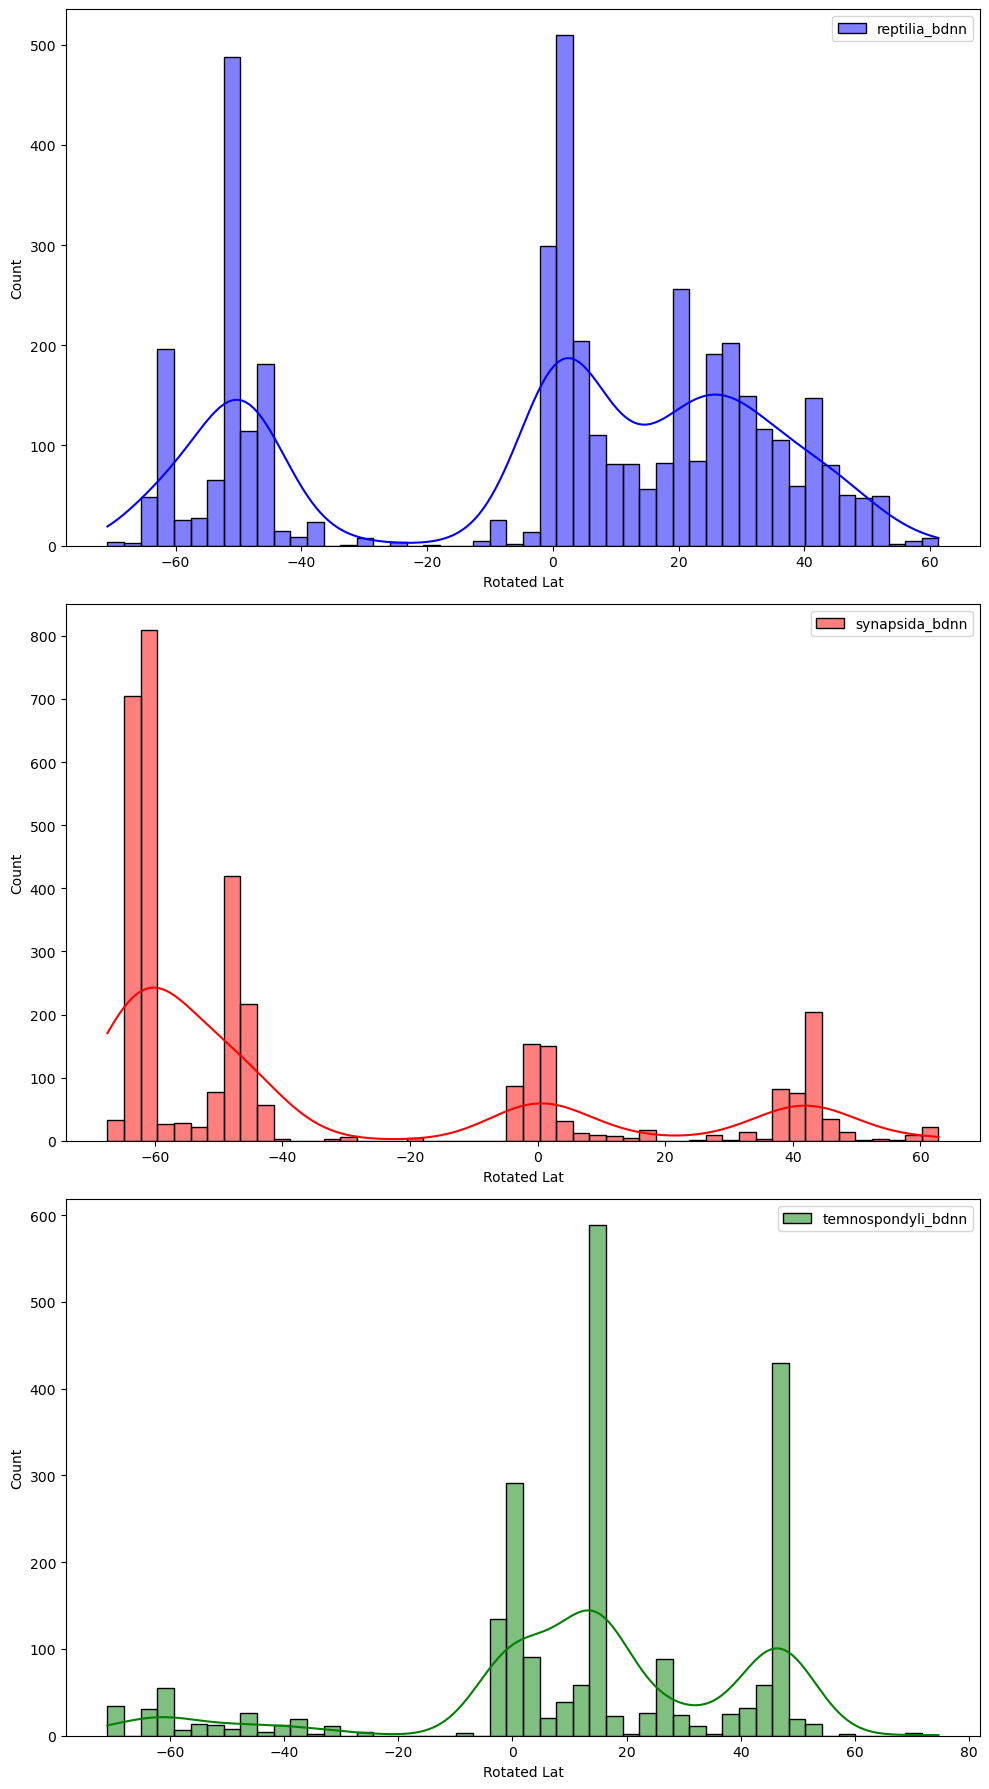

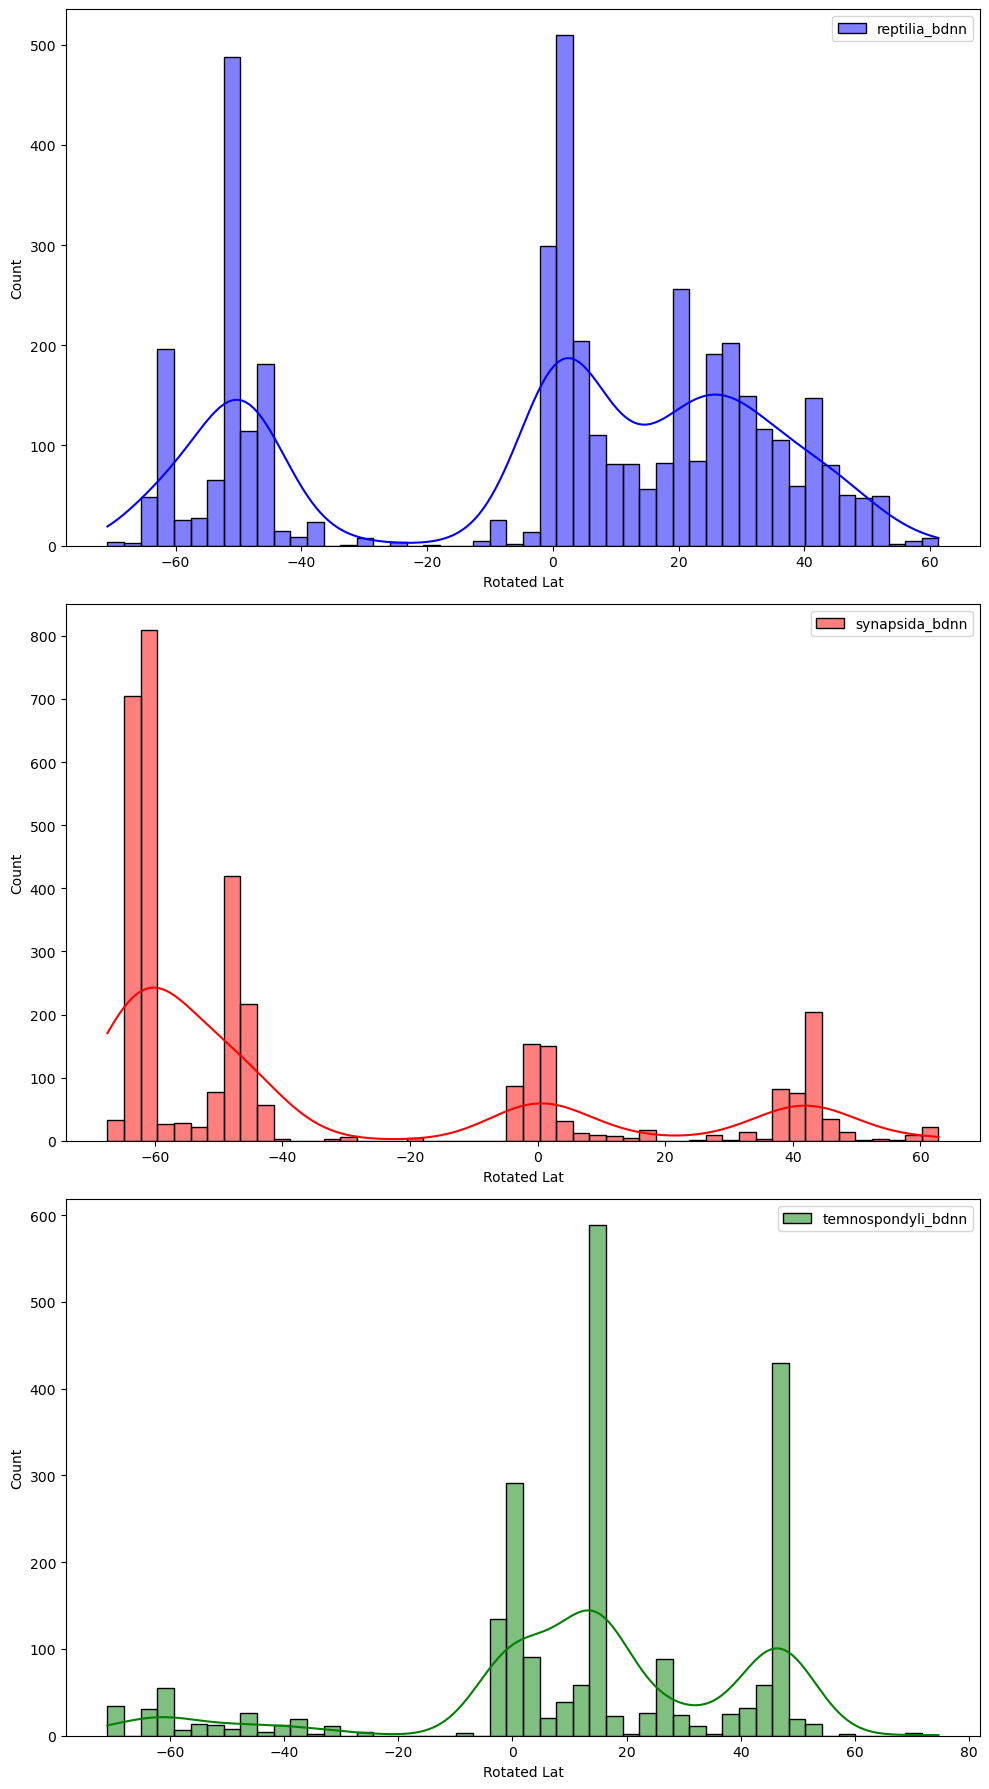

In [ ]:
rotated_lat_plots = plot_feature(rep_bdnn_dropped['Rotated Lat'], syn_bdnn_dropped['Rotated Lat'], tem_bdnn_dropped['Rotated Lat'])
# Save as a pdf
rotated_lat_plots.savefig('predictors_plots/rotated_lat_plots.pdf')
rotated_lat_plots

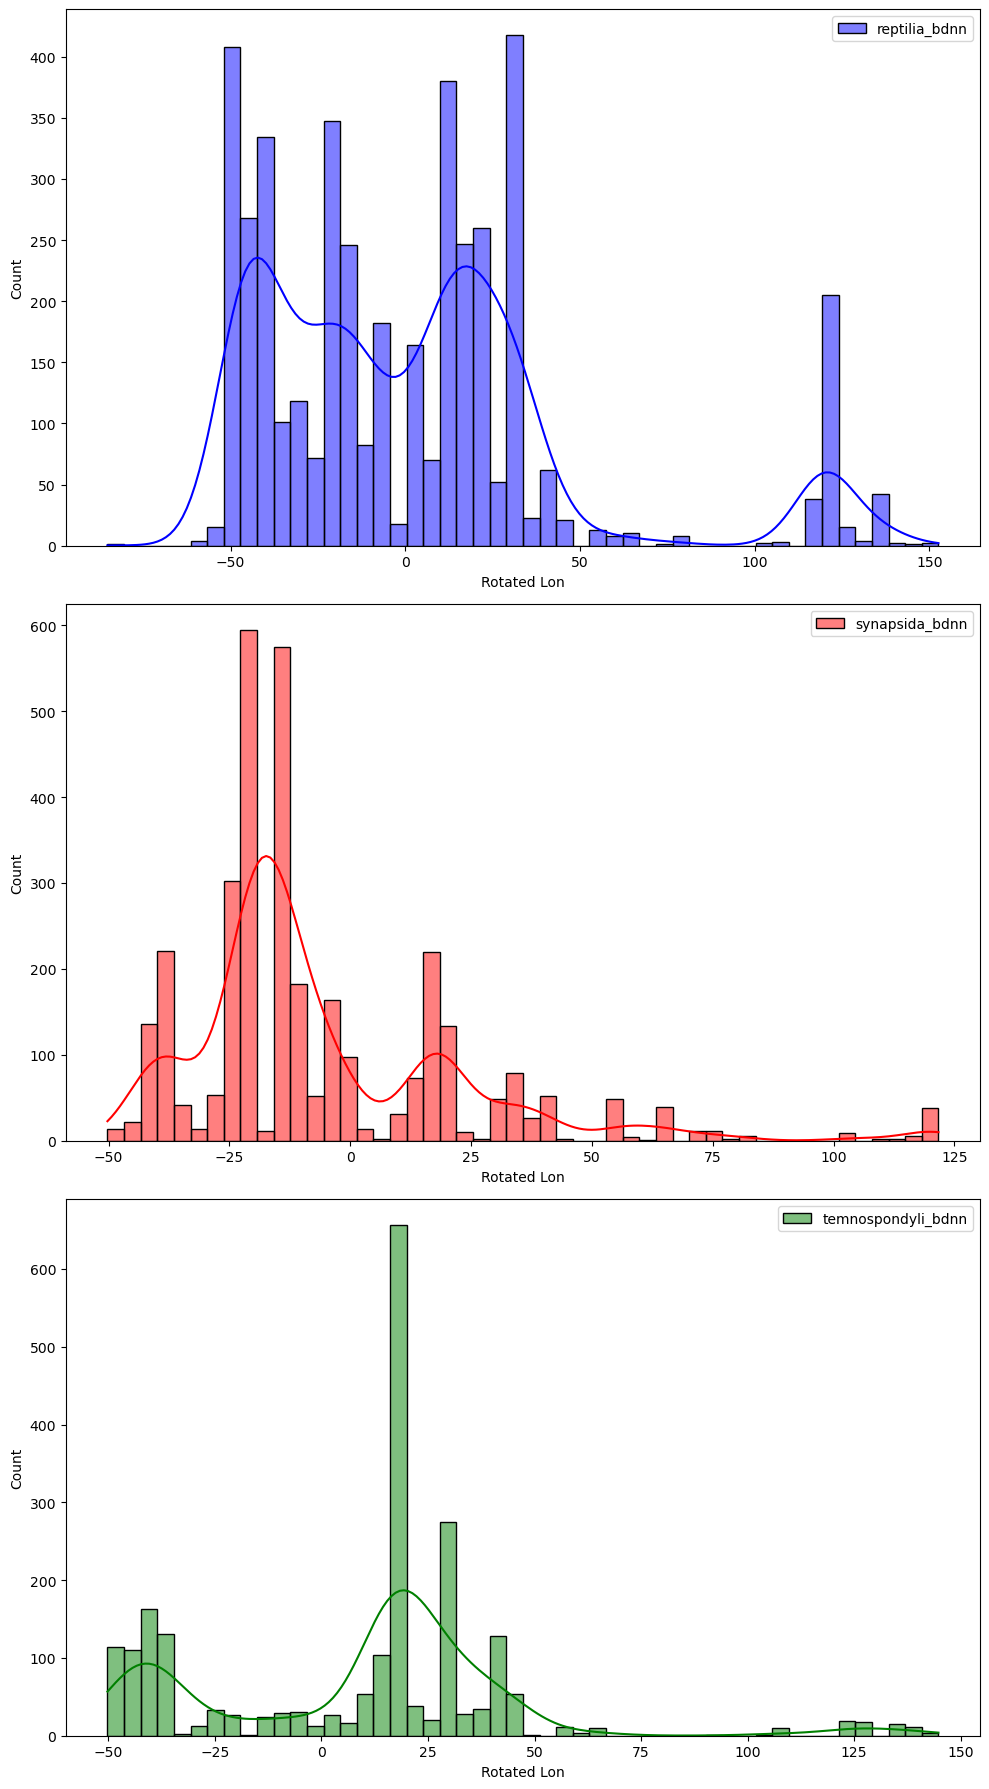

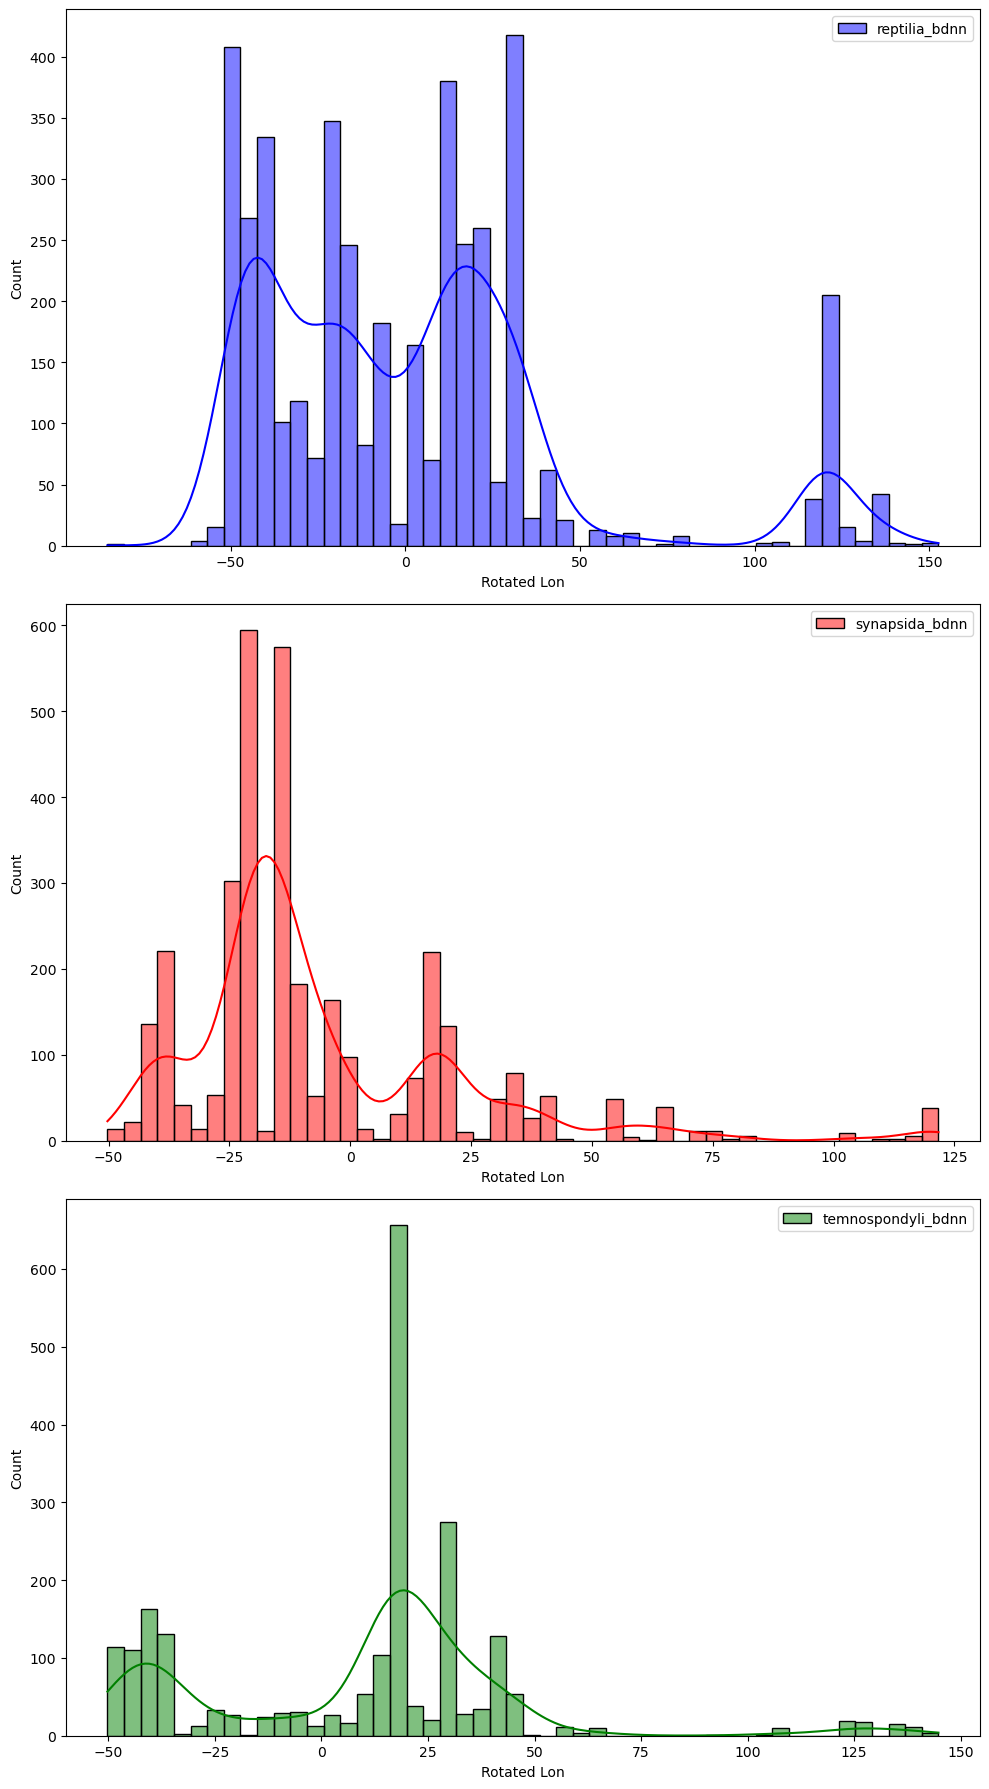

In [ ]:
plot_feature(rep_bdnn_dropped['Rotated Lon'], syn_bdnn_dropped['Rotated Lon'], tem_bdnn_dropped['Rotated Lon'])

In [347]:
rep_bdnn_dropped.head()

id  Rotated Lat  Rotated Lon          genus taxon_environment  age_max  \
0  4411       6.7390     -20.6269    Icarosaurus       terrestrial  227.000   
1  4410       6.7390     -20.6269       Rutiodon       terrestrial  227.000   
2  4409      35.9688       2.1884  Kuehneosuchus       terrestrial  208.500   
3  4408      35.9688       2.1884  Kuehneosaurus       terrestrial  208.500   
4  4407     -62.6208     -11.8191    Procolophon       terrestrial  251.902   

   age_min  
0    208.5  
1    208.5  
2    201.4  
3    201.4  
4    247.2

In [348]:
rep_final.columns

Index(['occurrence_no_x', 'locality', 'county_original', 'state', 'cc',
       'notes', 'id', 'genus', 'age_max', 'age_min', 'Rotated Lat',
       'Rotated Lon'],
      dtype='object')

In [349]:
rep_final[rep_final['genus'] == "Clevosaurs"]

Empty DataFrame
Columns: [occurrence_no_x, locality, county_original, state, cc, notes, id, genus, age_max, age_min, Rotated Lat, Rotated Lon]
Index: []

In [350]:
tableau_rep = pd.merge(rep_bdnn_dropped[['id', 'Rotated Lat', 'Rotated Lon', 'genus']], rep_final[['id', 'locality']], on='id', how='left')
tableau_rep.shape, rep_bdnn_dropped.shape, rep_final.shape

((4247, 5), (4247, 7), (4271, 12))

In [351]:
tableau_rep.to_csv('reptilia_processed_data/reptilia_tableau.csv', index=False)

In [352]:
tableau_syn = pd.merge(syn_bdnn_dropped[['id', 'Rotated Lat', 'Rotated Lon', 'genus']], syn_final[['id', 'locality']], on='id', how='left')
tableau_syn.shape, syn_bdnn_dropped.shape, syn_final.shape

((3353, 5), (3353, 7), (3355, 12))

In [353]:
tableau_syn.to_csv('synapsida_processed_data/synapsida_tableau.csv', index=False)


In [354]:
tableau_tem = pd.merge(tem_bdnn_dropped[['id', 'Rotated Lat', 'Rotated Lon', 'genus']], tem_cleaned_filtered[['id', 'locality']], on='id', how='left')
tableau_tem.shape, tem_bdnn_dropped.shape, tem_cleaned_filtered.shape

((2222, 5), (2222, 7), (2229, 12))

In [355]:
tableau_tem.to_csv('temnospondyli_processed_data/temnospondyli_tableau.csv', index=False)

#### Starting Backscale.txt's

In [356]:
rep_backscale = pd.DataFrame({"rotated_lat_scaled": [rep_bdnn_dropped['Rotated Lat'].mean(), rep_bdnn_dropped['Rotated Lat'].std()], "rotated_lon_scaled": [rep_bdnn_dropped['Rotated Lon'].mean(), rep_bdnn_dropped['Rotated Lon'].std()]})
syn_backscale = pd.DataFrame({"rotated_lat_scaled": (syn_bdnn_dropped['Rotated Lat'].mean(), syn_bdnn_dropped['Rotated Lat'].std()), "rotated_lon_scaled": (syn_bdnn_dropped['Rotated Lon'].mean(), syn_bdnn_dropped['Rotated Lon'].std())})
tem_backscale = pd.DataFrame({"rotated_lat_scaled": (tem_bdnn_dropped['Rotated Lat'].mean(), tem_bdnn_dropped['Rotated Lat'].std()), "rotated_lon_scaled": (tem_bdnn_dropped['Rotated Lon'].mean(), tem_bdnn_dropped['Rotated Lon'].std())})
rep_backscale, syn_backscale, tem_backscale


(   rotated_lat_scaled  rotated_lon_scaled
 0           -1.649635            1.843582
 1           34.773192           44.310370,
    rotated_lat_scaled  rotated_lon_scaled
 0          -34.660461           -5.783020
 1           37.792281           29.052976,
    rotated_lat_scaled  rotated_lon_scaled
 0           12.929946            9.319296
 1           29.203648           36.968738)

In [357]:
# Checking that the mean and std values are correct in the backscale dfs above
rep_bdnn_dropped.describe()

id  Rotated Lat  Rotated Lon      age_max      age_min
count  4247.000000  4247.000000  4247.000000  4247.000000  4247.000000
mean   2228.908641    -1.649635     1.843582   241.247062   231.992255
std    1276.333894    34.773192    44.310370    23.353718    25.480204
min       1.000000   -70.846200   -85.215200   201.400000   199.500000
25%    1106.500000   -46.116400   -36.588700   227.000000   208.500000
50%    2263.000000     3.836600    -4.655400   239.700000   237.000000
75%    3332.500000    26.462600    20.989100   254.140000   251.902000
max    4411.000000    61.323500   152.608500   298.900000   293.520000

In [358]:
# Not saving backscale text off yet, b/c don't know final name of predictors + need to add environmental predictor
# Data in (env_vars and 1myr_temp dataframes)


# rep_backscale.to_csv('reptilia_processed_data/reptilia_backscale.txt', sep='\t', index=False)
# syn_backscale.to_csv('synapsida_processed_data/synapsida_backscale.txt', sep='\t', index=False)
# tem_backscale.to_csv('temnospondyli_processed_data/temnospondyli_backscale.txt', sep='\t', index=False)

#### StandardScaler

In [359]:
from sklearn.preprocessing import StandardScaler

scaler_rep_lat = StandardScaler()
rep_bdnn_dropped['rotated_lat_scaled'] = scaler_rep_lat.fit_transform(rep_bdnn_dropped[['Rotated Lat']]).round(2)

scaler_rep_lng = StandardScaler()
rep_bdnn_dropped['rotated_lon_scaled'] = scaler_rep_lng.fit_transform(rep_bdnn_dropped[['Rotated Lon']]).round(2)

scaler_syn_lat = StandardScaler()
syn_bdnn_dropped['rotated_lat_scaled'] = scaler_syn_lat.fit_transform(syn_bdnn_dropped[['Rotated Lat']]).round(2)

scaler_syn_lng = StandardScaler()
syn_bdnn_dropped['rotated_lon_scaled'] = scaler_syn_lng.fit_transform(syn_bdnn_dropped[['Rotated Lon']]).round(2)

scaler_tem_lat = StandardScaler()
tem_bdnn_dropped['rotated_lat_scaled'] = scaler_tem_lat.fit_transform(tem_bdnn_dropped[['Rotated Lat']]).round(2)

scaler_tem_lng = StandardScaler()
tem_bdnn_dropped['rotated_lon_scaled'] = scaler_tem_lng.fit_transform(tem_bdnn_dropped[['Rotated Lon']]).round(2)


C:\Users\SimoesLabAdmin\AppData\Local\Temp\ipykernel_3412\3716951458.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rep_bdnn_dropped['rotated_lat_scaled'] = scaler_rep_lat.fit_transform(rep_bdnn_dropped[['Rotated Lat']]).round(2)
C:\Users\SimoesLabAdmin\AppData\Local\Temp\ipykernel_3412\3716951458.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rep_bdnn_dropped['rotated_lon_scaled'] = scaler_rep_lng.fit_transform(rep_bdnn_dropped[['Rotated Lon']]).round(2)
C:\Users\SimoesLabAdmin\AppData\Local\Temp

In [360]:
rep_bdnn_dropped

id  Rotated Lat  Rotated Lon             genus taxon_environment  \
0     4411       6.7390     -20.6269       Icarosaurus       terrestrial   
1     4410       6.7390     -20.6269          Rutiodon       terrestrial   
2     4409      35.9688       2.1884     Kuehneosuchus       terrestrial   
3     4408      35.9688       2.1884     Kuehneosaurus       terrestrial   
4     4407     -62.6208     -11.8191       Procolophon       terrestrial   
...    ...          ...          ...               ...               ...   
4406     5     -47.4217     -18.3424       Eohyosaurus       terrestrial   
4407     4     -47.4217     -18.3424        Mesosuchus       terrestrial   
4408     3     -47.4217     -18.3424        Mesosuchus       terrestrial   
4409     2     -47.4217     -18.3424        Mesosuchus       terrestrial   
4410     1     -47.4217     -18.3424  Stenaulorhynchus       terrestrial   

      age_max  age_min  rotated_lat_scaled  rotated_lon_scaled  
0     227.000    208.5                0.24               -0.51  
1     227.000    208.5                0.24               -0.51  
2     208.500    201.4                1.08                0.01  
3     208.500    201.4                1.08                0.01  
4     251.902    247.2               -1.75               -0.31  
...       ...      ...                 ...                 ...  
4406  247.200    242.0               -1.32               -0.46  
4407  247.200    242.0               -1.32               -0.46  
4408  247.200    242.0               -1.32               -0.46  
4409  247.200    242.0               -1.32               -0.46  
4410  247.200    242.0               -1.32               -0.46  

[4247 rows x 9 columns]

In [361]:
tem_bdnn_dropped

id  Rotated Lat  Rotated Lon         genus  \
0     2247       4.6147     -41.8361    Anconastes   
1     2246       1.0593     -36.5887   Broiliellus   
2     2245      -0.5219     -37.7808   Broiliellus   
3     2244      -2.9808     -38.7628        Eryops   
4     2243      -2.9808     -38.7628  Aspidosaurus   
...    ...          ...          ...           ...   
2242     5     -46.3881     -25.2811   Rastosuchus   
2243     4     -46.3881     -25.2811   Rastosuchus   
2244     3     -46.3881     -25.2811   Rastosuchus   
2245     2     -46.1164      -4.6554  Compsocerops   
2246     1     -46.1164      -4.6554  Compsocerops   

                    taxon_environment  age_max  age_min  rotated_lat_scaled  \
0     brackish,freshwater,terrestrial    305.9   298.90               -0.28   
1     brackish,freshwater,terrestrial    283.5   273.01               -0.41   
2     brackish,freshwater,terrestrial    298.9   286.10               -0.46   
3     brackish,freshwater,terrestrial    290.1   283.50               -0.54   
4     brackish,freshwater,terrestrial    290.1   283.50               -0.54   
...                               ...      ...      ...                 ...   
2242                              NaN    266.9   264.30               -2.03   
2243                              NaN    266.9   264.30               -2.03   
2244                              NaN    266.9   264.30               -2.03   
2245                              NaN    227.0   208.50               -2.02   
2246                              NaN    227.0   208.50               -2.02   

      rotated_lon_scaled  
0                  -1.38  
1                  -1.24  
2                  -1.27  
3                  -1.30  
4                  -1.30  
...                  ...  
2242               -0.94  
2243               -0.94  
2244               -0.94  
2245               -0.38  
2246               -0.38  

[2222 rows x 9 columns]

In [362]:
rep_bdnn_dropped.describe()

id  Rotated Lat  Rotated Lon      age_max      age_min  \
count  4247.000000  4247.000000  4247.000000  4247.000000  4247.000000   
mean   2228.908641    -1.649635     1.843582   241.247062   231.992255   
std    1276.333894    34.773192    44.310370    23.353718    25.480204   
min       1.000000   -70.846200   -85.215200   201.400000   199.500000   
25%    1106.500000   -46.116400   -36.588700   227.000000   208.500000   
50%    2263.000000     3.836600    -4.655400   239.700000   237.000000   
75%    3332.500000    26.462600    20.989100   254.140000   251.902000   
max    4411.000000    61.323500   152.608500   298.900000   293.520000   

       rotated_lat_scaled  rotated_lon_scaled  
count         4247.000000         4247.000000  
mean             0.000716            0.000031  
std              0.999710            1.000576  
min             -1.990000           -1.960000  
25%             -1.280000           -0.870000  
50%              0.160000           -0.150000  
75%              0.810000            0.430000  
max              1.810000            3.400000

In [363]:
# Renaming 'Rotated Lat' to 'rotated_lat_scaled' in backscale dataframe
rep_backscale.rename(columns={'Rotated Lat': 'rotated_lat_scaled', 'Rotated Lon': 'rotated_lon_scaled'}, inplace=True)
syn_backscale.rename(columns={'Rotated Lat': 'rotated_lat_scaled', 'Rotated Lon': 'rotated_lon_scaled'}, inplace=True)
tem_backscale.rename(columns={'Rotated Lat': 'rotated_lat_scaled', 'Rotated Lon': 'rotated_lon_scaled'}, inplace=True)
rep_backscale

rotated_lat_scaled  rotated_lon_scaled
0           -1.649635            1.843582
1           34.773192           44.310370

### Visualizing Scaled Lat/Lng

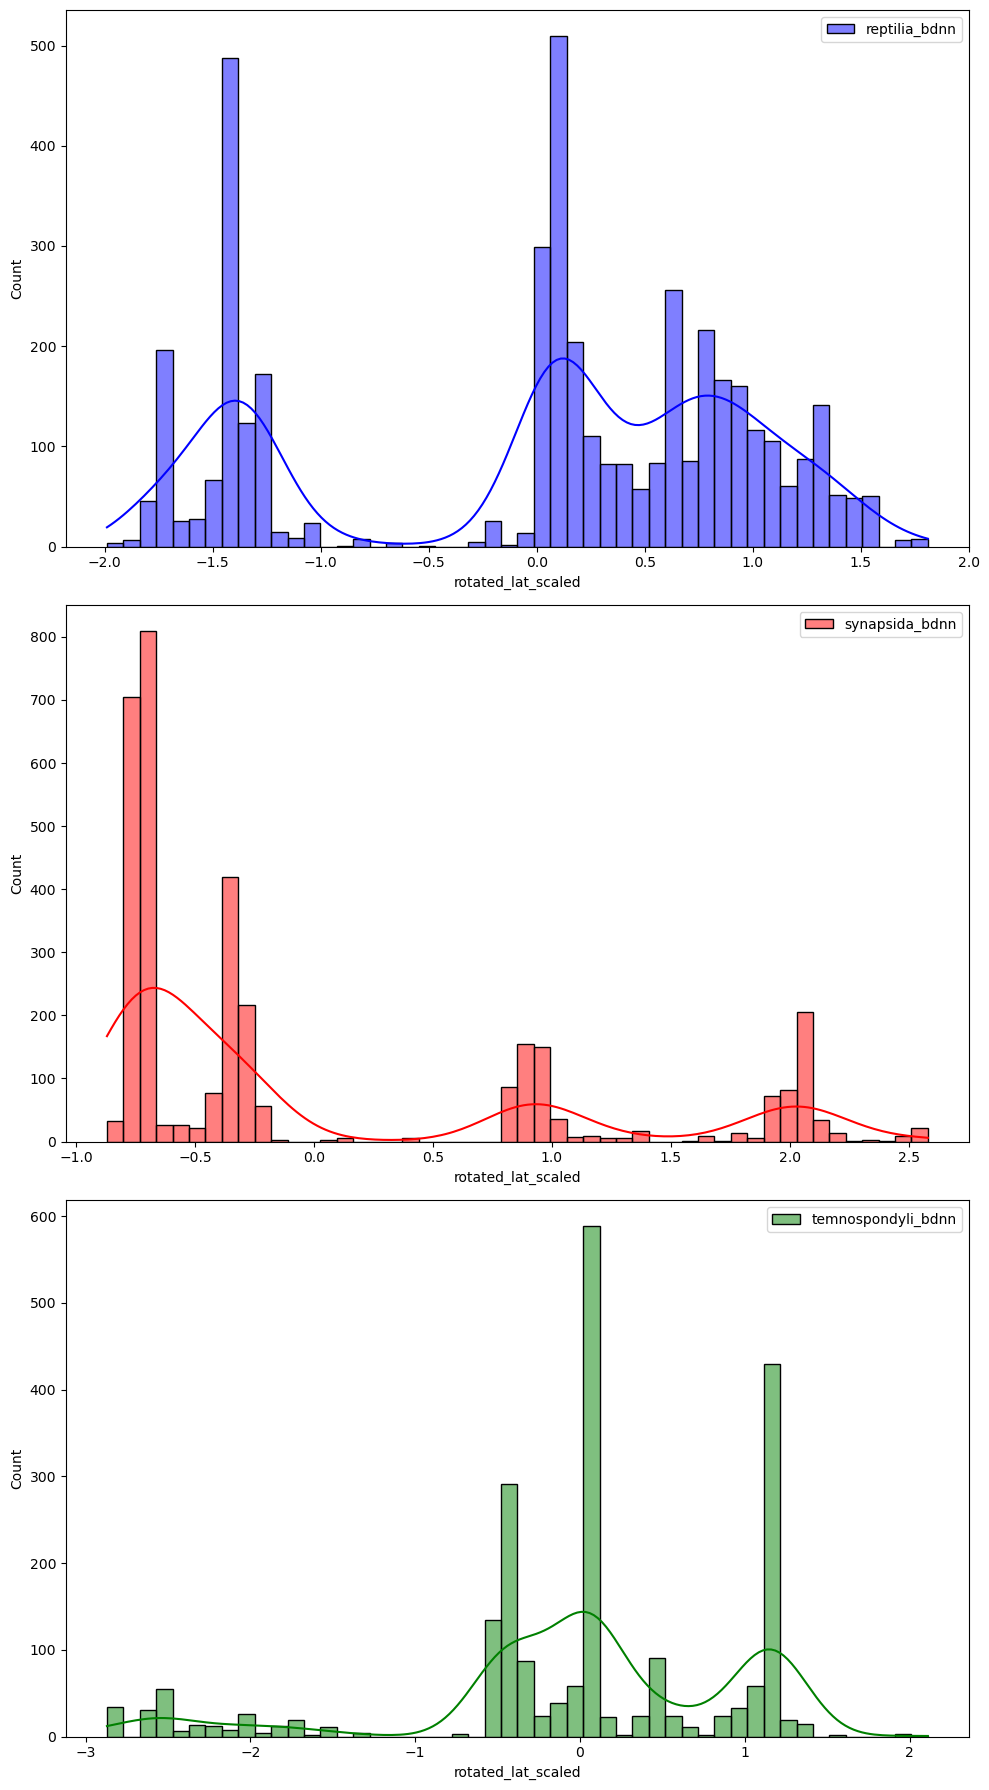

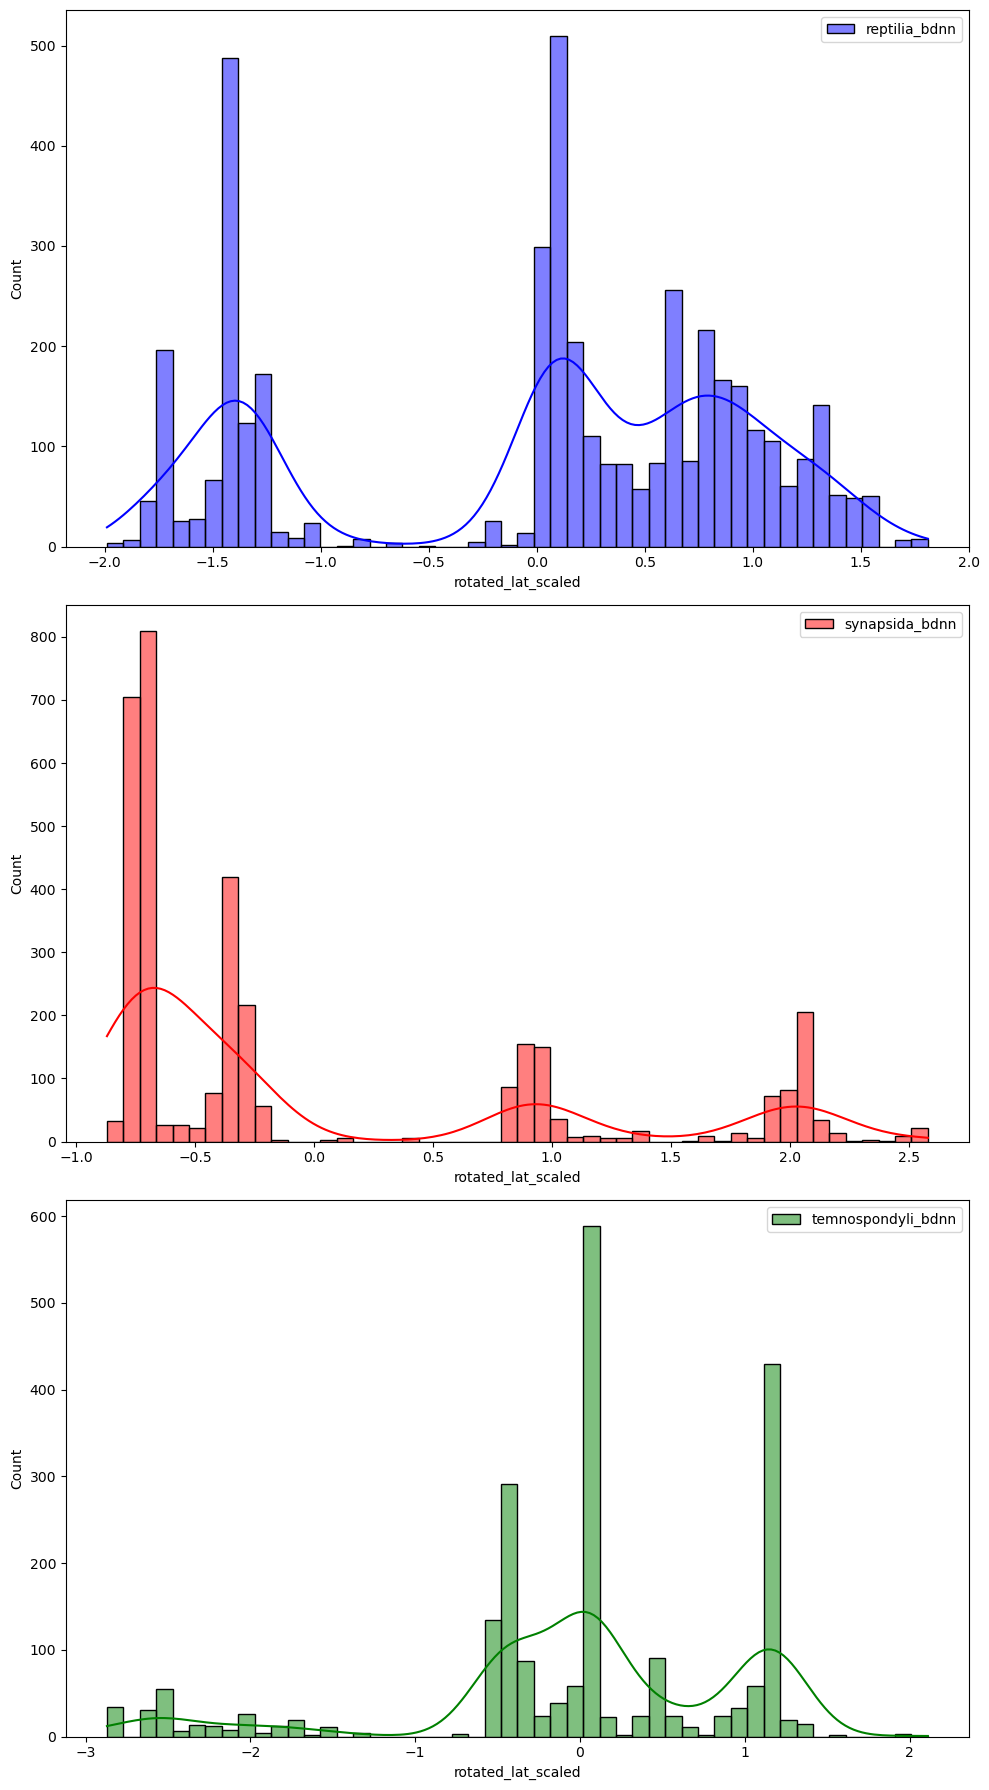

In [ ]:
rotated_lat_scaled_plots = plot_feature(rep_bdnn_dropped['rotated_lat_scaled'], syn_bdnn_dropped['rotated_lat_scaled'], tem_bdnn_dropped['rotated_lat_scaled'])
rotated_lat_scaled_plots.savefig('predictors_plots/rotated_lat_standardscaled_plots.pdf')
rotated_lat_scaled_plots


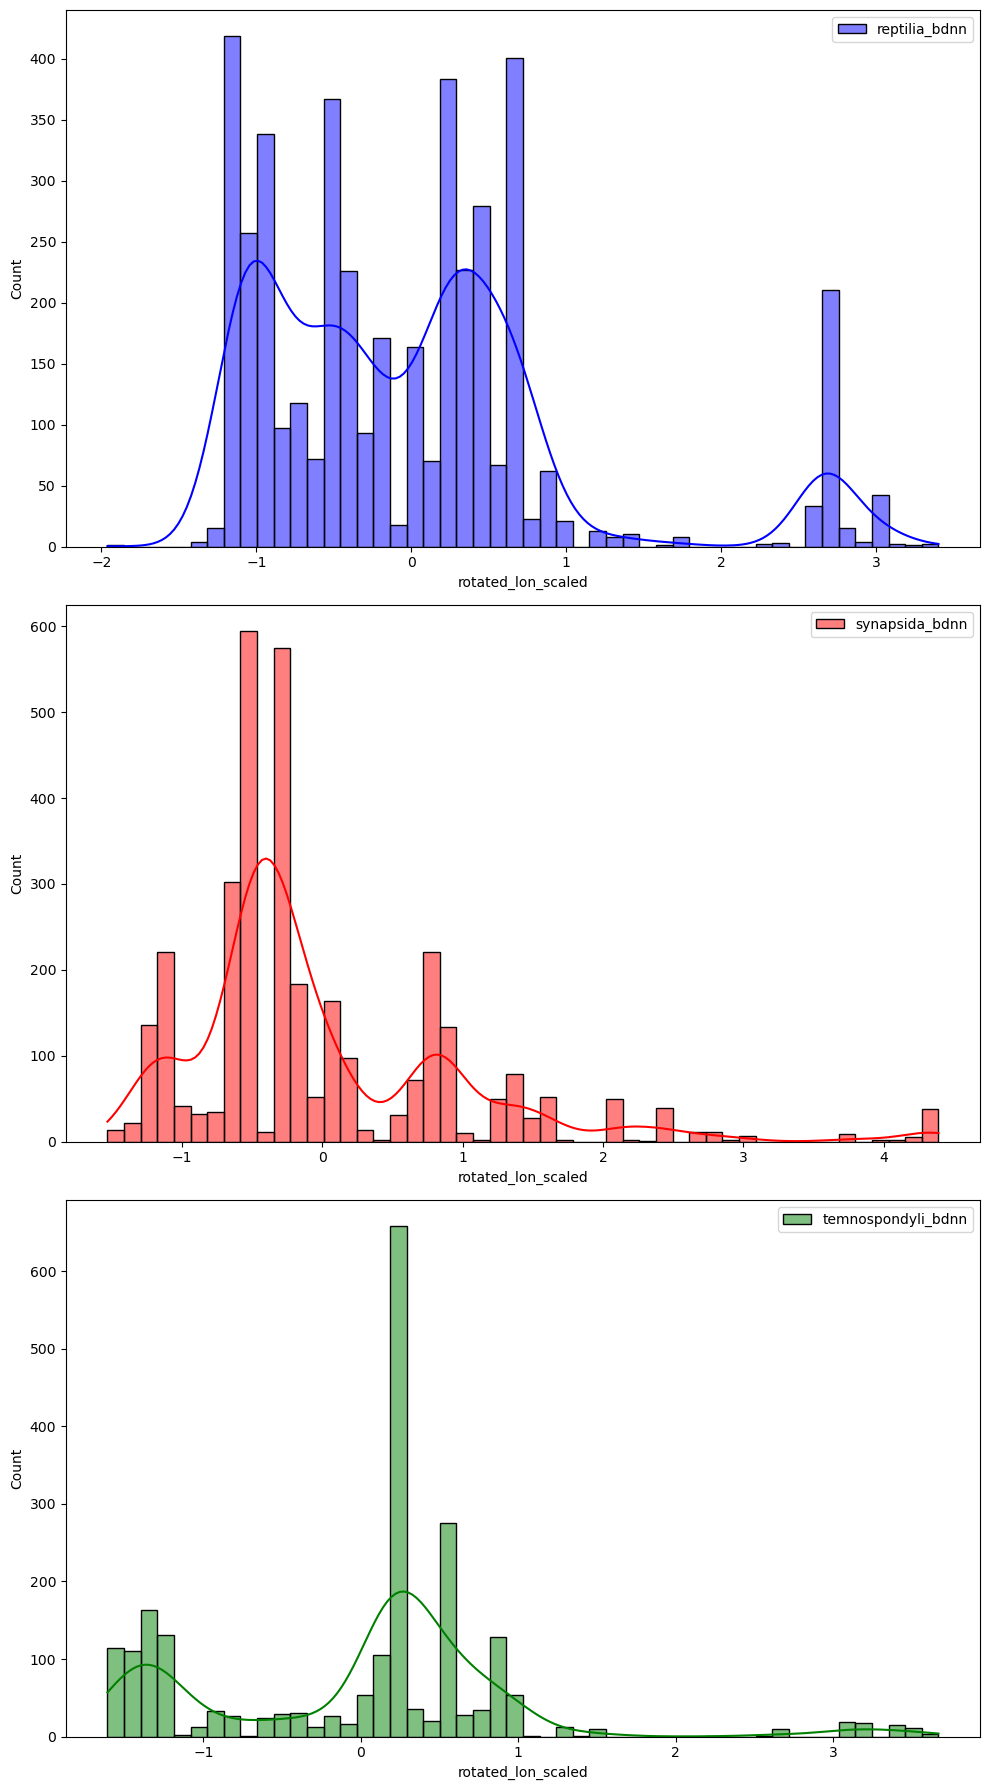

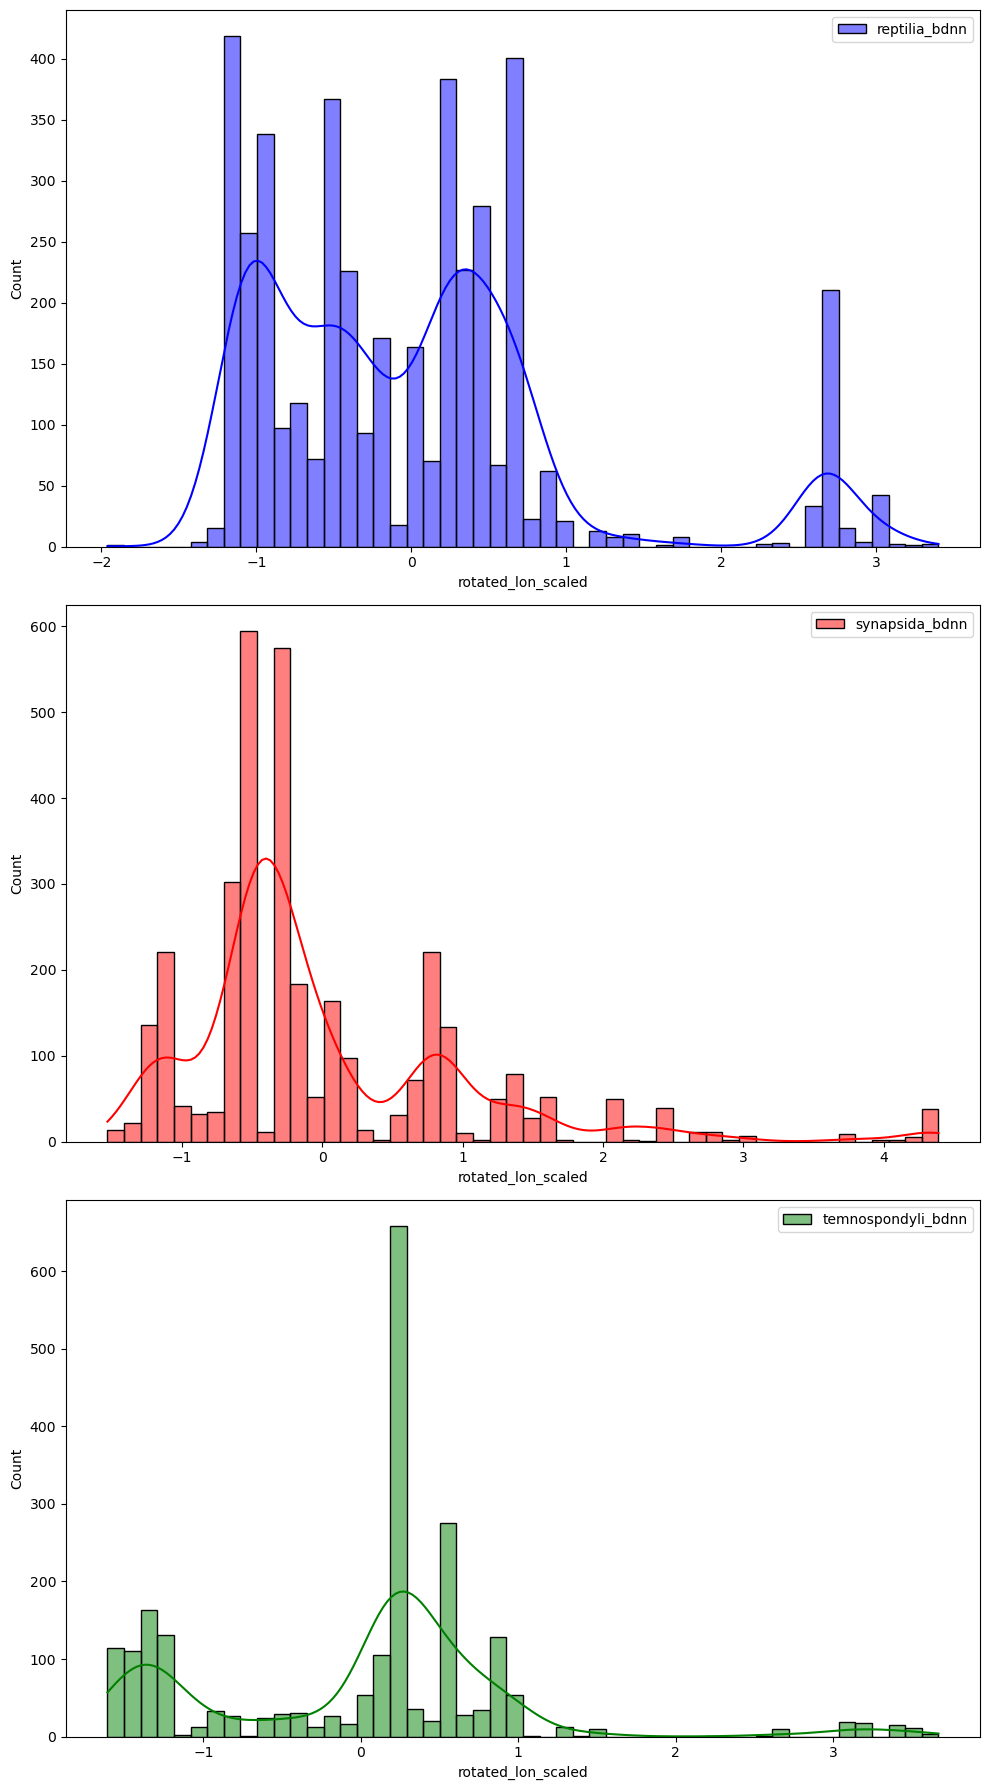

In [ ]:
plot_feature(rep_bdnn_dropped['rotated_lon_scaled'], syn_bdnn_dropped['rotated_lon_scaled'], tem_bdnn_dropped['rotated_lon_scaled'])

## New Genera by Latitude

#### EDA Coords Standard Deviation

In [366]:
# PyRate only takes SPECIES specific traits, not OCCURRENCE specific traits, so lat and lng need to be averaged by "genus" column
# Grouping by genus and getting std values to see if lat and lng values for each genus have a lot of variance
# If there is a lot of variance, it might not be justifiable to average the lat and lng values
rep_bdnn_stds = rep_bdnn_dropped[['rotated_lat_scaled', 'rotated_lon_scaled', 'genus']].groupby('genus').std()
rep_bdnn_stds

rotated_lat_scaled  rotated_lon_scaled
genus                                                     
Abyssomedon                        NaN                 NaN
Acadiella                          NaN                 NaN
Acaenasuchus                  0.000000            0.000000
Acallosuchus                       NaN                 NaN
Acerosodontosaurus                 NaN                 NaN
...                                ...                 ...
Yunguisaurus                  0.000000            0.000000
Yunnanosaurus                 0.000000            0.000000
Zanclodon                     0.112339            0.142829
Zhongjiania                   0.000000            0.000000
Zupaysaurus                        NaN                 NaN

[686 rows x 2 columns]

In [367]:
# Saving off only those with std > 0
lat_stds = rep_bdnn_stds[rep_bdnn_stds['rotated_lat_scaled'] > 0]
lon_stds = rep_bdnn_stds[rep_bdnn_stds['rotated_lon_scaled'] > 0]

In [368]:
lat_stds.equals(lon_stds)

False

In [369]:
# Looking at std's that are > 0, largest to smallest
lat_stds.sort_values('rotated_lat_scaled', ascending=False)


rotated_lat_scaled  rotated_lon_scaled
genus                                                     
Garjainia                     1.576710            0.564351
Procolophonichnium            1.420282            0.496521
Tetrasauropus                 1.368320            0.658179
Teratosaurus                  1.235570            0.653911
Proterosuchus                 1.108144            0.705648
...                                ...                 ...
Uatchitodon                   0.005774            0.320468
Krzyzanowskisaurus            0.005774            0.046188
Hemilopas                     0.005774            0.011547
Kintneria                     0.005000            0.030000
Lotosaurus                    0.003015            0.024121

[235 rows x 2 columns]

In [370]:
lat_stds[lat_stds.index == 'Clevosaurus']

rotated_lat_scaled  rotated_lon_scaled
genus                                              
Clevosaurus            1.079502            0.462314

These are all fairly large std's. I need one coord value per species, so I'll have to average out the lat and lon values across all occurrences of the same species. However, if one species has a wide range of lat and lon values (as indicated by high std), that might not be justifiable. Need to do some EDA below

In [371]:
rep_bdnn_dropped[rep_bdnn_dropped['genus'] == 'Garjainia']

id  Rotated Lat  Rotated Lon      genus taxon_environment  age_max  \
1968  2443      46.9132      47.1091  Garjainia       terrestrial    251.2   
2313  2098      48.3133      44.0363  Garjainia       terrestrial    251.2   
2742  1669     -58.7619      -5.3084  Garjainia       terrestrial    248.9   
3588   823     -58.7619      -5.3084  Garjainia       terrestrial    251.2   
3589   822     -58.7619      -5.3084  Garjainia       terrestrial    251.2   
3590   821     -58.7619      -5.3084  Garjainia       terrestrial    251.2   
3591   820     -58.7619      -5.3084  Garjainia       terrestrial    251.2   
3592   819     -58.7619      -5.3084  Garjainia       terrestrial    251.2   
3593   818     -58.7619      -5.3084  Garjainia       terrestrial    251.2   
3594   817     -60.6853       0.0780  Garjainia       terrestrial    251.2   
3767   644      48.3133      44.0363  Garjainia       terrestrial    248.9   
3768   643      48.3133      44.0363  Garjainia       terrestrial    248.9   
3769   642      48.3133      44.0363  Garjainia       terrestrial    248.9   
3770   641      48.3133      44.0363  Garjainia       terrestrial    248.9   
3771   640      48.3133      44.0363  Garjainia       terrestrial    248.9   
3772   639      48.3133      44.0363  Garjainia       terrestrial    248.9   
3773   638      48.3133      44.0363  Garjainia       terrestrial    248.9   
3774   637      48.3133      44.0363  Garjainia       terrestrial    248.9   

      age_min  rotated_lat_scaled  rotated_lon_scaled  
1968    247.2                1.40                1.02  
2313    247.2                1.44                0.95  
2742    247.2               -1.64               -0.16  
3588    247.2               -1.64               -0.16  
3589    247.2               -1.64               -0.16  
3590    247.2               -1.64               -0.16  
3591    247.2               -1.64               -0.16  
3592    247.2               -1.64               -0.16  
3593    247.2               -1.64               -0.16  
3594    247.2               -1.70               -0.04  
3767    247.2                1.44                0.95  
3768    247.2                1.44                0.95  
3769    247.2                1.44                0.95  
3770    247.2                1.44                0.95  
3771    247.2                1.44                0.95  
3772    247.2                1.44                0.95  
3773    247.2                1.44                0.95  
3774    247.2                1.44                0.95

In [372]:
rep_bdnn_dropped[rep_bdnn_dropped['genus'] == 'Clevosaurus'].sort_values('Rotated Lat')

id  Rotated Lat  Rotated Lon        genus taxon_environment  age_max  \
3995   416     -49.4771     -10.0175  Clevosaurus       terrestrial    237.0   
4344    67     -47.3188      -9.0563  Clevosaurus       terrestrial    227.0   
1464  2948     -46.1164      -4.6554  Clevosaurus       terrestrial    227.0   
1461  2945     -46.1164      -4.6554  Clevosaurus       terrestrial    227.0   
1460  2944     -46.1164      -4.6554  Clevosaurus       terrestrial    227.0   
1459  2943     -46.1164      -4.6554  Clevosaurus       terrestrial    227.0   
1458  2942     -46.1164      -4.6554  Clevosaurus       terrestrial    227.0   
1457  2941     -46.1164      -4.6554  Clevosaurus       terrestrial    227.0   
1456  2940     -46.1164      -4.6554  Clevosaurus       terrestrial    227.0   
4351    60     -46.1164      -4.6554  Clevosaurus       terrestrial    227.0   
1465  2949     -46.1164      -4.6554  Clevosaurus       terrestrial    227.0   
1466  2950     -46.1164      -4.6554  Clevosaurus       terrestrial    227.0   
1467  2951     -46.1164      -4.6554  Clevosaurus       terrestrial    227.0   
1468  2952     -46.1164      -4.6554  Clevosaurus       terrestrial    227.0   
1469  2953     -46.1164      -4.6554  Clevosaurus       terrestrial    227.0   
1470  2954     -46.1164      -4.6554  Clevosaurus       terrestrial    227.0   
1471  2955     -46.1164      -4.6554  Clevosaurus       terrestrial    227.0   
2503  1908     -46.1164      -4.6554  Clevosaurus       terrestrial    227.0   
4295   116     -46.1164      -4.6554  Clevosaurus       terrestrial    227.0   
4306   105     -46.1164      -4.6554  Clevosaurus       terrestrial    227.0   
4317    94     -46.1164      -4.6554  Clevosaurus       terrestrial    227.0   
4327    84     -46.1164      -4.6554  Clevosaurus       terrestrial    227.0   
4349    62     -46.1164      -4.6554  Clevosaurus       terrestrial    227.0   
1462  2946     -46.1164      -4.6554  Clevosaurus       terrestrial    227.0   
1463  2947     -46.1164      -4.6554  Clevosaurus       terrestrial    227.0   
4388    23     -36.8230      27.7125  Clevosaurus       terrestrial    227.0   
944   3467      23.7649      -9.2135  Clevosaurus       terrestrial    201.4   
941   3470      23.7649      -9.2135  Clevosaurus       terrestrial    201.4   
940   3471      23.7649      -9.2135  Clevosaurus       terrestrial    201.4   
937   3474      23.7649      -9.2135  Clevosaurus       terrestrial    201.4   
935   3476      23.7649      -9.2135  Clevosaurus       terrestrial    201.4   
932   3479      23.7649      -9.2135  Clevosaurus       terrestrial    201.4   
14    4397      24.9561       4.3648  Clevosaurus       terrestrial    237.0   
20    4391      24.9561       4.3648  Clevosaurus       terrestrial    237.0   
29    4382      24.9561       4.3648  Clevosaurus       terrestrial    237.0   
33    4378      24.9561       4.3648  Clevosaurus       terrestrial    237.0   
37    4374      24.9561       4.3648  Clevosaurus       terrestrial    237.0   
41    4370      24.9561       4.3648  Clevosaurus       terrestrial    237.0   
45    4366      24.9561       4.3648  Clevosaurus       terrestrial    237.0   
7     4404      24.9561       4.3648  Clevosaurus       terrestrial    237.0   
970   3441      24.9561       4.3648  Clevosaurus       terrestrial    237.0   
3482   929      24.9561       4.3648  Clevosaurus       terrestrial    237.0   
3480   931      24.9561       4.3648  Clevosaurus       terrestrial    237.0   
226   4185      24.9561       4.3648  Clevosaurus       terrestrial    237.0   
3658   753      24.9561       4.3648  Clevosaurus       terrestrial    237.0   
4078   333      30.9826      11.6474  Clevosaurus       terrestrial    227.0   
533   3878      32.5932       9.3339  Clevosaurus       terrestrial    216.7   
3484   927      35.9688       2.1884  Clevosaurus       terrestrial    208.5   
2763  1648      35.9688       2.1884  Clevosaurus       terrestrial    208.5   
3657   7

In [373]:
lon_stds.sort_values('rotated_lon_scaled', ascending=False)

rotated_lat_scaled  rotated_lon_scaled
genus                                                  
Utatsusaurus               0.186145            2.484566
Mixosaurus                 0.106515            1.473495
Tholodus                   0.341211            1.395167
Phalarodon                 0.272832            1.309891
Askeptosaurus              0.050332            1.290852
...                             ...                 ...
Eucoelophysis              0.098995            0.007071
Paralonectes               0.023094            0.005774
Barracudasaurus            0.040415            0.005774
Hupehsuchus                0.071554            0.004472
Paraplacodus               0.037796            0.003780

[233 rows x 2 columns]

In [374]:
rep_bdnn_dropped[rep_bdnn_dropped['genus'] == 'Utatsusaurus']

id  Rotated Lat  Rotated Lon         genus taxon_environment  age_max  \
1381  3030      32.0407     152.6085  Utatsusaurus            marine  251.200   
1590  2821      32.0407     152.6085  Utatsusaurus            marine  248.900   
3736   675      17.2920     -46.5877  Utatsusaurus            marine  248.900   
3921   490      31.6180     -40.9603  Utatsusaurus            marine  251.902   
3922   489      30.0552     -57.1861  Utatsusaurus            marine  251.200   

      age_min  rotated_lat_scaled  rotated_lon_scaled  
1381    247.2                0.97                3.40  
1590    247.2                0.97                3.40  
3736    247.2                0.54               -1.09  
3921    248.9                0.96               -0.97  
3922    248.9                0.91               -1.33

Lat and lon values for ~235 species (in reptilia) have standard deviations > 0. To handle this, we're going to 
1. ID any species that have lat and lon values that span > 20 degrees (range > 20)
2. Split those species into several categories

#### EDA Coords By Range

In [ ]:
rep_bdnn_range = rep_bdnn_dropped[['Rotated Lat', 'Rotated Lon', 'genus']].groupby('genus').agg(lat_range=('Rotated Lat', lambda x: x.max() - x.min()), 
                                                                                                lat_min = ('Rotated Lat', lambda x: x.min()), 
                                                                                                lat_max = ('Rotated Lat', lambda x: x.max()),
                                                                                                lon_range=('Rotated Lon', lambda x: x.max() - x.min()),
                                                                                                lon_min = ('Rotated Lon', lambda x: x.min()),
                                                                                                lon_max = ('Rotated Lon', lambda x: x.max()))
rep_bdnn_range

lat_range  lat_min  lat_max  lon_range   lon_min   lon_max
genus                                                                         
Abyssomedon            0.0000  -0.7300  -0.7300     0.0000  -37.6741  -37.6741
Acadiella              0.0000  10.5874  10.5874     0.0000  -11.8909  -11.8909
Acaenasuchus           0.0000   1.3531   1.3531     0.0000  -47.1801  -47.1801
Acallosuchus           0.0000   1.3531   1.3531     0.0000  -47.1801  -47.1801
Acerosodontosaurus     0.0000 -50.0920 -50.0920     0.0000   31.3299   31.3299
...                       ...      ...      ...        ...       ...       ...
Yunguisaurus           0.0000  18.7825  18.7825     0.0000  119.7653  119.7653
Yunnanosaurus          0.0000  52.1412  52.1412     0.0000  136.1873  136.1873
Zanclodon              9.8519  26.1169  35.9688    15.2919    2.1884   17.4803
Zhongjiania            0.0000  32.5837  32.5837     0.0000  118.2352  118.2352
Zupaysaurus            0.0000 -50.4972 -50.4972     0.0000  -22.4201  -22.4201

[686 rows x 6 columns]

In [376]:
rep_bdnn_range[(rep_bdnn_range['lat_range'] > 0) | (rep_bdnn_range['lon_range'] > 0)]

# 235 genera have a range in lat or lon, (which means they have multiple occurrences that have diff coords) so I'll have to average the lat and lon values for these genera
# Explore them first to see if the ranges are too large to justify averaging

lat_range  lat_min  lat_max  lon_range   lon_min   lon_max
genus                                                                      
Aetosauroides      19.2086 -56.0316 -36.8230    57.2441  -29.5316   27.7125
Aetosaurus         12.2457  20.3475  32.5932     2.3135    9.3339   11.6474
Amanasaurus         9.9152 -56.0316 -46.1164    24.4663  -10.0175   14.4488
Ammorhynchus        0.9441   8.5619   9.5060     2.9597  -46.6177  -43.6580
Amotosaurus         4.0874  22.9805  27.0679     3.2667   17.1911   20.4578
...                    ...      ...      ...        ...       ...       ...
Vjushkovisaurus     1.9393  46.8850  48.8243     1.7945   40.4161   42.2106
Weigeltisaurus      2.0215  25.6133  27.6348     9.4133   12.9250   22.3383
Xinpusaurus         8.2288  18.7825  27.0113     1.2195  118.5458  119.7653
Youngina            2.3087 -63.1595 -60.8508     4.6092  -19.3342  -14.7250
Zanclodon           9.8519  26.1169  35.9688    15.2919    2.1884   17.4803

[235 rows x 6 columns]

In [377]:
# Decided w/ Tiago to focus on genera w/ lat and lon ranges > 20 deg
rep_bdnn_range[(rep_bdnn_range['lat_range'] > 20) | (rep_bdnn_range['lon_range'] > 20)]

lat_range  lat_min  lat_max  lon_range  lon_min   lon_max
genus                                                                   
Aetosauroides    19.2086 -56.0316 -36.8230    57.2441 -29.5316   27.7125
Amanasaurus       9.9152 -56.0316 -46.1164    24.4663 -10.0175   14.4488
Anchisauripus    44.3906   3.8468  48.2374    73.4754 -47.0031   26.4723
Angistorhinus     8.3572   1.3572   9.7144    45.3523 -50.2406   -4.8883
Anomoepus        48.3036   3.8376  52.1412   159.6741 -23.4868  136.1873
...                  ...      ...      ...        ...      ...       ...
Tetrasauropus    82.4384 -49.5084  32.9300    50.6508 -37.0935   13.5573
Tholodus         28.9933  12.9243  41.9176   124.2835  20.6392  144.9227
Uatchitodon       0.6295   1.3531   1.9826    24.8007 -47.1801  -22.3794
Utatsusaurus     14.7487  17.2920  32.0407   209.7946 -57.1861  152.6085
Venetoraptor      6.5545 -56.0316 -49.4771    24.4663 -10.0175   14.4488

[94 rows x 6 columns]

In [378]:
# Looking at a genus with a high range
rep_bdnn_dropped[rep_bdnn_dropped['genus'] == 'Anomoepus'].sort_values('Rotated Lat')

id  Rotated Lat  Rotated Lon      genus taxon_environment  age_max  \
4090   321       3.8376     -23.1639  Anomoepus       terrestrial    227.0   
3640   771       6.3169     -23.4868  Anomoepus       terrestrial    227.0   
4112   299      16.9917     -16.5851  Anomoepus       terrestrial    201.4   
522   3889      16.9917     -16.5851  Anomoepus       terrestrial    201.4   
1729  2682      20.0114     -14.2092  Anomoepus       terrestrial    201.4   
1728  2683      20.0114     -14.2092  Anomoepus       terrestrial    201.4   
1722  2689      20.0114     -14.2092  Anomoepus       terrestrial    201.4   
1720  2691      20.0114     -14.2092  Anomoepus       terrestrial    201.4   
1715  2696      20.0114     -14.2092  Anomoepus       terrestrial    201.4   
1704  2707      20.0114     -14.2092  Anomoepus       terrestrial    201.4   
1674  2737      20.0114     -14.2092  Anomoepus       terrestrial    201.4   
1670  2741      20.0114     -14.2092  Anomoepus       terrestrial    201.4   
489   3938      20.0114     -14.2092  Anomoepus       terrestrial    201.4   
487   3936      20.0114     -14.2092  Anomoepus       terrestrial    201.4   
486   3935      20.0114     -14.2092  Anomoepus       terrestrial    201.4   
413   3998      20.0114     -14.2092  Anomoepus       terrestrial    201.4   
484   3933      20.0114     -14.2092  Anomoepus       terrestrial    201.4   
414   3997      20.0114     -14.2092  Anomoepus       terrestrial    201.4   
418   3993      20.0114     -14.2092  Anomoepus       terrestrial    201.4   
473   3922      20.0114     -14.2092  Anomoepus       terrestrial    201.4   
474   3923      20.0114     -14.2092  Anomoepus       terrestrial    201.4   
475   3924      20.0114     -14.2092  Anomoepus       terrestrial    201.4   
476   3925      20.0114     -14.2092  Anomoepus       terrestrial    201.4   
477   3926      20.0114     -14.2092  Anomoepus       terrestrial    201.4   
485   3934      20.0114     -14.2092  Anomoepus       terrestrial    201.4   
478   3927      20.0114     -14.2092  Anomoepus       terrestrial    201.4   
480   3929      20.0114     -14.2092  Anomoepus       terrestrial    201.4   
481   3930      20.0114     -14.2092  Anomoepus       terrestrial    201.4   
482   3931      20.0114     -14.2092  Anomoepus       terrestrial    201.4   
483   3932      20.0114     -14.2092  Anomoepus       terrestrial    201.4   
479   3928      20.0114     -14.2092  Anomoepus       terrestrial    201.4   
488   3937      20.0114     -14.2092  Anomoepus       terrestrial    201.4   
843   3570      27.5923      22.1854  Anomoepus       terrestrial    201.4   
842   3569      27.5923      22.1854  Anomoepus       terrestrial    201.4   
841   3568      27.5923      22.1854  Anomoepus       terrestrial    201.4   
551   3860      48.2374      26.4723  Anomoepus       terrestrial    201.4   
3106  1305      48.2374      26.4723  Anomoepus       terrestrial    201.4   
3587   824      52.1412     136.1873  Anomoepus       terrestrial    201.4   

      age_min  rotated_lat_scaled  rotated_lon_scaled  
4090    213.2                0.16               -0.56  
3640    208.5                0.23               -0.57  
4112    199.5                0.54               -0.42  
522     199.5                0.54               -0.42  
1729    199.5                0.62               -0.36  
1728    199.5                0.62               -0.36  
1722    199.5                0.62               -0.36  
1720    199.5                0.62               -0.36  
1715    199.5                0.62               -0.36  
1704    199.5                0.62               -0.36  
1674    199.5                0.62               -0.36  
1670    199.5                0.62               -0.36  
489     199.5                0.62               -0.36  
487     199.5                0.62               -0.36  
486     199.5                0.62               -0.36  
413     199.5                0.62               -0.36  
484     199.5

In [379]:
rep_lat_range_20 = rep_bdnn_range[rep_bdnn_range['lat_range'] > 20]
rep_lat_range_20

lat_range  lat_min  lat_max  lon_range  lon_min   lon_max
genus                                                                   
Anchisauripus    44.3906   3.8468  48.2374    73.4754 -47.0031   26.4723
Anomoepus        48.3036   3.8376  52.1412   159.6741 -23.4868  136.1873
Apatopus         33.8313  -0.5164  33.3149    67.7947 -50.1976   17.5971
Atreipus         26.5759   6.7390  33.3149    38.2240 -20.6269   17.5971
Batrachopus      27.8992   6.0887  33.9879    67.4301 -50.2390   17.1911
...                  ...      ...      ...        ...      ...       ...
Stereosternum    24.6904 -68.9066 -44.2162     8.9818 -36.4694  -27.4876
Tanystropheus    52.3570  -9.6503  42.7067   127.5648  -7.7995  119.7653
Teratosaurus     77.2946 -44.7014  32.5932    54.9313   9.3339   64.2652
Tetrasauropus    82.4384 -49.5084  32.9300    50.6508 -37.0935   13.5573
Tholodus         28.9933  12.9243  41.9176   124.2835  20.6392  144.9227

[61 rows x 6 columns]

In [380]:
# Verigying that the groupby 'lat_range' column happened correctly by calculating the range for 'Anomoepus' manually
(rep_lat_range_20[rep_lat_range_20.index == 'Anomoepus']['lat_min'] + rep_lat_range_20[rep_lat_range_20.index == 'Anomoepus']['lat_max']) / 2

genus
Anomoepus    27.9894
dtype: float64

In [381]:
# Now checking for lon range > 20
rep_lon_range_20 = rep_bdnn_range[rep_bdnn_range['lon_range'] > 20]
rep_lon_range_20

lat_range  lat_min  lat_max  lon_range  lon_min   lon_max
genus                                                                   
Aetosauroides    19.2086 -56.0316 -36.8230    57.2441 -29.5316   27.7125
Amanasaurus       9.9152 -56.0316 -46.1164    24.4663 -10.0175   14.4488
Anchisauripus    44.3906   3.8468  48.2374    73.4754 -47.0031   26.4723
Angistorhinus     8.3572   1.3572   9.7144    45.3523 -50.2406   -4.8883
Anomoepus        48.3036   3.8376  52.1412   159.6741 -23.4868  136.1873
...                  ...      ...      ...        ...      ...       ...
Tetrasauropus    82.4384 -49.5084  32.9300    50.6508 -37.0935   13.5573
Tholodus         28.9933  12.9243  41.9176   124.2835  20.6392  144.9227
Uatchitodon       0.6295   1.3531   1.9826    24.8007 -47.1801  -22.3794
Utatsusaurus     14.7487  17.2920  32.0407   209.7946 -57.1861  152.6085
Venetoraptor      6.5545 -56.0316 -49.4771    24.4663 -10.0175   14.4488

[84 rows x 6 columns]

In [ ]:
# Looking at a very common genus
rep_bdnn_dropped[rep_bdnn_dropped['genus'] == 'Clevosaurus'].sort_values('Rotated Lat')

id  Rotated Lat  Rotated Lon        genus taxon_environment  age_max  \
3995   416     -49.4771     -10.0175  Clevosaurus       terrestrial    237.0   
4344    67     -47.3188      -9.0563  Clevosaurus       terrestrial    227.0   
1464  2948     -46.1164      -4.6554  Clevosaurus       terrestrial    227.0   
1461  2945     -46.1164      -4.6554  Clevosaurus       terrestrial    227.0   
1460  2944     -46.1164      -4.6554  Clevosaurus       terrestrial    227.0   
1459  2943     -46.1164      -4.6554  Clevosaurus       terrestrial    227.0   
1458  2942     -46.1164      -4.6554  Clevosaurus       terrestrial    227.0   
1457  2941     -46.1164      -4.6554  Clevosaurus       terrestrial    227.0   
1456  2940     -46.1164      -4.6554  Clevosaurus       terrestrial    227.0   
4351    60     -46.1164      -4.6554  Clevosaurus       terrestrial    227.0   
1465  2949     -46.1164      -4.6554  Clevosaurus       terrestrial    227.0   
1466  2950     -46.1164      -4.6554  Clevosaurus       terrestrial    227.0   
1467  2951     -46.1164      -4.6554  Clevosaurus       terrestrial    227.0   
1468  2952     -46.1164      -4.6554  Clevosaurus       terrestrial    227.0   
1469  2953     -46.1164      -4.6554  Clevosaurus       terrestrial    227.0   
1470  2954     -46.1164      -4.6554  Clevosaurus       terrestrial    227.0   
1471  2955     -46.1164      -4.6554  Clevosaurus       terrestrial    227.0   
2503  1908     -46.1164      -4.6554  Clevosaurus       terrestrial    227.0   
4295   116     -46.1164      -4.6554  Clevosaurus       terrestrial    227.0   
4306   105     -46.1164      -4.6554  Clevosaurus       terrestrial    227.0   
4317    94     -46.1164      -4.6554  Clevosaurus       terrestrial    227.0   
4327    84     -46.1164      -4.6554  Clevosaurus       terrestrial    227.0   
4349    62     -46.1164      -4.6554  Clevosaurus       terrestrial    227.0   
1462  2946     -46.1164      -4.6554  Clevosaurus       terrestrial    227.0   
1463  2947     -46.1164      -4.6554  Clevosaurus       terrestrial    227.0   
4388    23     -36.8230      27.7125  Clevosaurus       terrestrial    227.0   
944   3467      23.7649      -9.2135  Clevosaurus       terrestrial    201.4   
941   3470      23.7649      -9.2135  Clevosaurus       terrestrial    201.4   
940   3471      23.7649      -9.2135  Clevosaurus       terrestrial    201.4   
937   3474      23.7649      -9.2135  Clevosaurus       terrestrial    201.4   
935   3476      23.7649      -9.2135  Clevosaurus       terrestrial    201.4   
932   3479      23.7649      -9.2135  Clevosaurus       terrestrial    201.4   
14    4397      24.9561       4.3648  Clevosaurus       terrestrial    237.0   
20    4391      24.9561       4.3648  Clevosaurus       terrestrial    237.0   
29    4382      24.9561       4.3648  Clevosaurus       terrestrial    237.0   
33    4378      24.9561       4.3648  Clevosaurus       terrestrial    237.0   
37    4374      24.9561       4.3648  Clevosaurus       terrestrial    237.0   
41    4370      24.9561       4.3648  Clevosaurus       terrestrial    237.0   
45    4366      24.9561       4.3648  Clevosaurus       terrestrial    237.0   
7     4404      24.9561       4.3648  Clevosaurus       terrestrial    237.0   
970   3441      24.9561       4.3648  Clevosaurus       terrestrial    237.0   
3482   929      24.9561       4.3648  Clevosaurus       terrestrial    237.0   
3480   931      24.9561       4.3648  Clevosaurus       terrestrial    237.0   
226   4185      24.9561       4.3648  Clevosaurus       terrestrial    237.0   
3658   753      24.9561       4.3648  Clevosaurus       terrestrial    237.0   
4078   333      30.9826      11.6474  Clevosaurus       terrestrial    227.0   
533   3878      32.5932       9.3339  Clevosaurus       terrestrial    216.7   
3484   927      35.9688       2.1884  Clevosaurus       terrestrial    208.5   
2763  1648      35.9688       2.1884  Clevosaurus       terrestrial    208.5   
3657   7

### Dropping Lon, Binning Lat

Decided to drop longitude as a predictor entirely, because of an issue illustrated in the above:
- Clevosaurus latitudes -30 and below have longitudes that range from (27 to -4). That means even if we split Clevosaurus by ranges of latitude, the (-30 to -50) range of Clevosaurus (let's call that "Clevosaurus_South", essentially a new genus) would still have a wide range of longitudes. 
- We still need per-genus trait data for BDNN, so we'd have to average out that wide range of longitudinal values (27 to -4), which misrepresents the actual distribution -- that was our original issue with Clevosaurus as a whole, the reason that we decided to bucket together occurrences in the latitude range of -30 to -50
- In order to avoid that, we'd have to do another further split of the Clevosaurus_South genus, into Clevosaurus_South_East (latitude -30 to -50 and longitude 20+), and Clevosaurus_South_West (latitude -30 to -50 and longitude -4 on). 
- Leads to too many categories

Solution: 
1. Drop longitude as a predictor
2. Groupby genera and get lat ranges
3. Save off all genera with latitude ranges > 20 degrees
4. Define new latitudinal categories based on Earth's environment
5. For those genera in step 3, create new artificial genera categorized by those latitudinal categories


Latitudinal Gradient Categories:
    - Arctic
- Arctic Circle: 66 deg 33 mins
    - Temperate_N
- Tropic of Cancer: 23 deg 26 mins
    - Tropical_N
- equator: 0
    - Tropical_S
- Tropic of Capricorn: -23 deg 36 min
    - Temperate_S
- Antarctic Circle: -66 deg 33 min
    - Antarctic


#### Rep

In [383]:
rep_bdnn_dropped.columns

Index(['id', 'Rotated Lat', 'Rotated Lon', 'genus', 'taxon_environment',
       'age_max', 'age_min', 'rotated_lat_scaled', 'rotated_lon_scaled'],
      dtype='object')

In [ ]:
# Groupby genus and getting lat range, min, and max
rep_bdnn_lat_range = rep_bdnn_dropped[['Rotated Lat', 'genus']].groupby('genus').agg(lat_range=('Rotated Lat', lambda x: x.max() - x.min()), 
                                                                                                lat_min = ('Rotated Lat', lambda x: x.min()), 
                                                                                                lat_max = ('Rotated Lat', lambda x: x.max()),
                                                                                )
rep_bdnn_lat_range

lat_range  lat_min  lat_max
genus                                          
Abyssomedon            0.0000  -0.7300  -0.7300
Acadiella              0.0000  10.5874  10.5874
Acaenasuchus           0.0000   1.3531   1.3531
Acallosuchus           0.0000   1.3531   1.3531
Acerosodontosaurus     0.0000 -50.0920 -50.0920
...                       ...      ...      ...
Yunguisaurus           0.0000  18.7825  18.7825
Yunnanosaurus          0.0000  52.1412  52.1412
Zanclodon              9.8519  26.1169  35.9688
Zhongjiania            0.0000  32.5837  32.5837
Zupaysaurus            0.0000 -50.4972 -50.4972

[686 rows x 3 columns]

In [385]:
# Cutting down groupby to just those with lat range >20
rep_lat_range_20 = rep_bdnn_lat_range[rep_bdnn_lat_range['lat_range'] > 20]
rep_lat_range_20

lat_range  lat_min  lat_max
genus                                     
Anchisauripus    44.3906   3.8468  48.2374
Anomoepus        48.3036   3.8376  52.1412
Apatopus         33.8313  -0.5164  33.3149
Atreipus         26.5759   6.7390  33.3149
Batrachopus      27.8992   6.0887  33.9879
...                  ...      ...      ...
Stereosternum    24.6904 -68.9066 -44.2162
Tanystropheus    52.3570  -9.6503  42.7067
Teratosaurus     77.2946 -44.7014  32.5932
Tetrasauropus    82.4384 -49.5084  32.9300
Tholodus         28.9933  12.9243  41.9176

[61 rows x 3 columns]

In [386]:
# This is the final list of genera that need to be re-binned into latitudinal bins
rep_lat_range_20.index

Index(['Anchisauripus', 'Anomoepus', 'Apatopus', 'Atreipus', 'Batrachopus',
       'Brachychirotherium', 'Captorhinus', 'Chirotherium', 'Clevosaurus',
       'Coelophysis', 'Coelurosauravus', 'Coelurosaurichnus', 'Cymbospondylus',
       'Diphydontosaurus', 'Drepanosaurus', 'Dromomeron', 'Eosauropus',
       'Eubrontes', 'Fraserosphenodon', 'Garjainia', 'Grallator', 'Haligonia',
       'Hyperodapedon', 'Hypsognathus', 'Ichthyosaurus', 'Kapes', 'Kayentapus',
       'Lessemsaurus', 'Macroleter', 'Mesosaurus', 'Microcnemus',
       'Mikadocephalus', 'Mystriosuchus', 'Nicrosaurus', 'Nothosaurus',
       'Omphalosaurus', 'Palacrodon', 'Paleollanosaurus', 'Parabrontopodus',
       'Parasuchus', 'Paratypothorax', 'Phalarodon', 'Placodus',
       'Planocephalosaurus', 'Plateosaurus', 'Procolophonichnium',
       'Proganochelys', 'Proterosuchus', 'Psephoderma', 'Psephosaurus',
       'Pseudotetrasauropus', 'Scoloparia', 'Shastasaurus', 'Shonisaurus',
       'Simosaurus', 'Stagonolepis', 'Stereo

Latitudinal Bins:
- Arctic Circle: 66 deg 33 mins
- Tropic of Cancer: 23 deg 26 mins
- equator: 0
- Tropic of Capricorn: -23 deg 36 min
- Antarctic Circle: -66 deg 33 min


If 'Rotated Lat' 
- is >66 = Arctic 
- <= 66 & > 23 = Temperate_N
- <= 23 & >= -23 = Tropics
- < -23 & <= -66 = Temperate_S
- < -66 = Antarctic

In [387]:
rep_bdnn_dropped.dtypes

id                      int64
Rotated Lat           float64
Rotated Lon           float64
genus                  object
taxon_environment      object
age_max               float64
age_min               float64
rotated_lat_scaled    float64
rotated_lon_scaled    float64
dtype: object

In [388]:
# Loop through rep_bdnn_dropped and re-name the genuses in the rep_lat_range_20 according to their value in the 'Rotated Lat' column
# which determines which bin they should be in

def lat_binning(df, lat_range_20_list_genus_list):
    df_binned = df.copy()
    for genus in lat_range_20_list_genus_list:
        if genus in df_binned['genus'].values:
            df_binned.loc[(df_binned['genus'] == genus) & (df_binned['Rotated Lat'] >= 66.5), 'genus'] = genus + '_Arctic'
            df_binned.loc[(df_binned['genus'] == genus) & (df_binned['Rotated Lat'] >= 23.5) & (df_binned['Rotated Lat'] < 66.5), 'genus'] = genus + '_Temperate_N'
            df_binned.loc[(df_binned['genus'] == genus) & (df_binned['Rotated Lat'] >= 0) & (df_binned['Rotated Lat'] < 23.5), 'genus'] = genus + '_Tropical_N'
            df_binned.loc[(df_binned['genus'] == genus) & (df_binned['Rotated Lat'] >= -23.5) & (df_binned['Rotated Lat'] < 0), 'genus'] = genus + '_Tropical_S'
            df_binned.loc[(df_binned['genus'] == genus) & (df_binned['Rotated Lat'] >= -66.5) & (df_binned['Rotated Lat'] < -23.5), 'genus'] = genus + '_Temperate_S'
            df_binned.loc[(df_binned['genus'] == genus) & (df_binned['Rotated Lat'] < -66.5), 'genus'] = genus + '_Antarctic'        
    return df_binned

In [ ]:
rep_bdnn_binned = lat_binning(rep_bdnn_dropped, rep_lat_range_20.index)
rep_bdnn_binned

id  Rotated Lat  Rotated Lon             genus taxon_environment  \
0     4411       6.7390     -20.6269       Icarosaurus       terrestrial   
1     4410       6.7390     -20.6269          Rutiodon       terrestrial   
2     4409      35.9688       2.1884     Kuehneosuchus       terrestrial   
3     4408      35.9688       2.1884     Kuehneosaurus       terrestrial   
4     4407     -62.6208     -11.8191       Procolophon       terrestrial   
...    ...          ...          ...               ...               ...   
4406     5     -47.4217     -18.3424       Eohyosaurus       terrestrial   
4407     4     -47.4217     -18.3424        Mesosuchus       terrestrial   
4408     3     -47.4217     -18.3424        Mesosuchus       terrestrial   
4409     2     -47.4217     -18.3424        Mesosuchus       terrestrial   
4410     1     -47.4217     -18.3424  Stenaulorhynchus       terrestrial   

      age_max  age_min  rotated_lat_scaled  rotated_lon_scaled  
0     227.000    208.5                0.24               -0.51  
1     227.000    208.5                0.24               -0.51  
2     208.500    201.4                1.08                0.01  
3     208.500    201.4                1.08                0.01  
4     251.902    247.2               -1.75               -0.31  
...       ...      ...                 ...                 ...  
4406  247.200    242.0               -1.32               -0.46  
4407  247.200    242.0               -1.32               -0.46  
4408  247.200    242.0               -1.32               -0.46  
4409  247.200    242.0               -1.32               -0.46  
4410  247.200    242.0               -1.32               -0.46  

[4247 rows x 9 columns]

In [390]:
# Shape should not have changed since we're just renaming genera
rep_bdnn_binned.shape, rep_bdnn_dropped.shape

((4247, 9), (4247, 9))

In [391]:
rep_bdnn_dropped['genus'].value_counts()

genus
Hovasaurus       301
Captorhinus      127
Grallator        106
Plateosaurus      97
Typothorax        91
                ... 
Sanjuansaurus      1
Xilousuchus        1
Otozoum            1
Augustasaurus      1
Kuruxuchampsa      1
Name: count, Length: 686, dtype: int64

In [392]:
# the number of unique genera should have increased since we've added the latitudinal bins
rep_bdnn_binned['genus'].value_counts()

genus
Hovasaurus                  301
Captorhinus_Tropical_S      105
Grallator_Tropical_N         96
Plateosaurus_Temperate_N     93
Typothorax                   91
                           ... 
Hanosaurus                    1
Chinchenia                    1
Sanchiaosaurus                1
Shastasaurus_Temperate_N      1
Kuruxuchampsa                 1
Name: count, Length: 760, dtype: int64

In [ ]:
rep_bdnn_binned[rep_bdnn_binned['genus'].str.contains('_')]

id  Rotated Lat  Rotated Lon                           genus  \
7     4404      24.9561       4.3648         Clevosaurus_Temperate_N   
8     4403      24.9561       4.3648    Diphydontosaurus_Temperate_N   
9     4402      24.9561       4.3648    Diphydontosaurus_Temperate_N   
11    4400      24.9561       4.3648  Planocephalosaurus_Temperate_N   
14    4397      24.9561       4.3648         Clevosaurus_Temperate_N   
...    ...          ...          ...                             ...   
4399    12     -36.8230      27.7125       Hyperodapedon_Temperate_S   
4401    10     -57.8419       7.7727       Hyperodapedon_Temperate_S   
4402     9     -56.0316      14.4488       Hyperodapedon_Temperate_S   
4403     8     -58.4933      13.6424       Hyperodapedon_Temperate_S   
4404     7     -56.0316      14.4488       Hyperodapedon_Temperate_S   

     taxon_environment  age_max  age_min  rotated_lat_scaled  \
7          terrestrial    237.0    227.0                0.77   
8          terrestrial    237.0    227.0                0.77   
9          terrestrial    237.0    227.0                0.77   
11         terrestrial    237.0    227.0                0.77   
14         terrestrial    237.0    227.0                0.77   
...                ...      ...      ...                 ...   
4399       terrestrial    227.0    208.5               -1.01   
4401       terrestrial    227.0    208.5               -1.62   
4402       terrestrial    227.0    208.5               -1.56   
4403       terrestrial    227.0    208.5               -1.63   
4404       terrestrial    227.0    208.5               -1.56   

      rotated_lon_scaled  
7                   0.06  
8                   0.06  
9                   0.06  
11                  0.06  
14                  0.06  
...                  ...  
4399                0.58  
4401                0.13  
4402                0.28  
4403                0.27  
4404                0.28  

[1334 rows x 9 columns]

In [ ]:
rep_bdnn_binned[rep_bdnn_binned['genus'].str.contains('Clevosaurus')].sort_values('Rotated Lat')

id  Rotated Lat  Rotated Lon                    genus  \
3995   416     -49.4771     -10.0175  Clevosaurus_Temperate_S   
4344    67     -47.3188      -9.0563  Clevosaurus_Temperate_S   
1464  2948     -46.1164      -4.6554  Clevosaurus_Temperate_S   
1461  2945     -46.1164      -4.6554  Clevosaurus_Temperate_S   
1460  2944     -46.1164      -4.6554  Clevosaurus_Temperate_S   
1459  2943     -46.1164      -4.6554  Clevosaurus_Temperate_S   
1458  2942     -46.1164      -4.6554  Clevosaurus_Temperate_S   
1457  2941     -46.1164      -4.6554  Clevosaurus_Temperate_S   
1456  2940     -46.1164      -4.6554  Clevosaurus_Temperate_S   
4351    60     -46.1164      -4.6554  Clevosaurus_Temperate_S   
1465  2949     -46.1164      -4.6554  Clevosaurus_Temperate_S   
1466  2950     -46.1164      -4.6554  Clevosaurus_Temperate_S   
1467  2951     -46.1164      -4.6554  Clevosaurus_Temperate_S   
1468  2952     -46.1164      -4.6554  Clevosaurus_Temperate_S   
1469  2953     -46.1164      -4.6554  Clevosaurus_Temperate_S   
1470  2954     -46.1164      -4.6554  Clevosaurus_Temperate_S   
1471  2955     -46.1164      -4.6554  Clevosaurus_Temperate_S   
2503  1908     -46.1164      -4.6554  Clevosaurus_Temperate_S   
4295   116     -46.1164      -4.6554  Clevosaurus_Temperate_S   
4306   105     -46.1164      -4.6554  Clevosaurus_Temperate_S   
4317    94     -46.1164      -4.6554  Clevosaurus_Temperate_S   
4327    84     -46.1164      -4.6554  Clevosaurus_Temperate_S   
4349    62     -46.1164      -4.6554  Clevosaurus_Temperate_S   
1462  2946     -46.1164      -4.6554  Clevosaurus_Temperate_S   
1463  2947     -46.1164      -4.6554  Clevosaurus_Temperate_S   
4388    23     -36.8230      27.7125  Clevosaurus_Temperate_S   
944   3467      23.7649      -9.2135  Clevosaurus_Temperate_N   
941   3470      23.7649      -9.2135  Clevosaurus_Temperate_N   
940   3471      23.7649      -9.2135  Clevosaurus_Temperate_N   
937   3474      23.7649      -9.2135  Clevosaurus_Temperate_N   
935   3476      23.7649      -9.2135  Clevosaurus_Temperate_N   
932   3479      23.7649      -9.2135  Clevosaurus_Temperate_N   
14    4397      24.9561       4.3648  Clevosaurus_Temperate_N   
20    4391      24.9561       4.3648  Clevosaurus_Temperate_N   
29    4382      24.9561       4.3648  Clevosaurus_Temperate_N   
33    4378      24.9561       4.3648  Clevosaurus_Temperate_N   
37    4374      24.9561       4.3648  Clevosaurus_Temperate_N   
41    4370      24.9561       4.3648  Clevosaurus_Temperate_N   
45    4366      24.9561       4.3648  Clevosaurus_Temperate_N   
7     4404      24.9561       4.3648  Clevosaurus_Temperate_N   
970   3441      24.9561       4.3648  Clevosaurus_Temperate_N   
3482   929      24.9561       4.3648  Clevosaurus_Temperate_N   
3480   931      24.9561       4.3648  Clevosaurus_Temperate_N   
226   4185      24.9561       4.3648  Clevosaurus_Temperate_N   
3658   753      24.9561       4.3648  Clevosaurus_Temperate_N   
4078   333      30.9826      11.6474  Clevosaurus_Temperate_N   
533   3878      32.5932       9.3339  Clevosaurus_Temperate_N   
3484   927      35.9688       2.1884  Clevosaurus_Temperate_N   
2763  1648      35.9688       2.1884  Clevosaurus_Temperate_N   
3657   754      37.5366       8.5285  Clevosaurus_Temperate_N   
3734   677      52.1412     136.1873  Clevosaurus_Temperate_N   

     taxon_environment  age_max  age_min  rotated_lat_scaled  \
3995       terrestrial    237.0    227.0               -1.38   
4344       terrestrial    227.0    208.5               -1.31   
1464       terrestrial    227.0    208.5               -1.28   
1461       terrestrial    227.0    208.5               -1.28   
1460       terrestrial    227.0    208.5               -1.28   
1459       terrestrial    227.0    208.5               -1.28   
1458       terrestrial    227.0    208.5               -1.28   
1457       terrestrial    227.0    208.5               -1.28   
1456       terrestrial    227.0    208.5           

In [395]:
# Finding newly named genera

rep_binned_rows = rep_bdnn_binned[rep_bdnn_binned['genus'].str.contains('_')]
rep_binned_rows

id  Rotated Lat  Rotated Lon                           genus  \
7     4404      24.9561       4.3648         Clevosaurus_Temperate_N   
8     4403      24.9561       4.3648    Diphydontosaurus_Temperate_N   
9     4402      24.9561       4.3648    Diphydontosaurus_Temperate_N   
11    4400      24.9561       4.3648  Planocephalosaurus_Temperate_N   
14    4397      24.9561       4.3648         Clevosaurus_Temperate_N   
...    ...          ...          ...                             ...   
4399    12     -36.8230      27.7125       Hyperodapedon_Temperate_S   
4401    10     -57.8419       7.7727       Hyperodapedon_Temperate_S   
4402     9     -56.0316      14.4488       Hyperodapedon_Temperate_S   
4403     8     -58.4933      13.6424       Hyperodapedon_Temperate_S   
4404     7     -56.0316      14.4488       Hyperodapedon_Temperate_S   

     taxon_environment  age_max  age_min  rotated_lat_scaled  \
7          terrestrial    237.0    227.0                0.77   
8          terrestrial    237.0    227.0                0.77   
9          terrestrial    237.0    227.0                0.77   
11         terrestrial    237.0    227.0                0.77   
14         terrestrial    237.0    227.0                0.77   
...                ...      ...      ...                 ...   
4399       terrestrial    227.0    208.5               -1.01   
4401       terrestrial    227.0    208.5               -1.62   
4402       terrestrial    227.0    208.5               -1.56   
4403       terrestrial    227.0    208.5               -1.63   
4404       terrestrial    227.0    208.5               -1.56   

      rotated_lon_scaled  
7                   0.06  
8                   0.06  
9                   0.06  
11                  0.06  
14                  0.06  
...                  ...  
4399                0.58  
4401                0.13  
4402                0.28  
4403                0.27  
4404                0.28  

[1334 rows x 9 columns]

#### Syn

In [ ]:
syn_bdnn_lat_range = syn_bdnn_dropped[['Rotated Lat', 'genus']].groupby('genus').agg(lat_range=('Rotated Lat', lambda x: x.max() - x.min()), 
                                                                                                lat_min = ('Rotated Lat', lambda x: x.min()), 
                                                                                                lat_max = ('Rotated Lat', lambda x: x.max()),
                                                                                )
syn_bdnn_lat_range

lat_range  lat_min  lat_max
genus                                        
Abajudon             1.6234 -58.5772 -56.9538
Abdalodon            0.0000 -60.8508 -60.8508
Acratophorus         1.9512 -56.9276 -54.9764
Adelobasileus        0.0000  -1.4701  -1.4701
Aelurognathus       34.0246 -63.1595 -29.1349
...                     ...      ...      ...
Woznikella           3.7001  29.6148  33.3149
Xiyukannemeyeria     0.6731  60.6504  61.3235
Xyrospondylus        0.0000   0.3973   0.3973
Yikezhaogia          0.0000  42.9789  42.9789
Zambiasaurus         0.0000 -46.5586 -46.5586

[508 rows x 3 columns]

In [397]:
syn_lat_range_20 = syn_bdnn_lat_range[syn_bdnn_lat_range['lat_range'] > 20]
syn_lat_range_20

lat_range  lat_min  lat_max
genus                                        
Aelurognathus       34.0246 -63.1595 -29.1349
Anteosaurus        102.8787 -62.7516  40.1271
Dicynodon          108.5974 -63.1595  45.4379
Dicynodontipus      87.2577 -60.8084  26.4493
Dicynodontoides     20.9223 -63.1595 -42.2372
Diictodon          125.2806 -66.2903  58.9903
Endothiodon         43.4980 -63.1595 -19.6615
Ennatosaurus        36.7054   5.9822  42.6876
Exaeretodon         69.7658 -57.8419  11.9239
Geikia              75.5076 -47.7841  27.7235
Inostrancevia       95.0891 -47.7841  47.3050
Jimusaria           21.0749  38.4457  59.5206
Lystrosaurus       124.3771 -63.1595  61.2176
Mesenosaurus        43.4176  -0.7300  42.6876
Oudenodon           21.2456 -63.4828 -42.2372
Parakannemeyeria    22.0077  40.8175  62.8252
Pentasauropus       65.3891 -61.5423   3.8468
Pristerodon         20.9223 -63.1595 -42.2372
Procynosuchus      102.7009 -63.1595  39.5414
Pseudotriconodon    37.9409   1.3572  39.2981
Rewaconodon         29.3443 -30.8144  -1.4701
Sauroctonus         90.8301 -47.7841  43.0460
Shansiodon         104.1525 -63.3350  40.8175
Turfanodon          24.2208  36.8780  61.0988

In [ ]:
syn_bdnn_binned = lat_binning(syn_bdnn_dropped, syn_lat_range_20.index)
syn_bdnn_binned.shape, syn_bdnn_dropped.shape, syn_lat_range_20.index.shape

((3353, 9), (3353, 9), (24,))

In [399]:
syn_bdnn_binned['genus'].nunique(), syn_bdnn_dropped['genus'].nunique()

(525, 508)

In [400]:
syn_binned_rows = syn_bdnn_binned[syn_bdnn_binned['genus'].str.contains('_')]
syn_binned_rows

id  Rotated Lat  Rotated Lon                     genus  \
10    3401     -60.8508     -19.3342     Diictodon_Temperate_S   
11    3402     -60.8508     -19.3342     Diictodon_Temperate_S   
12    3403     -60.8508     -19.3342     Diictodon_Temperate_S   
13    3404     -60.8508     -19.3342     Diictodon_Temperate_S   
14    3405     -60.8508     -19.3342     Diictodon_Temperate_S   
...    ...          ...          ...                       ...   
3295   127     -46.4894     -19.7677  Lystrosaurus_Temperate_S   
3297   125     -46.9166     -20.6415     Dicynodon_Temperate_S   
3299   123     -46.9166     -20.6415   Endothiodon_Temperate_S   
3300   122     -46.4894     -19.7677  Lystrosaurus_Temperate_S   
3301   121     -46.4894     -19.7677  Lystrosaurus_Temperate_S   

     taxon_environment  age_max  age_min  rotated_lat_scaled  \
10         terrestrial   259.51   254.14               -0.69   
11         terrestrial   259.51   254.14               -0.69   
12         terrestrial   259.51   254.14               -0.69   
13         terrestrial   259.51   254.14               -0.69   
14         terrestrial   259.51   254.14               -0.69   
...                ...      ...      ...                 ...   
3295               NaN   251.90   251.20               -0.31   
3297               NaN   259.50   254.10               -0.32   
3299               NaN   259.50   254.10               -0.32   
3300               NaN   251.90   251.20               -0.31   
3301               NaN   251.90   251.20               -0.31   

      rotated_lon_scaled  
10                 -0.47  
11                 -0.47  
12                 -0.47  
13                 -0.47  
14                 -0.47  
...                  ...  
3295               -0.48  
3297               -0.51  
3299               -0.51  
3300               -0.48  
3301               -0.48  

[859 rows x 9 columns]

#### Tem

In [ ]:
tem_bdnn_lat_range = tem_bdnn_dropped[['Rotated Lat', 'genus']].groupby('genus').agg(lat_range=('Rotated Lat', lambda x: x.max() - x.min()),
                                                                                                lat_min = ('Rotated Lat', lambda x: x.min()), 
                                                                                                lat_max = ('Rotated Lat', lambda x: x.max()),
                                                                                )
tem_bdnn_lat_range

lat_range  lat_min  lat_max
genus                                        
Acanthostomatops     0.0000  16.6404  16.6404
Acerastea            0.0000 -54.0160 -54.0160
Acheloma             4.0401  -2.9808   1.0593
Acroplous            0.1746   3.7525   3.9271
Actinodon            0.5002   9.6624  10.1626
...                     ...      ...      ...
Xenotosuchus         1.9596 -63.3350 -61.3754
Yarengia             0.0328  48.2805  48.3133
Yuanansuchus         0.0000  18.3084  18.3084
Zatrachys            5.4612  -2.9808   2.4804
Zygosaurus           5.1963  37.4571  42.6534

[259 rows x 3 columns]

In [402]:
tem_lat_range_20 = tem_bdnn_lat_range[tem_bdnn_lat_range['lat_range'] > 20]
tem_lat_range_20

lat_range  lat_min  lat_max
genus                                          
Aphaneramma           85.6787 -37.3350  48.3437
Aspidosaurus          42.7024  -2.9808  39.7216
Batrachosuchoides     28.2568  29.4500  57.7068
Batrachosuchus        21.0192 -61.3754 -40.3562
Compsocerops          23.9944 -49.4771 -25.4827
Cyclotosaurus         28.1714  23.3969  51.5683
Deltasaurus           30.4900 -70.8462 -40.3562
Eryosuchus            88.6497 -39.8254  48.8243
Gerrothorax           20.0446  24.2134  44.2580
Konzhukovia           96.3060 -51.3271  44.9789
Mastodonsaurus        28.5878  22.9805  51.5683
Metoposaurus          73.5211 -30.8144  42.7067
Odenwaldia            28.7048  -3.6424  25.0624
Paracyclotosaurus     24.9437 -63.3350 -38.3913
Parotosuchus          37.2811  12.5267  49.8078
Rhinesuchus          110.9495 -62.7516  48.1979
Rhytidosteus         109.1217 -60.8084  48.3133
Stanocephalosaurus    57.3135 -46.5586  10.7549
Trematosaurus         24.1945  25.6133  49.8078
Watsonisuchus         30.4900 -70.8462 -40.3562

In [ ]:
tem_bdnn_binned = lat_binning(tem_bdnn_dropped, tem_lat_range_20.index)
tem_bdnn_binned.shape, tem_bdnn_dropped.shape, tem_lat_range_20.index.shape

((2222, 9), (2222, 9), (20,))

In [404]:
tem_bdnn_binned['genus'].nunique(), tem_bdnn_dropped['genus'].nunique()

(278, 259)

In [405]:
tem_binned_rows = tem_bdnn_binned[tem_bdnn_binned['genus'].str.contains('_')]
tem_binned_rows

id  Rotated Lat  Rotated Lon                      genus  \
4     2243      -2.9808     -38.7628    Aspidosaurus_Tropical_S   
17    2230      -1.3878     -41.1268    Metoposaurus_Tropical_S   
59    2188      40.0893      -9.3354    Gerrothorax_Temperate_N   
60    2187      40.0893      -9.3354  Cyclotosaurus_Temperate_N   
85    2162      -2.9808     -38.7628    Aspidosaurus_Tropical_S   
...    ...          ...          ...                        ...   
2212    35      27.7242      17.4803  Cyclotosaurus_Temperate_N   
2234    13     -46.1164      -4.6554   Compsocerops_Temperate_S   
2235    12     -46.1164      -4.6554   Compsocerops_Temperate_S   
2245     2     -46.1164      -4.6554   Compsocerops_Temperate_S   
2246     1     -46.1164      -4.6554   Compsocerops_Temperate_S   

                    taxon_environment  age_max  age_min  rotated_lat_scaled  \
4     brackish,freshwater,terrestrial    290.1    283.5               -0.54   
17    brackish,freshwater,terrestrial    237.0    208.5               -0.49   
59    brackish,freshwater,terrestrial    227.0    208.5                0.93   
60    brackish,freshwater,terrestrial    227.0    208.5                0.93   
85    brackish,freshwater,terrestrial    290.1    283.5               -0.54   
...                               ...      ...      ...                 ...   
2212  brackish,freshwater,terrestrial    242.0    237.0                0.51   
2234                              NaN    227.0    208.5               -2.02   
2235                              NaN    227.0    208.5               -2.02   
2245                              NaN    227.0    208.5               -2.02   
2246                              NaN    227.0    208.5               -2.02   

      rotated_lon_scaled  
4                  -1.30  
17                 -1.36  
59                 -0.50  
60                 -0.50  
85                 -1.30  
...                  ...  
2212                0.22  
2234               -0.38  
2235               -0.38  
2245               -0.38  
2246               -0.38  

[264 rows x 9 columns]

In [406]:
syn_binned_rows.shape[0]/syn_bdnn_binned.shape[0], rep_binned_rows.shape[0]/rep_bdnn_binned.shape[0], tem_binned_rows.shape[0]/tem_bdnn_binned.shape[0]

(0.25618848792126453, 0.3141040734636214, 0.1188118811881188)

In [407]:
syn_binned_rows['genus'].nunique()/syn_bdnn_dropped['genus'].nunique(), rep_binned_rows['genus'].nunique()/rep_bdnn_dropped['genus'].nunique(), tem_binned_rows['genus'].nunique()/tem_bdnn_dropped['genus'].nunique()

(0.08070866141732283, 0.1967930029154519, 0.15057915057915058)

*In the final mcmc.logs of rjmcmc, reptilia has the most unstable trace plot and lowest ESS. Possibly due to higher # of unique genera post latitutde binning?

## Final Species Trait File

In [ ]:
rep_bdnn_binned_lat_range = rep_bdnn_binned[['Rotated Lat', 'genus']].groupby('genus').agg(lat_range=('Rotated Lat', lambda x: x.max() - x.min()))
rep_bdnn_binned_lat_range[rep_bdnn_binned_lat_range['lat_range'] > 20]                                                                                                             

lat_range
genus                                 
Anomoepus_Temperate_N          24.5489
Clevosaurus_Temperate_N        28.3763
Cymbospondylus_Temperate_N     21.4176
Eubrontes_Temperate_N          20.6451
Grallator_Temperate_N          20.6451
Hyperodapedon_Temperate_S      27.6789
Kayentapus_Temperate_N         20.6451
Lessemsaurus_Temperate_S       21.0189
Mesosaurus_Temperate_S         20.5968
Microcnemus_Temperate_N        20.2272
Omphalosaurus_Temperate_N      21.9158
Parabrontopodus_Temperate_N    20.6451
Phalarodon_Temperate_N         21.3409

In [409]:
rep_trait_table = rep_bdnn_binned[['rotated_lat_scaled', 'genus']].groupby('genus').mean()
syn_trait_table = syn_bdnn_binned[['rotated_lat_scaled', 'genus']].groupby('genus').mean()
tem_trait_table = tem_bdnn_binned[['rotated_lat_scaled', 'genus']].groupby('genus').mean()

In [410]:
# Checking that the trait tables have one row per species
rep_trait_table.shape, rep_bdnn_binned[['genus']].nunique()

((760, 1),
 genus    760
 dtype: int64)

In [411]:
syn_trait_table.shape, syn_bdnn_binned[['genus']].nunique()

((525, 1),
 genus    525
 dtype: int64)

In [412]:
tem_trait_table.shape, tem_bdnn_binned[['genus']].nunique()

((278, 1),
 genus    278
 dtype: int64)

In [413]:
rep_trait_table.isna().sum(), syn_trait_table.isna().sum(), tem_trait_table.isna().sum()

(rotated_lat_scaled    0
 dtype: int64,
 rotated_lat_scaled    0
 dtype: int64,
 rotated_lat_scaled    0
 dtype: int64)

In [414]:
rep_trait_table.describe(), syn_trait_table.describe(), tem_trait_table.describe()

(       rotated_lat_scaled
 count          760.000000
 mean             0.168988
 std              1.004848
 min             -1.930000
 25%             -0.230000
 50%              0.410000
 75%              0.935417
 max              1.810000,
        rotated_lat_scaled
 count          525.000000
 mean             0.439609
 std              1.184989
 min             -0.840000
 25%             -0.691324
 50%             -0.310000
 75%              1.910000
 max              2.540000,
        rotated_lat_scaled
 count          278.000000
 mean            -0.482802
 std              1.282533
 min             -2.870000
 25%             -1.720000
 50%             -0.313750
 75%              0.508611
 max              2.110000)

In [415]:
rep_trait_table.reset_index(inplace=True)
syn_trait_table.reset_index(inplace=True)
tem_trait_table.reset_index(inplace=True)

In [416]:
rep_trait_table.to_csv('reptilia_processed_data/reptilia_bdnn_trait_file.txt', sep='\t', index=False)
syn_trait_table.to_csv('synapsida_processed_data/synapsida_bdnn_trait_file.txt', sep='\t', index=False)
tem_trait_table.to_csv('temnospondyli_processed_data/temnospondyli_bdnn_trait_file.txt', sep='\t', index=False)

In [417]:
# Seeing if any of the genera have non-letters in their name
rep_trait_table[rep_trait_table['genus'].str.contains('[^a-zA-Z_]', regex=True)]

Empty DataFrame
Columns: [genus, rotated_lat_scaled]
Index: []

In [418]:
syn_trait_table[syn_trait_table['genus'].str.contains('[^a-zA-Z_]', regex=True)]

Empty DataFrame
Columns: [genus, rotated_lat_scaled]
Index: []

In [419]:
tem_trait_table[tem_trait_table['genus'].str.contains('[^a-zA-Z_]', regex=True)]

Empty DataFrame
Columns: [genus, rotated_lat_scaled]
Index: []

## PyRate Input File

In [420]:
cols_dict = {'genus': 'Species', 'age_min': "min_age", 'age_max': 'max_age'}

rep_bdnn_binned_pyrate = rep_bdnn_binned[['genus', 'age_min', 'age_max']].rename(columns=cols_dict)
rep_bdnn_binned_pyrate['Status'] = "extinct"
rep_bdnn_binned_pyrate = rep_bdnn_binned_pyrate[['Species', 'Status', 'min_age', 'max_age']]
rep_bdnn_binned_pyrate

Species   Status  min_age  max_age
0          Icarosaurus  extinct    208.5  227.000
1             Rutiodon  extinct    208.5  227.000
2        Kuehneosuchus  extinct    201.4  208.500
3        Kuehneosaurus  extinct    201.4  208.500
4          Procolophon  extinct    247.2  251.902
...                ...      ...      ...      ...
4406       Eohyosaurus  extinct    242.0  247.200
4407        Mesosuchus  extinct    242.0  247.200
4408        Mesosuchus  extinct    242.0  247.200
4409        Mesosuchus  extinct    242.0  247.200
4410  Stenaulorhynchus  extinct    242.0  247.200

[4247 rows x 4 columns]

In [ ]:
syn_bdnn_binned_pyrate = syn_bdnn_binned[['genus', 'age_min', 'age_max']].rename(columns=dict)
syn_bdnn_binned_pyrate['Status'] = "extinct"
syn_bdnn_binned_pyrate = syn_bdnn_binned_pyrate[['Species', 'Status', 'min_age', 'max_age']]
syn_bdnn_binned_pyrate

ValueError: dictionary update sequence element #0 has length 1; 2 is required

In [804]:
tem_bdnn_binned_pyrate = tem_bdnn_binned[['genus', 'age_min', 'age_max']].rename(columns=dict)
tem_bdnn_binned_pyrate['Status'] = "extinct"
tem_bdnn_binned_pyrate = tem_bdnn_binned_pyrate[['Species', 'Status', 'min_age', 'max_age']]
tem_bdnn_binned_pyrate

Species   Status  min_age  max_age
0                   Anconastes  extinct   298.90    305.9
1                  Broiliellus  extinct   273.01    283.5
2                  Broiliellus  extinct   286.10    298.9
3                       Eryops  extinct   283.50    290.1
4      Aspidosaurus_Tropical_S  extinct   283.50    290.1
...                        ...      ...      ...      ...
2242               Rastosuchus  extinct   264.30    266.9
2243               Rastosuchus  extinct   264.30    266.9
2244               Rastosuchus  extinct   264.30    266.9
2245  Compsocerops_Temperate_S  extinct   208.50    227.0
2246  Compsocerops_Temperate_S  extinct   208.50    227.0

[2222 rows x 4 columns]

In [805]:
# Saving off pyrate input .txt file
rep_bdnn_binned_pyrate.to_csv('reptilia_processed_data/reptilia_pyrate.txt', sep='\t', index=False)
syn_bdnn_binned_pyrate.to_csv('synapsida_processed_data/synapsida_pyrate.txt', sep='\t', index=False)
tem_bdnn_binned_pyrate.to_csv('temnospondyli_processed_data/temnospondyli_pyrate.txt', sep='\t', index=False)

## Environmental Vars

Usually the time variable predictors file needs to be in 1 myr time bins, the default time bin size of BDNN. However, since we're using -fixShift Time_bins_ByStages.txt, we can format it to follow that file's time bins

File needs to be formatted as such: 

Age Var1 

0       2 

1       4 

Where the value of Var1 in that row is its mean value from its Age 0 to 1

In [806]:
env = pd.read_csv('climateGlobalmeanLAND.txt', sep='\t')
env

Stage       map        mat    wmmcmm
0       Sakmarian  467.7526   1.625588  33.21412
1      Artinskian  520.7936   3.638446  36.96527
2       Kungurian  503.1488   3.479318  37.42631
3         Roadian  525.4787  12.470220  21.58670
4         Wordian  358.0743  -6.750223  40.98974
5      Capitanian  364.9878  -5.735454  39.24222
6   Wuchiapingian  475.3778   3.106955  37.37995
7   Changhsingian  492.8511   5.699131  36.81155
8          Induan  479.7812   3.279027  39.15463
9       Olenekian  452.7017   2.212064  38.43882
10        Anisian  437.6114  -1.416807  40.43240
11       Ladinian  598.1063   9.841047  39.99329
12        Carnian  579.0786  11.356960  38.48378
13         Norian  493.4584   9.531891  38.12684
14       Rhaetian  462.3523   9.002368  38.14543

### Mapping Time --> Stages

Variable definitions:
- map = mean annual precipitation
- mat = mean annual temperature
- wmmcmm = difference in temp from warmest month - coldest month

Table format:
- Each predictor value is associated with its current date in its current row, all the way to the next date in the row below it. 


In [807]:
env= env.iloc[::-1]
env

Stage       map        mat    wmmcmm
14       Rhaetian  462.3523   9.002368  38.14543
13         Norian  493.4584   9.531891  38.12684
12        Carnian  579.0786  11.356960  38.48378
11       Ladinian  598.1063   9.841047  39.99329
10        Anisian  437.6114  -1.416807  40.43240
9       Olenekian  452.7017   2.212064  38.43882
8          Induan  479.7812   3.279027  39.15463
7   Changhsingian  492.8511   5.699131  36.81155
6   Wuchiapingian  475.3778   3.106955  37.37995
5      Capitanian  364.9878  -5.735454  39.24222
4         Wordian  358.0743  -6.750223  40.98974
3         Roadian  525.4787  12.470220  21.58670
2       Kungurian  503.1488   3.479318  37.42631
1      Artinskian  520.7936   3.638446  36.96527
0       Sakmarian  467.7526   1.625588  33.21412

In [808]:
# stages_map = {'Sakmarian':293.52, 'Artinskian':290.1, 'Kungurian':283.5, 'Roadian':272.95, 'Wordian':268.8,
#               'Capitanian':265.1, 'Wuchiapingian':259.1, 'Changhsingian':254.14, 'Induan':251.902, 'Olenekian':251.2,
#               'Anisian':247.2, 'Ladinian':242, 'Carnian':237, 'Norian':227, 'Rhaetian':208.5}


In [809]:
stages_map = {'Sakmarian':290.1, 'Artinskian':283.5, 'Kungurian':272.95, 'Roadian':268.8, 'Wordian':265.1,
              'Capitanian':259.1, 'Wuchiapingian':254.14, 'Changhsingian':251.902, 'Induan':251.2, 'Olenekian':247.2,
              'Anisian':242, 'Ladinian':237, 'Carnian':227, 'Norian':208.5, 'Rhaetian':201.3}


In [810]:
# Create new column mapping 'Stage' to a specific age using the stages_map dictionary
env['Time'] = env['Stage'].map(stages_map)
env

C:\Users\SimoesLabAdmin\AppData\Local\Temp\ipykernel_26888\3362822218.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  env['Time'] = env['Stage'].map(stages_map)


Stage       map        mat    wmmcmm     Time
14       Rhaetian  462.3523   9.002368  38.14543  201.300
13         Norian  493.4584   9.531891  38.12684  208.500
12        Carnian  579.0786  11.356960  38.48378  227.000
11       Ladinian  598.1063   9.841047  39.99329  237.000
10        Anisian  437.6114  -1.416807  40.43240  242.000
9       Olenekian  452.7017   2.212064  38.43882  247.200
8          Induan  479.7812   3.279027  39.15463  251.200
7   Changhsingian  492.8511   5.699131  36.81155  251.902
6   Wuchiapingian  475.3778   3.106955  37.37995  254.140
5      Capitanian  364.9878  -5.735454  39.24222  259.100
4         Wordian  358.0743  -6.750223  40.98974  265.100
3         Roadian  525.4787  12.470220  21.58670  268.800
2       Kungurian  503.1488   3.479318  37.42631  272.950
1      Artinskian  520.7936   3.638446  36.96527  283.500
0       Sakmarian  467.7526   1.625588  33.21412  290.100

Showing (below) that the env data doesn't span the full age range of the data
^**Open issue, reaching out to Torsten

In [811]:
# Find the largest value in the 'max_age' column
rep_bdnn_binned_pyrate['max_age'].max(), syn_bdnn_binned_pyrate['max_age'].max(), tem_bdnn_binned_pyrate['max_age'].max()

(298.9, 309.8, 309.8)

In [812]:
# Find the smallest value in the 'min_age' column
rep_bdnn_binned_pyrate['min_age'].min(), syn_bdnn_binned_pyrate['min_age'].min(), tem_bdnn_binned_pyrate['min_age'].min()

(199.5, 201.4, 201.4)

In [813]:
# No header row
timebins = pd.read_csv('Time_bins_ByStages.txt', sep='\t', header=None)
timebins

0
0   290.1
1   283.5
2   273.0
3   264.3
4   259.5
5   252.0
6   247.0
7   242.0
8   237.0
9   227.0
10  217.0
11  208.0

### Visualizing Distributions

In [814]:
def plot_histograms(filename, *args, bins=40, kde=True, figsize=(10, 6)):
    """
    Plots histograms for given dataframes and columns and saves the plot as a PDF.

    Parameters:
    filename: Name of the output PDF file
    *args: Tuples of (dataframe, column_name, color)
    bins: Number of bins for the histograms
    kde: Whether to plot a kernel density estimate
    figsize: Size of each subplot
    """
    num_plots = len(args)
    num_cols = 2
    num_rows = (num_plots + 1) // num_cols  # Calculate the number of rows needed

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(figsize[0] * num_cols, figsize[1] * num_rows))
    axes = axes.flatten()  # Flatten the axes array for easy iteration

    for ax, (df, column, color) in zip(axes, args):
        sns.histplot(df[column], bins=bins, kde=kde, color=color, label=column, ax=ax)
        ax.legend()
        ax.set_title(f'Histogram of {column}')

    # Turn off any unused subplots
    for i in range(num_plots, len(axes)):
        fig.delaxes(axes[i])

    plt.tight_layout()
    plt.savefig(filename, format='pdf')
    plt.show()

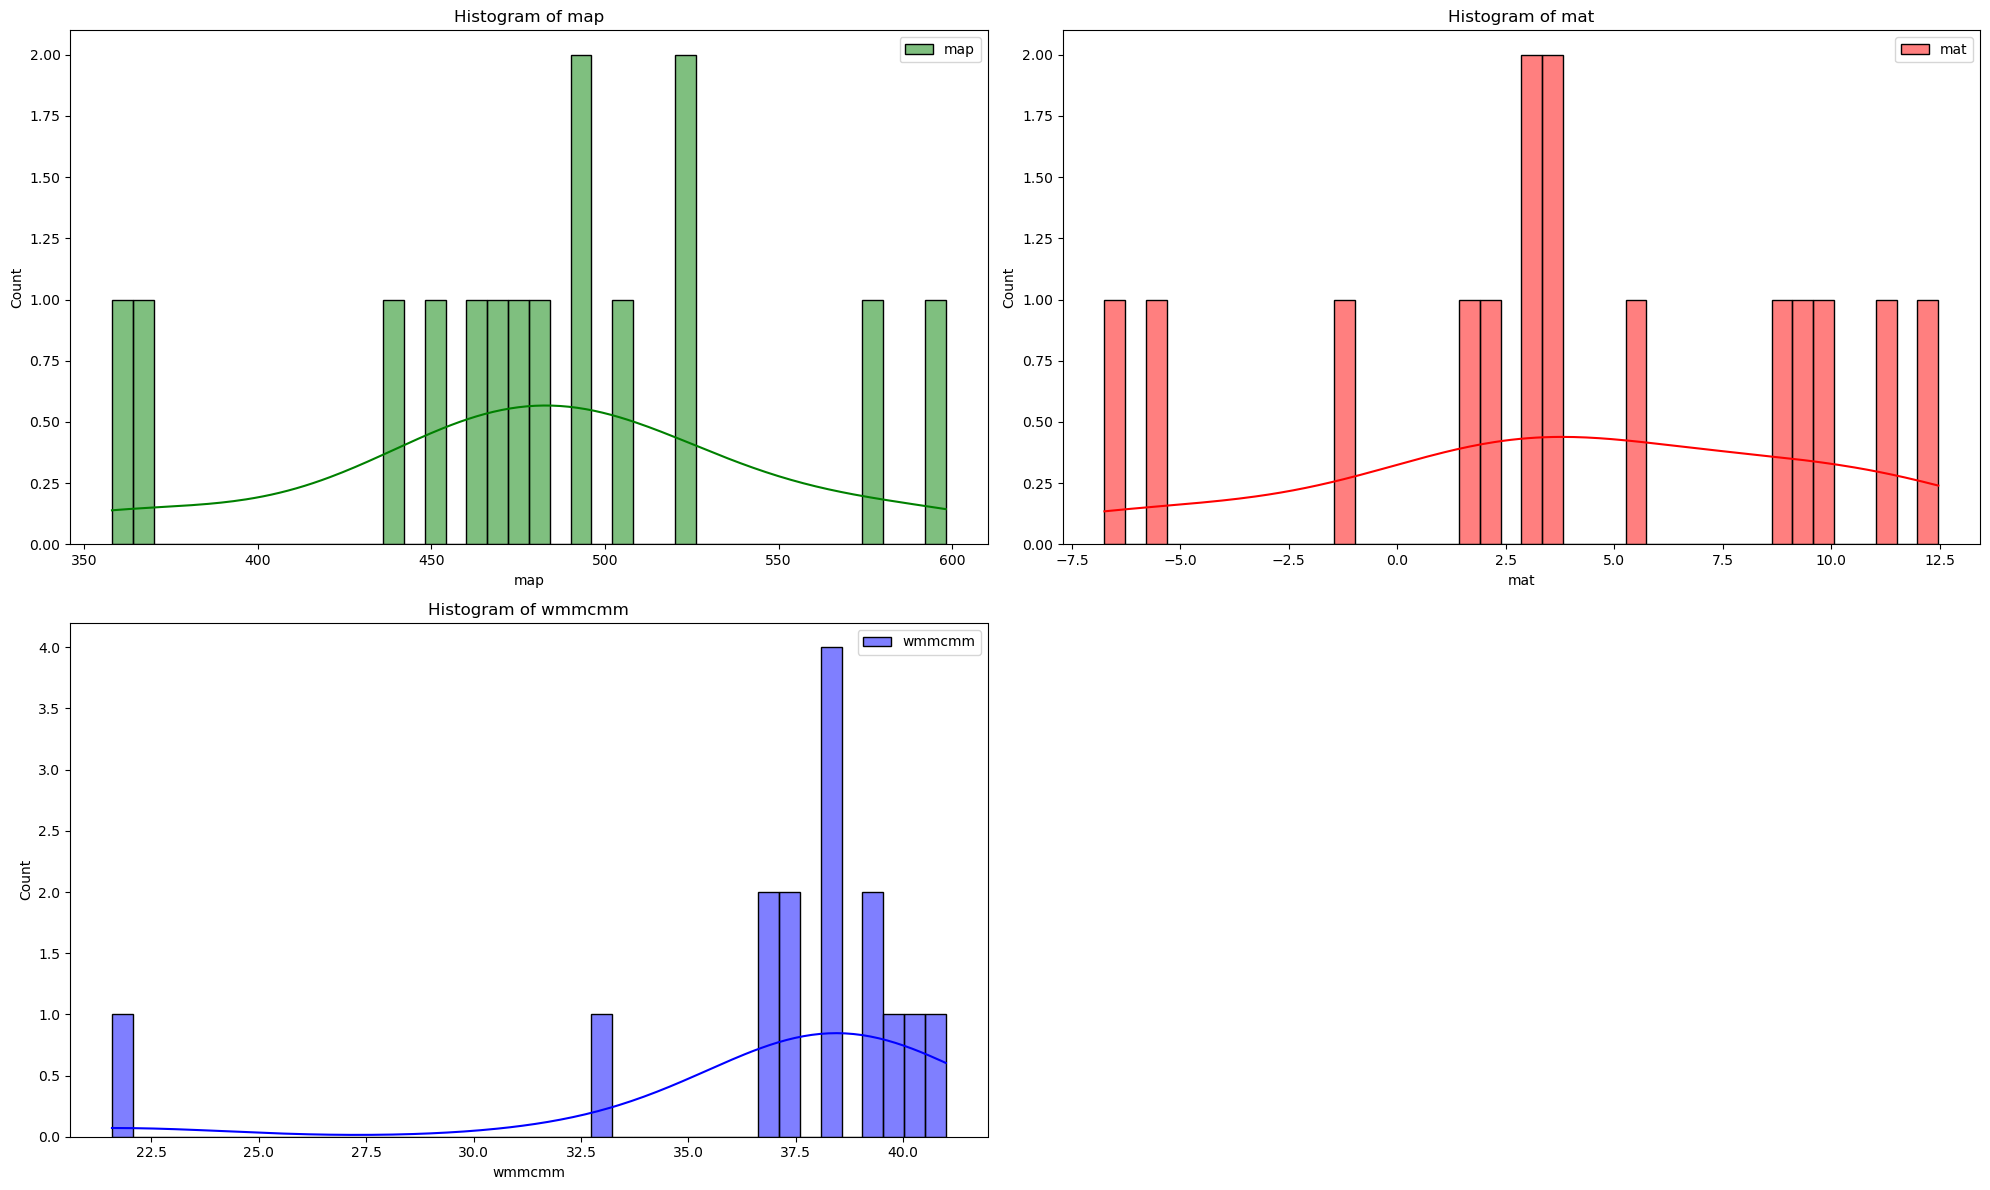

In [815]:
# Let's see the initial distributions of the raw env_vars data

plot_histograms(
    'predictors_plots/env_vars_original.pdf',
    (env, 'map', 'green'),
    (env, 'mat', 'red'),
    (env, 'wmmcmm', 'blue'),
)

### Scaling 'mat' and 'map'

In the env variables, 'mat' and 'map' are already normally distributed, so all I have to do to them is center them around zero 

I'll use sklearn's StandardScaler() for that. 

Then, I will move on in the next section to handling the skewness of the 'wmmcmm' column

In [816]:
scaler_map = StandardScaler()
scaler_mat = StandardScaler()

env['map_scaled'] = scaler_map.fit_transform(env[['map']])
env['mat_scaled'] = scaler_mat.fit_transform(env[['mat']])

C:\Users\SimoesLabAdmin\AppData\Local\Temp\ipykernel_26888\3948513813.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  env['map_scaled'] = scaler_map.fit_transform(env[['map']])
C:\Users\SimoesLabAdmin\AppData\Local\Temp\ipykernel_26888\3948513813.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  env['mat_scaled'] = scaler_mat.fit_transform(env[['mat']])


### Testing 'wmmcmm' Transformations

The 'wmmcmm' predictor in env (last graph above) is left skewed. I'll test various transformations to see which one fixes that best

            Stage       map        mat    wmmcmm     Time  map_scaled  \
14       Rhaetian  462.3523   9.002368  38.14543  201.300   -0.292460   
13         Norian  493.4584   9.531891  38.12684  208.500    0.201475   
12        Carnian  579.0786  11.356960  38.48378  227.000    1.561041   
11       Ladinian  598.1063   9.841047  39.99329  237.000    1.863182   
10        Anisian  437.6114  -1.416807  40.43240  242.000   -0.685322   
9       Olenekian  452.7017   2.212064  38.43882  247.200   -0.445702   
8          Induan  479.7812   3.279027  39.15463  251.200   -0.015706   
7   Changhsingian  492.8511   5.699131  36.81155  251.902    0.191831   
6   Wuchiapingian  475.3778   3.106955  37.37995  254.140   -0.085628   
5      Capitanian  364.9878  -5.735454  39.24222  259.100   -1.838515   
4         Wordian  358.0743  -6.750223  40.98974  265.100   -1.948294   
3         Roadian  525.4787  12.470220  21.58670  268.800    0.709926   
2       Kungurian  503.1488   3.479318  37.42631  2

c:\Users\SimoesLabAdmin\anaconda3\envs\env\lib\site-packages\sklearn\preprocessing\_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (15). n_quantiles is set to n_samples.
  warnings.warn(


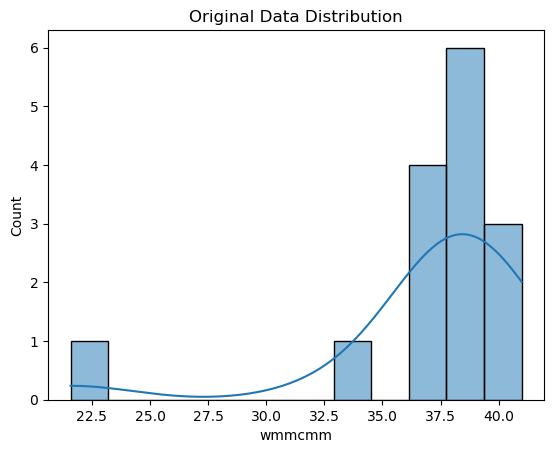

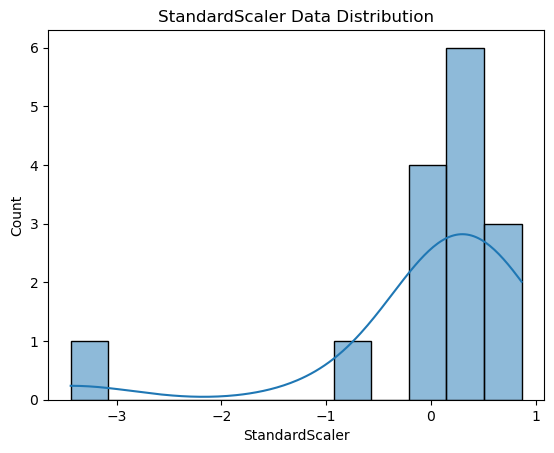

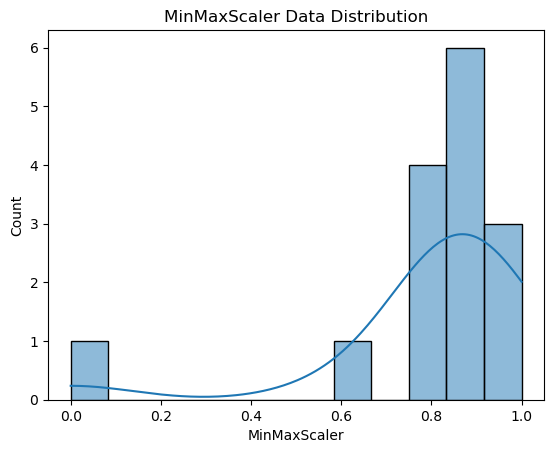

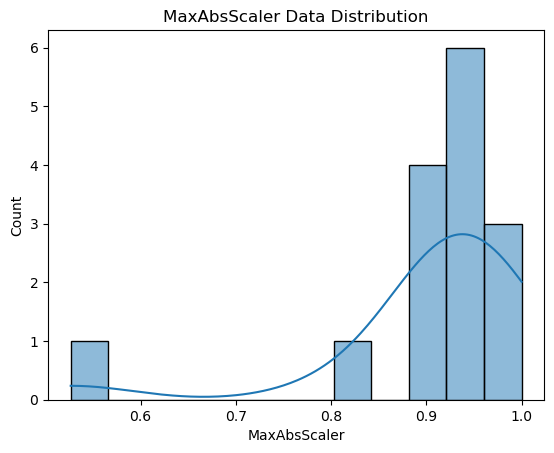

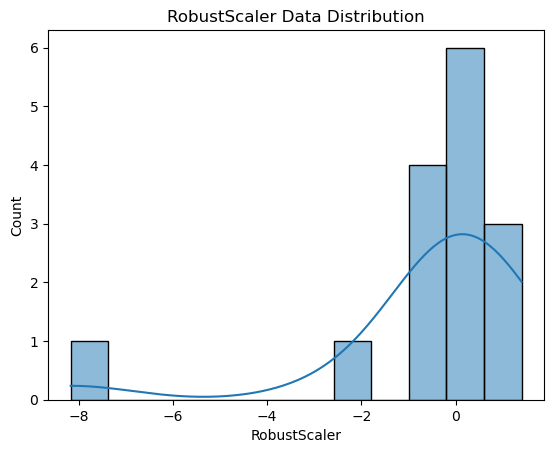

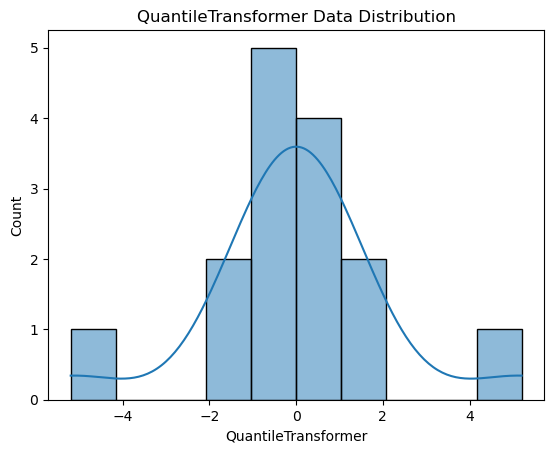

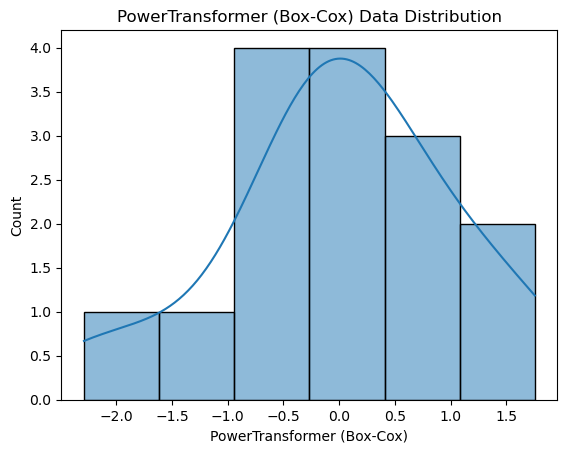

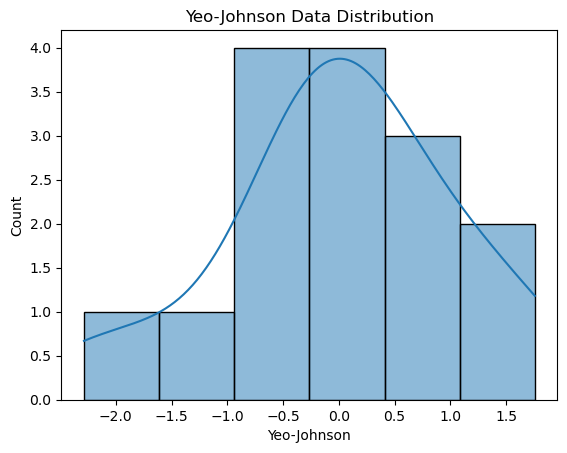

In [817]:
# Testing using sklearn scalers

from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler, RobustScaler, QuantileTransformer, PowerTransformer

# Extract the data as a numpy array
df = env.copy()
data_array = df['wmmcmm'].values.reshape(-1, 1)

# Apply different scalers
scalers = {
    'StandardScaler': StandardScaler(),
    'MinMaxScaler': MinMaxScaler(),
    'MaxAbsScaler': MaxAbsScaler(),
    'RobustScaler': RobustScaler(),
    'QuantileTransformer': QuantileTransformer(output_distribution='normal'),
    'PowerTransformer (Box-Cox)': PowerTransformer(method='box-cox'),
    'Yeo-Johnson': PowerTransformer(method='yeo-johnson')
}

# Apply each scaler and store the results in the DataFrame
for scaler_name, scaler in scalers.items():
    scaled_data = scaler.fit_transform(data_array)
    df[scaler_name] = scaled_data

# Print the transformed data
print(df)

# Plot the original data
sns.histplot(df['wmmcmm'], kde=True)
plt.title('Original Data Distribution')
plt.show()

# Plot the transformed data for each scaler
for scaler_name in scalers.keys():
    sns.histplot(df[scaler_name], kde=True)
    plt.title(f'{scaler_name} Data Distribution')
    plt.show()

In [818]:
# TESTING DIFFERENT TRANSFORMATIONS FOR wmmcmm's LEFT SKEW

import scipy.stats as stats

# 1. Log transformation
env['wmmcmm_log'] = np.log(env['wmmcmm'])

# 2. Box-Cox transformation
env['wmmcmm_boxcox'], wmmcmm_boxcox_lambda_param = stats.boxcox(env['wmmcmm'])

# 3. Cube root transformation
env['wmmcmm_cbrt'] = np.cbrt(env['wmmcmm'])

# 4. Yeo-Johnson transformation
env['wmmcmm_yeojohnson'], wmmcmm_yeojohnson_lambda_param = stats.yeojohnson(env['wmmcmm'])

# 5. Quantile transformation
env['wmmcmm_quantile'] = QuantileTransformer(output_distribution='normal').fit_transform(env['wmmcmm'].values.reshape(-1, 1))

# 5. StandardScaler normalization function, instatiating a new scaler for each column passed to the function
def standardize_column(column):
    scaler = StandardScaler()
    return scaler.fit_transform(column.values.reshape(-1, 1))

# 6. Apply standardization to original and all transformations
for suffix in ['', '_log', '_boxcox', '_cbrt', '_yeojohnson', '_quantile']:
    col = f'wmmcmm{suffix}'
    env[f'wmmcmm{suffix}_scaled'] = standardize_column(env[col])

# 7. Print summary statistics to help choose the best transformation. 
# #We want the lowest skew value possible (closer to 0 = closer to normal distribution)
print("\nSkewness comparison (closest to 0 is best):")
print(env[['wmmcmm_scaled', 'wmmcmm_log_scaled', 'wmmcmm_boxcox_scaled', 'wmmcmm_cbrt_scaled', 
           'wmmcmm_yeojohnson_scaled', 'wmmcmm_quantile_scaled']].skew())

# 8. Check normality using Shapiro-Wilk test
# We want the highest p-value possible
# We also want the highest statistic possible (closer to 1 = closer to normal distribution)
for suffix in ['', '_log', '_boxcox', '_cbrt', '_yeojohnson', '_quantile']:
    col = f'wmmcmm{suffix}_scaled'
    stat, p_value = stats.shapiro(env[col])
    print(f"\nShapiro-Wilk test for {col}:")
    print(f"Shapiro-Wilk Statistic (closest to 1 is best): {stat:.4f}, p-value (higher is better): {p_value:.4f}")

# Print the lambda parameter from Box-Cox transform
print(f"\nBox-Cox transformation lambda parameter: {wmmcmm_boxcox_lambda_param:.4f}")
print(f"Yeo-Johnson transformation lambda parameter: {wmmcmm_yeojohnson_lambda_param:.4f}")


Skewness comparison (closest to 0 is best):
wmmcmm_scaled              -2.945337e+00
wmmcmm_log_scaled          -3.250848e+00
wmmcmm_boxcox_scaled       -4.965986e-01
wmmcmm_cbrt_scaled         -3.156831e+00
wmmcmm_yeojohnson_scaled   -4.900338e-01
wmmcmm_quantile_scaled      5.807339e-11
dtype: float64

Shapiro-Wilk test for wmmcmm_scaled:
Shapiro-Wilk Statistic (closest to 1 is best): 0.6372, p-value (higher is better): 0.0001

Shapiro-Wilk test for wmmcmm_log_scaled:
Shapiro-Wilk Statistic (closest to 1 is best): 0.5641, p-value (higher is better): 0.0000

Shapiro-Wilk test for wmmcmm_boxcox_scaled:
Shapiro-Wilk Statistic (closest to 1 is best): 0.9642, p-value (higher is better): 0.7650

Shapiro-Wilk test for wmmcmm_cbrt_scaled:
Shapiro-Wilk Statistic (closest to 1 is best): 0.5880, p-value (higher is better): 0.0000

Shapiro-Wilk test for wmmcmm_yeojohnson_scaled:
Shapiro-Wilk Statistic (closest to 1 is best): 0.9645, p-value (higher is better): 0.7704

Shapiro-Wilk test for wmmc

C:\Users\SimoesLabAdmin\AppData\Local\Temp\ipykernel_26888\1675583839.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  env['wmmcmm_log'] = np.log(env['wmmcmm'])
C:\Users\SimoesLabAdmin\AppData\Local\Temp\ipykernel_26888\1675583839.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  env['wmmcmm_boxcox'], wmmcmm_boxcox_lambda_param = stats.boxcox(env['wmmcmm'])
C:\Users\SimoesLabAdmin\AppData\Local\Temp\ipykernel_26888\1675583839.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sl

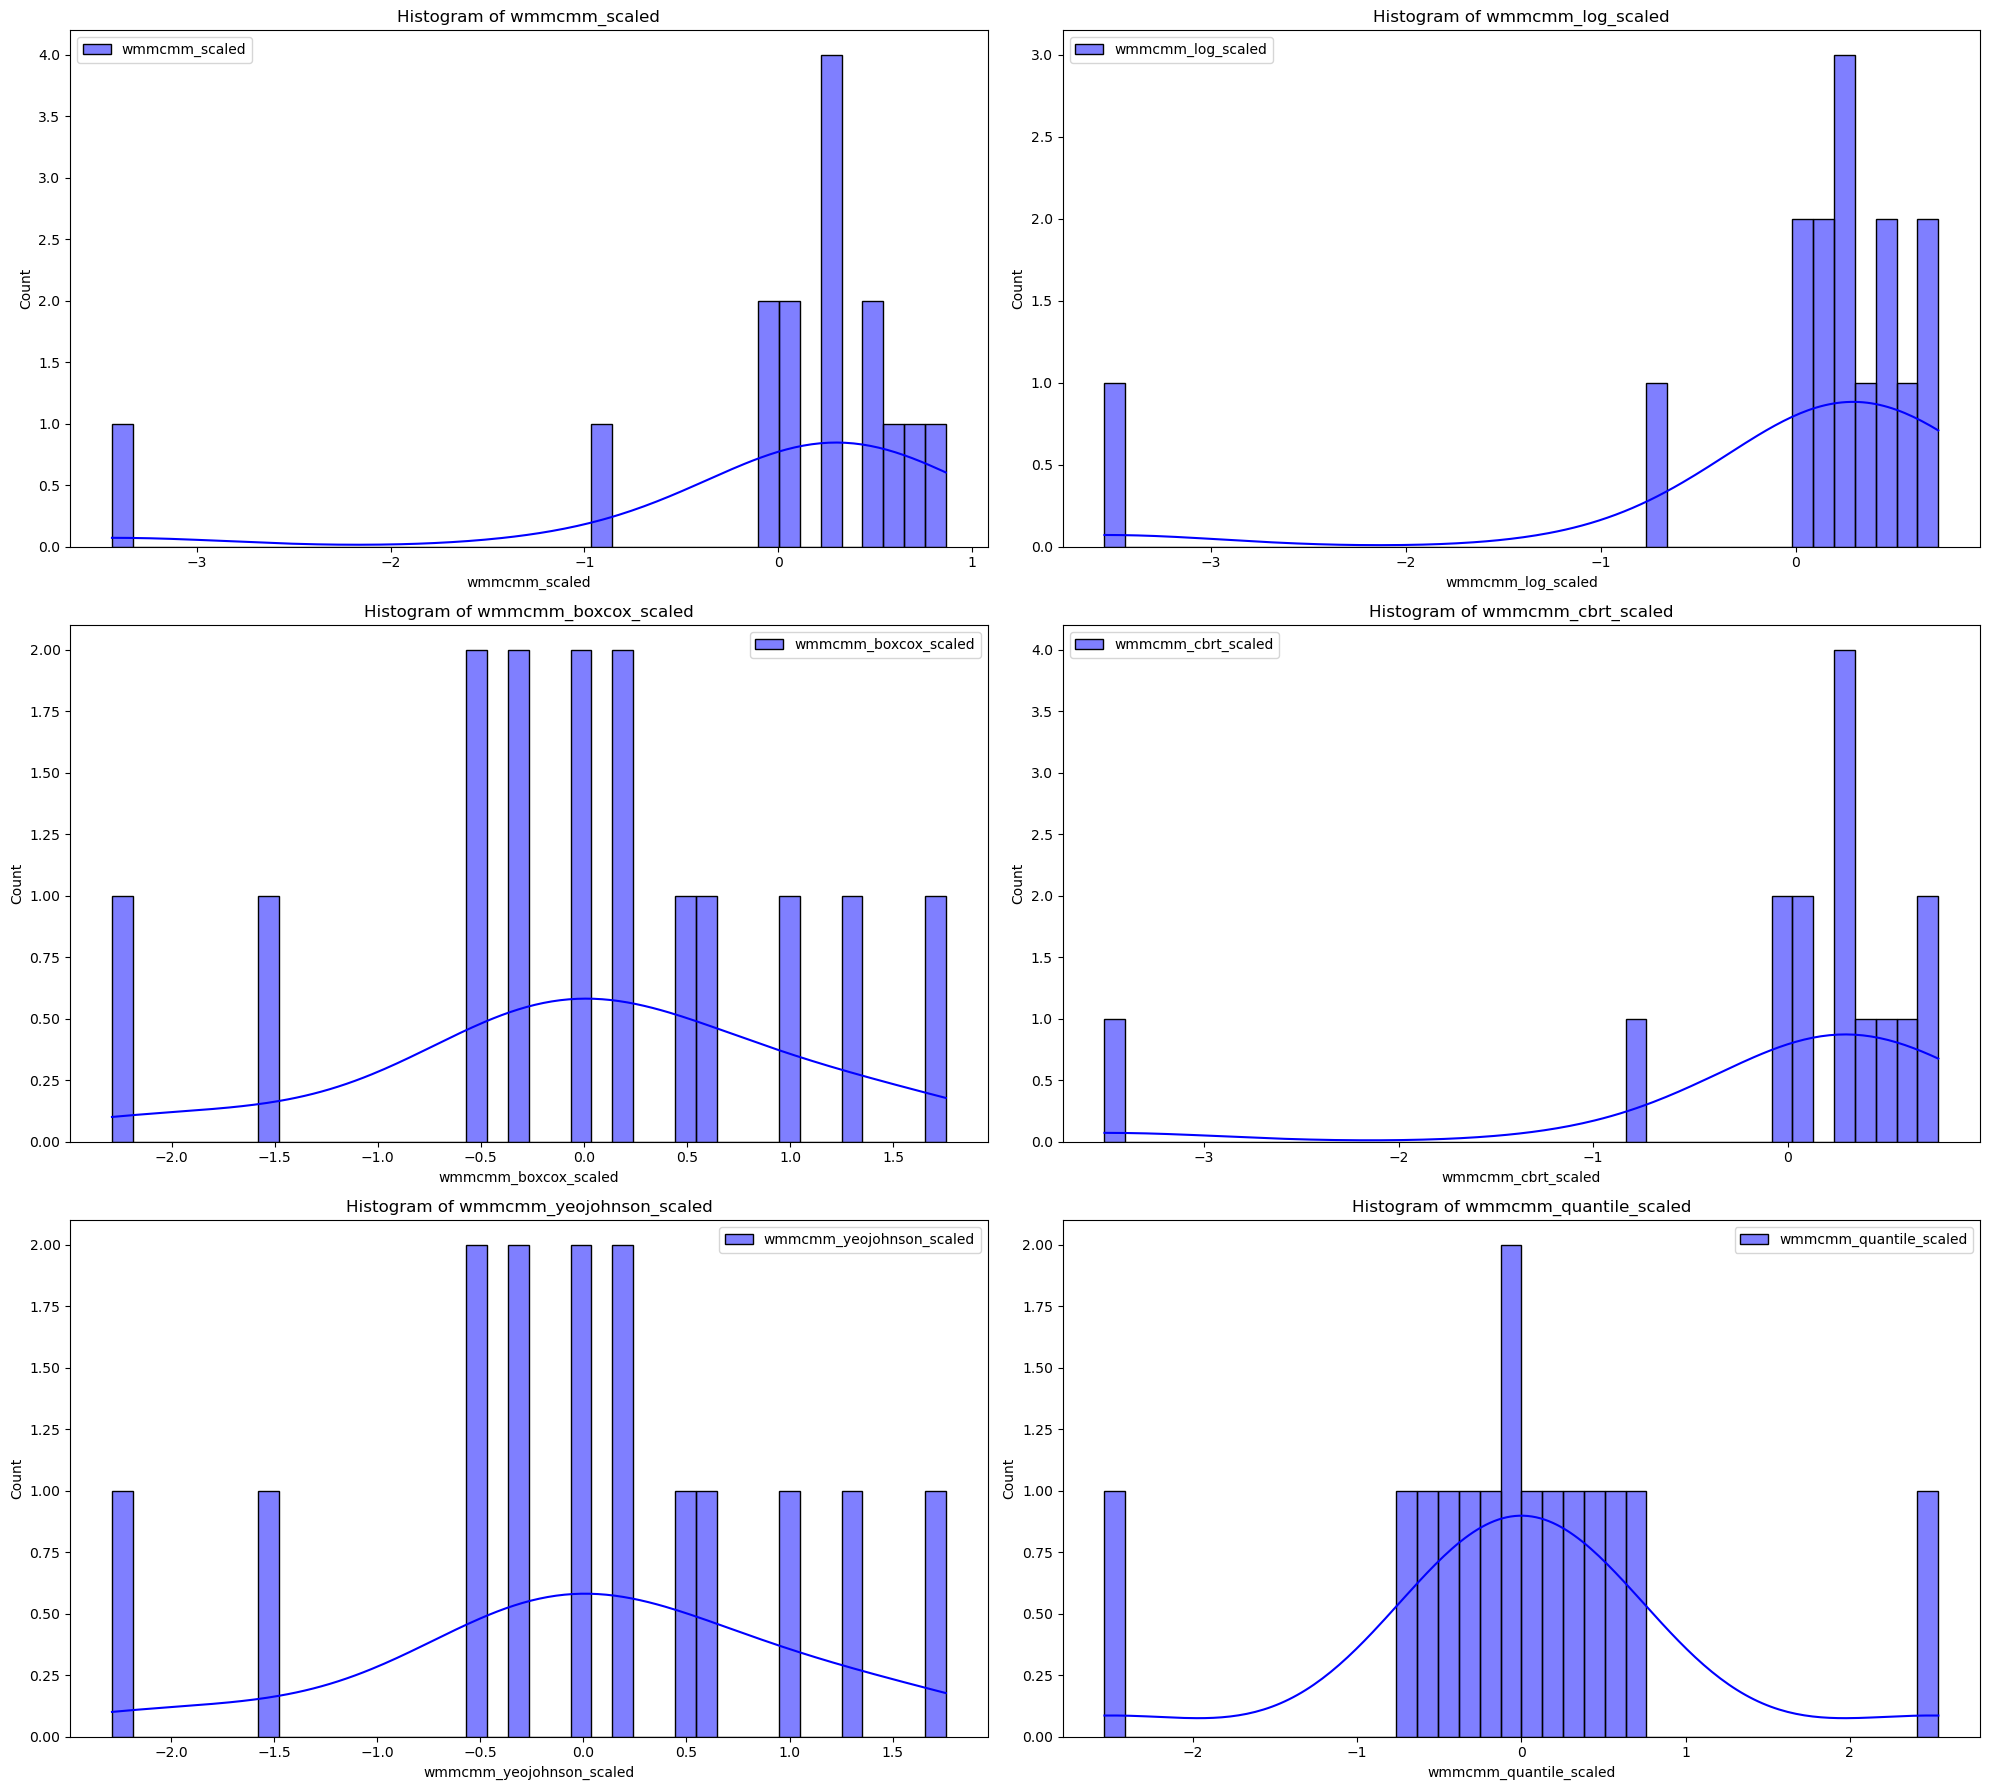

In [819]:
plot_histograms(
    'predictors_plots/env_vars_wmmcmm_standardscaled_transformations.pdf',
    (env, 'wmmcmm_scaled', 'blue'),
    (env, 'wmmcmm_log_scaled', 'blue'),
    (env, 'wmmcmm_boxcox_scaled', 'blue'),
    (env, 'wmmcmm_cbrt_scaled', 'blue'),
    (env, 'wmmcmm_yeojohnson_scaled', 'blue'), 
    (env, 'wmmcmm_quantile_scaled', 'blue')
)

The Yeo-Johnson and Box-Cox have almost equivalent performance. Since my data is strictly positive, I'm going to go with Box-Cox

In [820]:
env

Stage       map        mat    wmmcmm     Time  map_scaled  \
14       Rhaetian  462.3523   9.002368  38.14543  201.300   -0.292460   
13         Norian  493.4584   9.531891  38.12684  208.500    0.201475   
12        Carnian  579.0786  11.356960  38.48378  227.000    1.561041   
11       Ladinian  598.1063   9.841047  39.99329  237.000    1.863182   
10        Anisian  437.6114  -1.416807  40.43240  242.000   -0.685322   
9       Olenekian  452.7017   2.212064  38.43882  247.200   -0.445702   
8          Induan  479.7812   3.279027  39.15463  251.200   -0.015706   
7   Changhsingian  492.8511   5.699131  36.81155  251.902    0.191831   
6   Wuchiapingian  475.3778   3.106955  37.37995  254.140   -0.085628   
5      Capitanian  364.9878  -5.735454  39.24222  259.100   -1.838515   
4         Wordian  358.0743  -6.750223  40.98974  265.100   -1.948294   
3         Roadian  525.4787  12.470220  21.58670  268.800    0.709926   
2       Kungurian  503.1488   3.479318  37.42631  272.950    0.355349   
1      Artinskian  520.7936   3.638446  36.96527  283.500    0.635531   
0       Sakmarian  467.7526   1.625588  33.21412  290.100   -0.206709   

    mat_scaled  wmmcmm_log  wmmcmm_boxcox  wmmcmm_cbrt  wmmcmm_yeojohnson  \
14    0.878984    3.641406   3.143370e+11     3.366259       8.412768e+11   
13    0.973721    3.640918   3.131387e+11     3.365712       8.380635e+11   
12    1.300244    3.650237   3.368577e+11     3.376182       9.016759e+11   
11    1.029032    3.688712   4.553798e+11     3.419761       1.219888e+12   
10   -0.985109    3.699631   4.960586e+11     3.432231       1.329226e+12   
9    -0.335868    3.649068   3.337863e+11     3.374867       8.934374e+11   
8    -0.144978    3.667519   3.857051e+11     3.395687       1.032755e+12   
7     0.288002    3.605812   2.378321e+11     3.326555       6.362663e+11   
6    -0.175764    3.621134   2.681717e+11     3.343589       7.175348e+11   
5    -1.757758    3.669753   3.925178e+11     3.398218       1.051045e+12   
4    -1.939310    3.713322   5.522305e+11     3.447930       1.480301e+12   
3     1.499417    3.072077   3.630846e+09     2.784382       1.002012e+10   
2    -0.109144    3.622374   2.707888e+11     3.344971       7.245472e+11   
1    -0.080675    3.609979   2.457260e+11     3.331179       6.574068e+11   
0    -0.440795    3.502975   1.062489e+11     3.214457       2.843431e+11   

    wmmcmm_quantile  wmmcmm_scaled  wmmcmm_log_scaled  wmmcmm_boxcox_scaled  \
14         0.000000       0.233330           0.251677              0.001300   
13        -0.180012       0.229209           0.248427             -0.007534   
12         0.366106       0.308325           0.310561              0.167316   
11         1.067571       0.642909           0.567106              1.041028   
10         1.465234       0.740238           0.639917              1.340901   
9          0.180012       0.298360           0.302766              0.144675   
8          0.565949       0.457019           0.425794              0.527406   
7         -1.067571      -0.062325           0.014339             -0.562673   
6         -0.565949       0.063661           0.116510             -0.339018   
5          0.791639       0.476434           0.440693              0.577627   
4          5.199338       0.863772           0.731203              1.754984   
3         -5.199338      -3.436919          -3.544532             -2.289139   
2         -0.366106       0.073937           0.124774             -0.319725   
1         -0.791639      -0.028253           0.042125             -0.504481   
0         -1.465234      -0.859697          -0.671362             -1.532667   

    wmmcmm_cbrt_scaled  wmmcmm_yeojohnson_scaled  wmmcmm_quantile_scaled  
14            0.246266                  0.000250           -3.186203e-12  
13            0.242733                 -0.008588           -8.793039e-02  
12            0.310363                  0.166377            1.788315e-01  
11            0.591840                  1.041

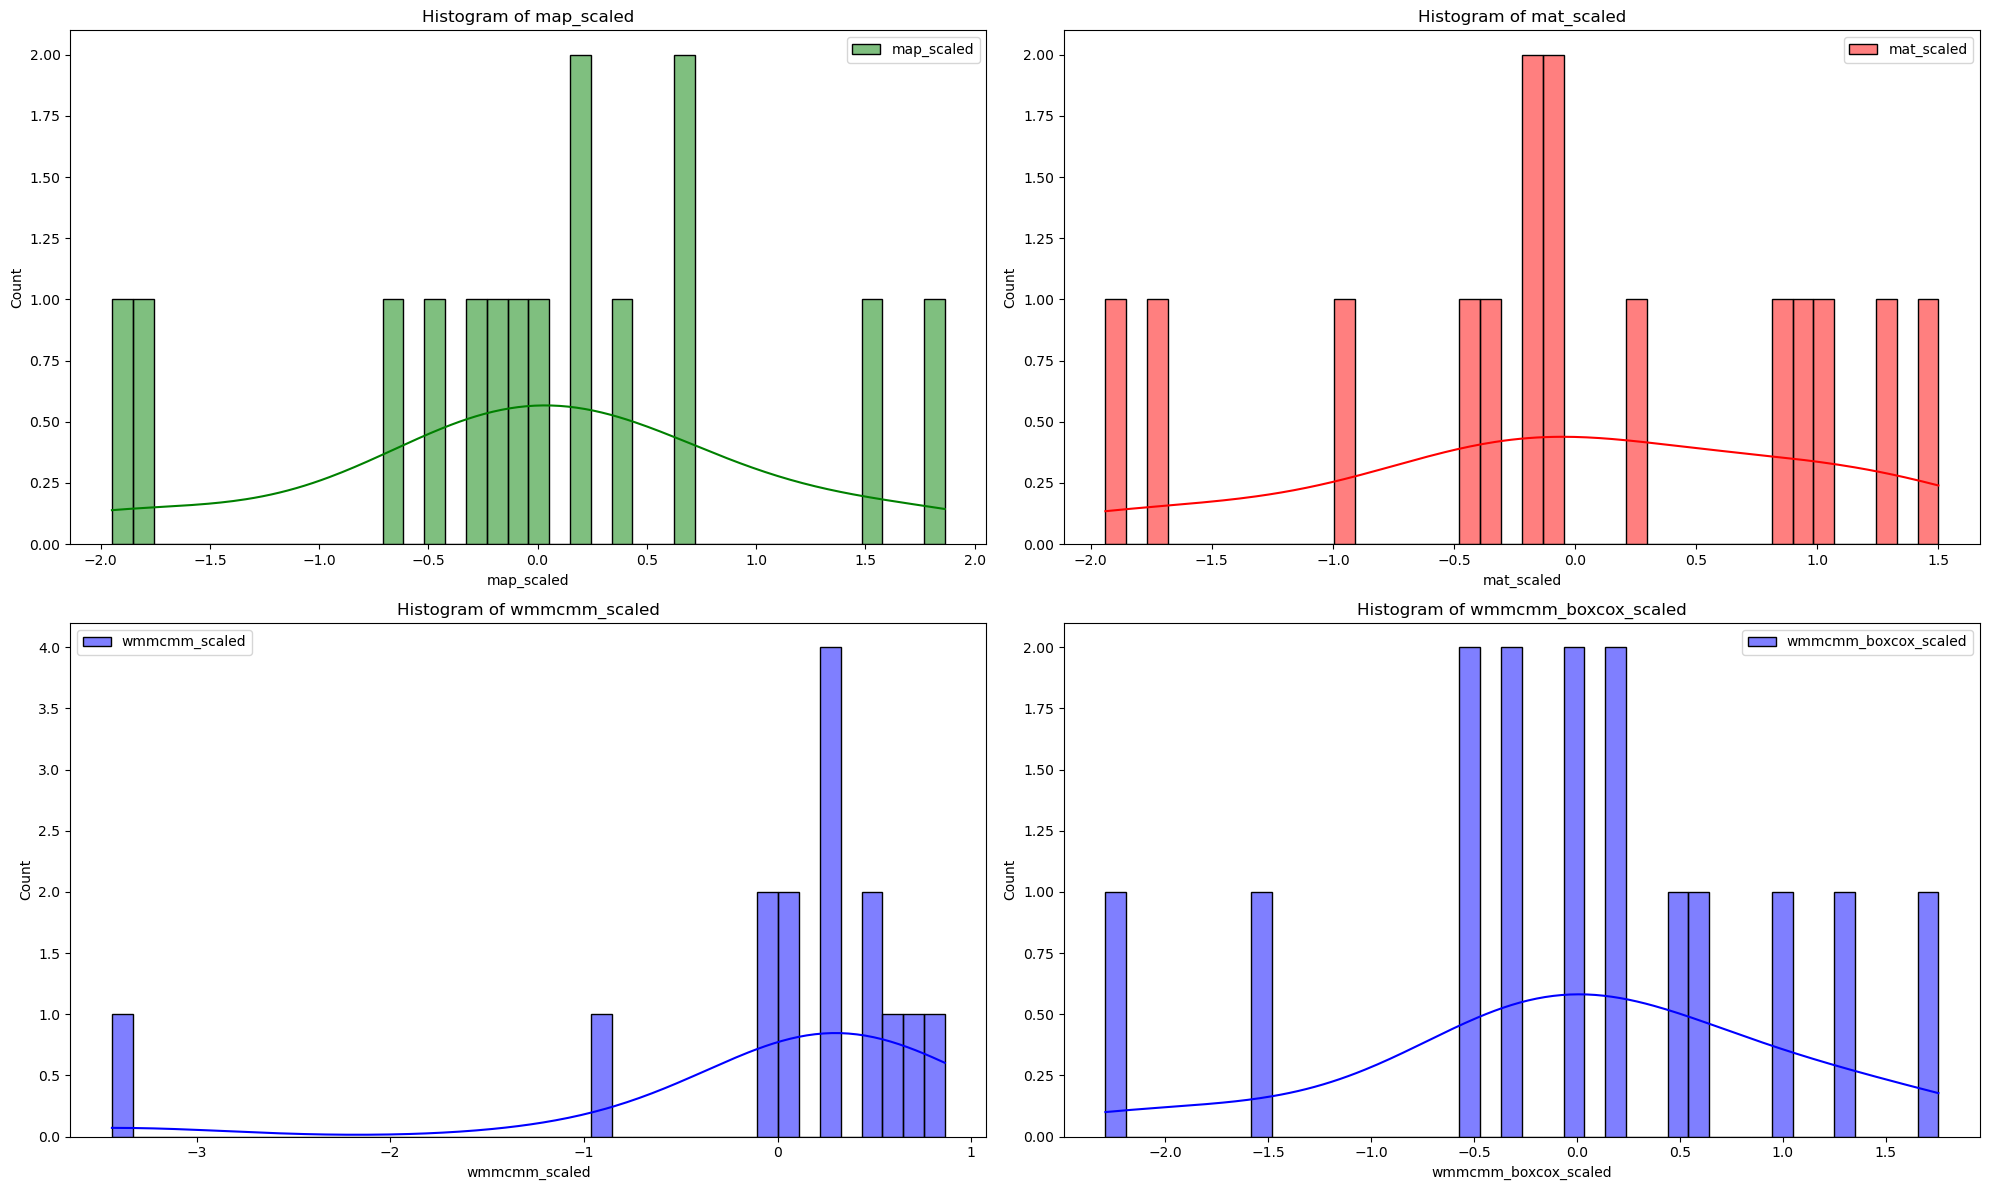

In [821]:
# Graphing all of the final env vars scaled, together
plot_histograms(
    'predictors_plots/env_vars_standardscaled_all.pdf',
    (env, 'map_scaled', 'green'),
    (env, 'mat_scaled', 'red'),
    (env, 'wmmcmm_scaled', 'blue'),
    (env, 'wmmcmm_boxcox_scaled', 'blue'),
)

### Final 2 env_vars.txt's

In [822]:
# Ok so wmmcmm box cox scaled is still better than just wmmcmm scaled, so I'll use that
env_scaled_boxcox = env[['Time', 'map_scaled', 'mat_scaled', 'wmmcmm_boxcox_scaled']]
env_scaled_boxcox

Time  map_scaled  mat_scaled  wmmcmm_boxcox_scaled
14  201.300   -0.292460    0.878984              0.001300
13  208.500    0.201475    0.973721             -0.007534
12  227.000    1.561041    1.300244              0.167316
11  237.000    1.863182    1.029032              1.041028
10  242.000   -0.685322   -0.985109              1.340901
9   247.200   -0.445702   -0.335868              0.144675
8   251.200   -0.015706   -0.144978              0.527406
7   251.902    0.191831    0.288002             -0.562673
6   254.140   -0.085628   -0.175764             -0.339018
5   259.100   -1.838515   -1.757758              0.577627
4   265.100   -1.948294   -1.939310              1.754984
3   268.800    0.709926    1.499417             -2.289139
2   272.950    0.355349   -0.109144             -0.319725
1   283.500    0.635531   -0.080675             -0.504481
0   290.100   -0.206709   -0.440795             -1.532667

In [823]:
env_scaled_boxcox.to_csv('env_vars_data/env_vars_scaled_boxcox.txt', sep='\t', index=False)

In [824]:
# I'll also make one that does not box cox transform the 'wmmcmm' so I can run the model with both to see which is better
env_scaled_only = env[['Time', 'map_scaled', 'mat_scaled', 'wmmcmm_scaled']]
env_scaled_only.to_csv('env_vars_data/env_vars_scaled_only.txt', sep='\t', index=False)
env_scaled_only

Time  map_scaled  mat_scaled  wmmcmm_scaled
14  201.300   -0.292460    0.878984       0.233330
13  208.500    0.201475    0.973721       0.229209
12  227.000    1.561041    1.300244       0.308325
11  237.000    1.863182    1.029032       0.642909
10  242.000   -0.685322   -0.985109       0.740238
9   247.200   -0.445702   -0.335868       0.298360
8   251.200   -0.015706   -0.144978       0.457019
7   251.902    0.191831    0.288002      -0.062325
6   254.140   -0.085628   -0.175764       0.063661
5   259.100   -1.838515   -1.757758       0.476434
4   265.100   -1.948294   -1.939310       0.863772
3   268.800    0.709926    1.499417      -3.436919
2   272.950    0.355349   -0.109144       0.073937
1   283.500    0.635531   -0.080675      -0.028253
0   290.100   -0.206709   -0.440795      -0.859697

### Adding To Backscale.txt

Need to add the mean and std of the original 'map', 'mat', 'wmmcmm' columns, under the following names:
1. 'map_scaled'
2. 'mat_scaled'
3. 'wmmcmm_scaled'
4. 'wmmcmm_boxcox_scaled'
    a. Same mean and std as 3. but add wmmcmm_lambda_param

In [825]:
rep_backscale

rotated_lat_scaled  rotated_lon_scaled
0           -1.649635            1.843582
1           34.773192           44.310370

In [826]:
# Add new columns to rep_backscale that contains mean and std of env['map', 'mat', 'wmmcmm', 'wmmcmm_boxcox'] (and lambda param of the last one)
# In order to then backscale the scaled versions of all these columns in post-processing
rep_backscale['map_scaled'] = [env['map'].mean(), env['map'].std()]
rep_backscale['mat_scaled'] = [env['mat'].mean(), env['mat'].std()]
rep_backscale['wmmcmm_scaled'] = [env['wmmcmm'].mean(), env['wmmcmm'].std()]
rep_backscale['wmmcmm_boxcox_scaled'] = [env['wmmcmm_boxcox'].mean(), env['wmmcmm_boxcox'].std()]

rep_backscale.loc[2] = {'map_scaled': np.nan, 
                        'mat_scaled': np.nan, 
                        'wmmcmm_scaled': np.nan,
                        'wmmcmm_boxcox_scaled': wmmcmm_boxcox_lambda_param}
rep_backscale

rotated_lat_scaled  rotated_lon_scaled  map_scaled  mat_scaled  \
0           -1.649635            1.843582  480.770307    4.089369   
1           34.773192           44.310370   65.186473    5.785585   
2                 NaN                 NaN         NaN         NaN   

   wmmcmm_scaled  wmmcmm_boxcox_scaled  
0      37.092737          3.141607e+11  
1       4.669959          1.404148e+11  
2            NaN          7.835545e+00

In [827]:
# Doing the same for syn_backscale
# All the values are the same since these are universal environmental variables, but since the backscale.txt also contains values for lats and lons, 
# I need to add these env vars separately to a backscale.txt specific to each group (rep, syn, tem)
syn_backscale['map_scaled'] = [env['map'].mean(), env['map'].std()]
syn_backscale['mat_scaled'] = [env['mat'].mean(), env['mat'].std()]
syn_backscale['wmmcmm_scaled'] = [env['wmmcmm'].mean(), env['wmmcmm'].std()]
syn_backscale['wmmcmm_boxcox_scaled'] = [env['wmmcmm_boxcox'].mean(), env['wmmcmm_boxcox'].std()]

syn_backscale.loc[2] = {'map_scaled': np.nan,
                        'mat_scaled': np.nan,
                        'wmmcmm_scaled': np.nan,
                        'wmmcmm_boxcox_scaled': wmmcmm_boxcox_lambda_param}
syn_backscale

rotated_lat_scaled  rotated_lon_scaled  map_scaled  mat_scaled  \
0          -34.660461           -5.783020  480.770307    4.089369   
1           37.792281           29.052976   65.186473    5.785585   
2                 NaN                 NaN         NaN         NaN   

   wmmcmm_scaled  wmmcmm_boxcox_scaled  
0      37.092737          3.141607e+11  
1       4.669959          1.404148e+11  
2            NaN          7.835545e+00

In [828]:
# Now for tem_backscale
tem_backscale['map_scaled'] = [env['map'].mean(), env['map'].std()]
tem_backscale['mat_scaled'] = [env['mat'].mean(), env['mat'].std()]
tem_backscale['wmmcmm_scaled'] = [env['wmmcmm'].mean(), env['wmmcmm'].std()]
tem_backscale['wmmcmm_boxcox_scaled'] = [env['wmmcmm_boxcox'].mean(), env['wmmcmm_boxcox'].std()]

tem_backscale.loc[2] = {'map_scaled': np.nan,
                        'mat_scaled': np.nan,
                        'wmmcmm_scaled': np.nan,
                        'wmmcmm_boxcox_scaled': wmmcmm_boxcox_lambda_param}
tem_backscale

rotated_lat_scaled  rotated_lon_scaled  map_scaled  mat_scaled  \
0           12.929946            9.319296  480.770307    4.089369   
1           29.203648           36.968738   65.186473    5.785585   
2                 NaN                 NaN         NaN         NaN   

   wmmcmm_scaled  wmmcmm_boxcox_scaled  
0      37.092737          3.141607e+11  
1       4.669959          1.404148e+11  
2            NaN          7.835545e+00

### Creating MBD Directory
MBD model (PyRateContinuous.py, in Tutorial 4 of PyRate) requires separate files for each time-continuous predictor.

Only doing this for the env variables so far. Not the 1myr Temp Data (section below this)

wmmcmm is scaled only since MBD is not a neural network so the boxcox transformation to center the skewed wmmcmm data on 0 is probs not necessary

**Shifted MBD preds in directory by -175 (Covar runs use the argument -translate -175.0 to shift all of the dates towards the present by -175.0, PyRateMBD does not have a translate function so if you don't shift the preds times upwards, they will not match up with the covar mcmc logs ts and te's)**



In [829]:
env_vars = pd.read_csv('env_vars_data/env_vars_scaled_only.txt', sep='\t') # reading in b/c don't want to re-run nb to do this
# env_vars_bc = pd.read_csv('env_vars_data/env_vars_scaled_boxcox.txt', sep='\t')
map = env_vars[['Time', 'map_scaled']]
map['Time'] = map['Time'] - 175.0
mat = env_vars[['Time', 'mat_scaled']]
mat['Time'] = mat['Time'] - 175.0
wmmcmm = env_vars[['Time', 'wmmcmm_scaled']]
wmmcmm['Time'] = wmmcmm['Time'] - 175.0
# wmmcmm_boxcox = env_vars_bc[['Time', 'wmmcmm_boxcox_scaled']]
map

C:\Users\SimoesLabAdmin\AppData\Local\Temp\ipykernel_26888\951570162.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  map['Time'] = map['Time'] - 175.0
C:\Users\SimoesLabAdmin\AppData\Local\Temp\ipykernel_26888\951570162.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mat['Time'] = mat['Time'] - 175.0
C:\Users\SimoesLabAdmin\AppData\Local\Temp\ipykernel_26888\951570162.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_inde

Time  map_scaled
0    26.300   -0.292460
1    33.500    0.201475
2    52.000    1.561041
3    62.000    1.863182
4    67.000   -0.685322
5    72.200   -0.445702
6    76.200   -0.015706
7    76.902    0.191831
8    79.140   -0.085628
9    84.100   -1.838515
10   90.100   -1.948294
11   93.800    0.709926
12   97.950    0.355349
13  108.500    0.635531
14  115.100   -0.206709

In [830]:
map.to_csv('env_vars_data/MBD/map_scaled.txt', sep='\t', index=False)
mat.to_csv('env_vars_data/MBD/mat_scaled.txt', sep='\t', index=False)
wmmcmm.to_csv('env_vars_data/MBD/wmmcmm_scaled.txt', sep='\t', index=False)
# wmmcmm_boxcox.to_csv('MBD_preds/wmmcmm_boxcox.txt', sep='\t', index=False)

### Original Incorrect Scaling

env_vars.txt and 1myr_temp.txt were accidentally scaled improperly. I kept them just to refer back to, since some of our runs were run using them.

In [831]:
# def analyze_and_transform_distribution(series, plot_title=None):
#     """
#     Analyze, transform, and visualize a numeric series/column.
    
#     Parameters:
#     -----------
#     series : pandas.Series
#         The input data series to transform (e.g., env['wmmcmm'] or myr_temp['mean'])
#     plot_title : str, optional
#         Custom title for the plots. If None, uses the series name
        
#     Returns:
#     --------
#     pandas.DataFrame
#         DataFrame containing all transformations and their normalized versions
#     """
#     import numpy as np
#     import pandas as pd
#     import scipy.stats as stats
#     import matplotlib.pyplot as plt
    
#     # Create DataFrame with original data
#     column_name = series.name if series.name is not None else 'input_data'
#     df_transform = pd.DataFrame({column_name: series})
    
#     # Ensure data is positive and non-zero for log transform
#     min_val = df_transform[column_name].min()
#     if min_val <= 0:
#         print(f"Warning: Data contains values ≤ 0. Adding |min| + 1 to make all values positive for log transform.")
#         df_transform[column_name] = df_transform[column_name] - min_val + 1
    
#     # 1. Log transformation
#     df_transform[f'{column_name}_log'] = np.log(df_transform[column_name])
    
#     # 2. Box-Cox transformation
#     try:
#         boxcox_result, lambda_param = stats.boxcox(df_transform[column_name])
#         df_transform[f'{column_name}_boxcox'] = boxcox_result
#         boxcox_success = True
#     except:
#         print("Warning: Box-Cox transformation failed. Skipping this transformation.")
#         lambda_param = None
#         boxcox_success = False
    
#     # 3. Cube root transformation
#     df_transform[f'{column_name}_cbrt'] = np.cbrt(df_transform[column_name])
    
#     # 4. Min-max normalization function
#     def min_max_normalize(x):
#         return (x - x.min()) / (x.max() - x.min())
    
#     # Apply normalization to original and all transformations
#     transform_types = ['', '_log', '_cbrt']
#     if boxcox_success:
#         transform_types.append('_boxcox')
        
#     for suffix in transform_types:
#         df_transform[f'{column_name}{suffix}_normalized'] = min_max_normalize(df_transform[f'{column_name}{suffix}'])
    
#     # Create visualization
#     fig, axes = plt.subplots(len(transform_types), 2, figsize=(15, 5*len(transform_types)))
#     title = plot_title if plot_title else f'Distribution Comparison for {column_name}'
#     fig.suptitle(f'{title}\nLeft: Raw Transformations, Right: Min-Max Normalized', fontsize=14)
    
#     # Colors for the plots
#     raw_color = 'skyblue'
#     normalized_color = 'lightgreen'
    
#     # Plot histograms
#     for idx, suffix in enumerate(transform_types):
#         # Raw transformation
#         df_transform[f'{column_name}{suffix}'].hist(ax=axes[idx,0], bins=30, color=raw_color)
#         axes[idx,0].set_title(f'{"Original" if suffix == "" else suffix.strip("_").title()}')
#         axes[idx,0].set_xlabel('Value')
#         axes[idx,0].set_ylabel('Frequency')
        
#         # Normalized version
#         df_transform[f'{column_name}{suffix}_normalized'].hist(ax=axes[idx,1], bins=30, color=normalized_color)
#         axes[idx,1].set_title(f'{"Original" if suffix == "" else suffix.strip("_").title()} (Normalized)')
#         axes[idx,1].set_xlabel('Value')
#         axes[idx,1].set_ylabel('Frequency')
    
#     plt.tight_layout()
#     plt.show()
    
#     # Print summary statistics
#     print("\nSkewness comparison:")
#     print(df_transform.skew())
    
#     # Shapiro-Wilk tests
#     print("\nShapiro-Wilk normality tests:")
#     for col in df_transform.columns:
#         stat, p_value = stats.shapiro(df_transform[col])
#         print(f"\n{col}:")
#         print(f"  Statistic: {stat:.4f}")
#         print(f"  p-value: {p_value:.4f}")
    
#     # Print Box-Cox lambda if transformation was successful
#     if boxcox_success:
#         print(f"\nBox-Cox transformation lambda parameter: {lambda_param:.4f}")
    
#     # Print range of values
#     print("\nRange of values for each transformation:")
#     for col in df_transform.columns:
#         print(f"\n{col}:")
#         print(f"  Min: {df_transform[col].min():.4f}")
#         print(f"  Max: {df_transform[col].max():.4f}")
#         print(f"  Mean: {df_transform[col].mean():.4f}")
#         print(f"  Median: {df_transform[col].median():.4f}")
    
#     return df_transform

### Min-Max Scaling

In [832]:
# Same code as used for creation of "env" dataframe from the beginning of this section
env_minmax = pd.read_csv('climateGlobalmeanLAND.txt', sep='\t')
env_minmax = env_minmax.iloc[::-1]

stages_map = {'Sakmarian':290.1, 'Artinskian':283.5, 'Kungurian':272.95, 'Roadian':268.8, 'Wordian':265.1,
              'Capitanian':259.1, 'Wuchiapingian':254.14, 'Changhsingian':251.902, 'Induan':251.2, 'Olenekian':247.2,
              'Anisian':242, 'Ladinian':237, 'Carnian':227, 'Norian':208.5, 'Rhaetian':201.3}
         
# Create new column mapping 'Stage' to a specific age using the stages_map dictionary
env_minmax['Time'] = env_minmax['Stage'].map(stages_map)
env_minmax


Stage       map        mat    wmmcmm     Time
14       Rhaetian  462.3523   9.002368  38.14543  201.300
13         Norian  493.4584   9.531891  38.12684  208.500
12        Carnian  579.0786  11.356960  38.48378  227.000
11       Ladinian  598.1063   9.841047  39.99329  237.000
10        Anisian  437.6114  -1.416807  40.43240  242.000
9       Olenekian  452.7017   2.212064  38.43882  247.200
8          Induan  479.7812   3.279027  39.15463  251.200
7   Changhsingian  492.8511   5.699131  36.81155  251.902
6   Wuchiapingian  475.3778   3.106955  37.37995  254.140
5      Capitanian  364.9878  -5.735454  39.24222  259.100
4         Wordian  358.0743  -6.750223  40.98974  265.100
3         Roadian  525.4787  12.470220  21.58670  268.800
2       Kungurian  503.1488   3.479318  37.42631  272.950
1      Artinskian  520.7936   3.638446  36.96527  283.500
0       Sakmarian  467.7526   1.625588  33.21412  290.100

In [833]:
# Min max transforming just map and mat

env_minmax['map_minmax'] = MinMaxScaler().fit_transform(env_minmax[['map']])
env_minmax['mat_minmax'] = MinMaxScaler().fit_transform(env_minmax[['mat']])

In [ ]:
# TESTING DIFFERENT TRANSFORMATIONS FOR wmmcmm's LEFT SKEW

import scipy.stats as stats

# 1. Log transformation
env_minmax['wmmcmm_log'] = np.log(env_minmax['wmmcmm'])

# 2. Box-Cox transformation
env_minmax['wmmcmm_boxcox'], wmmcmm_boxcox_lambda_param = stats.boxcox(env_minmax['wmmcmm'])

# 3. Cube root transformation
env_minmax['wmmcmm_cbrt'] = np.cbrt(env_minmax['wmmcmm'])

# 4. Yeo-Johnson transformation
env_minmax['wmmcmm_yeojohnson'], wmmcmm_yeojohnson_lambda_param = stats.yeojohnson(env_minmax['wmmcmm'])

# 5. Quantile transformation
env_minmax['wmmcmm_quantile'] = QuantileTransformer(output_distribution='normal').fit_transform(env_minmax['wmmcmm'].values.reshape(-1, 1))

# 5. StandardScaler normalization function, instatiating a new scaler for each column passed to the function
def standardize_column(column):
    scaler = MinMaxScaler()
    return scaler.fit_transform(column.values.reshape(-1, 1))

# 6. Apply standardization to original and all transformations
for suffix in ['', '_log', '_boxcox', '_cbrt', '_yeojohnson', '_quantile']:
    col = f'wmmcmm{suffix}'
    env_minmax[f'wmmcmm{suffix}_minmax'] = standardize_column(env_minmax[col])

# 7. Print summary statistics to help choose the best transformation. 
# #We want the lowest skew value possible (closer to 0 = closer to normal distribution)
print("\nSkewness comparison (closest to 0 is best):")
print(env_minmax[['wmmcmm_minmax', 'wmmcmm_log_minmax', 'wmmcmm_boxcox_minmax', 'wmmcmm_cbrt_minmax', 
           'wmmcmm_yeojohnson_minmax', 'wmmcmm_quantile_minmax']].skew())

# 8. Check normality using Shapiro-Wilk test
# We want the highest p-value possible
# We also want the highest statistic possible (closer to 1 = closer to normal distribution)
for suffix in ['', '_log', '_boxcox', '_cbrt', '_yeojohnson', '_quantile']:
    col = f'wmmcmm{suffix}_minmax'
    stat, p_value = stats.shapiro(env_minmax[col])
    print(f"\nShapiro-Wilk test for {col}:")
    print(f"Shapiro-Wilk Statistic (closest to 1 is best): {stat:.4f}, p-value (higher is better): {p_value:.4f}")

# Print the lambda parameter from Box-Cox transform
print(f"\nBox-Cox transformation lambda parameter: {wmmcmm_boxcox_lambda_param:.4f}")
print(f"Yeo-Johnson transformation lambda parameter: {wmmcmm_yeojohnson_lambda_param:.4f}")


Skewness comparison (closest to 0 is best):
wmmcmm_minmax              -2.945337e+00
wmmcmm_log_minmax          -3.250848e+00
wmmcmm_boxcox_minmax       -4.965986e-01
wmmcmm_cbrt_minmax         -3.156831e+00
wmmcmm_yeojohnson_minmax   -4.900338e-01
wmmcmm_quantile_minmax      5.807099e-11
dtype: float64

Shapiro-Wilk test for wmmcmm_minmax:
Shapiro-Wilk Statistic (closest to 1 is best): 0.6372, p-value (higher is better): 0.0001

Shapiro-Wilk test for wmmcmm_log_minmax:
Shapiro-Wilk Statistic (closest to 1 is best): 0.5641, p-value (higher is better): 0.0000

Shapiro-Wilk test for wmmcmm_boxcox_minmax:
Shapiro-Wilk Statistic (closest to 1 is best): 0.9642, p-value (higher is better): 0.7650

Shapiro-Wilk test for wmmcmm_cbrt_minmax:
Shapiro-Wilk Statistic (closest to 1 is best): 0.5880, p-value (higher is better): 0.0000

Shapiro-Wilk test for wmmcmm_yeojohnson_minmax:
Shapiro-Wilk Statistic (closest to 1 is best): 0.9645, p-value (higher is better): 0.7704

Shapiro-Wilk test for wmmc

c:\Users\SimoesLabAdmin\anaconda3\envs\env\lib\site-packages\sklearn\preprocessing\_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (15). n_quantiles is set to n_samples.
  warnings.warn(


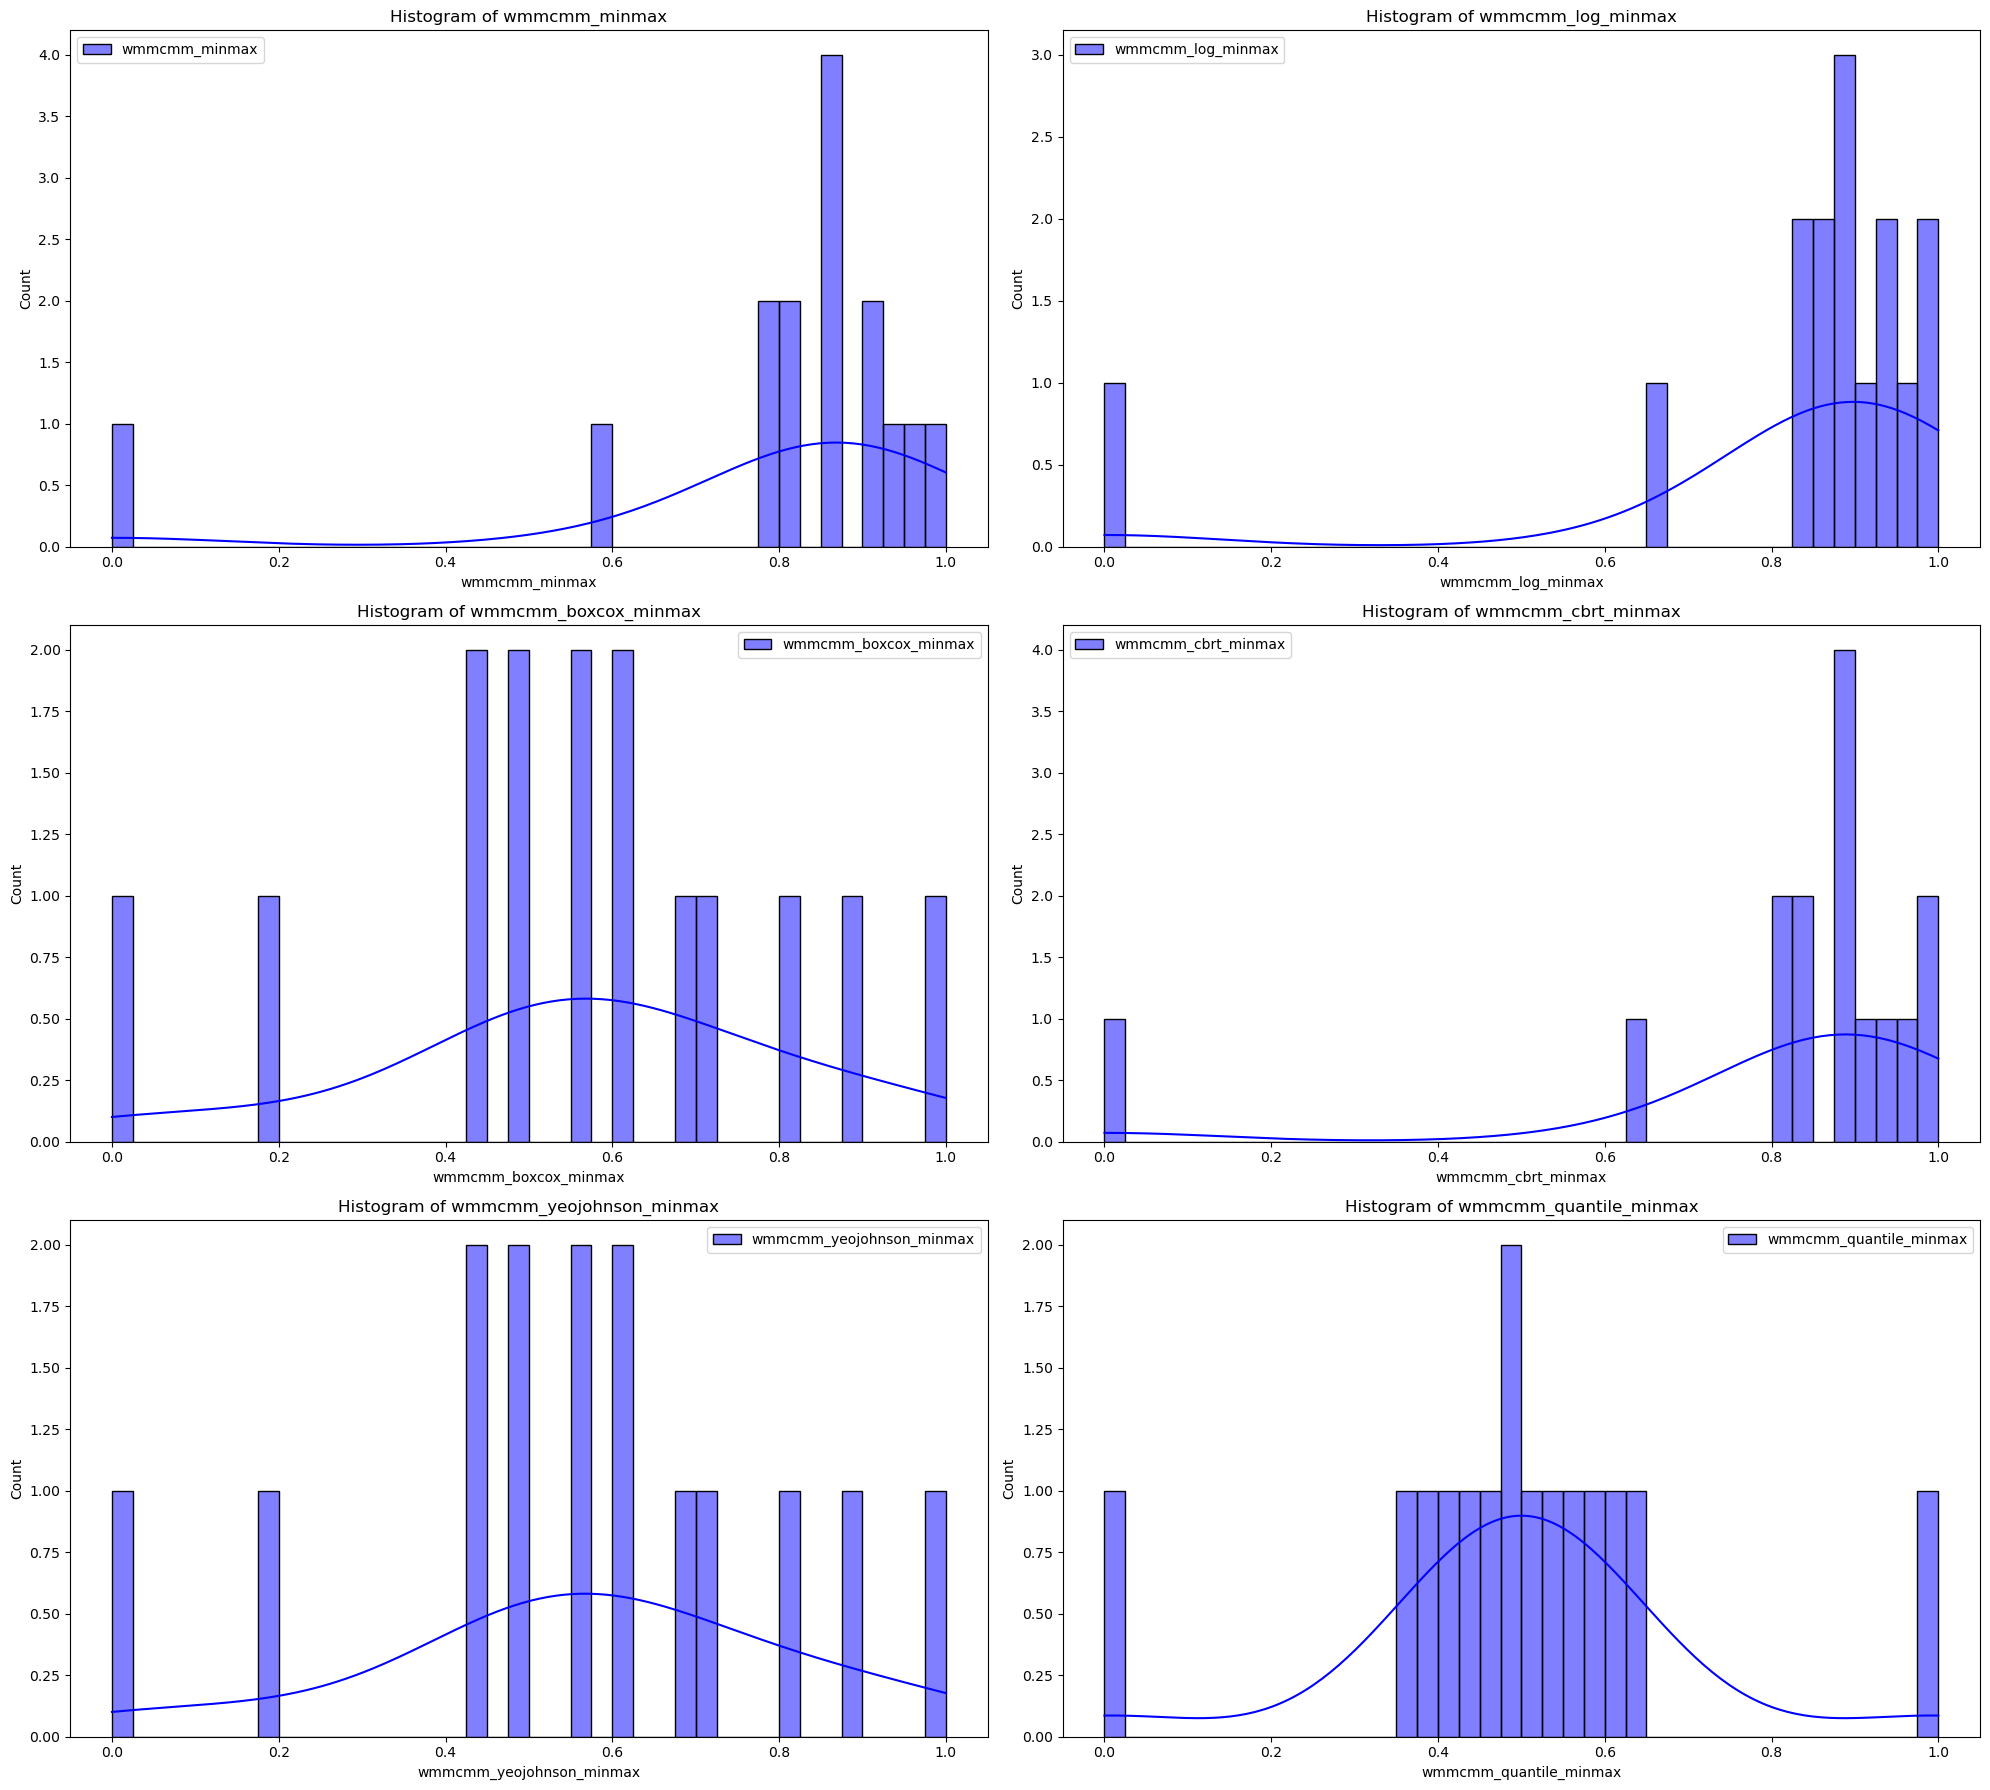

In [835]:
plot_histograms(
    'predictors_plots/env_vars_wmmcmm_minmax_transformations.pdf',
    (env_minmax, 'wmmcmm_minmax', 'blue'),
    (env_minmax, 'wmmcmm_log_minmax', 'blue'),
    (env_minmax, 'wmmcmm_boxcox_minmax', 'blue'),
    (env_minmax, 'wmmcmm_cbrt_minmax', 'blue'),
    (env_minmax, 'wmmcmm_yeojohnson_minmax', 'blue'), 
    (env_minmax, 'wmmcmm_quantile_minmax', 'blue')
)

In [836]:
# Code that did not go through the wmmcmm transformation testing of cube root, y-j, log, quantile, 
# Instead just did box-cox transformation and min-max scaling

# from sklearn.preprocessing import MinMaxScaler
# import scipy.stats as stats
# import numpy as np

# # Instatiating sklearn minmax scaler for each column
# scaler_map = MinMaxScaler()
# scaler_mat = MinMaxScaler()
# scaler_wmmcmm = MinMaxScaler()
# scaler_wmmcmm_boxcox = MinMaxScaler()

# # min max scaling map, mat, wmmcmm
# env_minmax['map_minmax'] = scaler_map.fit_transform(env_minmax[['map']])
# env_minmax['mat_minmax'] = scaler_mat.fit_transform(env_minmax[['mat']])
# env_minmax['wmmcmm_minmax'] = scaler_wmmcmm.fit_transform(env_minmax[['wmmcmm']])

# # Box-Cox transformation of wmmcmm, then min max scaling the wmmcmm_boxcox it
# env_minmax['wmmcmm_boxcox'], wmmcmm_lambda_param = stats.boxcox(env_minmax['wmmcmm'])
# env_minmax['wmmcmm_boxcox_minmax'] = scaler_wmmcmm_boxcox.fit_transform(env_minmax[['wmmcmm_boxcox']])

env_minmax

Stage       map        mat    wmmcmm     Time  map_minmax  \
14       Rhaetian  462.3523   9.002368  38.14543  201.300    0.434434   
13         Norian  493.4584   9.531891  38.12684  208.500    0.564025   
12        Carnian  579.0786  11.356960  38.48378  227.000    0.920728   
11       Ladinian  598.1063   9.841047  39.99329  237.000    1.000000   
10        Anisian  437.6114  -1.416807  40.43240  242.000    0.331360   
9       Olenekian  452.7017   2.212064  38.43882  247.200    0.394228   
8          Induan  479.7812   3.279027  39.15463  251.200    0.507044   
7   Changhsingian  492.8511   5.699131  36.81155  251.902    0.561495   
6   Wuchiapingian  475.3778   3.106955  37.37995  254.140    0.488699   
5      Capitanian  364.9878  -5.735454  39.24222  259.100    0.028802   
4         Wordian  358.0743  -6.750223  40.98974  265.100    0.000000   
3         Roadian  525.4787  12.470220  21.58670  268.800    0.697425   
2       Kungurian  503.1488   3.479318  37.42631  272.950    0.604396   
1      Artinskian  520.7936   3.638446  36.96527  283.500    0.677907   
0       Sakmarian  467.7526   1.625588  33.21412  290.100    0.456932   

    mat_minmax  wmmcmm_log  wmmcmm_boxcox  wmmcmm_cbrt  wmmcmm_yeojohnson  \
14    0.819575    3.641406   3.143370e+11     3.366259       8.412768e+11   
13    0.847125    3.640918   3.131387e+11     3.365712       8.380635e+11   
12    0.942079    3.650237   3.368577e+11     3.376182       9.016759e+11   
11    0.863210    3.688712   4.553798e+11     3.419761       1.219888e+12   
10    0.277487    3.699631   4.960586e+11     3.432231       1.329226e+12   
9     0.466289    3.649068   3.337863e+11     3.374867       8.934374e+11   
8     0.521801    3.667519   3.857051e+11     3.395687       1.032755e+12   
7     0.647714    3.605812   2.378321e+11     3.326555       6.362663e+11   
6     0.512849    3.621134   2.681717e+11     3.343589       7.175348e+11   
5     0.052796    3.669753   3.925178e+11     3.398218       1.051045e+12   
4     0.000000    3.713322   5.522305e+11     3.447930       1.480301e+12   
3     1.000000    3.072077   3.630846e+09     2.784382       1.002012e+10   
2     0.532222    3.622374   2.707888e+11     3.344971       7.245472e+11   
1     0.540501    3.609979   2.457260e+11     3.331179       6.574068e+11   
0     0.435776    3.502975   1.062489e+11     3.214457       2.843431e+11   

    wmmcmm_quantile  wmmcmm_minmax  wmmcmm_log_minmax  wmmcmm_boxcox_minmax  \
14         0.000000       0.853409           0.887850              0.566362   
13        -0.180012       0.852451           0.887089              0.564178   
12         0.366106       0.870847           0.901621              0.607414   
11         1.067571       0.948645           0.961621              0.823458   
10         1.465234       0.971276           0.978650              0.897609   
9          0.180012       0.868530           0.899798              0.601815   
8          0.565949       0.905422           0.928572              0.696454   
7         -1.067571       0.784663           0.832341              0.426907   
6         -0.565949       0.813958           0.856237              0.482211   
5          0.791639       0.909936           0.932056              0.708872   
4          5.199338       1.000000           1.000000              1.000000   
3         -5.199338       0.000000           0.000000              0.000000   
2         -0.366106       0.816347           0.858170              0.486982   
1         -0.791639       0.792586           0.838840              0.441297   
0         -1.465234       0.599258           0.671971              0.187055   

    wmmcmm_cbrt_minmax  wmmcmm_yeojohnson_minmax  wmmcmm_quantile_minmax  
14            0.876918                  0.565373                0.500000  
13            0.876094                  0.563187                0.482689  
12            0.891873                  0.606453                0.535207  
11            0.957548                  0.822

In [837]:
env_minmax_only = env_minmax[['Time', 'map_minmax', 'mat_minmax', 'wmmcmm_minmax']]
env_minmax_boxcox = env_minmax[['Time', 'map_minmax', 'mat_minmax', 'wmmcmm_boxcox_minmax']]
env_minmax_only

Time  map_minmax  mat_minmax  wmmcmm_minmax
14  201.300    0.434434    0.819575       0.853409
13  208.500    0.564025    0.847125       0.852451
12  227.000    0.920728    0.942079       0.870847
11  237.000    1.000000    0.863210       0.948645
10  242.000    0.331360    0.277487       0.971276
9   247.200    0.394228    0.466289       0.868530
8   251.200    0.507044    0.521801       0.905422
7   251.902    0.561495    0.647714       0.784663
6   254.140    0.488699    0.512849       0.813958
5   259.100    0.028802    0.052796       0.909936
4   265.100    0.000000    0.000000       1.000000
3   268.800    0.697425    1.000000       0.000000
2   272.950    0.604396    0.532222       0.816347
1   283.500    0.677907    0.540501       0.792586
0   290.100    0.456932    0.435776       0.599258

In [838]:
env_minmax_boxcox

Time  map_minmax  mat_minmax  wmmcmm_boxcox_minmax
14  201.300    0.434434    0.819575              0.566362
13  208.500    0.564025    0.847125              0.564178
12  227.000    0.920728    0.942079              0.607414
11  237.000    1.000000    0.863210              0.823458
10  242.000    0.331360    0.277487              0.897609
9   247.200    0.394228    0.466289              0.601815
8   251.200    0.507044    0.521801              0.696454
7   251.902    0.561495    0.647714              0.426907
6   254.140    0.488699    0.512849              0.482211
5   259.100    0.028802    0.052796              0.708872
4   265.100    0.000000    0.000000              1.000000
3   268.800    0.697425    1.000000              0.000000
2   272.950    0.604396    0.532222              0.486982
1   283.500    0.677907    0.540501              0.441297
0   290.100    0.456932    0.435776              0.187055

In [839]:
env_minmax_only.to_csv('env_vars_data/env_vars_minmax_only.txt', sep='\t', index=False)
env_minmax_boxcox.to_csv('env_vars_data/env_vars_minmax_boxcox.txt', sep='\t', index=False)

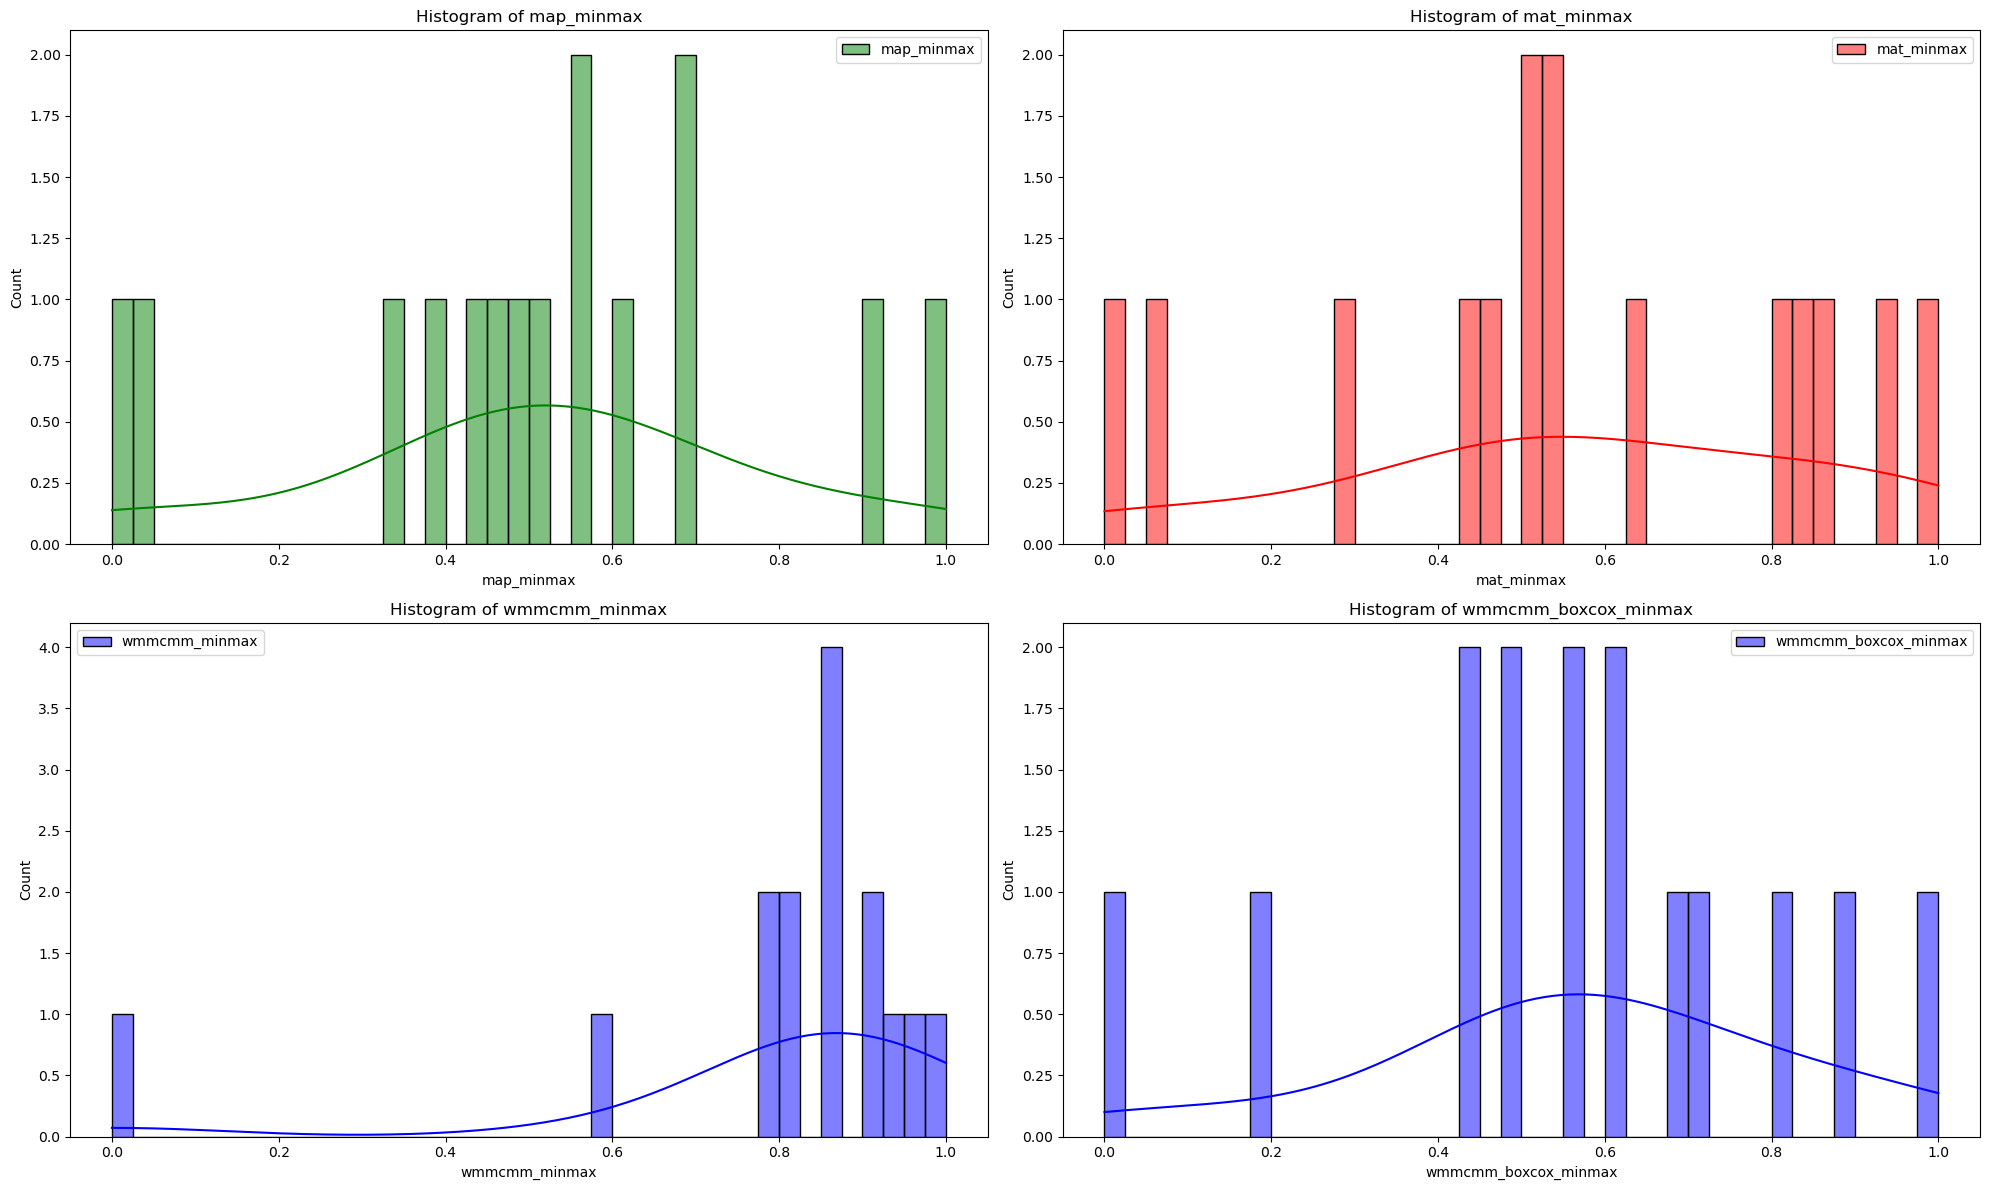

In [840]:
# Graphing all of the final env_minmax vars minmax'd, together
plot_histograms(
    'predictors_plots/env_vars_minmax_all.pdf',
    (env_minmax, 'map_minmax', 'green'),
    (env_minmax, 'mat_minmax', 'red'),
    (env_minmax, 'wmmcmm_minmax', 'blue'),
    (env_minmax, 'wmmcmm_boxcox_minmax', 'blue'),
)

## 1myr Temp Data

For use with BDNN with no -fixShift (Birth Death Model time bins). We will have BDNN with the default 1 million year time bins, so we want to submit it with environmental variables for which we also have 1 myr resolution. That is the temp data csv below!

Notes from Tiago: "Use as predictors: mean temperature per 1 Myr ("mean") and modal value for rate of temperature change per 1 Myr ("Mod_R_deltaTMyr"). The ages ("age") go until 202Ma only, but that's because there is too much missing data for 201 and 200Ma. Still, it will get through all the important time periods we need."

In [ ]:
myr_temp = pd.read_csv('PaleoEnvData_1MyrBins.csv')
myr_temp = myr_temp.drop(columns=['X0.05', 'X0.95'])
myr_temp = myr_temp.iloc[::-1]
myr_temp

age       mean  Mod_R_deltaTMyr
84  202  28.436988         1.958998
83  203  30.395986         0.281265
82  204  30.114721         0.830439
81  205  29.284282         1.156205
80  206  30.440487         0.988279
..  ...        ...              ...
4   296  29.660536         1.549450
3   297  28.111086         1.091868
2   298  27.019217         2.372964
1   299  29.392182         1.039204
0   300  30.431385         0.496400

[85 rows x 3 columns]

### Visalizing Distributions

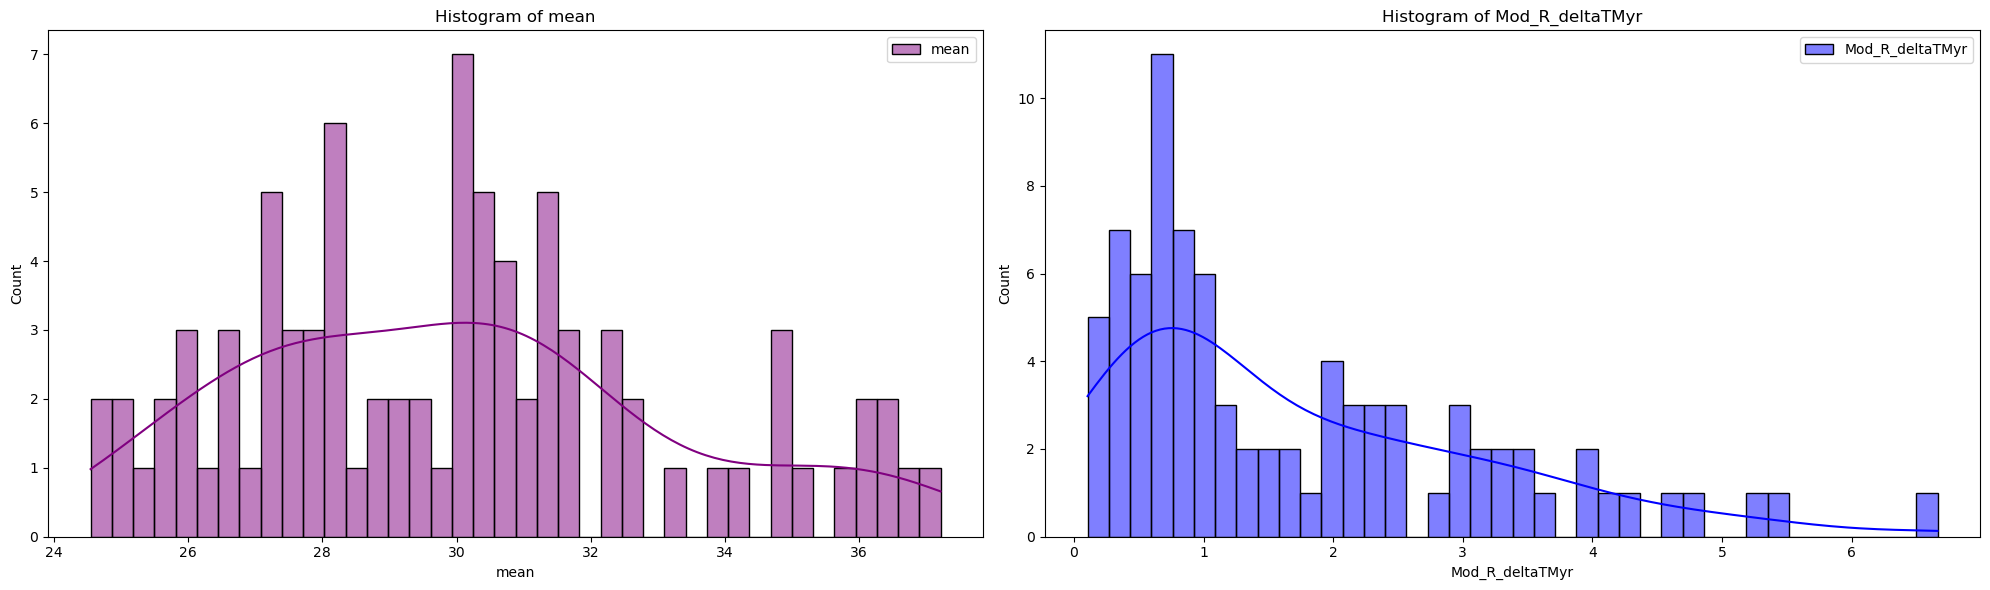

In [842]:
plot_histograms(
    'predictors_plots/1myr_temp_original.pdf',
    (myr_temp, 'mean', 'purple'),
    (myr_temp, 'Mod_R_deltaTMyr', 'blue')
)

In [843]:
mean_scaler = StandardScaler()
myr_temp['mean_scaled'] = mean_scaler.fit_transform(myr_temp[['mean']])
myr_temp

age       mean  Mod_R_deltaTMyr  mean_scaled
84  202  28.436988         1.958998    -0.493105
83  203  30.395986         0.281265     0.124157
82  204  30.114721         0.830439     0.035533
81  205  29.284282         1.156205    -0.226130
80  206  30.440487         0.988279     0.138179
..  ...        ...              ...          ...
4   296  29.660536         1.549450    -0.107576
3   297  28.111086         1.091868    -0.595793
2   298  27.019217         2.372964    -0.939830
1   299  29.392182         1.039204    -0.192132
0   300  30.431385         0.496400     0.135311

[85 rows x 4 columns]

### Testing 'Mod..." Transformations

In [ ]:
# TESTING DIFFERENT TRANSFORMATIONS FOR Mod_R_deltaTMyr's LEFT SKEW

import scipy.stats as stats

# 1. Log transformation
myr_temp['Mod_R_deltaTMyr_log'] = np.log(myr_temp['Mod_R_deltaTMyr'])

# 2. Box-Cox transformation
myr_temp['Mod_R_deltaTMyr_boxcox'], Mod_R_deltaTMyr_boxcox_lambda_param = stats.boxcox(myr_temp['Mod_R_deltaTMyr'])

# 3. Cube root transformation
myr_temp['Mod_R_deltaTMyr_cbrt'] = np.cbrt(myr_temp['Mod_R_deltaTMyr'])

# 4. Yeo-Johnson transformation
myr_temp['Mod_R_deltaTMyr_yeojohnson'], Mod_R_deltaTMyr_yeojohnson_lambda_param = stats.yeojohnson(myr_temp['Mod_R_deltaTMyr'])

# 5. Quantile transformation
myr_temp['Mod_R_deltaTMyr_quantile'] = QuantileTransformer(output_distribution='normal').fit_transform(myr_temp['Mod_R_deltaTMyr'].values.reshape(-1, 1))

# 5. StandardScaler normalization function, instatiating a new scaler for each column passed to the function
def standardize_column(column):
    scaler = StandardScaler()
    return scaler.fit_transform(column.values.reshape(-1, 1))

# 6. Apply standardization to original and all transformations
for suffix in ['', '_log', '_boxcox', '_cbrt', '_yeojohnson', '_quantile']:
    col = f'Mod_R_deltaTMyr{suffix}'
    myr_temp[f'Mod_R_deltaTMyr{suffix}_scaled'] = standardize_column(myr_temp[col])

# 7. Print summary statistics to help choose the best transformation. 
# #We want the lowest skew value possible (closer to 0 = closer to normal distribution)
# print by lowest .skew first, ascending order
print("\nSkewness comparison (closest to 0 is best):")
print(myr_temp[['Mod_R_deltaTMyr_scaled', 'Mod_R_deltaTMyr_log_scaled', 'Mod_R_deltaTMyr_boxcox_scaled', 'Mod_R_deltaTMyr_cbrt_scaled', 
           'Mod_R_deltaTMyr_yeojohnson_scaled', 'Mod_R_deltaTMyr_quantile_scaled']].skew().sort_values())

# 8. Check normality using Shapiro-Wilk test
# We want the highest p-value possible
# We also want the highest statistic possible (closer to 1 = closer to normal distribution)
for suffix in ['', '_log', '_boxcox', '_cbrt', '_yeojohnson', '_quantile']:
    col = f'Mod_R_deltaTMyr{suffix}_scaled'
    stat, p_value = stats.shapiro(myr_temp[col])
    print(f"\nShapiro-Wilk test for {col}:")
    print(f"Shapiro-Wilk Statistic (closest to 1 is best): {stat:.4f}, p-value (higher is better): {p_value:.4f}")
 
# Print the lambda parameter from Box-Cox transform
print(f"\nBox-Cox transformation lambda parameter: {Mod_R_deltaTMyr_boxcox_lambda_param:.4f}")
print(f"Yeo-Johnson transformation lambda parameter: {Mod_R_deltaTMyr_yeojohnson_lambda_param:.4f}")


Skewness comparison (closest to 0 is best):
Mod_R_deltaTMyr_log_scaled          -3.490566e-01
Mod_R_deltaTMyr_boxcox_scaled       -4.261891e-02
Mod_R_deltaTMyr_quantile_scaled      4.758913e-11
Mod_R_deltaTMyr_yeojohnson_scaled    8.189581e-02
Mod_R_deltaTMyr_cbrt_scaled          2.248133e-01
Mod_R_deltaTMyr_scaled               1.157639e+00
dtype: float64

Shapiro-Wilk test for Mod_R_deltaTMyr_scaled:
Shapiro-Wilk Statistic (closest to 1 is best): 0.8785, p-value (higher is better): 0.0000

Shapiro-Wilk test for Mod_R_deltaTMyr_log_scaled:
Shapiro-Wilk Statistic (closest to 1 is best): 0.9742, p-value (higher is better): 0.0856

Shapiro-Wilk test for Mod_R_deltaTMyr_boxcox_scaled:
Shapiro-Wilk Statistic (closest to 1 is best): 0.9804, p-value (higher is better): 0.2227

Shapiro-Wilk test for Mod_R_deltaTMyr_cbrt_scaled:
Shapiro-Wilk Statistic (closest to 1 is best): 0.9745, p-value (higher is better): 0.0901

Shapiro-Wilk test for Mod_R_deltaTMyr_yeojohnson_scaled:
Shapiro-Wilk Stati

c:\Users\SimoesLabAdmin\anaconda3\envs\env\lib\site-packages\sklearn\preprocessing\_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (85). n_quantiles is set to n_samples.
  warnings.warn(


In [845]:
# Just like env['wmmcmm'], boxcox is the best transformation
myr_temp

age       mean  Mod_R_deltaTMyr  mean_scaled  Mod_R_deltaTMyr_log  \
84  202  28.436988         1.958998    -0.493105             0.672433   
83  203  30.395986         0.281265     0.124157            -1.268456   
82  204  30.114721         0.830439     0.035533            -0.185801   
81  205  29.284282         1.156205    -0.226130             0.145143   
80  206  30.440487         0.988279     0.138179            -0.011790   
..  ...        ...              ...          ...                  ...   
4   296  29.660536         1.549450    -0.107576             0.437900   
3   297  28.111086         1.091868    -0.595793             0.087890   
2   298  27.019217         2.372964    -0.939830             0.864140   
1   299  29.392182         1.039204    -0.192132             0.038455   
0   300  30.431385         0.496400     0.135311            -0.700373   

    Mod_R_deltaTMyr_boxcox  Mod_R_deltaTMyr_cbrt  Mod_R_deltaTMyr_yeojohnson  \
84                0.712063              1.251252                    0.862215   
83               -1.141909              0.655197                    0.234783   
82               -0.182919              0.939945                    0.530674   
81                0.146935              1.049571                    0.651711   
80               -0.011779              0.996078                    0.592888   
..                     ...                   ...                         ...   
4                 0.454483              1.157158                    0.766787   
3                 0.088545              1.029730                    0.629980   
2                 0.930311              1.333820                    0.941068   
1                 0.038580              1.012901                    0.611462   
0                -0.660575              0.791791                    0.369271   

    Mod_R_deltaTMyr_quantile  Mod_R_deltaTMyr_scaled  \
84                  0.302980                0.155316   
83                 -1.465234               -1.015368   
82                 -0.302980               -0.632168   
81                  0.059717               -0.404855   
80                 -0.119648               -0.522030   
..                       ...                     ...   
4                   0.180012               -0.130457   
3                   0.000000               -0.449748   
2                   0.601332                0.444172   
1                  -0.089642               -0.486496   
0                  -1.016222               -0.865252   

    Mod_R_deltaTMyr_log_scaled  Mod_R_deltaTMyr_boxcox_scaled  \
84                    0.534932                       0.486697   
83                   -1.538559                      -1.463229   
82                   -0.381937                      -0.454606   
81                   -0.028382                      -0.107679   
80                   -0.196038                      -0.274608   
..                         ...                            ...   
4                     0.284376                       0.215786   
3                    -0.089547                      -0.169091   
2                     0.739736                       0.716242   
1                    -0.142360                      -0.221643   
0                    -0.931664                      -0.956983   

    Mod_R_deltaTMyr_cbrt_scaled  Mod_R_deltaTMyr_yeojohnson_scaled  \
84                     0.429360                           0.510654   
83                    -1.377220                          -1.434172   
82                    -0.514179                          -0.517011   
81                    -0.181915                          -0.141836   
80                    -0.344047                          -0.324167   
..                          ...                                ...   
4                      0.144170                           0.214860   
3                     -0.242050                          -0.209194   
2                      0.679614                           0.755073   
1           

### Graphing Transformed Data

In [846]:
myr_temp['Mod_R_deltaTMyr'].describe()

count    85.000000
mean      1.736411
std       1.441626
min       0.105389
25%       0.670915
50%       1.091868
75%       2.486576
max       6.661907
Name: Mod_R_deltaTMyr, dtype: float64

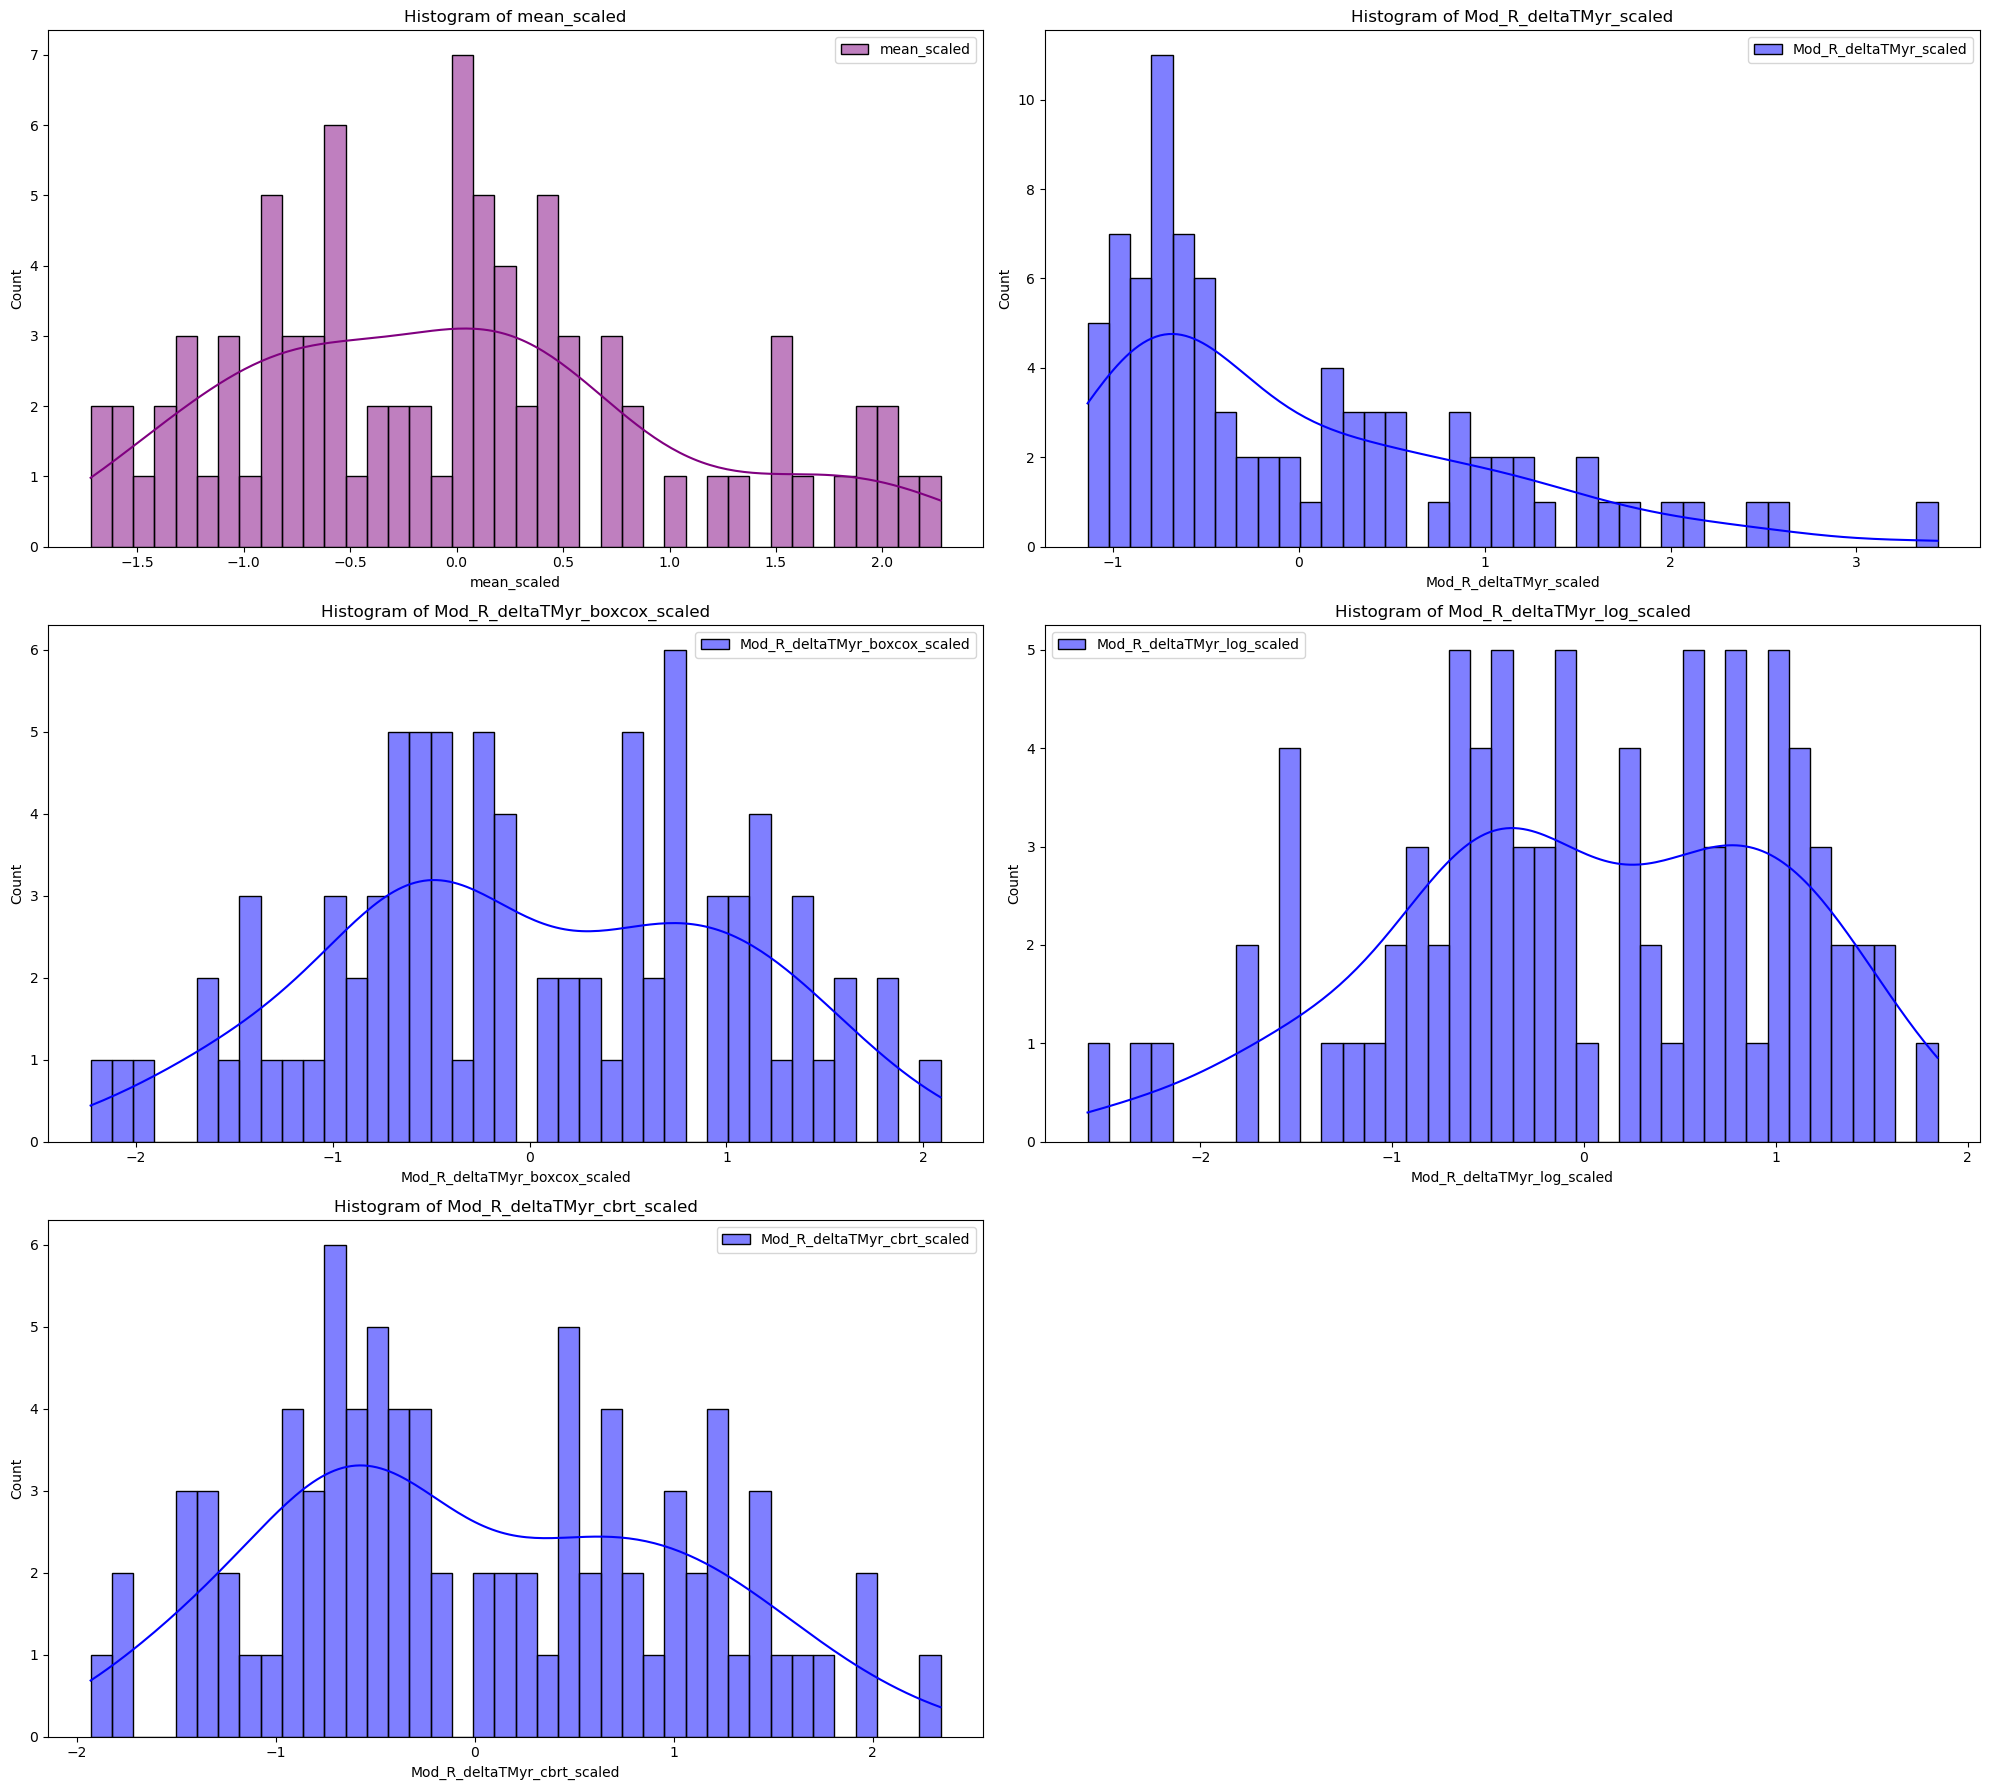

In [847]:
#
# Graphing all of the final myr_temp vars scaled, together
plot_histograms(
    'predictors_plots/1myr_temp_standardscaled_all.pdf',
    (myr_temp, 'mean_scaled', 'purple'),
    (myr_temp, 'Mod_R_deltaTMyr_scaled', 'blue'),
    (myr_temp, 'Mod_R_deltaTMyr_boxcox_scaled', 'blue'),
    (myr_temp, 'Mod_R_deltaTMyr_log_scaled', 'blue'),
    (myr_temp, 'Mod_R_deltaTMyr_cbrt_scaled', 'blue'),
)

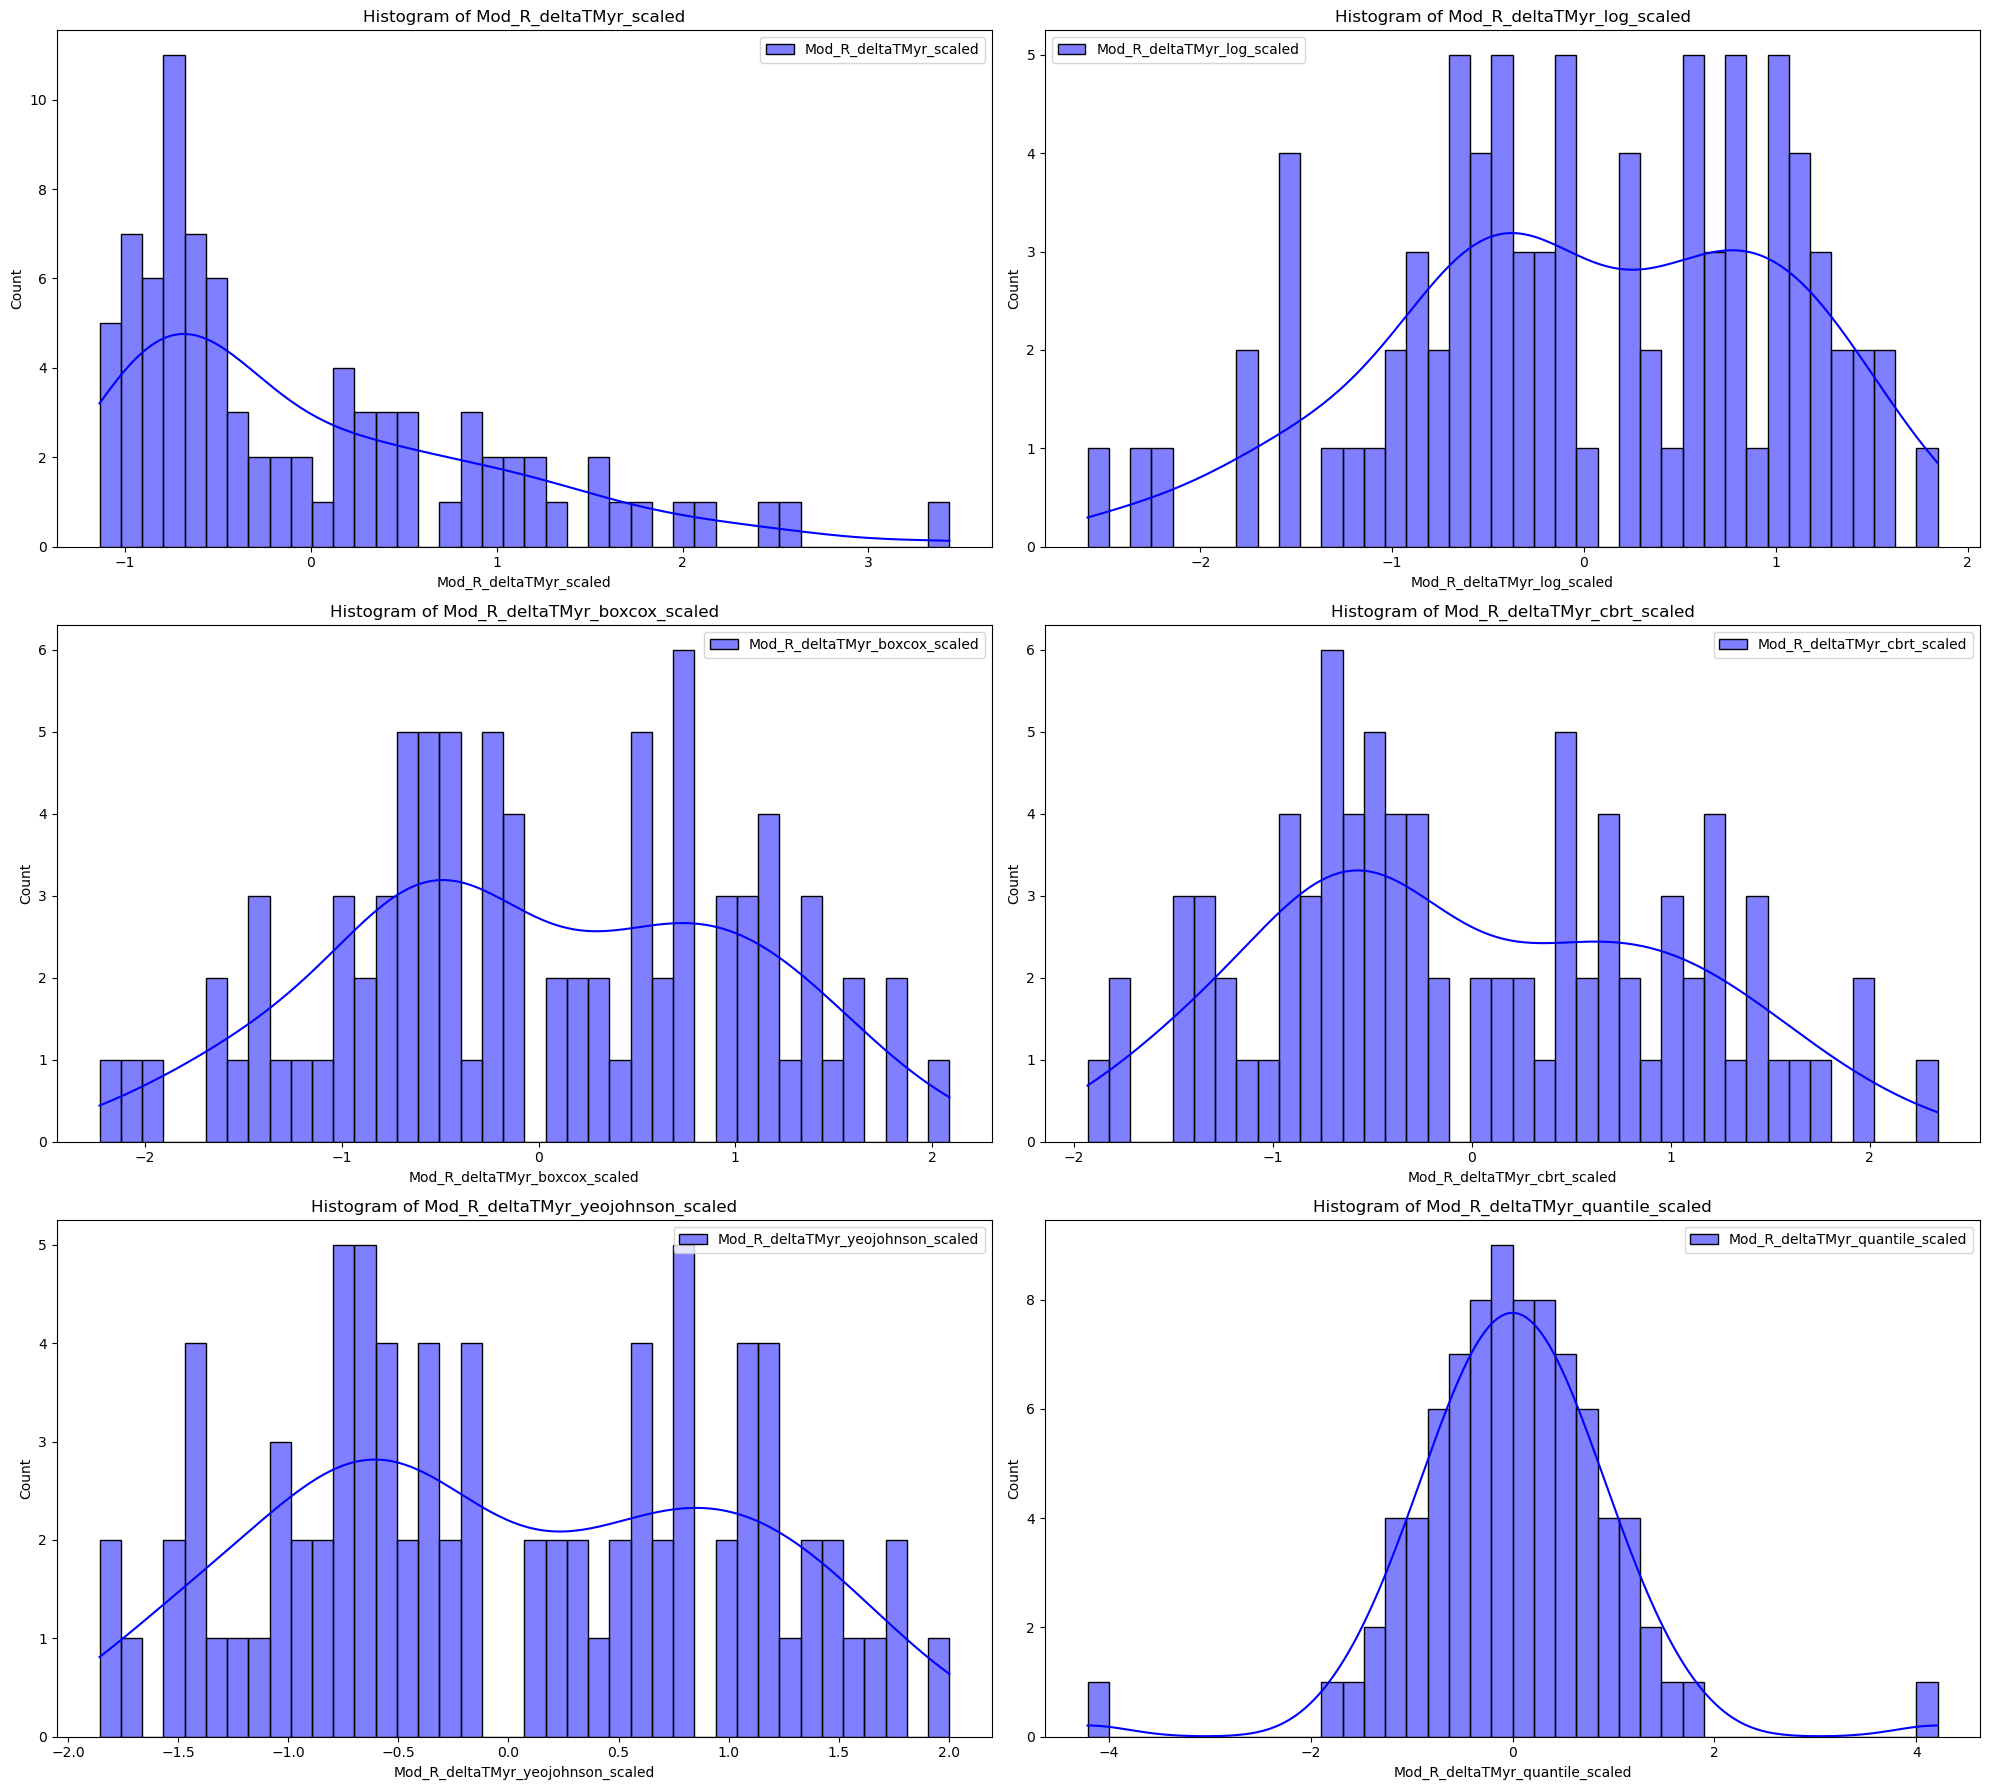

In [848]:
# Mod only
plot_histograms(
    'predictors_plots/1myr_temp_Mod_standardscaled_transformations.pdf',
    (myr_temp, 'Mod_R_deltaTMyr_scaled', 'blue'),
    (myr_temp, 'Mod_R_deltaTMyr_log_scaled', 'blue'),
    (myr_temp, 'Mod_R_deltaTMyr_boxcox_scaled', 'blue'),
    (myr_temp, 'Mod_R_deltaTMyr_cbrt_scaled', 'blue'),
    (myr_temp, 'Mod_R_deltaTMyr_yeojohnson_scaled', 'blue'), 
    (myr_temp, 'Mod_R_deltaTMyr_quantile_scaled', 'blue')
)

### Final 2 1myr_temp.txts

In [849]:
myr_temp.rename(columns={'age': 'Time'}, inplace=True)
myr_temp.head()

Time       mean  Mod_R_deltaTMyr  mean_scaled  Mod_R_deltaTMyr_log  \
84   202  28.436988         1.958998    -0.493105             0.672433   
83   203  30.395986         0.281265     0.124157            -1.268456   
82   204  30.114721         0.830439     0.035533            -0.185801   
81   205  29.284282         1.156205    -0.226130             0.145143   
80   206  30.440487         0.988279     0.138179            -0.011790   

    Mod_R_deltaTMyr_boxcox  Mod_R_deltaTMyr_cbrt  Mod_R_deltaTMyr_yeojohnson  \
84                0.712063              1.251252                    0.862215   
83               -1.141909              0.655197                    0.234783   
82               -0.182919              0.939945                    0.530674   
81                0.146935              1.049571                    0.651711   
80               -0.011779              0.996078                    0.592888   

    Mod_R_deltaTMyr_quantile  Mod_R_deltaTMyr_scaled  \
84                  0.302980                0.155316   
83                 -1.465234               -1.015368   
82                 -0.302980               -0.632168   
81                  0.059717               -0.404855   
80                 -0.119648               -0.522030   

    Mod_R_deltaTMyr_log_scaled  Mod_R_deltaTMyr_boxcox_scaled  \
84                    0.534932                       0.486697   
83                   -1.538559                      -1.463229   
82                   -0.381937                      -0.454606   
81                   -0.028382                      -0.107679   
80                   -0.196038                      -0.274608   

    Mod_R_deltaTMyr_cbrt_scaled  Mod_R_deltaTMyr_yeojohnson_scaled  \
84                     0.429360                           0.510654   
83                    -1.377220                          -1.434172   
82                    -0.514179                          -0.517011   
81                    -0.181915                          -0.141836   
80                    -0.344047                          -0.324167   

    Mod_R_deltaTMyr_quantile_scaled  
84                         0.245297  
83                        -1.186272  
82                        -0.245297  
81                         0.048348  
80                        -0.096869

In [850]:
myr_temp_scaled = myr_temp[['Time', 'mean_scaled', 'Mod_R_deltaTMyr_scaled']]
myr_temp_scaled.to_csv('1myr_temp_data/1myr_temp_scaled_only.txt', sep='\t', index=False)
myr_temp_scaled

Time  mean_scaled  Mod_R_deltaTMyr_scaled
84   202    -0.493105                0.155316
83   203     0.124157               -1.015368
82   204     0.035533               -0.632168
81   205    -0.226130               -0.404855
80   206     0.138179               -0.522030
..   ...          ...                     ...
4    296    -0.107576               -0.130457
3    297    -0.595793               -0.449748
2    298    -0.939830                0.444172
1    299    -0.192132               -0.486496
0    300     0.135311               -0.865252

[85 rows x 3 columns]

In [851]:
myr_temp_boxcox = myr_temp[['Time', 'mean_scaled', 'Mod_R_deltaTMyr_boxcox_scaled']]
myr_temp_boxcox.to_csv('1myr_temp_data/1myr_temp_scaled_boxcox.txt', sep='\t', index=False)
myr_temp_boxcox

Time  mean_scaled  Mod_R_deltaTMyr_boxcox_scaled
84   202    -0.493105                       0.486697
83   203     0.124157                      -1.463229
82   204     0.035533                      -0.454606
81   205    -0.226130                      -0.107679
80   206     0.138179                      -0.274608
..   ...          ...                            ...
4    296    -0.107576                       0.215786
3    297    -0.595793                      -0.169091
2    298    -0.939830                       0.716242
1    299    -0.192132                      -0.221643
0    300     0.135311                      -0.956983

[85 rows x 3 columns]

In [852]:
myr_temp_log = myr_temp[['Time', 'mean_scaled', 'Mod_R_deltaTMyr_log_scaled']]
myr_temp_log.to_csv('1myr_temp_data/1myr_temp_scaled_log.txt', sep='\t', index=False)
myr_temp_log

Time  mean_scaled  Mod_R_deltaTMyr_log_scaled
84   202    -0.493105                    0.534932
83   203     0.124157                   -1.538559
82   204     0.035533                   -0.381937
81   205    -0.226130                   -0.028382
80   206     0.138179                   -0.196038
..   ...          ...                         ...
4    296    -0.107576                    0.284376
3    297    -0.595793                   -0.089547
2    298    -0.939830                    0.739736
1    299    -0.192132                   -0.142360
0    300     0.135311                   -0.931664

[85 rows x 3 columns]

In [853]:
myr_temp_cbrt = myr_temp[['Time', 'mean_scaled', 'Mod_R_deltaTMyr_cbrt_scaled']]
myr_temp_cbrt.to_csv('1myr_temp_data/1myr_temp_scaled_cbrt.txt', sep='\t', index=False)
myr_temp_cbrt

Time  mean_scaled  Mod_R_deltaTMyr_cbrt_scaled
84   202    -0.493105                     0.429360
83   203     0.124157                    -1.377220
82   204     0.035533                    -0.514179
81   205    -0.226130                    -0.181915
80   206     0.138179                    -0.344047
..   ...          ...                          ...
4    296    -0.107576                     0.144170
3    297    -0.595793                    -0.242050
2    298    -0.939830                     0.679614
1    299    -0.192132                    -0.293058
0    300     0.135311                    -0.963218

[85 rows x 3 columns]

### Saving Final Backscale.txt

In [854]:
rep_backscale['mean_scaled'] = [myr_temp['mean'].mean(), myr_temp['mean'].std(), np.nan]
rep_backscale['Mod_R_deltaTMyr_scaled'] = [myr_temp['Mod_R_deltaTMyr'].mean(), myr_temp['Mod_R_deltaTMyr'].std(), np.nan]
rep_backscale['Mod_R_deltaTMyr_boxcox_scaled'] = [myr_temp['Mod_R_deltaTMyr_boxcox'].mean(), myr_temp['Mod_R_deltaTMyr_boxcox'].std(), Mod_R_deltaTMyr_boxcox_lambda_param]
rep_backscale['Mod_R_deltaTMyr_log_scaled'] = [myr_temp['Mod_R_deltaTMyr_log'].mean(), myr_temp['Mod_R_deltaTMyr_log'].std(), np.nan]
rep_backscale['Mod_R_deltaTMyr_cbrt_scaled'] = [myr_temp['Mod_R_deltaTMyr_cbrt'].mean(), myr_temp['Mod_R_deltaTMyr_cbrt'].std(), np.nan]

rep_backscale

rotated_lat_scaled  rotated_lon_scaled  map_scaled  mat_scaled  \
0           -1.649635            1.843582  480.770307    4.089369   
1           34.773192           44.310370   65.186473    5.785585   
2                 NaN                 NaN         NaN         NaN   

   wmmcmm_scaled  wmmcmm_boxcox_scaled  mean_scaled  Mod_R_deltaTMyr_scaled  \
0      37.092737          3.141607e+11    30.001950                1.736411   
1       4.669959          1.404148e+11     3.192528                1.441626   
2            NaN          7.835545e+00          NaN                     NaN   

   Mod_R_deltaTMyr_boxcox_scaled  Mod_R_deltaTMyr_log_scaled  \
0                       0.249316                    0.171710   
1                       0.956433                    0.941604   
2                       0.168720                         NaN   

   Mod_R_deltaTMyr_cbrt_scaled  
0                     1.109591  
1                     0.331893  
2                          NaN

In [855]:
syn_backscale['mean_scaled'] = [myr_temp['mean'].mean(), myr_temp['mean'].std(), np.nan]
syn_backscale['Mod_R_deltaTMyr_scaled'] = [myr_temp['Mod_R_deltaTMyr'].mean(), myr_temp['Mod_R_deltaTMyr'].std(), np.nan]
syn_backscale['Mod_R_deltaTMyr_boxcox_scaled'] = [myr_temp['Mod_R_deltaTMyr_boxcox'].mean(), myr_temp['Mod_R_deltaTMyr_boxcox'].std(), Mod_R_deltaTMyr_boxcox_lambda_param]
syn_backscale['Mod_R_deltaTMyr_log_scaled'] = [myr_temp['Mod_R_deltaTMyr_log'].mean(), myr_temp['Mod_R_deltaTMyr_log'].std(), np.nan]
syn_backscale['Mod_R_deltaTMyr_cbrt_scaled'] = [myr_temp['Mod_R_deltaTMyr_cbrt'].mean(), myr_temp['Mod_R_deltaTMyr_cbrt'].std(), np.nan]

syn_backscale

rotated_lat_scaled  rotated_lon_scaled  map_scaled  mat_scaled  \
0          -34.660461           -5.783020  480.770307    4.089369   
1           37.792281           29.052976   65.186473    5.785585   
2                 NaN                 NaN         NaN         NaN   

   wmmcmm_scaled  wmmcmm_boxcox_scaled  mean_scaled  Mod_R_deltaTMyr_scaled  \
0      37.092737          3.141607e+11    30.001950                1.736411   
1       4.669959          1.404148e+11     3.192528                1.441626   
2            NaN          7.835545e+00          NaN                     NaN   

   Mod_R_deltaTMyr_boxcox_scaled  Mod_R_deltaTMyr_log_scaled  \
0                       0.249316                    0.171710   
1                       0.956433                    0.941604   
2                       0.168720                         NaN   

   Mod_R_deltaTMyr_cbrt_scaled  
0                     1.109591  
1                     0.331893  
2                          NaN

In [856]:
tem_backscale['mean_scaled'] = [myr_temp['mean'].mean(), myr_temp['mean'].std(), np.nan]
tem_backscale['Mod_R_deltaTMyr_scaled'] = [myr_temp['Mod_R_deltaTMyr'].mean(), myr_temp['Mod_R_deltaTMyr'].std(), np.nan]
tem_backscale['Mod_R_deltaTMyr_boxcox_scaled'] = [myr_temp['Mod_R_deltaTMyr_boxcox'].mean(), myr_temp['Mod_R_deltaTMyr_boxcox'].std(), Mod_R_deltaTMyr_boxcox_lambda_param]
tem_backscale['Mod_R_deltaTMyr_log_scaled'] = [myr_temp['Mod_R_deltaTMyr_log'].mean(), myr_temp['Mod_R_deltaTMyr_log'].std(), np.nan]
tem_backscale['Mod_R_deltaTMyr_cbrt_scaled'] = [myr_temp['Mod_R_deltaTMyr_cbrt'].mean(), myr_temp['Mod_R_deltaTMyr_cbrt'].std(), np.nan]

tem_backscale

rotated_lat_scaled  rotated_lon_scaled  map_scaled  mat_scaled  \
0           12.929946            9.319296  480.770307    4.089369   
1           29.203648           36.968738   65.186473    5.785585   
2                 NaN                 NaN         NaN         NaN   

   wmmcmm_scaled  wmmcmm_boxcox_scaled  mean_scaled  Mod_R_deltaTMyr_scaled  \
0      37.092737          3.141607e+11    30.001950                1.736411   
1       4.669959          1.404148e+11     3.192528                1.441626   
2            NaN          7.835545e+00          NaN                     NaN   

   Mod_R_deltaTMyr_boxcox_scaled  Mod_R_deltaTMyr_log_scaled  \
0                       0.249316                    0.171710   
1                       0.956433                    0.941604   
2                       0.168720                         NaN   

   Mod_R_deltaTMyr_cbrt_scaled  
0                     1.109591  
1                     0.331893  
2                          NaN

In [857]:
rep_backscale.to_csv('reptilia_processed_data/reptilia_backscale.txt', sep='\t', index=False)
syn_backscale.to_csv('synapsida_processed_data/synapsida_backscale.txt', sep='\t', index=False)
tem_backscale.to_csv('temnospondyli_processed_data/temnospondyli_backscale.txt', sep='\t', index=False)

### Adding to MBD Directory

In [858]:
myr_temp_scaled = pd.read_csv('1myr_temp_data/1myr_temp_scaled_only.txt', sep='\t')
myr_temp_scaled['Time'] = myr_temp_scaled['Time'] - 175.0
mean_temp = myr_temp_scaled[['Time', 'mean_scaled']]
Mod = myr_temp_scaled[['Time', 'Mod_R_deltaTMyr_scaled']]

myr_temp_scaled

Time  mean_scaled  Mod_R_deltaTMyr_scaled
0    27.0    -0.493105                0.155316
1    28.0     0.124157               -1.015368
2    29.0     0.035533               -0.632168
3    30.0    -0.226130               -0.404855
4    31.0     0.138179               -0.522030
..    ...          ...                     ...
80  121.0    -0.107576               -0.130457
81  122.0    -0.595793               -0.449748
82  123.0    -0.939830                0.444172
83  124.0    -0.192132               -0.486496
84  125.0     0.135311               -0.865252

[85 rows x 3 columns]

In [859]:
mean_temp

Time  mean_scaled
0    27.0    -0.493105
1    28.0     0.124157
2    29.0     0.035533
3    30.0    -0.226130
4    31.0     0.138179
..    ...          ...
80  121.0    -0.107576
81  122.0    -0.595793
82  123.0    -0.939830
83  124.0    -0.192132
84  125.0     0.135311

[85 rows x 2 columns]

In [860]:
mean_temp.to_csv('1myr_temp_data/MBD/mean_scaled.txt', sep='\t', index=False)
Mod.to_csv('1myr_temp_data/MBD/Mod_scaled.txt', sep='\t', index=False)

### Min Max Scaling

In [861]:
from sklearn.preprocessing import MinMaxScaler
import scipy.stats as stats
import numpy as np

# Load in, filter to 2 cols needed, flip time so that most recent is first
myr_temp_minmax = pd.read_csv('PaleoEnvData_1MyrBins.csv')
myr_temp_minmax = myr_temp_minmax.drop(columns=['X0.05', 'X0.95'])
myr_temp_minmax = myr_temp_minmax.iloc[::-1]

# Min max scale columns
myr_temp_minmax['mean_minmax'] = MinMaxScaler().fit_transform(myr_temp_minmax[['mean']])
myr_temp_minmax['Mod_R_deltaTMyr_minmax'] = MinMaxScaler().fit_transform(myr_temp_minmax[['Mod_R_deltaTMyr']])

# 1. Log transformation
myr_temp_minmax['Mod_R_deltaTMyr_log'] = np.log(myr_temp_minmax['Mod_R_deltaTMyr'])
myr_temp_minmax['Mod_R_deltaTMyr_log_minmax'] = MinMaxScaler().fit_transform(myr_temp_minmax[['Mod_R_deltaTMyr_log']])

# 2. Box-Cox transformation
myr_temp_minmax['Mod_R_deltaTMyr_boxcox'], mean_lambda_param = stats.boxcox(myr_temp_minmax['Mod_R_deltaTMyr'])
myr_temp_minmax['Mod_R_deltaTMyr_boxcox_minmax'] = MinMaxScaler().fit_transform(myr_temp_minmax[['Mod_R_deltaTMyr_boxcox']])

# 3. Cube root transformation
myr_temp_minmax['Mod_R_deltaTMyr_cbrt'] = np.cbrt(myr_temp_minmax['Mod_R_deltaTMyr'])
myr_temp_minmax['Mod_R_deltaTMyr_cbrt_minmax'] = MinMaxScaler().fit_transform(myr_temp_minmax[['Mod_R_deltaTMyr_cbrt']])

myr_temp_minmax

age       mean  Mod_R_deltaTMyr  mean_minmax  Mod_R_deltaTMyr_minmax  \
84  202  28.436988         1.958998     0.307123                0.282712   
83  203  30.395986         0.281265     0.461738                0.026825   
82  204  30.114721         0.830439     0.439539                0.110585   
81  205  29.284282         1.156205     0.373996                0.160271   
80  206  30.440487         0.988279     0.465250                0.134658   
..  ...        ...              ...          ...                     ...   
4   296  29.660536         1.549450     0.403692                0.220248   
3   297  28.111086         1.091868     0.281401                0.150458   
2   298  27.019217         2.372964     0.195225                0.345851   
1   299  29.392182         1.039204     0.382512                0.142425   
0   300  30.431385         0.496400     0.464531                0.059637   

    Mod_R_deltaTMyr_log  Mod_R_deltaTMyr_log_minmax  Mod_R_deltaTMyr_boxcox  \
84             0.672433                    0.704818                0.712063   
83            -1.268456                    0.236740               -1.141909   
82            -0.185801                    0.497841               -0.182919   
81             0.145143                    0.577653                0.146935   
80            -0.011790                    0.539806               -0.011779   
..                  ...                         ...                     ...   
4              0.437900                    0.648257                0.454483   
3              0.087890                    0.563846                0.088545   
2              0.864140                    0.751052                0.930311   
1              0.038455                    0.551924                0.038580   
0             -0.700373                    0.373743               -0.660575   

    Mod_R_deltaTMyr_boxcox_minmax  Mod_R_deltaTMyr_cbrt  \
84                       0.629223              1.251252   
83                       0.177826              0.655197   
82                       0.411317              0.939945   
81                       0.491628              1.049571   
80                       0.452985              0.996078   
..                            ...                   ...   
4                        0.566508              1.157158   
3                        0.477411              1.029730   
2                        0.682361              1.333820   
1                        0.465246              1.012901   
0                        0.295019              0.791791   

    Mod_R_deltaTMyr_cbrt_minmax  
84                     0.552697  
83                     0.129745  
82                     0.331798  
81                     0.409587  
80                     0.371629  
..                          ...  
4                      0.485929  
3                      0.395508  
2                      0.611286  
1                      0.383567  
0                      0.226670  

[85 rows x 11 columns]

In [862]:
myr_temp_minmax_only = myr_temp_minmax[['age', 'mean_minmax', 'Mod_R_deltaTMyr_minmax']]
myr_temp_minmax_log = myr_temp_minmax[['age', 'mean_minmax', 'Mod_R_deltaTMyr_log_minmax']]
myr_temp_minmax_boxcox = myr_temp_minmax[['age', 'mean_minmax', 'Mod_R_deltaTMyr_boxcox_minmax']]  
myr_temp_minmax_cbrt = myr_temp_minmax[['age', 'mean_minmax', 'Mod_R_deltaTMyr_cbrt_minmax']]

myr_temp_minmax_only.to_csv('1myr_temp_data/1myr_temp_minmax_only.txt', sep='\t', index=False)
myr_temp_minmax_log.to_csv('1myr_temp_data/1myr_temp_minmax_log.txt', sep='\t', index=False)
myr_temp_minmax_boxcox.to_csv('1myr_temp_data/1myr_temp_minmax_boxcox.txt', sep='\t', index=False)
myr_temp_minmax_cbrt.to_csv('1myr_temp_data/1myr_temp_minmax_cbrt.txt', sep='\t', index=False)

myr_temp_minmax_only

age  mean_minmax  Mod_R_deltaTMyr_minmax
84  202     0.307123                0.282712
83  203     0.461738                0.026825
82  204     0.439539                0.110585
81  205     0.373996                0.160271
80  206     0.465250                0.134658
..  ...          ...                     ...
4   296     0.403692                0.220248
3   297     0.281401                0.150458
2   298     0.195225                0.345851
1   299     0.382512                0.142425
0   300     0.464531                0.059637

[85 rows x 3 columns]

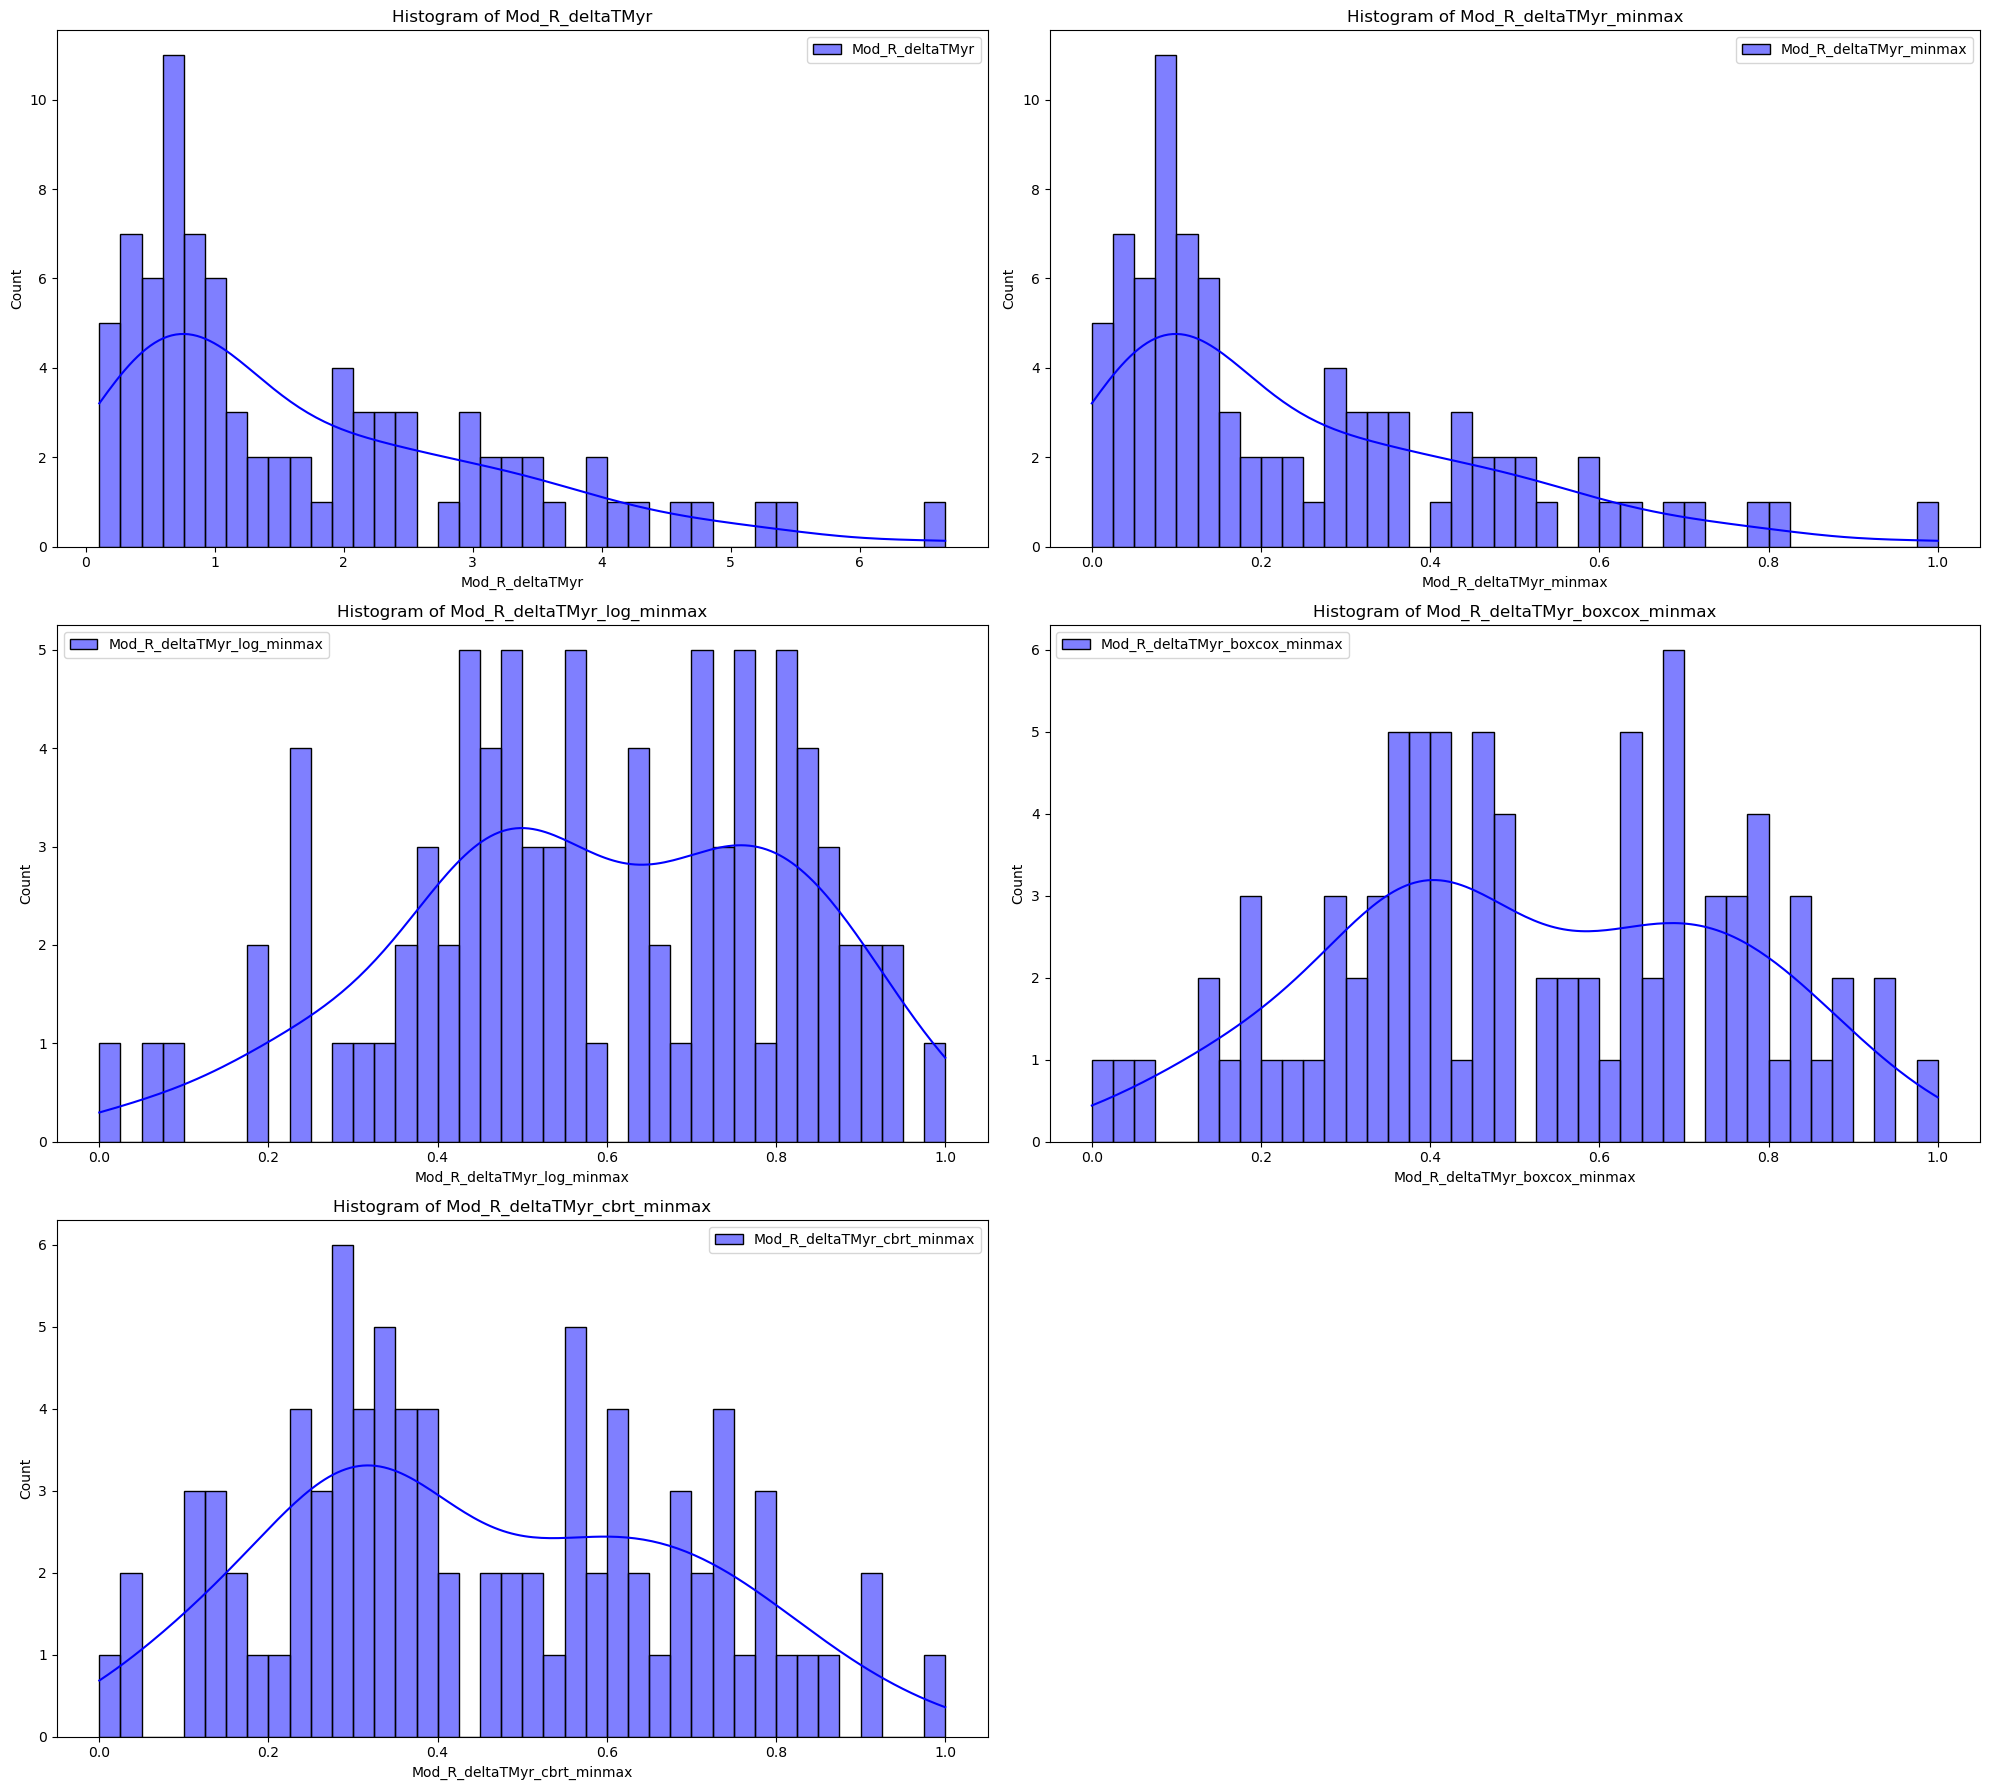

In [863]:
plot_histograms(
    'predictors_plots/1myr_temp_Mod_minmax_transformations.pdf',
    (myr_temp_minmax, 'Mod_R_deltaTMyr', 'blue'),
    (myr_temp_minmax, 'Mod_R_deltaTMyr_minmax', 'blue'), 
    (myr_temp_minmax, 'Mod_R_deltaTMyr_log_minmax', 'blue'),
    (myr_temp_minmax, 'Mod_R_deltaTMyr_boxcox_minmax', 'blue'),
    (myr_temp_minmax, 'Mod_R_deltaTMyr_cbrt_minmax', 'blue')
)

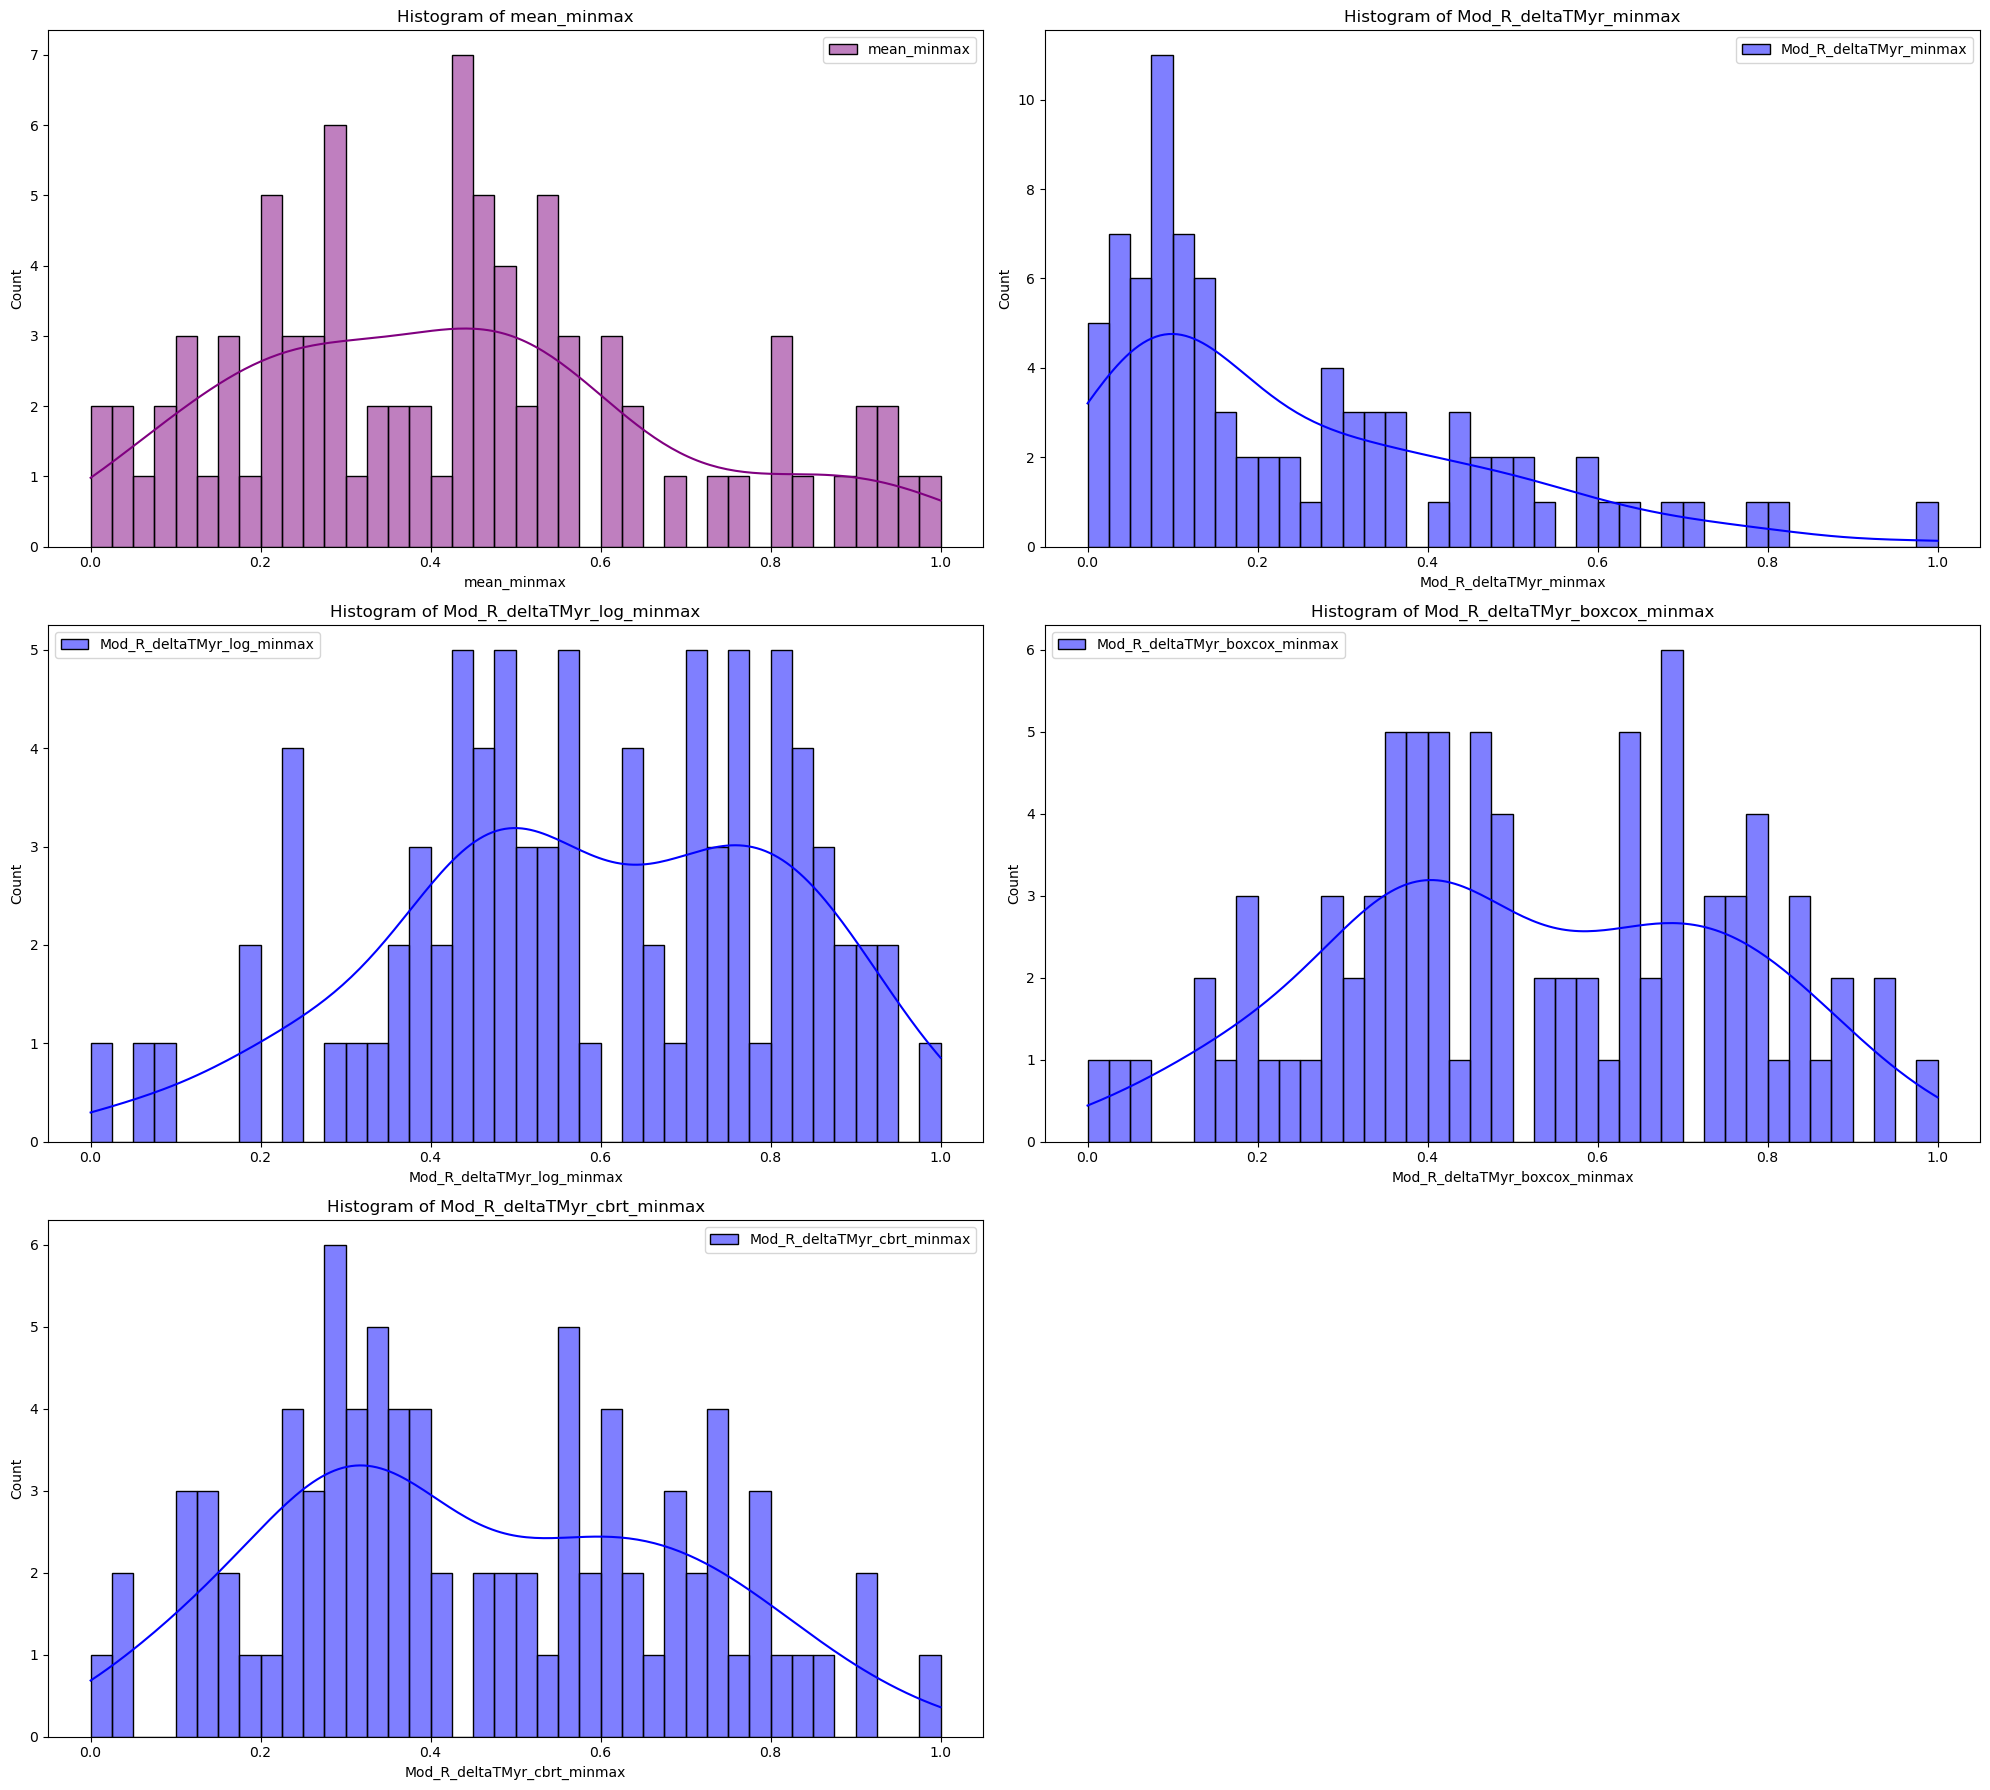

In [864]:
plot_histograms(
    'predictors_plots/1myr_temp_minmax_all.pdf',
    (myr_temp_minmax, 'mean_minmax', 'purple'),
    (myr_temp_minmax, 'Mod_R_deltaTMyr_minmax', 'blue'), 
    (myr_temp_minmax, 'Mod_R_deltaTMyr_log_minmax', 'blue'),
    (myr_temp_minmax, 'Mod_R_deltaTMyr_boxcox_minmax', 'blue'),
    (myr_temp_minmax, 'Mod_R_deltaTMyr_cbrt_minmax', 'blue')
)

# HESPDIV -- RESOLVED
Area partitioning for DeepDive. Need species occurrence data + coordinates PER TIME BIN (coords can be unscaled, it doesn't matter) + occurrence ID

Time_bins_ByStages.txt:

All are < the previous, >= the current
1. =290.1+
2. 283.5
3. 273
4. 264.3
5. 259.5
6. 252
7. 247
8. 242
9. 237
10. 227
11. 217
12. 208
13. 208+

In [731]:
# Custom function to plot age RANGE (x) frequency (y) with log scale
def range_plot(df, df_name):
    # # Count the frequency of each age range
    # df['range'] = df.apply(lambda row: (row['age_max'], row['age_min']), axis=1)
    # frequency = df['range'].value_counts().sort_index()

    # Determine which column names are present
    age_max_col = 'age_max' if 'age_max' in df.columns else 'MaxAge'
    age_min_col = 'age_min' if 'age_min' in df.columns else 'MinAge'
    
    # Count the frequency of each age range
    df['range'] = df.apply(lambda row: (row[age_max_col], row[age_min_col]), axis=1)
    frequency = df['range'].value_counts().sort_index()
    # Create the plot
    fig, ax = plt.subplots(figsize=(12,6))

    # Plot each range as a horizontal line with log-transformed y-values
    for (age_min, age_max), count in frequency.items():
        ax.plot([age_min, age_max], [np.log(count)] * 2, 'b-', linewidth=2)

    # Set the axis labels and title
    ax.set_xlabel('Age')
    ax.set_ylabel('Log(Frequency)')
    ax.set_title(f'{df_name} Age Range Frequency Plot (Log Scale)')

    # Get the x-axis limits
    x_min, x_max = ax.get_xlim()

    # Create ticks for every 1 unit
    ticks = np.arange(np.ceil(x_min), np.floor(x_max) + 1, 1)
    ax.set_xticks(ticks)

    # Create labels for every 5 units
    labels = [str(int(x)) if x % 5 == 0 else '' for x in ticks]
    ax.set_xticklabels(labels)

    # Invert the x-axis
    ax.invert_xaxis()

    # Add grid lines for better readability
    ax.grid(True, linestyle='--', alpha=0.7)

    # Add horizontal line at y=log(10)
    ax.axhline(y=np.log(10), color='r', linestyle='--', linewidth=2)

    # Customize y-axis ticks to show original frequency values
    y_ticks = ax.get_yticks()
    ax.set_yticks(y_ticks)
    ax.set_yticklabels([f'{np.exp(y):.0f}' for y in y_ticks])

    # Add vertical lines at the time-bin x-values
    vertical_lines = [290.1, 283.5, 273, 264.3, 259.5, 252, 247, 242, 237, 227, 217, 208]
    for vline in vertical_lines:
        ax.axvline(x=vline, color='g', linestyle='--', linewidth=1)

    # Show the plot
    plt.tight_layout()
    # plt.savefig(f'{df_name.lower()}_age_range_plot_log.png', dpi=300)
    plt.show()
    plt.close()

    return fig

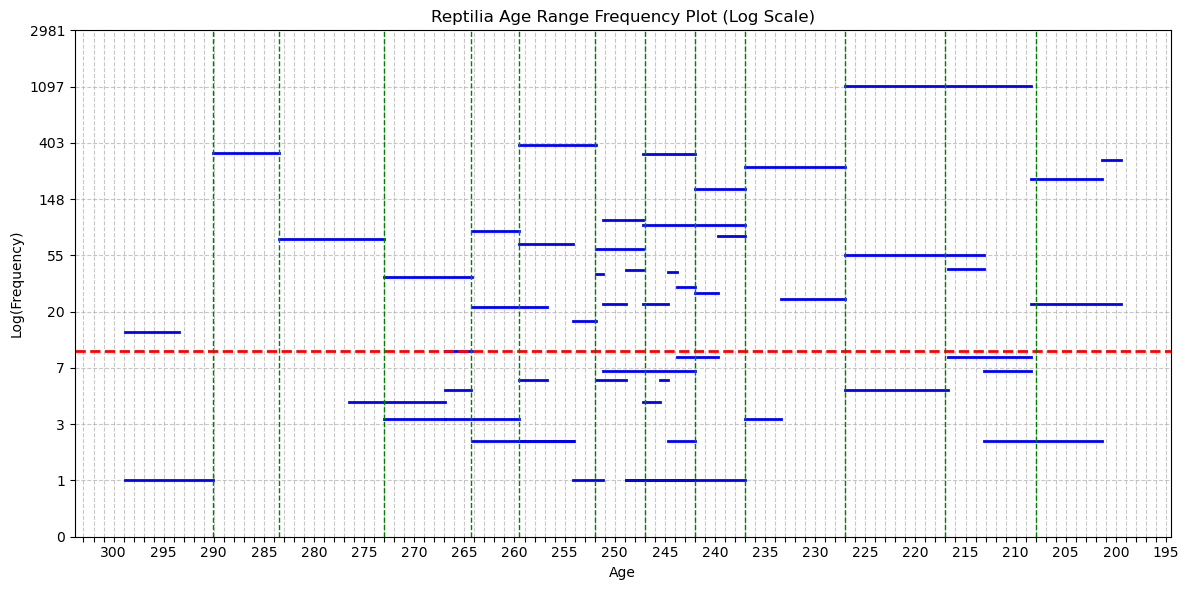

In [732]:
rep_age_range_plot = range_plot(rep_bdnn_binned, 'Reptilia')
rep_age_range_plot.savefig('predictors_plots/reptilia_age_range_plot_log.pdf', dpi=300)


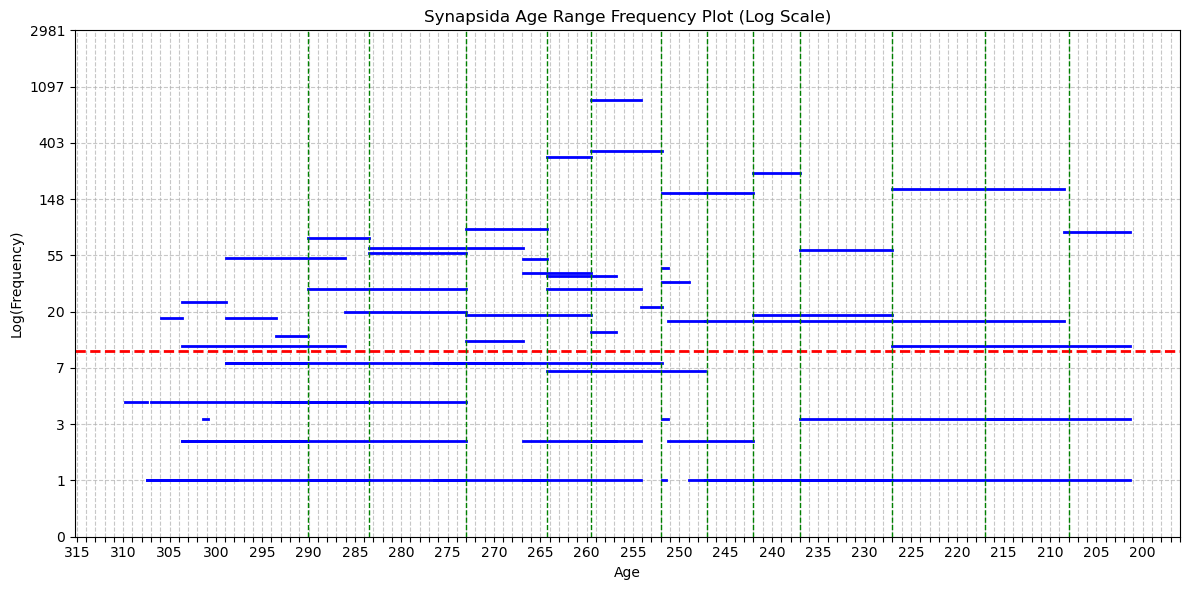

In [733]:
syn_age_range_plot = range_plot(syn_bdnn_binned, 'Synapsida')
syn_age_range_plot.savefig('predictors_plots/synapsida_age_range_plot_log.pdf', dpi=300)

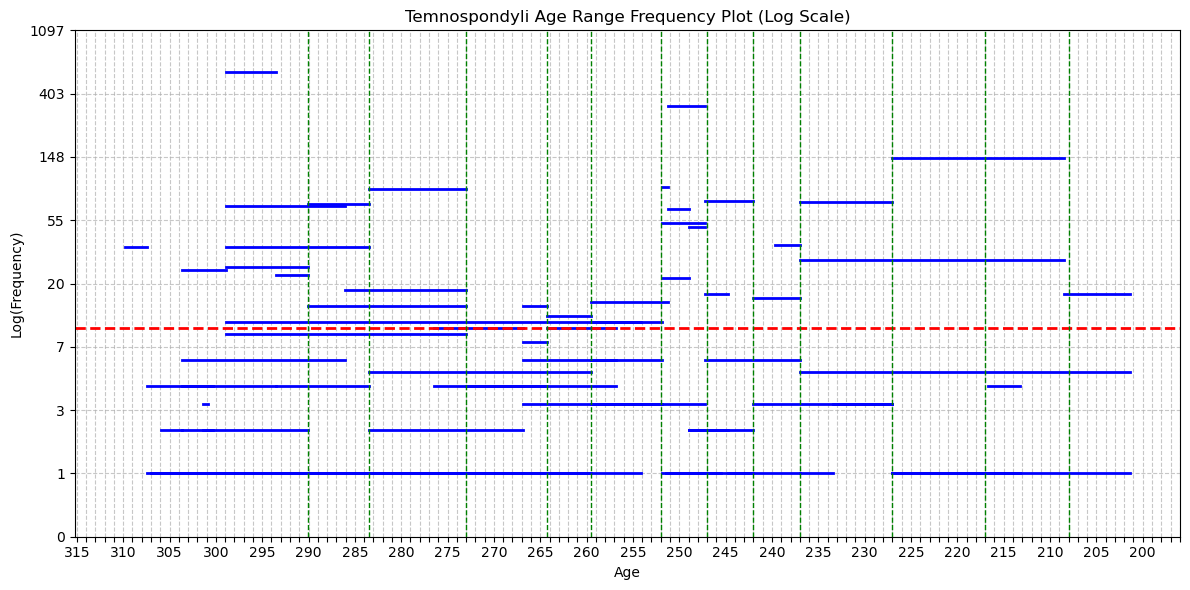

In [734]:
tem_age_range_plot = range_plot(tem_bdnn_binned, 'Temnospondyli')
tem_age_range_plot.savefig('predictors_plots/temnospondyli_age_range_plot_log.pdf', dpi=300)

Discussion:

If I use hespdiv to get bioregions that existed per time bin, I would need to first decide which occurrences deserve to be included in that time bin. That's fairly easy: maybe just choose any occurrence whose age_min and age_max span touches that time bin. 

I will run hespdiv separately on just that subset of occurrences for that time bin. Results: Areas ID'd from hespdiv = we know which of them existed during each time bin --> we have an areas_matrix for DeepDive 

However, each occurrence still needs an "Area" value for DeepDive input. That means occurrences that span across time bins still need to be assigned ONE "Area" value. Occs that span across time bins might end up with 2 different "Area" classifications, one per time bin. But, each occ can only be given one of those "Area" classifications.

That will effectively cause them to disappear for DeepDive when their one chosen Area classification disappears as we switch to a new time bin

In [736]:
rep_deepdive_final = pd.read_csv('reptilia_processed_data/reptilia_deepdive_final.csv', sep=',')
syn_deepdive_final = pd.read_csv('synapsida_processed_data/synapsida_deepdive_final.csv', sep=',')
tem_deepdive_final = pd.read_csv('temnospondyli_processed_data/temnospondyli_deepdive_final.csv', sep=',')
rep_deepdive_final.head()

Locality  cc    id          Taxon   MaxAge  MinAge  Rotated Lat  \
0    New Jersey  US  4411    Icarosaurus  227.000   208.5       6.7390   
1    New Jersey  US  4410       Rutiodon  227.000   208.5       6.7390   
2       England  UK  4409  Kuehneosuchus  208.500   201.4      35.9688   
3       England  UK  4408  Kuehneosaurus  208.500   201.4      35.9688   
4  Eastern Cape  ZA  4407    Procolophon  251.902   247.2     -62.6208   

   Rotated Lon  Area  
0     -20.6269     4  
1     -20.6269     4  
2       2.1884     3  
3       2.1884     3  
4     -11.8191     1

In [737]:
rep_deepdive_final.describe(), syn_deepdive_final.describe(), tem_deepdive_final.describe()
# Checking that problematic Lat/Lon values (the -99999's) are gone

(                id       MaxAge       MinAge  Rotated Lat  Rotated Lon  \
 count  4247.000000  4247.000000  4247.000000  4247.000000  4247.000000   
 mean   2228.908641   241.247062   231.992255    -1.649635     1.843582   
 std    1276.333894    23.353718    25.480204    34.773192    44.310370   
 min       1.000000   201.400000   199.500000   -70.846200   -85.215200   
 25%    1106.500000   227.000000   208.500000   -46.116400   -36.588700   
 50%    2263.000000   239.700000   237.000000     3.836600    -4.655400   
 75%    3332.500000   254.140000   251.902000    26.462600    20.989100   
 max    4411.000000   298.900000   293.520000    61.323500   152.608500   
 
               Area  
 count  4247.000000  
 mean      3.047092  
 std       1.104799  
 min       1.000000  
 25%       3.000000  
 50%       3.000000  
 75%       4.000000  
 max       4.000000  ,
                 id       MaxAge       MinAge  Rotated Lat  Rotated Lon  \
 count  3353.000000  3353.000000  3353.000000  33

In [738]:
# hespdiv needs: occs in rows ('id'), species and lat lon columns
rep_deepdive_hespdiv = rep_deepdive_final[['id', 'MinAge', 'MaxAge', 'Taxon', 'Rotated Lat', 'Rotated Lon']]
syn_deepdive_hespdiv = syn_deepdive_final[['id', 'MinAge', 'MaxAge', 'Taxon', 'Rotated Lat', 'Rotated Lon']]
tem_deepdive_hespdiv = tem_deepdive_final[['id', 'MinAge', 'MaxAge', 'Taxon', 'Rotated Lat', 'Rotated Lon']]

In [739]:
rep_deepdive_hespdiv.describe()

id       MinAge       MaxAge  Rotated Lat  Rotated Lon
count  4247.000000  4247.000000  4247.000000  4247.000000  4247.000000
mean   2228.908641   231.992255   241.247062    -1.649635     1.843582
std    1276.333894    25.480204    23.353718    34.773192    44.310370
min       1.000000   199.500000   201.400000   -70.846200   -85.215200
25%    1106.500000   208.500000   227.000000   -46.116400   -36.588700
50%    2263.000000   237.000000   239.700000     3.836600    -4.655400
75%    3332.500000   251.902000   254.140000    26.462600    20.989100
max    4411.000000   293.520000   298.900000    61.323500   152.608500

In [740]:
# Let's try the first time bin for now, just to test
# Subset to only rows whose age_min >= 290.1
rep_deepdive_hespdiv_1 = rep_deepdive_hespdiv[rep_deepdive_hespdiv['MinAge'] >= 290.1]
rep_deepdive_hespdiv_1

# This is way too small/few occurrences for one time bin for hespdiv, so I'll have to combine across rep syn and tem

id  MinAge  MaxAge          Taxon  Rotated Lat  Rotated Lon
149   4250  290.10   298.9     Bolosaurus      -2.7466     -38.9219
1173  3215  293.52   298.9  Protorothyris      -1.3035     -22.1408
1174  3216  293.52   298.9  Protorothyris      -1.3035     -22.1408
1175  3217  293.52   298.9  Protorothyris      -1.3035     -22.1408
1176  3218  293.52   298.9  Protorothyris      -1.3035     -22.1408
1177  3219  293.52   298.9  Protorothyris      -1.3035     -22.1408
1178  3220  293.52   298.9  Protorothyris      -1.3035     -22.1408
1179  3221  293.52   298.9  Protorothyris      -1.3035     -22.1408
1265  3125  293.52   298.9  Protorothyris      -2.7466     -38.9219
1266  3126  293.52   298.9  Protorothyris      -2.7466     -38.9219
1267  3127  293.52   298.9  Protorothyris      -2.7466     -38.9219
1268  3128  293.52   298.9  Protorothyris      -2.7466     -38.9219
1269  3129  293.52   298.9  Protorothyris      -2.7466     -38.9219
1270  3124  293.52   298.9        Romeria      -2.7466     -38.9219
3011  1283  293.52   298.9   Aphelosaurus       5.4598      17.9322

In [741]:
rep_deepdive_hespdiv_1.describe()

id     MinAge  MaxAge  Rotated Lat  Rotated Lon
count    15.000000   15.00000    15.0    15.000000    15.000000
mean   3121.200000  293.29200   298.9    -1.526060   -27.300447
std     580.576954    0.88304     0.0     2.062886    15.065934
min    1283.000000  290.10000   298.9    -2.746600   -38.921900
25%    3126.500000  293.52000   298.9    -2.746600   -38.921900
50%    3215.000000  293.52000   298.9    -1.303500   -22.140800
75%    3218.500000  293.52000   298.9    -1.303500   -22.140800
max    4250.000000  293.52000   298.9     5.459800    17.932200

In [742]:
# Seeing how many occs syn would have in this time bin
syn_deepdive_hespdiv_1 = syn_deepdive_hespdiv[syn_deepdive_hespdiv['MinAge'] >= 290.1]
syn_deepdive_hespdiv_1

id  MinAge  MaxAge           Taxon  Rotated Lat  Rotated Lon
0     3422  298.90  303.70    Edaphosaurus      -0.4818     -24.8936
3     3419  290.10  298.90      Ophiacodon       5.8574     -44.6091
6     3416  298.90  303.70      Ophiacodon      -0.5219     -37.7808
42    3375  290.10  293.52      Dimetrodon      -2.9673     -38.9083
43    3374  290.10  293.52      Ophiacodon      -2.9673     -38.9083
...    ...     ...     ...             ...          ...          ...
2954   403  293.52  298.90    Edaphosaurus      -0.5219     -37.7808
2955   402  290.10  298.90    Edaphosaurus      -2.7466     -38.9219
2965   391  298.90  303.70      Ophiacodon       1.7029     -36.6404
2968   388  293.52  298.90        Cabarzia      14.5677      17.8279
3042   311  307.40  309.80  Melanedaphodon      -0.4818     -24.8936

[96 rows x 6 columns]

In [743]:
# Datasets can share id's
syn_deepdive_hespdiv_1['id'].isin(rep_deepdive_hespdiv_1['id']).value_counts()


id
False    95
True      1
Name: count, dtype: int64

In [744]:
rep_deepdive_hespdiv_1[rep_deepdive_hespdiv_1['id']==1283]

id  MinAge  MaxAge         Taxon  Rotated Lat  Rotated Lon
3011  1283  293.52   298.9  Aphelosaurus       5.4598      17.9322

However, rep, tem, and syn will never share 'genus' names
After I run hespdiv, I will ideally assign each of these rows a "polygon" value
then I will want to merge that polygon value back into the original rep, syn, and tem datasets
But making sure that the correct occurrence gets the correct "polygon" value
So while rep, tem, and syn datasets can share 'id's, they'll never share 'genus' names
So I'll keep the 'id' column for

In [745]:
# Combining the datasets one under the other
all_hespdiv = pd.concat([rep_deepdive_hespdiv, syn_deepdive_hespdiv, tem_deepdive_hespdiv], axis=0)
all_hespdiv.shape, rep_deepdive_hespdiv.shape[0] + syn_deepdive_hespdiv.shape[0] + tem_deepdive_hespdiv.shape[0]

((9822, 6), 9822)

In [747]:
tem_deepdive_hespdiv.describe()
# Tem still has -99999's in lat/lon, need to go back to deepdive section

id       MinAge       MaxAge  Rotated Lat  Rotated Lon
count  2222.000000  2222.000000  2222.000000  2222.000000  2222.000000
mean   1123.985149   262.962057   270.306069    12.929946     9.319296
std     647.554798    28.108072    26.805963    29.203648    36.968738
min       1.000000   201.400000   208.500000   -70.949200   -50.240600
25%     563.250000   247.200000   251.200000     1.353100   -24.893600
50%    1125.500000   256.800000   264.280000    14.567700    17.827900
75%    1685.750000   293.520000   298.900000    39.997375    29.687500
max    2247.000000   307.400000   309.800000    74.642100   144.809100

In [748]:
all_hespdiv.describe()

id       MinAge       MaxAge  Rotated Lat  Rotated Lon
count  9822.000000  9822.000000  9822.000000  9822.000000  9822.000000
mean   1800.879760   245.534045   253.745067    -9.620463     0.931247
std    1148.126193    27.243724    25.472670    39.493223    38.440768
min       1.000000   199.500000   201.400000   -70.949200   -85.215200
25%     840.000000   227.000000   237.000000   -50.092000   -23.107625
50%    1697.000000   247.200000   251.902000     1.353100    -6.621400
75%    2673.000000   259.510000   264.280000    22.980500    19.386375
max    4411.000000   307.400000   309.800000    74.642100   152.608500

In [749]:
rep_deepdive_hespdiv.isna().sum(), syn_deepdive_hespdiv.isna().sum(), tem_deepdive_hespdiv.isna().sum(), all_hespdiv.isna().sum()

(id             0
 MinAge         0
 MaxAge         0
 Taxon          0
 Rotated Lat    0
 Rotated Lon    0
 dtype: int64,
 id             0
 MinAge         0
 MaxAge         0
 Taxon          0
 Rotated Lat    0
 Rotated Lon    0
 dtype: int64,
 id             0
 MinAge         0
 MaxAge         0
 Taxon          0
 Rotated Lat    0
 Rotated Lon    0
 dtype: int64,
 id             0
 MinAge         0
 MaxAge         0
 Taxon          0
 Rotated Lat    0
 Rotated Lon    0
 range          0
 dtype: int64)

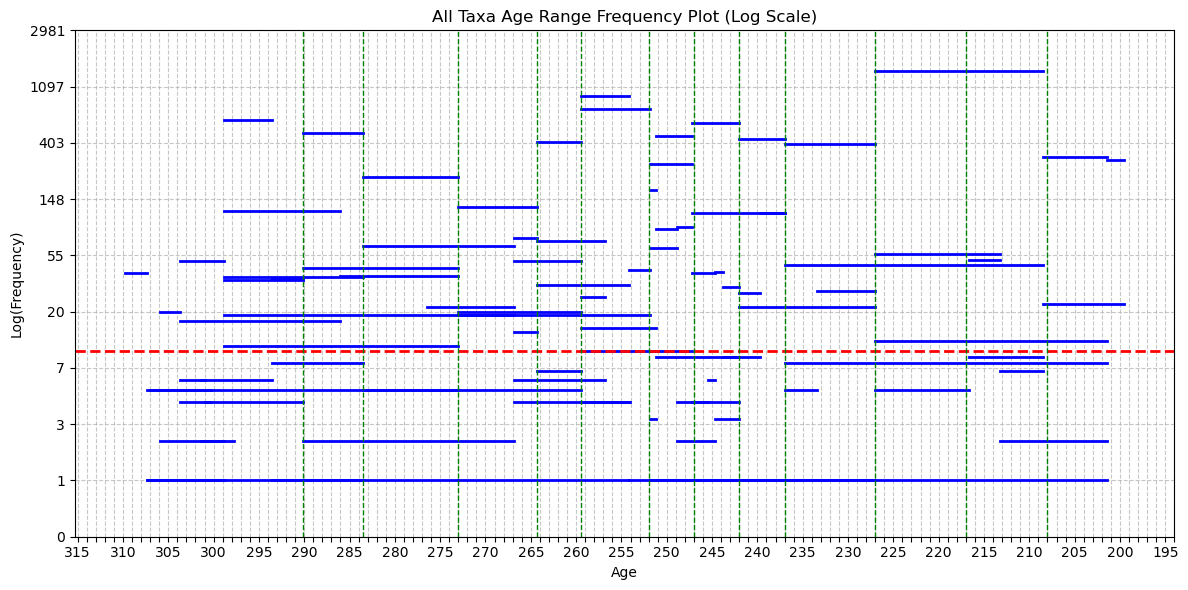

In [750]:
all_age_range_plot = range_plot(all_hespdiv, 'All Taxa')
all_age_range_plot.savefig('predictors_plots/all_taxa_age_range_plot_log.pdf', dpi=300)

In [752]:
# Function for separating all_bdnn_binned by whether or not it touches a time bin

def filter_by_timebin(df, time_min, time_max):
    df_timebin = df[(df['MinAge'] <= time_max) & (df['MaxAge'] >= time_min)]
    return df_timebin

Time bins list: 
1. =290.1+
2. 283.5
3. 273
4. 264.3
5. 259.5
6. 252
7. 247
8. 242
9. 237
10. 227
11. 217
12. 208
13. 208+

In [753]:
hespdiv_bin1 = filter_by_timebin(all_hespdiv, 290.1, 400)
hespdiv_bin1

# The study used 5,244 data points over an 18 myr time period
# Ours is much less

id  MinAge  MaxAge           Taxon  Rotated Lat  Rotated Lon  \
5     4405  283.50   290.1     Araeoscelis      -2.9808     -38.7628   
6     4406  283.50   290.1     Araeoscelis      -2.9808     -38.7628   
110   4289  283.50   290.1      Bolosaurus      -0.7300     -37.6741   
111   4290  283.50   290.1      Bolosaurus      -0.7300     -37.6741   
112   4291  283.50   290.1      Bolosaurus      -0.7300     -37.6741   
...    ...     ...     ...             ...          ...          ...   
2199    23  293.52   298.9   Archegosaurus      16.0936      19.7625   
2200    22  293.52   298.9  Branchiosaurus      16.0936      19.7625   
2201    21  293.52   298.9    Melanerpeton      16.0936      19.7625   
2202    20  293.52   298.9    Melanerpeton      16.0936      19.7625   
2203    19  293.52   298.9    Melanerpeton      16.0936      19.7625   

                range  
5      (290.1, 283.5)  
6      (290.1, 283.5)  
110    (290.1, 283.5)  
111    (290.1, 283.5)  
112    (290.1, 283.5)  
...               ...  
2199  (298.9, 293.52)  
2200  (298.9, 293.52)  
2201  (298.9, 293.52)  
2202  (298.9, 293.52)  
2203  (298.9, 293.52)  

[1563 rows x 7 columns]

In [754]:
# Confirming that the function worked properly by finding these rows in a different way
# Both are 816 rows, so the function worked properly
all_hespdiv[all_hespdiv['MinAge'] >= 290.1]


id  MinAge  MaxAge           Taxon  Rotated Lat  Rotated Lon  \
149   4250  290.10   298.9      Bolosaurus      -2.7466     -38.9219   
1173  3215  293.52   298.9   Protorothyris      -1.3035     -22.1408   
1174  3216  293.52   298.9   Protorothyris      -1.3035     -22.1408   
1175  3217  293.52   298.9   Protorothyris      -1.3035     -22.1408   
1176  3218  293.52   298.9   Protorothyris      -1.3035     -22.1408   
...    ...     ...     ...             ...          ...          ...   
2199    23  293.52   298.9   Archegosaurus      16.0936      19.7625   
2200    22  293.52   298.9  Branchiosaurus      16.0936      19.7625   
2201    21  293.52   298.9    Melanerpeton      16.0936      19.7625   
2202    20  293.52   298.9    Melanerpeton      16.0936      19.7625   
2203    19  293.52   298.9    Melanerpeton      16.0936      19.7625   

                range  
149    (298.9, 290.1)  
1173  (298.9, 293.52)  
1174  (298.9, 293.52)  
1175  (298.9, 293.52)  
1176  (298.9, 293.52)  
...               ...  
2199  (298.9, 293.52)  
2200  (298.9, 293.52)  
2201  (298.9, 293.52)  
2202  (298.9, 293.52)  
2203  (298.9, 293.52)  

[816 rows x 7 columns]

In [755]:
all_hespdiv.describe()

# Hespdiv needs a separate parameter (pacific.region=TRUE) for data that passes the 180th meridian,
# so I'm checking Rotated Lon to see if it meets/passes 180

id       MinAge       MaxAge  Rotated Lat  Rotated Lon
count  9822.000000  9822.000000  9822.000000  9822.000000  9822.000000
mean   1800.879760   245.534045   253.745067    -9.620463     0.931247
std    1148.126193    27.243724    25.472670    39.493223    38.440768
min       1.000000   199.500000   201.400000   -70.949200   -85.215200
25%     840.000000   227.000000   237.000000   -50.092000   -23.107625
50%    1697.000000   247.200000   251.902000     1.353100    -6.621400
75%    2673.000000   259.510000   264.280000    22.980500    19.386375
max    4411.000000   307.400000   309.800000    74.642100   152.608500

In [756]:
all_hespdiv[all_hespdiv['Taxon'].str.contains('[^a-zA-Z_]', regex=True)]['Taxon']

Series([], Name: Taxon, dtype: object)

In [757]:
# loading in with an added header
time_bins_by_stages = pd.read_csv('Time_bins_ByStages.txt', sep='\t', header=None)
# time_bins_by_stages

In [758]:
# MinAge = 2
# MaxAge = 3

hespdiv_bin1 = filter_by_timebin(all_hespdiv, 290.1, 400)
hespdiv_bin2 = filter_by_timebin(all_hespdiv, 283.5, 290.1)
hespdiv_bin3 = filter_by_timebin(all_hespdiv, 273, 283.5)
hespdiv_bin4 = filter_by_timebin(all_hespdiv, 264.3, 273)
hespdiv_bin5 = filter_by_timebin(all_hespdiv, 259.5, 264.3)
hespdiv_bin6 = filter_by_timebin(all_hespdiv, 252, 259.5)
hespdiv_bin7 = filter_by_timebin(all_hespdiv, 247, 252)
hespdiv_bin8 = filter_by_timebin(all_hespdiv, 242, 247)
hespdiv_bin9 = filter_by_timebin(all_hespdiv, 237, 242)
hespdiv_bin10 = filter_by_timebin(all_hespdiv, 227, 237)
hespdiv_bin11 = filter_by_timebin(all_hespdiv, 217, 227)
hespdiv_bin12 = filter_by_timebin(all_hespdiv, 208, 217)
hespdiv_bin13 = filter_by_timebin(all_hespdiv, 0, 208.0)

# make the same bins for just reptilia
rep_hespdiv_bin1 = filter_by_timebin(rep_deepdive_hespdiv, 290.1, 400)
rep_hespdiv_bin2 = filter_by_timebin(rep_deepdive_hespdiv, 283.5, 290.1)
rep_hespdiv_bin3 = filter_by_timebin(rep_deepdive_hespdiv, 273, 283.5)
rep_hespdiv_bin4 = filter_by_timebin(rep_deepdive_hespdiv, 264.3, 273)
rep_hespdiv_bin5 = filter_by_timebin(rep_deepdive_hespdiv, 259.5, 264.3)
rep_hespdiv_bin6 = filter_by_timebin(rep_deepdive_hespdiv, 252, 259.5)
rep_hespdiv_bin7 = filter_by_timebin(rep_deepdive_hespdiv, 247, 252)
rep_hespdiv_bin8 = filter_by_timebin(rep_deepdive_hespdiv, 242, 247)
rep_hespdiv_bin9 = filter_by_timebin(rep_deepdive_hespdiv, 237, 242)
rep_hespdiv_bin10 = filter_by_timebin(rep_deepdive_hespdiv, 227, 237)
rep_hespdiv_bin11 = filter_by_timebin(rep_deepdive_hespdiv, 217, 227)
rep_hespdiv_bin12 = filter_by_timebin(rep_deepdive_hespdiv, 208, 217)
rep_hespdiv_bin13 = filter_by_timebin(rep_deepdive_hespdiv, 0, 208.0)

# make the same bins for just synapsida
syn_hespdiv_bin1 = filter_by_timebin(syn_deepdive_hespdiv, 290.1, 400)
syn_hespdiv_bin2 = filter_by_timebin(syn_deepdive_hespdiv, 283.5, 290.1)
syn_hespdiv_bin3 = filter_by_timebin(syn_deepdive_hespdiv, 273, 283.5)
syn_hespdiv_bin4 = filter_by_timebin(syn_deepdive_hespdiv, 264.3, 273)
syn_hespdiv_bin5 = filter_by_timebin(syn_deepdive_hespdiv, 259.5, 264.3)
syn_hespdiv_bin6 = filter_by_timebin(syn_deepdive_hespdiv, 252, 259.5)
syn_hespdiv_bin7 = filter_by_timebin(syn_deepdive_hespdiv, 247, 252)
syn_hespdiv_bin8 = filter_by_timebin(syn_deepdive_hespdiv, 242, 247)
syn_hespdiv_bin9 = filter_by_timebin(syn_deepdive_hespdiv, 237, 242)
syn_hespdiv_bin10 = filter_by_timebin(syn_deepdive_hespdiv, 227, 237)
syn_hespdiv_bin11 = filter_by_timebin(syn_deepdive_hespdiv, 217, 227)
syn_hespdiv_bin12 = filter_by_timebin(syn_deepdive_hespdiv, 208, 217)
syn_hespdiv_bin13 = filter_by_timebin(syn_deepdive_hespdiv, 0, 208.0)

# make the same bins for just temnospondyli
tem_hespdiv_bin1 = filter_by_timebin(tem_deepdive_hespdiv, 290.1, 400)
tem_hespdiv_bin2 = filter_by_timebin(tem_deepdive_hespdiv, 283.5, 290.1)
tem_hespdiv_bin3 = filter_by_timebin(tem_deepdive_hespdiv, 273, 283.5)
tem_hespdiv_bin4 = filter_by_timebin(tem_deepdive_hespdiv, 264.3, 273)
tem_hespdiv_bin5 = filter_by_timebin(tem_deepdive_hespdiv, 259.5, 264.3)
tem_hespdiv_bin6 = filter_by_timebin(tem_deepdive_hespdiv, 252, 259.5)
tem_hespdiv_bin7 = filter_by_timebin(tem_deepdive_hespdiv, 247, 252)
tem_hespdiv_bin8 = filter_by_timebin(tem_deepdive_hespdiv, 242, 247)
tem_hespdiv_bin9 = filter_by_timebin(tem_deepdive_hespdiv, 237, 242)
tem_hespdiv_bin10 = filter_by_timebin(tem_deepdive_hespdiv, 227, 237)
tem_hespdiv_bin11 = filter_by_timebin(tem_deepdive_hespdiv, 217, 227)
tem_hespdiv_bin12 = filter_by_timebin(tem_deepdive_hespdiv, 208, 217)
tem_hespdiv_bin13 = filter_by_timebin(tem_deepdive_hespdiv, 0, 208.0)


In [759]:
hespdiv_bin1.to_csv('hespdiv/hespdiv_bin1.csv', index=False)
hespdiv_bin2.to_csv('hespdiv/hespdiv_bin2.csv', index=False)
hespdiv_bin3.to_csv('hespdiv/hespdiv_bin3.csv', index=False)
hespdiv_bin4.to_csv('hespdiv/hespdiv_bin4.csv', index=False)
hespdiv_bin5.to_csv('hespdiv/hespdiv_bin5.csv', index=False)
hespdiv_bin6.to_csv('hespdiv/hespdiv_bin6.csv', index=False)
hespdiv_bin7.to_csv('hespdiv/hespdiv_bin7.csv', index=False)
hespdiv_bin8.to_csv('hespdiv/hespdiv_bin8.csv', index=False)
hespdiv_bin9.to_csv('hespdiv/hespdiv_bin9.csv', index=False)
hespdiv_bin10.to_csv('hespdiv/hespdiv_bin10.csv', index=False)
hespdiv_bin11.to_csv('hespdiv/hespdiv_bin11.csv', index=False)
hespdiv_bin12.to_csv('hespdiv/hespdiv_bin12.csv', index=False)
hespdiv_bin13.to_csv('hespdiv/hespdiv_bin13.csv', index=False)


In [760]:
# Plot the distribution of the occurrences by Rotated Lat (x value) and Rotated Lon (y value) as a scatter plot

# Make this into a function:
def plot_occs_distribution(df, bin_name):
    fig, ax = plt.subplots(figsize=(8, 6))
    df.plot.scatter(x='Rotated Lon', y='Rotated Lat', s=1, alpha=0.5, ax=ax)
    ax.set_title(f'{bin_name} Occurrences by Rotated Latitude and Longitude')
    ax.set_xlabel('Rotated Longitude')
    ax.set_ylabel('Rotated Latitude')
    ax.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    return fig

# all_hespdiv.plot.scatter(x='Rotated Lon', y='Rotated Lat', s=1, alpha=0.5, figsize=(12, 8))
# plt.title('Hespdiv Occurrences by Rotated Latitude and Longitude')
# plt.xlabel('Rotated Longitude')
# plt.ylabel('Rotated Latitude')
# plt.grid(True, linestyle='--', alpha=0.7)
# plt.tight_layout()
# plt.show()
# plt.close()

# # Save graph
# plt.savefig('hespdiv/hespdiv_occurrences_rotated_lat_lon.pdf', dpi=300)


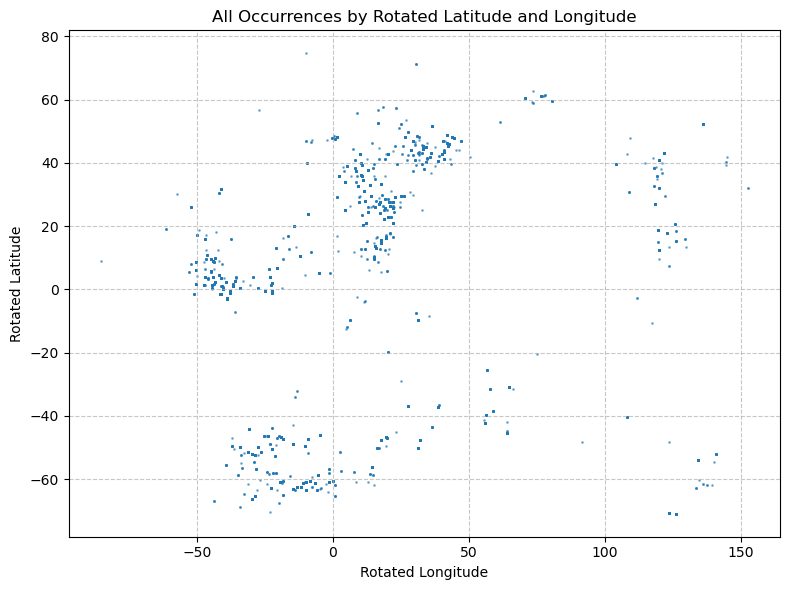

In [761]:
all_hespdiv_plot = plot_occs_distribution(all_hespdiv, 'All')
all_hespdiv_plot.savefig('hespdiv/hespdiv_occurrences_rotated_lat_lon_all.pdf', dpi=300)

# Save this plot off


                id       MaxAge       MinAge  Rotated Lat  Rotated Lon  \
count  4247.000000  4247.000000  4247.000000  4247.000000  4247.000000   
mean   2228.908641   241.247062   231.992255    -1.649635     1.843582   
std    1276.333894    23.353718    25.480204    34.773192    44.310370   
min       1.000000   201.400000   199.500000   -70.846200   -85.215200   
25%    1106.500000   227.000000   208.500000   -46.116400   -36.588700   
50%    2263.000000   239.700000   237.000000     3.836600    -4.655400   
75%    3332.500000   254.140000   251.902000    26.462600    20.989100   
max    4411.000000   298.900000   293.520000    61.323500   152.608500   

              Area  
count  4247.000000  
mean      3.047092  
std       1.104799  
min       1.000000  
25%       3.000000  
50%       3.000000  
75%       4.000000  
max       4.000000  


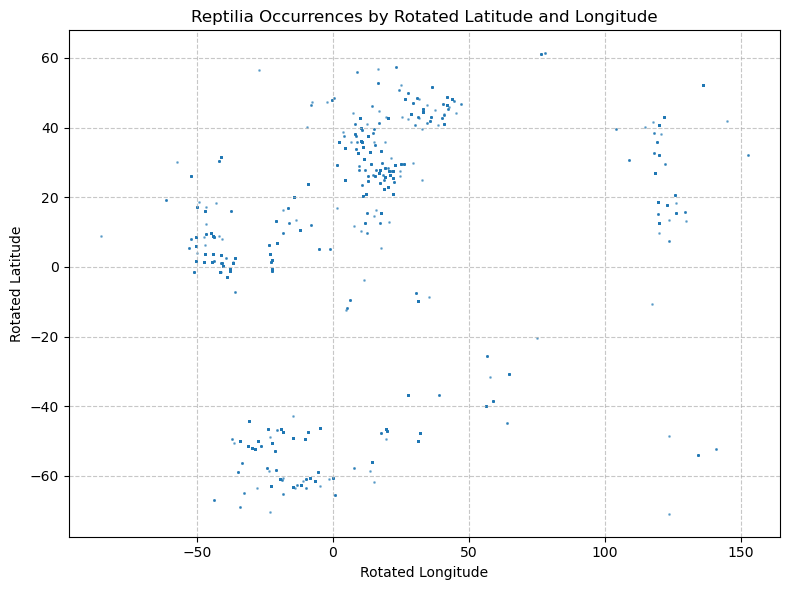

In [780]:
# Occs plot of just r
print(rep_deepdive_final.describe())
rep_occs_plot = plot_occs_distribution(rep_deepdive_final, 'Reptilia')
rep_occs_plot.savefig('hespdiv/reptilia_occurrences_rotated_lat_lon.pdf', dpi=300)

                id       MaxAge       MinAge  Rotated Lat  Rotated Lon  \
count  3353.000000  3353.000000  3353.000000  3353.000000  3353.000000   
mean   1707.298240   258.600563   251.137068   -34.660461    -5.783020   
std     988.034017    18.188373    19.069651    37.792281    29.052976   
min       1.000000   208.500000   201.400000   -67.429000   -50.240600   
25%     862.000000   251.902000   247.200000   -60.880700   -19.334200   
50%    1705.000000   259.510000   254.140000   -49.477100   -14.725000   
75%    2549.000000   264.280000   259.510000    -1.185500     9.627300   
max    3422.000000   309.800000   307.400000    62.825200   121.703400   

              Area  
count  3353.000000  
mean      2.169997  
std       1.356402  
min       1.000000  
25%       1.000000  
50%       1.000000  
75%       4.000000  
max       4.000000  


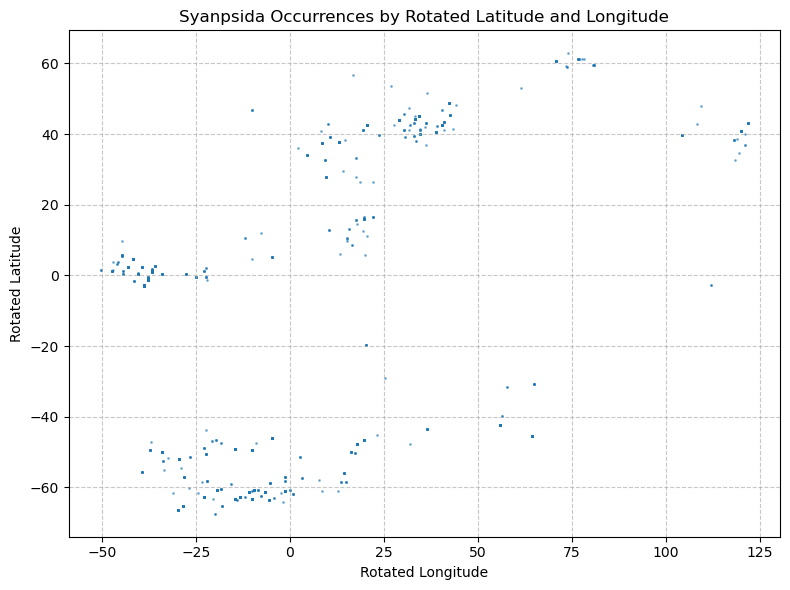

In [781]:
# Occs plot of just r
print(syn_deepdive_final.describe())
syn_occs_plot = plot_occs_distribution(syn_deepdive_final, 'Syanpsida')
syn_occs_plot.savefig('hespdiv/synapsida_occurrences_rotated_lat_lon.pdf', dpi=300)

                id       MaxAge       MinAge  Rotated Lat  Rotated Lon  \
count  2222.000000  2222.000000  2222.000000  2222.000000  2222.000000   
mean   1123.985149   270.306069   262.962057    12.929946     9.319296   
std     647.554798    26.805963    28.108072    29.203648    36.968738   
min       1.000000   208.500000   201.400000   -70.949200   -50.240600   
25%     563.250000   251.200000   247.200000     1.353100   -24.893600   
50%    1125.500000   264.280000   256.800000    14.567700    17.827900   
75%    1685.750000   298.900000   293.520000    39.997375    29.687500   
max    2247.000000   309.800000   307.400000    74.642100   144.809100   

              Area  
count  2222.000000  
mean      3.202520  
std       0.705311  
min       1.000000  
25%       3.000000  
50%       3.000000  
75%       4.000000  
max       4.000000  


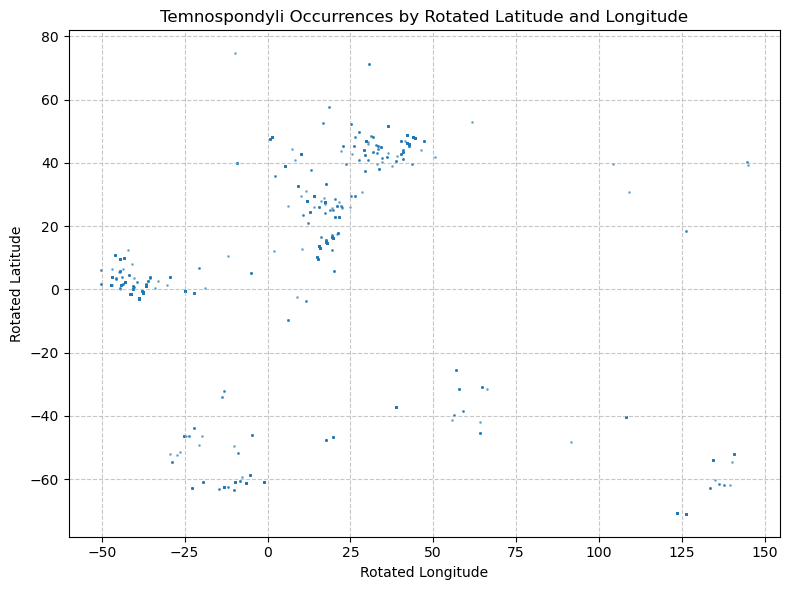

In [782]:
# Occs plot of just r
print(tem_deepdive_final.describe())
tem_occs_plot = plot_occs_distribution(tem_deepdive_final, 'Temnospondyli')
tem_occs_plot.savefig('hespdiv/temnospondyli_occurrences_rotated_lat_lon.pdf', dpi=300)

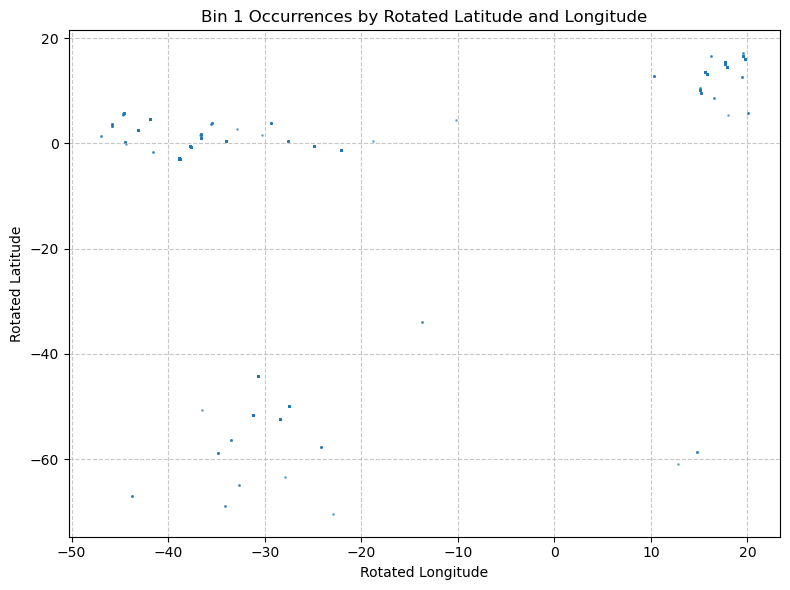

In [765]:
hespdiv_bin1_plot = plot_occs_distribution(hespdiv_bin1, 'Bin 1')

In [766]:
# Print the lengths of every bin
print(f"""
Bin 1: {len(hespdiv_bin1)}
Bin 2: {len(hespdiv_bin2)}
Bin 3: {len(hespdiv_bin3)}
Bin 4: {len(hespdiv_bin4)}
Bin 5: {len(hespdiv_bin5)}
Bin 6: {len(hespdiv_bin6)}
Bin 7: {len(hespdiv_bin7)}
Bin 8: {len(hespdiv_bin8)}
Bin 9: {len(hespdiv_bin9)}
Bin 10: {len(hespdiv_bin10)}
Bin 11: {len(hespdiv_bin11)}
Bin 12: {len(hespdiv_bin12)}
Bin 13: {len(hespdiv_bin13)}
""")



Bin 1: 1563
Bin 2: 1149
Bin 3: 1133
Bin 4: 436
Bin 5: 2575
Bin 6: 1914
Bin 7: 2733
Bin 8: 1322
Bin 9: 1798
Bin 10: 2686
Bin 11: 2018
Bin 12: 1975
Bin 13: 659



In [767]:
print(f"Sum of all hespdiv bin dataframes: {len(hespdiv_bin1) + len(hespdiv_bin2) + len(hespdiv_bin3) + len(hespdiv_bin4) + len(hespdiv_bin5) + len(hespdiv_bin6) + len(hespdiv_bin7) + len(hespdiv_bin8) + len(hespdiv_bin9) + len(hespdiv_bin10) + len(hespdiv_bin11) + len(hespdiv_bin12) + len(hespdiv_bin13)}")

Sum of all hespdiv bin dataframes: 21961


In [768]:
print(f"All hespdiv: {len(all_hespdiv)}", "Sum of Lengths of reptilia, synapsida, and temnospondyli datasets:" , rep_deepdive_hespdiv.shape[0] + syn_deepdive_hespdiv.shape[0] + tem_deepdive_hespdiv.shape[0])

All hespdiv: 9822 Sum of Lengths of reptilia, synapsida, and temnospondyli datasets: 9822


In [769]:
all_hespdiv['Rotated Lon'].describe()

count    9822.000000
mean        0.931247
std        38.440768
min       -85.215200
25%       -23.107625
50%        -6.621400
75%        19.386375
max       152.608500
Name: Rotated Lon, dtype: float64

In [770]:
all_hespdiv['Rotated Lat'].describe(), all_hespdiv['Rotated Lon'].describe()

# Rotated Lat range: -71 to 75
# Rotated Lon range: -86 to 153

(count    9822.000000
 mean       -9.620463
 std        39.493223
 min       -70.949200
 25%       -50.092000
 50%         1.353100
 75%        22.980500
 max        74.642100
 Name: Rotated Lat, dtype: float64,
 count    9822.000000
 mean        0.931247
 std        38.440768
 min       -85.215200
 25%       -23.107625
 50%        -6.621400
 75%        19.386375
 max       152.608500
 Name: Rotated Lon, dtype: float64)

In [771]:
hespdiv_bin1['MaxAge'].max(), hespdiv_bin13['MinAge'].min()

(309.8, 199.5)

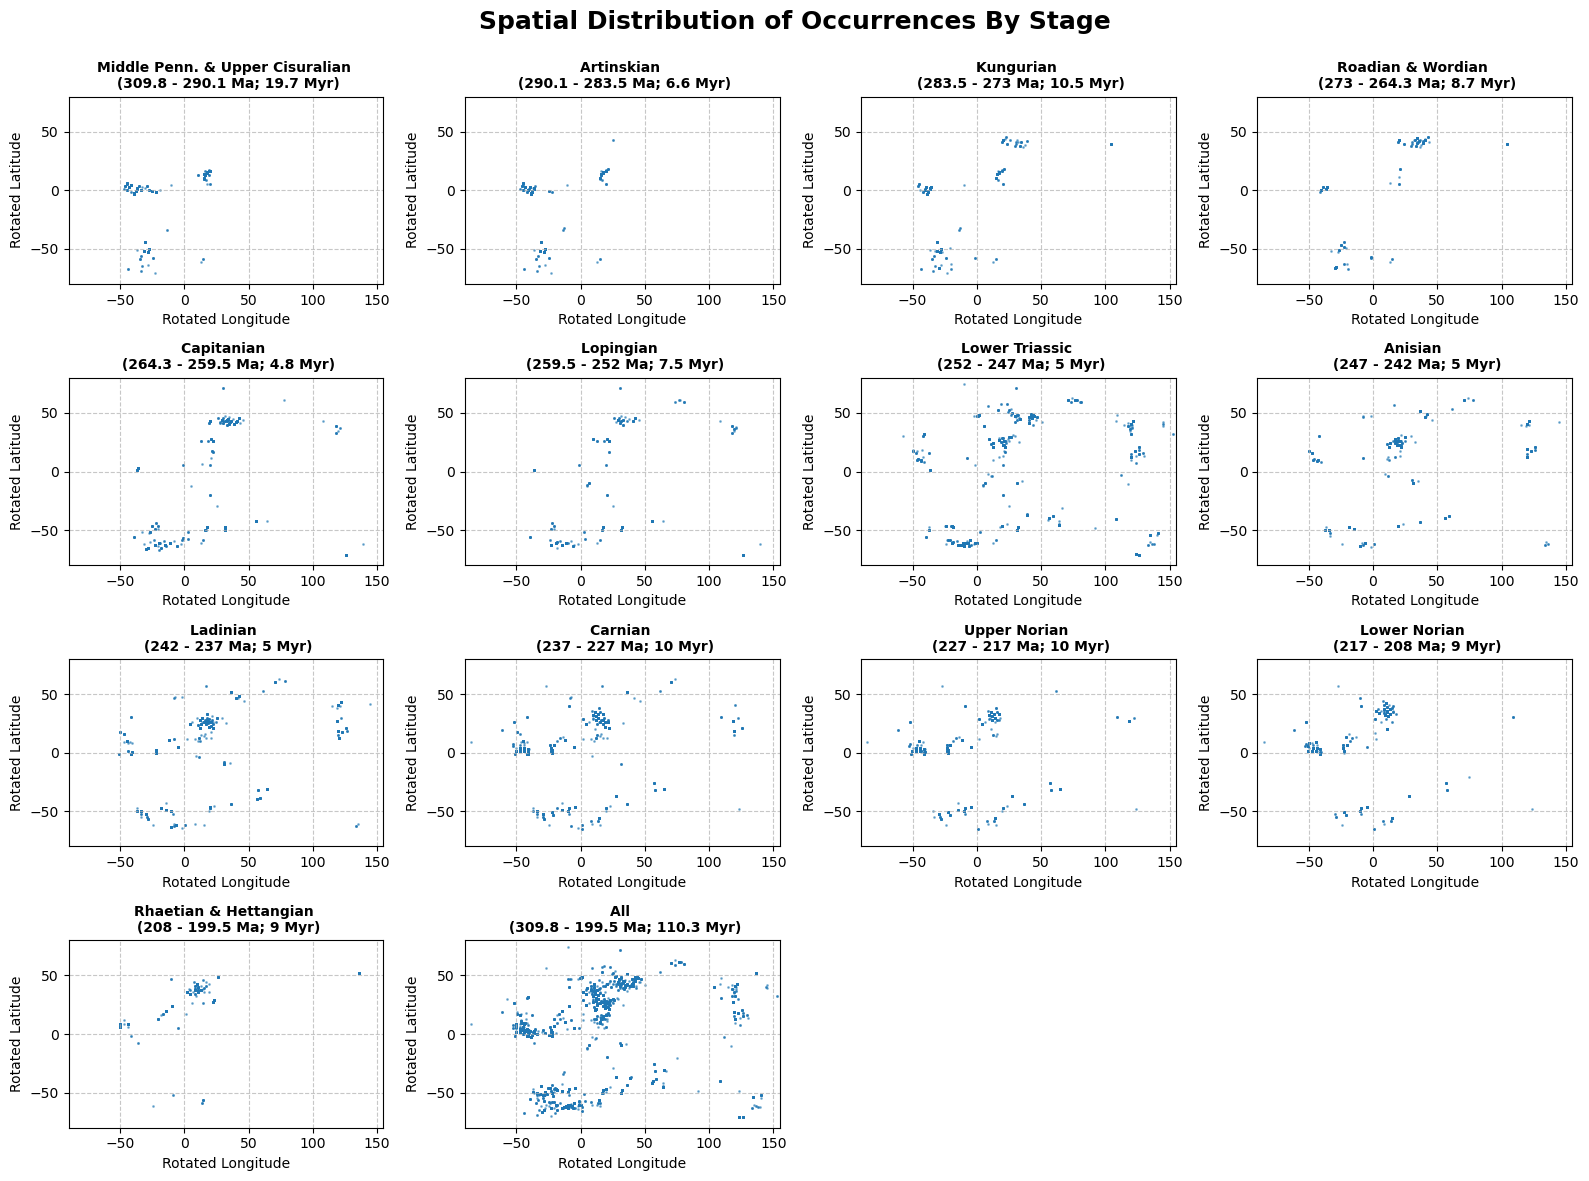

In [772]:
# Plot all hespdiv bins using plot_occs_distribution function in one PDF

# Put all those plots into one 3x4 grid
fig, axs = plt.subplots(4, 4, figsize=(16, 12))
bins = [hespdiv_bin1, hespdiv_bin2, hespdiv_bin3, hespdiv_bin4, hespdiv_bin5, hespdiv_bin6, hespdiv_bin7, hespdiv_bin8, hespdiv_bin9, hespdiv_bin10, hespdiv_bin11, hespdiv_bin12, hespdiv_bin13, all_hespdiv]
bin_names = ['Middle Penn. & Upper Cisuralian', 'Artinskian', 'Kungurian', 'Roadian & Wordian', 'Capitanian', 'Lopingian', 'Lower Triassic', 'Anisian', 'Ladinian', 'Carnian', 'Upper Norian', 'Lower Norian', 'Rhaetian & Hettangian', "All"]
# bin_names = ['Bin 1 (Oldest)', 'Bin 2', 'Bin 3', 'Bin 4', 'Bin 5', 'Bin 6', 'Bin 7', 'Bin 8', 'Bin 9', 'Bin 10', 'Bin 11', 'Bin 12', 'Bin 13 (Most Recent)', 'All Bins']
# bin_ranges = [(309.8 - 290.1), (290.1 - 283.5), (283.5 - 273), (273 - 264.3), (264.3 - 259.5), (259.5 - 252), (252 - 247), (247 - 242), (242 - 237), (237 - 227), (227 - 217), (217 - 208), (208 - 199.5), (309.8 - 199.5)]
# bin_ranges as strings for the plot
bin_ranges = [('309.8 - 290.1'), ('290.1 - 283.5'), ('283.5 - 273'), ('273 - 264.3'), ('264.3 - 259.5'), ('259.5 - 252'), ('252 - 247'), ('247 - 242'), ('242 - 237'), ('237 - 227'), ('227 - 217'), ('217 - 208'), ('208 - 199.5'), ('309.8 - 199.5')]
bin_ranges_int = ['19.7', '6.6', '10.5', '8.7', '4.8', '7.5', '5', '5', '5', '10', '10', '9', '9', '110.3']

for i, ax in enumerate(axs.flat):
    if i < len(bins):
        bins[i].plot.scatter(x='Rotated Lon', y='Rotated Lat', s=1, alpha=0.5, ax=ax)
        ax.set_title(f'{bin_names[i]} \n ({bin_ranges[i]} Ma; {bin_ranges_int[i]} Myr)', fontweight='bold', fontsize=10)
        ax.set_xlabel('Rotated Longitude')
        ax.set_ylabel('Rotated Latitude')
        ax.grid(True, linestyle='--', alpha=0.7)
        ax.set_xlim(-90, 155)  # Set x-axis range based on cell two above
        ax.set_ylim(-80, 80)   # Set y-axis range  based on cell two above
    else:
        ax.axis('off')  # Hide the unused subplots
# Add a title, large size, bold text, high above the plots
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to make room for the title
fig.suptitle('Spatial Distribution of Occurrences By Stage', fontsize=18, fontweight='bold', y=0.98)
fig.savefig('hespdiv/hespdiv_occurrences_rotated_lat_lon_bins.pdf', dpi=300)

plt.show()
plt.close()




In [773]:
all_hespdiv['Rotated Lon'].describe()

count    9822.000000
mean        0.931247
std        38.440768
min       -85.215200
25%       -23.107625
50%        -6.621400
75%        19.386375
max       152.608500
Name: Rotated Lon, dtype: float64

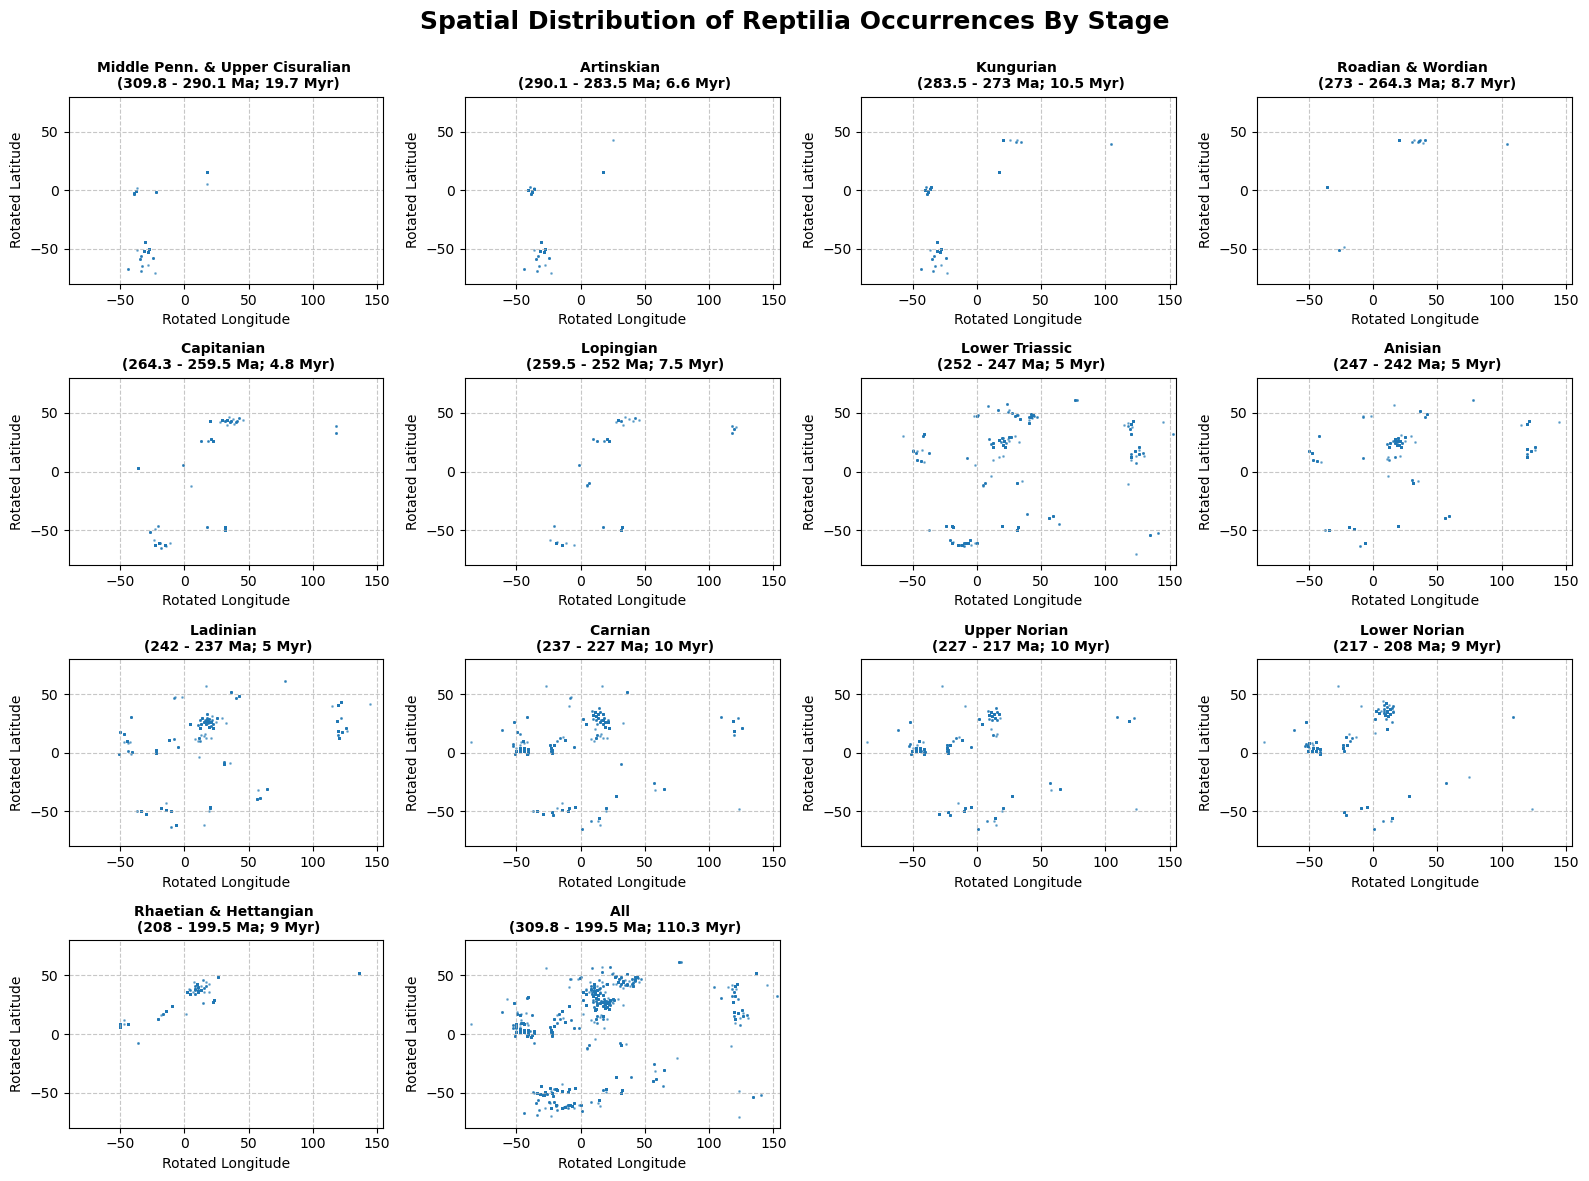

In [774]:
# Plot all REPTILIA hespdiv bins using plot_occs_distribution function in one PDF

# Put all those plots into one 3x4 grid
fig, axs = plt.subplots(4, 4, figsize=(16, 12))
bins = [rep_hespdiv_bin1, rep_hespdiv_bin2, rep_hespdiv_bin3, rep_hespdiv_bin4, rep_hespdiv_bin5, rep_hespdiv_bin6, rep_hespdiv_bin7, rep_hespdiv_bin8, rep_hespdiv_bin9, rep_hespdiv_bin10, rep_hespdiv_bin11, rep_hespdiv_bin12, rep_hespdiv_bin13, rep_deepdive_hespdiv]
bin_names = ['Middle Penn. & Upper Cisuralian', 'Artinskian', 'Kungurian', 'Roadian & Wordian', 'Capitanian', 'Lopingian', 'Lower Triassic', 'Anisian', 'Ladinian', 'Carnian', 'Upper Norian', 'Lower Norian', 'Rhaetian & Hettangian', "All"]
# bin_names = ['Bin 1 (Oldest)', 'Bin 2', 'Bin 3', 'Bin 4', 'Bin 5', 'Bin 6', 'Bin 7', 'Bin 8', 'Bin 9', 'Bin 10', 'Bin 11', 'Bin 12', 'Bin 13 (Most Recent)', 'All Bins']
# bin_ranges = [(309.8 - 290.1), (290.1 - 283.5), (283.5 - 273), (273 - 264.3), (264.3 - 259.5), (259.5 - 252), (252 - 247), (247 - 242), (242 - 237), (237 - 227), (227 - 217), (217 - 208), (208 - 199.5), (309.8 - 199.5)]
# bin_ranges as strings for the plot
bin_ranges = [('309.8 - 290.1'), ('290.1 - 283.5'), ('283.5 - 273'), ('273 - 264.3'), ('264.3 - 259.5'), ('259.5 - 252'), ('252 - 247'), ('247 - 242'), ('242 - 237'), ('237 - 227'), ('227 - 217'), ('217 - 208'), ('208 - 199.5'), ('309.8 - 199.5')]
bin_ranges_int = ['19.7', '6.6', '10.5', '8.7', '4.8', '7.5', '5', '5', '5', '10', '10', '9', '9', '110.3']

for i, ax in enumerate(axs.flat):
    if i < len(bins):
        bins[i].plot.scatter(x='Rotated Lon', y='Rotated Lat', s=1, alpha=0.5, ax=ax)
        ax.set_title(f'{bin_names[i]} \n ({bin_ranges[i]} Ma; {bin_ranges_int[i]} Myr)', fontweight='bold', fontsize=10)
        ax.set_xlabel('Rotated Longitude')
        ax.set_ylabel('Rotated Latitude')
        ax.grid(True, linestyle='--', alpha=0.7)
        ax.set_xlim(-90, 155)  # Set x-axis range based on cell two above
        ax.set_ylim(-80, 80)   # Set y-axis range  based on cell two above
    else:
        ax.axis('off')  # Hide the unused subplots
# Add a title, large size, bold text, high above the plots
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to make room for the title
fig.suptitle('Spatial Distribution of Reptilia Occurrences By Stage', fontsize=18, fontweight='bold', y=0.98)
fig.savefig('hespdiv/reptilia_occurrences_rotated_lat_lon_bins.pdf', dpi=300)

plt.show()
plt.close()


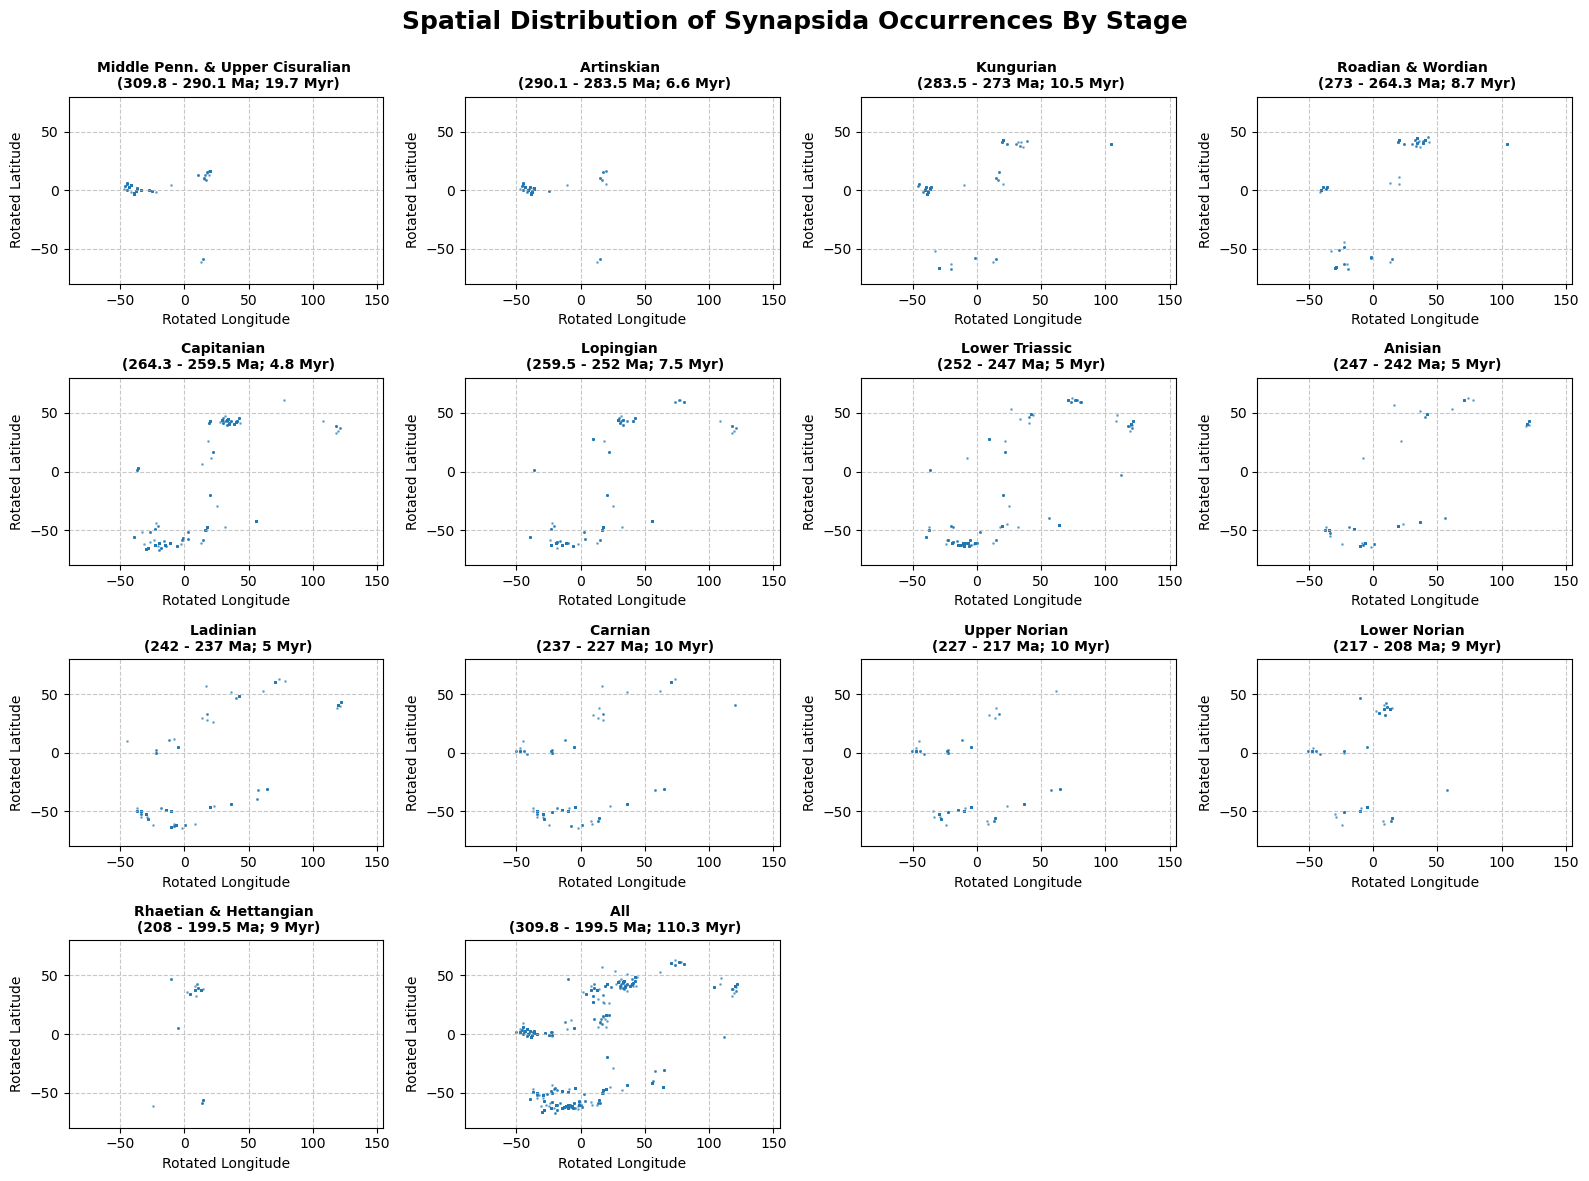

In [775]:
# Plot all SYNAPSIDA hespdiv bins using plot_occs_distribution function in one PDF

# Put all those plots into one 3x4 grid
fig, axs = plt.subplots(4, 4, figsize=(16, 12))
bins = [syn_hespdiv_bin1, syn_hespdiv_bin2, syn_hespdiv_bin3, syn_hespdiv_bin4, syn_hespdiv_bin5, syn_hespdiv_bin6, syn_hespdiv_bin7, syn_hespdiv_bin8, syn_hespdiv_bin9, syn_hespdiv_bin10, syn_hespdiv_bin11, syn_hespdiv_bin12, syn_hespdiv_bin13, syn_deepdive_hespdiv]
bin_names = ['Middle Penn. & Upper Cisuralian', 'Artinskian', 'Kungurian', 'Roadian & Wordian', 'Capitanian', 'Lopingian', 'Lower Triassic', 'Anisian', 'Ladinian', 'Carnian', 'Upper Norian', 'Lower Norian', 'Rhaetian & Hettangian', "All"]
# bin_names = ['Bin 1 (Oldest)', 'Bin 2', 'Bin 3', 'Bin 4', 'Bin 5', 'Bin 6', 'Bin 7', 'Bin 8', 'Bin 9', 'Bin 10', 'Bin 11', 'Bin 12', 'Bin 13 (Most Recent)', 'All Bins']
# bin_ranges = [(309.8 - 290.1), (290.1 - 283.5), (283.5 - 273), (273 - 264.3), (264.3 - 259.5), (259.5 - 252), (252 - 247), (247 - 242), (242 - 237), (237 - 227), (227 - 217), (217 - 208), (208 - 199.5), (309.8 - 199.5)]
# bin_ranges as strings for the plot
bin_ranges = [('309.8 - 290.1'), ('290.1 - 283.5'), ('283.5 - 273'), ('273 - 264.3'), ('264.3 - 259.5'), ('259.5 - 252'), ('252 - 247'), ('247 - 242'), ('242 - 237'), ('237 - 227'), ('227 - 217'), ('217 - 208'), ('208 - 199.5'), ('309.8 - 199.5')]
bin_ranges_int = ['19.7', '6.6', '10.5', '8.7', '4.8', '7.5', '5', '5', '5', '10', '10', '9', '9', '110.3']

for i, ax in enumerate(axs.flat):
    if i < len(bins):
        bins[i].plot.scatter(x='Rotated Lon', y='Rotated Lat', s=1, alpha=0.5, ax=ax)
        ax.set_title(f'{bin_names[i]} \n ({bin_ranges[i]} Ma; {bin_ranges_int[i]} Myr)', fontweight='bold', fontsize=10)
        ax.set_xlabel('Rotated Longitude')
        ax.set_ylabel('Rotated Latitude')
        ax.grid(True, linestyle='--', alpha=0.7)
        ax.set_xlim(-90, 155)  # Set x-axis range based on cell two above
        ax.set_ylim(-80, 80)   # Set y-axis range  based on cell two above
    else:
        ax.axis('off')  # Hide the unused subplots
# Add a title, large size, bold text, high above the plots
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to make room for the title
fig.suptitle('Spatial Distribution of Synapsida Occurrences By Stage', fontsize=18, fontweight='bold', y=0.98)
fig.savefig('hespdiv/synapsida_occurrences_rotated_lat_lon_bins.pdf', dpi=300)

plt.show()
plt.close()

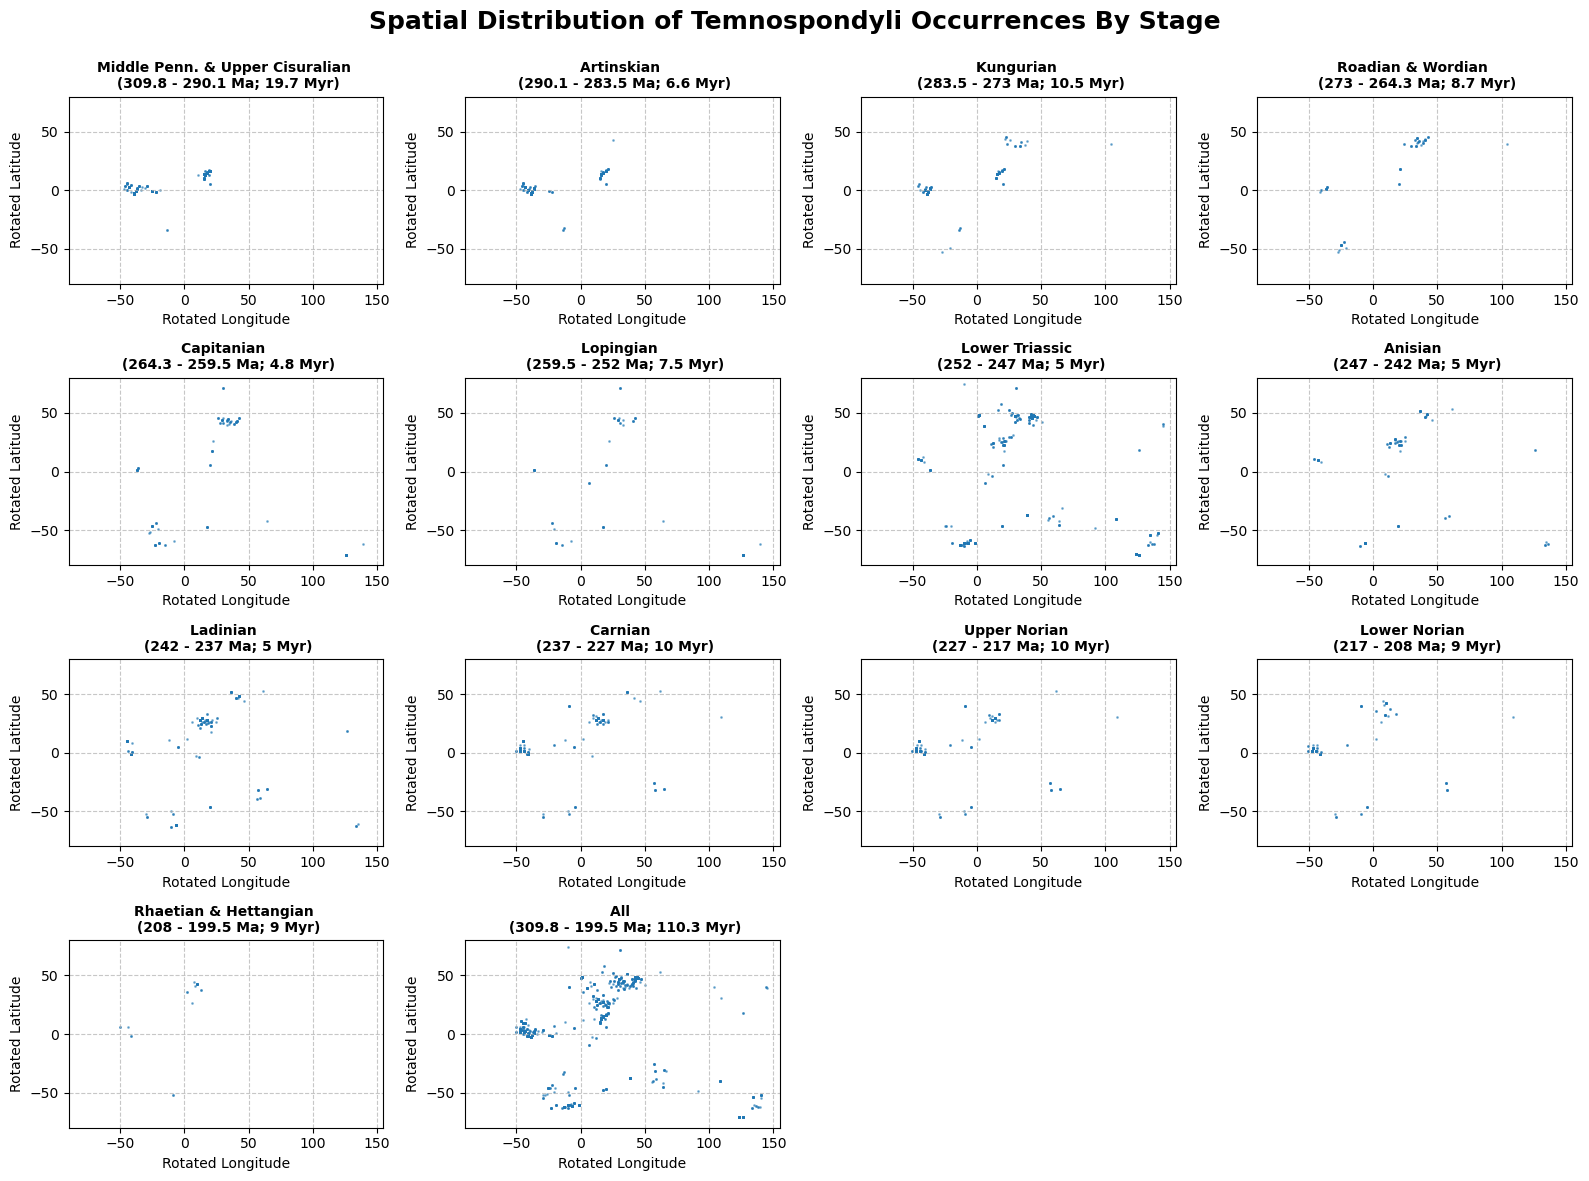

In [776]:
# Plot all TEMNOSPONDYLI hespdiv bins using plot_occs_distribution function in one PDF

# Put all those plots into one 3x4 grid
fig, axs = plt.subplots(4, 4, figsize=(16, 12))
bins = [tem_hespdiv_bin1, tem_hespdiv_bin2, tem_hespdiv_bin3, tem_hespdiv_bin4, tem_hespdiv_bin5, tem_hespdiv_bin6, tem_hespdiv_bin7, tem_hespdiv_bin8, tem_hespdiv_bin9, tem_hespdiv_bin10, tem_hespdiv_bin11, tem_hespdiv_bin12, tem_hespdiv_bin13, tem_deepdive_hespdiv]
bin_names = ['Middle Penn. & Upper Cisuralian', 'Artinskian', 'Kungurian', 'Roadian & Wordian', 'Capitanian', 'Lopingian', 'Lower Triassic', 'Anisian', 'Ladinian', 'Carnian', 'Upper Norian', 'Lower Norian', 'Rhaetian & Hettangian', "All"]
# bin_names = ['Bin 1 (Oldest)', 'Bin 2', 'Bin 3', 'Bin 4', 'Bin 5', 'Bin 6', 'Bin 7', 'Bin 8', 'Bin 9', 'Bin 10', 'Bin 11', 'Bin 12', 'Bin 13 (Most Recent)', 'All Bins']
# bin_ranges = [(309.8 - 290.1), (290.1 - 283.5), (283.5 - 273), (273 - 264.3), (264.3 - 259.5), (259.5 - 252), (252 - 247), (247 - 242), (242 - 237), (237 - 227), (227 - 217), (217 - 208), (208 - 199.5), (309.8 - 199.5)]
# bin_ranges as strings for the plot
bin_ranges = [('309.8 - 290.1'), ('290.1 - 283.5'), ('283.5 - 273'), ('273 - 264.3'), ('264.3 - 259.5'), ('259.5 - 252'), ('252 - 247'), ('247 - 242'), ('242 - 237'), ('237 - 227'), ('227 - 217'), ('217 - 208'), ('208 - 199.5'), ('309.8 - 199.5')]
bin_ranges_int = ['19.7', '6.6', '10.5', '8.7', '4.8', '7.5', '5', '5', '5', '10', '10', '9', '9', '110.3']

for i, ax in enumerate(axs.flat):
    if i < len(bins):
        bins[i].plot.scatter(x='Rotated Lon', y='Rotated Lat', s=1, alpha=0.5, ax=ax)
        ax.set_title(f'{bin_names[i]} \n ({bin_ranges[i]} Ma; {bin_ranges_int[i]} Myr)', fontweight='bold', fontsize=10)
        ax.set_xlabel('Rotated Longitude')
        ax.set_ylabel('Rotated Latitude')
        ax.grid(True, linestyle='--', alpha=0.7)
        ax.set_xlim(-90, 155)  # Set x-axis range based on cell two above
        ax.set_ylim(-80, 80)   # Set y-axis range  based on cell two above
    else:
        ax.axis('off')  # Hide the unused subplots
# Add a title, large size, bold text, high above the plots
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to make room for the title
fig.suptitle('Spatial Distribution of Temnospondyli Occurrences By Stage', fontsize=18, fontweight='bold', y=0.98)
fig.savefig('hespdiv/temnospondyli_occurrences_rotated_lat_lon_bins.pdf', dpi=300)

plt.show()
plt.close()

# Trouble Shooting Section

### B_covar_rjmcmc_hpp_notranslate Rep Diff Column #'s Issue
Can't do -combLogRJ b/c for some reason the mcmc files have diff #'s of columns

Probably b/c half the files are named "COVhprj" and half are "COVhp_BD1-1." The files named BD1-1 were multi-threaded. Let's see how I can fix it!

In [608]:
syn_cov = pd.read_csv("../synapsida/mcmc_predictors/B_covar_rjmcmc_hpp_notranslate/synapsida_pyrate_2_COVhprj_mcmc.log", sep='\t')
syn_cov.columns

Index(['it', 'posterior', 'prior', 'PP_lik', 'BD_lik', 'q_rate', 'alpha',
       'cov_sp', 'cov_ex', 'cov_q',
       ...
       'Wadiasaurus_TE', 'Walteria_TE', 'Wantulignathus_TE', 'Watongia_TE',
       'Woutersia_TE', 'Woznikella_TE', 'Xiyukannemeyeria_TE',
       'Xyrospondylus_TE', 'Yikezhaogia_TE', 'Zambiasaurus_TE'],
      dtype='object', length=1067)

In [609]:
syn_cov_bd1 = pd.read_csv("../synapsida/mcmc_predictors/B_covar_rjmcmc_hpp_notranslate/synapsida_pyrate_6_COVhp_BD1-1_mcmc.log", sep='\t')
syn_cov_bd1.columns

Index(['it', 'posterior', 'prior', 'PP_lik', 'BD_lik', 'q_rate', 'alpha',
       'cov_sp', 'cov_ex', 'cov_q',
       ...
       'Wadiasaurus_TE', 'Walteria_TE', 'Wantulignathus_TE', 'Watongia_TE',
       'Woutersia_TE', 'Woznikella_TE', 'Xiyukannemeyeria_TE',
       'Xyrospondylus_TE', 'Yikezhaogia_TE', 'Zambiasaurus_TE'],
      dtype='object', length=1066)

In [611]:
syn_cov_cols = syn_cov.columns
syn_cov_bd1_cols = syn_cov_bd1.columns

#find which columns they do not have in common
diff_cols = syn_cov_cols.difference(syn_cov_bd1_cols)
diff_cols

Index(['RJ_hp', 'k_birth', 'k_death'], dtype='object')

In [614]:
# Find cols that are in syn_cov_bd1 but not in syn_cov_bd1
diff_cols2 = syn_cov_bd1_cols.difference(syn_cov_cols)
diff_cols2

Index(['lambda_0', 'mu_0'], dtype='object')

Conclusion: any command that used multithreading (whether -r > 0 or -thread > 0) will be forced into -A = 0 (TDI == 0), even if -A 4 was explicitly chosen (and even if not, since -A 4 is default anyway). 

If I used -thread or -r with -A 4 (RJMCMC) or no -A flag (implied -A 4), the -A 4 was overridden and changed to -A 0, MCMC.

-A 4 and -A 0 runs will always have a different # of columns, which means they cannot be combined or concatenated!! If you have a BD1-1 log, it cannot be combined with any RJMCMC logs

This does not matter for BDNN, obviously, because BDNN will always be -A 0. So if you use BDNN w/ multithreading (-thread or -r), you will get BD1-1 named logs, but they will have the same # of columns as non-BD1-1 named logs. So you can restore and concatenate the two types

In [622]:
tem_b_bdnn_bd1 = pd.read_csv('../temnospondyli/mcmc_predictors/B_bdnn_stdscaled_log/B_bdnn_stdscaled_log_restored_logs/temnospondyli_pyrate_1_B_stdscaled_log_restored_G_BD1-1_BDNN_16_8TVc_mcmc.log', sep='\t', skiprows=1)
tem_b_bdnn_bd1.columns

Index(['0', '-9991.576840718419', '-2908.77626088837', '-5852.549832072549',
       '-1230.250747757499', '7.5680124019651664', '1.8701461587503274',
       '1.4003869634258914', '0.31287280767988634', '0.48112497520988096',
       ...
       '76.38848622497628', '69.15288058478018', '70.72914750668048',
       '71.70770766566581', '76.41948201164469', '67.07475872373202',
       '72.01014209569246', '68.75325345342983', '97.05005494632476',
       '90.42776386796615'],
      dtype='object', length=984)

In [621]:
tem_b_bdnn = pd.read_csv('../temnospondyli/mcmc_predictors/B_bdnn_stdscaled_log/temnospondyli_pyrate_1_B_stdscaled_log_G_BDS_BDNN_16_8TVc_mcmc.log', sep='\t')
tem_b_bdnn.columns

Index(['it', 'posterior', 'prior', 'PP_lik', 'BD_lik', 'q_0', 'q_1', 'q_2',
       'q_3', 'q_4',
       ...
       'Watsonisuchus_Antarctic_TE', 'Watsonisuchus_Temperate_S_TE',
       'Wellesaurus_TE', 'Wetlugasaurus_TE', 'Xenobrachyops_TE',
       'Xenotosuchus_TE', 'Yarengia_TE', 'Yuanansuchus_TE', 'Zatrachys_TE',
       'Zygosaurus_TE'],
      dtype='object', length=984)

### LTT with Uncertainty

In [4]:
carnivora_example = pd.read_csv('C:\\\\Users\\SimoesLabAdmin\\Documents\\PyRate\\example_files\\BDNN_examples\\Carnivora\\pyrate_mcmc_logs\\Carnivora_occs_2_G_BDS_BDNN_16_8TVc_mcmc.log', sep='\\t')
carnivora_example.columns

C:\Users\SimoesLabAdmin\AppData\Local\Temp\ipykernel_1840\2767487922.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  carnivora_example = pd.read_csv('C:\\\\Users\\SimoesLabAdmin\\Documents\\PyRate\\example_files\\BDNN_examples\\Carnivora\\pyrate_mcmc_logs\\Carnivora_occs_2_G_BDS_BDNN_16_8TVc_mcmc.log', sep='\\t')


Index(['it', 'posterior', 'prior', 'PP_lik', 'BD_lik', 'q_0', 'q_1', 'q_2',
       'q_3', 'q_4',
       ...
       'Viverricula_TE', 'Vormela_TE', 'Vulpes_TE', 'Watay_TE', 'Xenictis_TE',
       'Xenocyon_TE', 'Xenosmilus_TE', 'Ysengrinia_TE', 'Zaragocyon_TE',
       'Zodiolestes_TE'],
      dtype='object', length=1354)

In [11]:
rjmcmc = pd.read_csv("C:\\Users\\SimoesLabAdmin\\Documents\\BDNN_Arielli\\synapsida\\mcmc_no_predictors\\RJMCMC\\synapsida_pyrate_1_Grj_mcmc.log", sep='\\t')
rjmcmc.columns

C:\Users\SimoesLabAdmin\AppData\Local\Temp\ipykernel_1840\738405932.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  rjmcmc = pd.read_csv("C:\\Users\\SimoesLabAdmin\\Documents\\BDNN_Arielli\\synapsida\\mcmc_no_predictors\\RJMCMC\\synapsida_pyrate_1_Grj_mcmc.log", sep='\\t')


Index(['it', 'posterior', 'prior', 'PP_lik', 'BD_lik', 'q_0', 'q_1', 'q_2',
       'q_3', 'q_4',
       ...
       'Wadiasaurus_TE', 'Walteria_TE', 'Wantulignathus_TE', 'Watongia_TE',
       'Woutersia_TE', 'Woznikella_TE', 'Xiyukannemeyeria_TE',
       'Xyrospondylus_TE', 'Yikezhaogia_TE', 'Zambiasaurus_TE'],
      dtype='object', length=1075)

### A_BDNN RTT of Combined Log files issue

In [3]:
import pandas as pd
a_bdnn_combined = pd.read_csv('../reptilia/mcmc_no_predictors/A_bdnn/combined_10_mcmc.log', sep='\t')
a_bdnn_combined.isna().sum()


it                      0
posterior               0
prior                   0
PP_lik                  0
BD_lik                  0
                    ...  
Yunnanosaurus_TE        0
Zanclodon_TE            0
Zhongjiania_TE          0
Zupaysaurus_TE          0
Unnamed: 1576       89158
Length: 1577, dtype: int64

In [4]:
nulls = a_bdnn_combined.isna().sum()
nulls[nulls > 0]

Unnamed: 1576    89158
dtype: int64

In [11]:
nulls[nulls > 0].index

Index(['Unnamed: 1576'], dtype='object')

In [15]:
a_bdnn_combined.head()

it     posterior        prior        PP_lik       BD_lik       q_0  \
0   0 -17019.777038 -2231.061710 -10696.610913 -4092.104415  0.684103   
1   1 -17030.170407 -2227.888857 -10711.978423 -4090.303127  0.402958   
2   2 -16965.146060 -2229.954744 -10649.798529 -4085.392788  0.558838   
3   3 -16938.838650 -2237.199551 -10625.328354 -4076.310745  0.584176   
4   4 -16900.429267 -2233.747139 -10585.522672 -4081.159457  0.531132   

        q_1       q_2       q_3       q_4  ...  Yimenosaurus_TE  Youngetta_TE  \
0  4.525981  0.477896  1.044224  4.101567  ...        24.382310     74.002724   
1  5.344000  0.515232  1.570986  4.524201  ...        24.633825     73.842541   
2  5.182734  0.465071  0.732591  1.897250  ...        24.615898     73.983489   
3  5.228445  0.506010  0.710923  2.950372  ...        24.254294     73.648999   
4  4.777018  0.625456  0.883525  2.350642  ...        24.622798     73.900701   

   Youngina_TE  Youngosuchus_TE  Yunguisaurus_TE  Yunnanosaurus_TE  \
0    75.301951        70.935361        62.601791         24.453600   
1    75.277146        70.986898        62.637609         24.261339   
2    77.493466        70.782109        62.858147         24.292314   
3    76.868372        70.237141        62.646750         24.328795   
4    76.745427        70.958337        61.984072         24.418524   

   Zanclodon_TE  Zhongjiania_TE  Zupaysaurus_TE  Unnamed: 1576  
0     28.757712       81.429913       34.750084            NaN  
1     28.573735       81.339350       33.542997            NaN  
2     28.621338       81.408035       32.680385            NaN  
3     29.276861       80.718844       34.247283            NaN  
4     28.360976       81.287240       35.012532            NaN  

[5 rows x 1577 columns]

In [7]:
# a_bdnn_1 = pd.read_csv('../reptilia/mcmc_no_predictors/A_bdnn/reptilia_pyrate_1_G_BDS_BDNN_4_2Tc_mcmc.log', sep='\t')
# nulls_1 = a_bdnn_1.isna().sum()
# nulls_1[nulls_1 > 0]

# Make the above into a function that takes a different value for "1" each time
def check_nulls(file_path):
    df = pd.read_csv(file_path, sep='\t')
    nulls = df.isna().sum()
    nulls = nulls[nulls > 0]
    return nulls

check_nulls('../reptilia/mcmc_no_predictors/A_bdnn/reptilia_pyrate_1_G_BDS_BDNN_4_2Tc_mcmc.log')

Series([], dtype: int64)

In [8]:
print(check_nulls('../reptilia/mcmc_no_predictors/A_bdnn/reptilia_pyrate_2_G_BDS_BDNN_4_2Tc_mcmc.log'))
print(check_nulls('../reptilia/mcmc_no_predictors/A_bdnn/reptilia_pyrate_3_G_BDS_BDNN_4_2Tc_mcmc.log'))
print(check_nulls('../reptilia/mcmc_no_predictors/A_bdnn/reptilia_pyrate_4_G_BDS_BDNN_4_2Tc_mcmc.log'))
print(check_nulls('../reptilia/mcmc_no_predictors/A_bdnn/reptilia_pyrate_5_G_BDS_BDNN_4_2Tc_mcmc.log'))
print(check_nulls('../reptilia/mcmc_no_predictors/A_bdnn/reptilia_pyrate_6_G_BDS_BDNN_4_2Tc_mcmc.log'))
print(check_nulls('../reptilia/mcmc_no_predictors/A_bdnn/reptilia_pyrate_7_G_BDS_BDNN_4_2Tc_mcmc.log'))
print(check_nulls('../reptilia/mcmc_no_predictors/A_bdnn/reptilia_pyrate_8_G_BDS_BDNN_4_2Tc_mcmc.log'))
print(check_nulls('../reptilia/mcmc_no_predictors/A_bdnn/reptilia_pyrate_9_G_BDS_BDNN_4_2Tc_mcmc.log'))
print(check_nulls('../reptilia/mcmc_no_predictors/A_bdnn/reptilia_pyrate_10_G_BDS_BDNN_4_2Tc_mcmc.log'))

Series([], dtype: int64)
Series([], dtype: int64)
Series([], dtype: int64)
Series([], dtype: int64)
Series([], dtype: int64)
Series([], dtype: int64)
Series([], dtype: int64)
Series([], dtype: int64)
Series([], dtype: int64)


In [19]:
a_bdnn_1 = pd.read_csv('../reptilia/mcmc_no_predictors/A_bdnn/reptilia_pyrate_1_G_BDS_BDNN_4_2Tc_mcmc.log', sep='\t')
a_bdnn_2 = pd.read_csv('../reptilia/mcmc_no_predictors/A_bdnn/reptilia_pyrate_2_G_BDS_BDNN_4_2Tc_mcmc.log', sep='\t')
a_bdnn_3 = pd.read_csv('../reptilia/mcmc_no_predictors/A_bdnn/reptilia_pyrate_3_G_BDS_BDNN_4_2Tc_mcmc.log', sep='\t')
a_bdnn_4 = pd.read_csv('../reptilia/mcmc_no_predictors/A_bdnn/reptilia_pyrate_4_G_BDS_BDNN_4_2Tc_mcmc.log', sep='\t')
a_bdnn_5 = pd.read_csv('../reptilia/mcmc_no_predictors/A_bdnn/reptilia_pyrate_5_G_BDS_BDNN_4_2Tc_mcmc.log', sep='\t')
a_bdnn_6 = pd.read_csv('../reptilia/mcmc_no_predictors/A_bdnn/reptilia_pyrate_6_G_BDS_BDNN_4_2Tc_mcmc.log', sep='\t')
a_bdnn_7 = pd.read_csv('../reptilia/mcmc_no_predictors/A_bdnn/reptilia_pyrate_7_G_BDS_BDNN_4_2Tc_mcmc.log', sep='\t')
a_bdnn_8 = pd.read_csv('../reptilia/mcmc_no_predictors/A_bdnn/reptilia_pyrate_8_G_BDS_BDNN_4_2Tc_mcmc.log', sep='\t')
a_bdnn_9 = pd.read_csv('../reptilia/mcmc_no_predictors/A_bdnn/reptilia_pyrate_9_G_BDS_BDNN_4_2Tc_mcmc.log', sep='\t')
a_bdnn_10 = pd.read_csv('../reptilia/mcmc_no_predictors/A_bdnn/reptilia_pyrate_10_G_BDS_BDNN_4_2Tc_mcmc.log', sep='\t')

In [21]:
# Seeing if all the files have the same columns, which they should
# Basically trying to see if the 'Unnamed: 1576' column that the combined log file has (the one with all the nulls)
# originates in one of the original replicates
list(a_bdnn_1.columns) == list(a_bdnn_2.columns) == list(a_bdnn_3.columns) == list(a_bdnn_4.columns) == list(a_bdnn_5.columns) == list(a_bdnn_6.columns) == list(a_bdnn_7.columns) == list(a_bdnn_8.columns) == list(a_bdnn_9.columns) == list(a_bdnn_10.columns)
# a_bdnn_1.columns == a_bdnn_2.columns == a_bdnn_3.columns == a_bdnn_4.columns == a_bdnn_5.columns == a_bdnn_6.columns == a_bdnn_7.columns == a_bdnn_8.columns == a_bdnn_9.columns == a_bdnn_10.columns

True

In [22]:
# The 'Unnamed: 1576' column is not in any of the original files, so it must have been created when combining them
# I'll remove it from the combined file and resave the file
a_bdnn_combined = a_bdnn_combined.drop(columns=['Unnamed: 1576'])
a_bdnn_combined.to_csv('../reptilia/mcmc_no_predictors/A_bdnn/combined_10_mcmc_cleaned.log', sep='\t', index=False)

In [25]:
nulls = a_bdnn_combined.isna().sum()
nulls[nulls > 0]

Series([], dtype: int64)

In [27]:
a_bdnn_1.shape == a_bdnn_combined.shape, a_bdnn_1.columns.tolist() == a_bdnn_combined.columns.tolist()

(False, True)

In [53]:
a_bdnn_combined.shape, a_bdnn_1.shape, a_bdnn_2.shape, a_bdnn_3.shape, a_bdnn_4.shape, a_bdnn_5.shape, a_bdnn_6.shape, a_bdnn_7.shape, a_bdnn_8.shape, a_bdnn_9.shape, a_bdnn_10.shape

((89158, 1576),
 (10000, 1576),
 (10000, 1576),
 (10000, 1576),
 (9693, 1576),
 (9807, 1576),
 (9955, 1576),
 (9607, 1576),
 (10000, 1576),
 (10000, 1576),
 (10000, 1576))

In [29]:
len(a_bdnn_1.columns)

1576

In [30]:
a_bdnn_combined_resampled = a_bdnn_combined.sample(n=10000, random_state=42)
a_bdnn_combined_resampled.to_csv('../reptilia/mcmc_no_predictors/A_bdnn/combined_10_mcmc_cleaned_resampled.log', sep='\t', index=False)

A look into the plot_bdnn_rtt function in bdnn_lib.py of PyRate shows that an empty r_sp_sum and/or r_q_sum might be the issue. These two come from the sp_rates.log and ex_rates.log files. 

In [31]:
a_bdnn_ex_rates = pd.read_csv("../reptilia/mcmc_no_predictors/A_bdnn/combined_10_ex_rates.log", sep='\t')
a_bdnn_sp_rates = pd.read_csv("../reptilia/mcmc_no_predictors/A_bdnn/combined_10_sp_rates.log", sep='\t')
a_bdnn_ex_rates.shape, a_bdnn_sp_rates.shape

((89155, 247), (89158, 247))

In [61]:
a_bdnn_1_ex = pd.read_csv('../reptilia/mcmc_no_predictors/A_bdnn/reptilia_pyrate_1_G_BDS_BDNN_4_2Tc_ex_rates.log', sep='\t')
a_bdnn_2_ex = pd.read_csv('../reptilia/mcmc_no_predictors/A_bdnn/reptilia_pyrate_2_G_BDS_BDNN_4_2Tc_ex_rates.log', sep='\t')
a_bdnn_3_ex = pd.read_csv('../reptilia/mcmc_no_predictors/A_bdnn/reptilia_pyrate_3_G_BDS_BDNN_4_2Tc_ex_rates.log', sep='\t')
a_bdnn_4_ex = pd.read_csv('../reptilia/mcmc_no_predictors/A_bdnn/reptilia_pyrate_4_G_BDS_BDNN_4_2Tc_ex_rates.log', sep='\t')
a_bdnn_5_ex = pd.read_csv('../reptilia/mcmc_no_predictors/A_bdnn/reptilia_pyrate_5_G_BDS_BDNN_4_2Tc_ex_rates.log', sep='\t')
a_bdnn_6_ex = pd.read_csv('../reptilia/mcmc_no_predictors/A_bdnn/reptilia_pyrate_6_G_BDS_BDNN_4_2Tc_ex_rates.log', sep='\t')
a_bdnn_7_ex = pd.read_csv('../reptilia/mcmc_no_predictors/A_bdnn/reptilia_pyrate_7_G_BDS_BDNN_4_2Tc_ex_rates.log', sep='\t')
a_bdnn_8_ex = pd.read_csv('../reptilia/mcmc_no_predictors/A_bdnn/reptilia_pyrate_8_G_BDS_BDNN_4_2Tc_ex_rates.log', sep='\t')
a_bdnn_9_ex = pd.read_csv('../reptilia/mcmc_no_predictors/A_bdnn/reptilia_pyrate_9_G_BDS_BDNN_4_2Tc_ex_rates.log', sep='\t')
a_bdnn_10_ex = pd.read_csv('../reptilia/mcmc_no_predictors/A_bdnn/reptilia_pyrate_10_G_BDS_BDNN_4_2Tc_ex_rates.log', sep='\t')
a_bdnn_1_ex.shape, a_bdnn_2_ex.shape, a_bdnn_3_ex.shape, a_bdnn_4_ex.shape, a_bdnn_5_ex.shape, a_bdnn_6_ex.shape, a_bdnn_7_ex.shape, a_bdnn_8_ex.shape, a_bdnn_9_ex.shape, a_bdnn_10_ex.shape


((9999, 247),
 (9999, 247),
 (9999, 247),
 (9691, 247),
 (9806, 247),
 (9953, 247),
 (9606, 247),
 (9999, 247),
 (9999, 247),
 (9999, 247))

In [62]:
a_bdnn_1_sp = pd.read_csv('../reptilia/mcmc_no_predictors/A_bdnn/reptilia_pyrate_1_G_BDS_BDNN_4_2Tc_sp_rates.log', sep='\t')
a_bdnn_2_sp = pd.read_csv('../reptilia/mcmc_no_predictors/A_bdnn/reptilia_pyrate_2_G_BDS_BDNN_4_2Tc_sp_rates.log', sep='\t')
a_bdnn_3_sp = pd.read_csv('../reptilia/mcmc_no_predictors/A_bdnn/reptilia_pyrate_3_G_BDS_BDNN_4_2Tc_sp_rates.log', sep='\t')
a_bdnn_4_sp = pd.read_csv('../reptilia/mcmc_no_predictors/A_bdnn/reptilia_pyrate_4_G_BDS_BDNN_4_2Tc_sp_rates.log', sep='\t')
a_bdnn_5_sp = pd.read_csv('../reptilia/mcmc_no_predictors/A_bdnn/reptilia_pyrate_5_G_BDS_BDNN_4_2Tc_sp_rates.log', sep='\t')
a_bdnn_6_sp = pd.read_csv('../reptilia/mcmc_no_predictors/A_bdnn/reptilia_pyrate_6_G_BDS_BDNN_4_2Tc_sp_rates.log', sep='\t')
a_bdnn_7_sp = pd.read_csv('../reptilia/mcmc_no_predictors/A_bdnn/reptilia_pyrate_7_G_BDS_BDNN_4_2Tc_sp_rates.log', sep='\t')
a_bdnn_8_sp = pd.read_csv('../reptilia/mcmc_no_predictors/A_bdnn/reptilia_pyrate_8_G_BDS_BDNN_4_2Tc_sp_rates.log', sep='\t')
a_bdnn_9_sp = pd.read_csv('../reptilia/mcmc_no_predictors/A_bdnn/reptilia_pyrate_9_G_BDS_BDNN_4_2Tc_sp_rates.log', sep='\t')
a_bdnn_10_sp = pd.read_csv('../reptilia/mcmc_no_predictors/A_bdnn/reptilia_pyrate_10_G_BDS_BDNN_4_2Tc_sp_rates.log', sep='\t')
a_bdnn_1_sp.shape, a_bdnn_2_sp.shape, a_bdnn_3_sp.shape, a_bdnn_4_sp.shape, a_bdnn_5_sp.shape, a_bdnn_6_sp.shape, a_bdnn_7_sp.shape, a_bdnn_8_sp.shape, a_bdnn_9_sp.shape, a_bdnn_10_sp.shape

((9999, 247),
 (9999, 247),
 (9999, 247),
 (9693, 247),
 (9806, 247),
 (9954, 247),
 (9606, 247),
 (9999, 247),
 (9999, 247),
 (9999, 247))

In [63]:
a_bdnn_1_sp.shape[0] + a_bdnn_2_sp.shape[0] + a_bdnn_3_sp.shape[0] + a_bdnn_4_sp.shape[0] + a_bdnn_5_sp.shape[0] + a_bdnn_6_sp.shape[0] + a_bdnn_7_sp.shape[0] + a_bdnn_8_sp.shape[0] + a_bdnn_9_sp.shape[0] + a_bdnn_10_sp.shape[0]

99053

In [64]:
a_bdnn_1_ex.shape[0] + a_bdnn_2_ex.shape[0] + a_bdnn_3_ex.shape[0] + a_bdnn_4_ex.shape[0] + a_bdnn_5_ex.shape[0] + a_bdnn_6_ex.shape[0] + a_bdnn_7_ex.shape[0] + a_bdnn_8_ex.shape[0] + a_bdnn_9_ex.shape[0] + a_bdnn_10_ex.shape[0]

99050

In [52]:
a_bdnn_1_ex_rates = pd.read_csv("../reptilia/mcmc_no_predictors/A_bdnn/reptilia_pyrate_1_G_BDS_BDNN_4_2Tc_ex_rates.log", sep='\t')
a_bdnn_1_ex_rates.head()


0.6893043035611727  0.6893043103159449  0.6893043203417482  \
0            0.135709            0.135722            0.135741   
1            0.142587            0.142588            0.142588   
2            0.147984            0.148002            0.148030   
3            0.142686            0.142689            0.142694   
4            0.137641            0.137642            0.137644   

   0.689304330367565  0.689304340393395  0.6893043504192382  \
0           0.135760           0.135780            0.135800   
1           0.142589           0.142589            0.142590   
2           0.148057           0.148085            0.148113   
3           0.142698           0.142703            0.142708   
4           0.137645           0.137647            0.137648   

   0.6893043604450945  0.6893043704709636  0.6893043804968455  \
0            0.135821            0.135842            0.135863   
1                 NaN            0.142591            0.142591   
2            0.148142            0.148171            0.148200   
3            0.142714            0.142719            0.142724   
4            0.137650            0.137651            0.137653   

   0.6893043905227402  ...  10  9  8  7  6  5  4  3  2  1  
0            0.135885  ...  10  9  8  7  6  5  4  3  2  1  
1            0.142592  ...  10  9  8  7  6  5  4  3  2  1  
2            0.148229  ...  10  9  8  7  6  5  4  3  2  1  
3            0.142730  ...  10  9  8  7  6  5  4  3  2  1  
4            0.137654  ...  10  9  8  7  6  5  4  3  2  1  

[5 rows x 247 columns]

In [41]:
a_bdnn_ex_rates.head()

0.26271500205374027  0.2626637047662528  0.26260037595885705  \
0             0.324048            0.323886             0.323687   
1             0.298766            0.298690             0.298595   
2             0.284378            0.284303             0.284210   
3             0.253603            0.253577             0.253545   
4             0.287036            0.286923             0.286784   

   0.26253287909153566  0.26246088934718326  0.26238405318027397  \
0             0.323476             0.323251             0.323012   
1             0.298493             0.298385             0.298269   
2             0.284111             0.284006             0.283893   
3             0.253510             0.253472             0.253431   
4             0.286637             0.286481             0.286317   

   0.2623019855148511  0.26221426664815767  0.262120438827389  \
0            0.322758             0.322487           0.322199   
1            0.298144             0.298010           0.297867   
2            0.283772             0.283643           0.283504   
3            0.253387             0.253340           0.253289   
4            0.286142             0.285957           0.285760   

   0.2620200024633998  ...  10  9  8  7  6  5  4  3  2  1  
0            0.321891  ...  10  9  8  7  6  5  4  3  2  1  
1            0.297713  ...  10  9  8  7  6  5  4  3  2  1  
2            0.283356  ...  10  9  8  7  6  5  4  3  2  1  
3            0.253233  ...  10  9  8  7  6  5  4  3  2  1  
4            0.285551  ...  10  9  8  7  6  5  4  3  2  1  

[5 rows x 247 columns]

In [33]:
# Find only the columns that have nulls
a_bdnn_ex_rates_nulls = a_bdnn_ex_rates.isna().sum()
a_bdnn_ex_rates_nulls[a_bdnn_ex_rates_nulls > 0]


0.2623019855148511     1637
0.707636511859035         4
0.7944262984313201     7380
nan                   44284
nan.1                 72458
nan.2                 83669
nan.3                 87438
nan.4                 88677
nan.5                 89023
nan.6                 89126
nan.7                 89145
nan.8                 89152
nan.9                 89154
nan.10                89155
nan.11                89155
nan.12                89155
nan.13                89155
nan.14                89155
nan.15                89155
nan.16                89155
nan.17                89155
nan.18                89155
nan.19                89155
nan.20                89155
nan.21                89155
dtype: int64

In [34]:
a_bdnn_sp_rates_nulls = a_bdnn_sp_rates.isna().sum()
a_bdnn_sp_rates_nulls[a_bdnn_sp_rates_nulls > 0]

0.2785897615240495      1637
0.15707630044196536        4
0.16656744156317435     7381
nan                    44286
nan.1                  72461
nan.2                  83672
nan.3                  87441
nan.4                  88680
nan.5                  89026
nan.6                  89129
nan.7                  89148
nan.8                  89155
nan.9                  89157
nan.10                 89158
nan.11                 89158
nan.12                 89158
nan.13                 89158
nan.14                 89158
nan.15                 89158
nan.16                 89158
nan.17                 89158
nan.18                 89158
nan.19                 89158
nan.20                 89158
nan.21                 89158
dtype: int64

In [38]:
# Comparing everything against an RTT plot that worked (RJMCMC plots)
rep_rjmcmc_combined = pd.read_csv('../reptilia/mcmc_no_predictors/RJMCMC/combined_10_mcmc.log', sep='\t')
rep_rjmcmc_sp_rates = pd.read_csv('../reptilia/mcmc_no_predictors/RJMCMC/combined_10_sp_rates.log', sep='\t')
rep_rjmcmc_ex_rates = pd.read_csv('../reptilia/mcmc_no_predictors/RJMCMC/combined_10_ex_rates.log', sep='\t')

rep_rjmcmc_combined.shape, rep_rjmcmc_sp_rates.shape, rep_rjmcmc_ex_rates.shape

UnicodeDecodeError: 'utf-8' codec can't decode byte 0xac in position 12029: invalid start byte

In [40]:
a_bdnn_1_ex_rates = pd.read_csv("../reptilia/mcmc_no_predictors/A_bdnn/reptilia_pyrate_1_G_BDS_BDNN_4_2Tc_ex_rates.log", sep='\t')
a_bdnn_1_ex_rates.shape, a_bdnn_1_ex_rates.isna().sum()

# Finding the columns that have nulls
a_bdnn_1_ex_rates_nulls = a_bdnn_1_ex_rates.isna().sum()
a_bdnn_1_ex_rates_nulls[a_bdnn_1_ex_rates_nulls > 0]

# Seems like it's normal for ex and sp rates .log's to have nulls

0.6893043604450945    1201
0.6893053129447552     441
0.6893053229713536    4166
0.6893053329979542    7663
0.689305343024557     9146
0.6893053530511621    9665
0.6893053630777694    9840
0.6893053731043786    9896
0.6893053831309898    9917
0.6893053931576026    9922
0.689305403184217     9932
0.6893054132108329    9937
0.6893054232374505    9949
0.6893054332640692    9956
0.6893054432906891    9957
0.6893054533173103    9959
0.6893054633439324    9959
0.6893054733705553    9963
0.689305483397179     9964
0.6893054934238034    9968
0.6893055034504283    9971
0.6893055134770537    9976
nan                   9988
nan.1                 9994
dtype: int64

### Test

In [357]:
import pandas as pd
pyrate_input_rep = pd.read_csv('reptilia_processed_data/reptilia_pyrate.txt', sep='\t')
pyrate_input_rep.describe()

min_age      max_age
count  4247.000000  4247.000000
mean    231.992255   241.247062
std      25.480204    23.353718
min     199.500000   201.400000
25%     208.500000   227.000000
50%     237.000000   239.700000
75%     251.902000   254.140000
max     293.520000   298.900000

In [358]:
pyrate_input_rep.isna().sum()

Species    0
Status     0
min_age    0
max_age    0
dtype: int64

In [359]:
pyrate_input_rep.to_csv('reptilia_processed_data/reptilia_pyrate.csv', index=False)

In [360]:
test_pyrate_input = pd.read_csv('../test_reptilia/data/reptilia/Reptilia_pyrate_input.csv')
test_pyrate_input.describe()

min_ma       max_ma
count  3843.000000  3843.000000
mean    226.844473   235.666221
std      21.757171    20.286962
min     199.500000   201.400000
25%     208.500000   227.000000
50%     227.000000   237.000000
75%     242.000000   247.200000
max     293.520000   298.900000

In [361]:
test_pyrate_input.isna().sum()  

accepted_name    0
min_ma           0
max_ma           0
dtype: int64

In [362]:
pyrate_input_rep['Species'].nunique(), test_pyrate_input['accepted_name'].nunique()

(760, 738)

In [363]:
time_bins_bystages_test = pd.read_csv('Time_bins_ByStages.txt', sep='\t', header=None)
time_bins_bystages_test

0
0   290.1
1   283.5
2   273.0
3   264.3
4   259.5
5   252.0
6   247.0
7   242.0
8   237.0
9   227.0
10  217.0
11  208.0

In [364]:
new_row = pd.DataFrame({0:[300]})
time_bins_bystages_test = pd.concat([new_row, time_bins_bystages_test], ignore_index=True)
time_bins_bystages_test

0
0   300.0
1   290.1
2   283.5
3   273.0
4   264.3
5   259.5
6   252.0
7   247.0
8   242.0
9   237.0
10  227.0
11  217.0
12  208.0

In [365]:
len(time_bins_bystages_test)

13

In [366]:
time_bins_bystages_test.loc[13] = 190

In [367]:
time_bins_bystages_test 

0
0   300.0
1   290.1
2   283.5
3   273.0
4   264.3
5   259.5
6   252.0
7   247.0
8   242.0
9   237.0
10  227.0
11  217.0
12  208.0
13  190.0

In [368]:
time_bins_bystages_test.to_csv('Time_bins_ByStages_TEST.txt', sep='\t', header=False, index=False)

## Exploring Left LTT plot Age Dist

In [369]:
rep_ltt_test = pd.read_csv('reptilia_processed_data/reptilia_pyrate.txt', sep='\t') 
rep_ltt_test

Species   Status  min_age  max_age
0          Icarosaurus  extinct    208.5  227.000
1             Rutiodon  extinct    208.5  227.000
2        Kuehneosuchus  extinct    201.4  208.500
3        Kuehneosaurus  extinct    201.4  208.500
4          Procolophon  extinct    247.2  251.902
...                ...      ...      ...      ...
4242       Eohyosaurus  extinct    242.0  247.200
4243        Mesosuchus  extinct    242.0  247.200
4244        Mesosuchus  extinct    242.0  247.200
4245        Mesosuchus  extinct    242.0  247.200
4246  Stenaulorhynchus  extinct    242.0  247.200

[4247 rows x 4 columns]

In [370]:
rep_ltt_test[rep_ltt_test['max_age'] <210]

Species   Status  min_age  max_age
2                 Kuehneosuchus  extinct    201.4    208.5
3                 Kuehneosaurus  extinct    201.4    208.5
68    Proganochelys_Temperate_N  extinct    201.4    208.5
69                Liliensternus  extinct    201.4    208.5
70              Elachistosuchus  extinct    201.4    208.5
...                         ...      ...      ...      ...
4045                 Sinosaurus  extinct    199.5    201.4
4046                 Sinosaurus  extinct    199.5    201.4
4050  Ichthyosaurus_Temperate_N  extinct    199.5    201.4
4051               Plesiosaurus  extinct    201.4    208.5
4073               Ichthyotitan  extinct    201.4    208.5

[536 rows x 4 columns]

In [371]:
pd.set_option('display.max_rows', 100)

## Singleton and # Species Count

In [372]:
pyrate_input_syn = pd.read_csv('synapsida_processed_data/synapsida_pyrate.txt', sep='\t')
pyrate_input_tem = pd.read_csv('temnospondyli_processed_data/temnospondyli_pyrate.txt', sep='\t')

In [373]:
pyrate_input_rep['Species'].value_counts().value_counts()[1], pyrate_input_syn['Species'].value_counts().value_counts()[1], pyrate_input_tem['Species'].value_counts().value_counts()[1]

(341, 244, 119)

In [374]:
# As a percentage of total number of species
pyrate_input_rep['Species'].value_counts().value_counts()[1]/pyrate_input_rep['Species'].nunique(), pyrate_input_syn['Species'].value_counts().value_counts()[1]/pyrate_input_syn['Species'].nunique(), pyrate_input_tem['Species'].value_counts().value_counts()[1]/pyrate_input_tem['Species'].nunique()

(0.4486842105263158, 0.46476190476190476, 0.42805755395683454)

In [375]:
# As a percentage of total occurrences
pyrate_input_rep['Species'].value_counts().value_counts()[1]/pyrate_input_rep.shape[0], pyrate_input_syn['Species'].value_counts().value_counts()[1]/pyrate_input_syn.shape[0], pyrate_input_tem['Species'].value_counts().value_counts()[1]/pyrate_input_tem.shape[0]

(0.08029197080291971, 0.07277065314643602, 0.05355535553555356)